In [1]:
import numpy as np 
import pandas as pd 
import sys 
import matplotlib.pyplot as plt

from DataManager import DataManager 
import setting as st 

def normalize_data(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_n = (X - mu) / sigma
    return X_n, mu, sigma

def norm_eq(X, y):
    theta = np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), y)
    return theta

def shuffle_index(X, y):
    m, n = X.shape
    sidx = np.random.permutation(m)
    return sidx, X[sidx], y[sidx]

def chunk_validation_set(portion, X, y):
    m, n = X.shape
    sidx, sX, sy = shuffle_index(X, y)
    nval = int(portion*m)
    trainX = X[nval:]
    trainy = y[nval:]
    valX = X[0:nval]
    valy = y[0:nval]
    return trainX, trainy, valX, valy

def remove_non_positive_data(X, y):
    Xmask = np.all(X > 0, axis=1)
    ymask = np.all(y > 0, axis=1)
    mask = Xmask & ymask
    return X[mask], y[mask]

def remove_strange_data(X, y):
    Xmask = np.all(X < 300, axis=1)
    ymask = np.all(y < 300, axis=1)
    mask = Xmask & ymask
    return X[mask], y[mask]

def preprocess_data(X, y):
    X, y = remove_non_positive_data(X, y)
    X, y = remove_strange_data(X, y)
    return X, y 


def predict(theta, instance):
    h_theta = np.dot(instance, theta)
    return h_theta

def h(X, theta):
    return np.dot(X, theta)

def J(theta, h, lamb, X, y):
    m, n = X.shape
    square_error = np.sum((h(X, theta) - y)**2)
    regularization = lamb * np.dot(theta[1:].T, theta[1:])
    return (1 / 2) * (1 / m) * (square_error + regularization)

def gradient_descent(theta, h, X, y, eta, lamb, n_iters):
    m, n = X.shape
    theta_record = np.zeros((n_iters, *theta.shape))
    loss_record = np.zeros((n_iters, 1))
    
    theta_record[0] = theta
    loss_record[0] = J(theta, h, lamb, X, y)
    grad_square_sum = np.zeros(theta.shape)
    for i in range(1, n_iters):
        total_grad = np.dot(X.T, (h(X, theta) - y))
        total_grad[1:] = total_grad[1:] + lamb * theta[1:]
        grad = (1 / m) * total_grad
        
        grad_square_sum = grad**2 + grad_square_sum
        
        theta = theta - eta * grad / np.sqrt(grad_square_sum)
        theta_record[i] = theta
        loss_record[i] = J(theta, h, lamb, X, y)
        print('iteration:', i, 'loss:', loss_record[i])
        
    return theta, theta_record, loss_record

def initialize_theta_randomly(X, y):
    m, n = X.shape
    return np.random.normal(loc=0, scale=1, size=(n, 1))

def initialize_theta_to_zero(X, y):
    m, n = X.shape
    return np.zeros((n, 1))

def initialize_theta(X, y):
    return norm_eq(X, y)

def find_example_error(theta, h, J, lamb, X, y):
    error_list = []

    for i, example in enumerate(zip(X, y)):
        xx, yy = example
        xx = xx.reshape((1, -1))
        yy = yy.reshape((1, 1))
        error_list.append((J(theta, h, lamb, xx, yy), i, xx, yy))

    return sorted(error_list, reverse=True)

def validate_data(rate, h, J, X, y):
    lamb = 0
    norm_theta = norm_eq(X, y)
    error_list = sorted(find_example_error(norm_theta, h, J, lamb, X, y), reverse=True)
    to_drop = error_list[0:int(rate*len(error_list))]
    to_drop_idx = [idx for err, idx, xx, yy in to_drop]
    return np.delete(X, to_drop_idx, axis=0), np.delete(y, to_drop_idx, axis=0)


def main():
    dm = DataManager()

    dm.read_training_data(st.TRAINING_SET)

    mdfs = dm.select_feature_to_mdfs(st.SELECTED_FEATURE)

    X, y = dm.chunk_examples(mdfs, chunk_size=st.CHUNK_SIZE)

    X, y = preprocess_data(X, y)

    X_n, mu, sigma = normalize_data(X)

    X_n = np.insert(X_n, obj=0, values=1, axis=1)

    X_n, y = validate_data(st.VALIDATE_RATE, h, J, X_n, y)

    init_theta = initialize_theta_to_zero(X_n, y)

    theta, theta_record, loss_record = gradient_descent(init_theta, h, X_n, y, eta=st.ETA, lamb=st.LAMBDA, n_iters=st.N_ITERS)

    np.save(st.MODEL_NAME, theta)
    np.save(st.STATISTICS, np.array([mu, sigma]))
    
    fig, ax = plt.subplots()
    ax.set_title('final loss:'+str(loss_record[-1]))
    ax.plot(np.arange(loss_record.size), loss_record)
    plt.savefig('p2_eta%f.png'%(st.ETA))


In [2]:
print(st.SELECTED_FEATURE, st.ETA, st.LAMBDA, st.CHUNK_SIZE, st.N_ITERS)

['PM2.5'] 10 0 9 200000


iteration: 1 loss: [ 2460.79403737]
iteration: 2 loss: [ 213.39687128]
iteration: 3 loss: [ 90.75474797]
iteration: 4 loss: [ 65.14642127]
iteration: 5 loss: [ 51.75709712]
iteration: 6 loss: [ 43.75474468]
iteration: 7 loss: [ 38.71165497]
iteration: 8 loss: [ 35.36712332]
iteration: 9 loss: [ 33.03011691]
iteration: 10 loss: [ 31.31184107]
iteration: 11 loss: [ 29.98832104]
iteration: 12 loss: [ 28.92722664]
iteration: 13 loss: [ 28.04812135]
iteration: 14 loss: [ 27.30053169]
iteration: 15 loss: [ 26.65167204]
iteration: 16 loss: [ 26.07946642]
iteration: 17 loss: [ 25.56851032]
iteration: 18 loss: [ 25.10768466]
iteration: 19 loss: [ 24.68871204]
iteration: 20 loss: [ 24.30525951]
iteration: 21 loss: [ 23.95236502]
iteration: 22 loss: [ 23.62605994]
iteration: 23 loss: [ 23.32311348]
iteration: 24 loss: [ 23.04085494]
iteration: 25 loss: [ 22.77704706]
iteration: 26 loss: [ 22.52979381]
iteration: 27 loss: [ 22.29747191]
iteration: 28 loss: [ 22.07867908]
iteration: 29 loss: [ 21.8

iteration: 347 loss: [ 14.88342553]
iteration: 348 loss: [ 14.88067675]
iteration: 349 loss: [ 14.87794339]
iteration: 350 loss: [ 14.87522535]
iteration: 351 loss: [ 14.87252252]
iteration: 352 loss: [ 14.86983479]
iteration: 353 loss: [ 14.86716205]
iteration: 354 loss: [ 14.86450421]
iteration: 355 loss: [ 14.86186116]
iteration: 356 loss: [ 14.8592328]
iteration: 357 loss: [ 14.85661902]
iteration: 358 loss: [ 14.85401974]
iteration: 359 loss: [ 14.85143484]
iteration: 360 loss: [ 14.84886423]
iteration: 361 loss: [ 14.84630782]
iteration: 362 loss: [ 14.8437655]
iteration: 363 loss: [ 14.84123719]
iteration: 364 loss: [ 14.83872278]
iteration: 365 loss: [ 14.83622219]
iteration: 366 loss: [ 14.83373531]
iteration: 367 loss: [ 14.83126207]
iteration: 368 loss: [ 14.82880236]
iteration: 369 loss: [ 14.8263561]
iteration: 370 loss: [ 14.8239232]
iteration: 371 loss: [ 14.82150357]
iteration: 372 loss: [ 14.81909713]
iteration: 373 loss: [ 14.81670377]
iteration: 374 loss: [ 14.814323

iteration: 826 loss: [ 14.39110943]
iteration: 827 loss: [ 14.39084342]
iteration: 828 loss: [ 14.39057862]
iteration: 829 loss: [ 14.39031502]
iteration: 830 loss: [ 14.39005264]
iteration: 831 loss: [ 14.38979144]
iteration: 832 loss: [ 14.38953144]
iteration: 833 loss: [ 14.38927263]
iteration: 834 loss: [ 14.389015]
iteration: 835 loss: [ 14.38875854]
iteration: 836 loss: [ 14.38850325]
iteration: 837 loss: [ 14.38824913]
iteration: 838 loss: [ 14.38799617]
iteration: 839 loss: [ 14.38774436]
iteration: 840 loss: [ 14.38749369]
iteration: 841 loss: [ 14.38724417]
iteration: 842 loss: [ 14.38699579]
iteration: 843 loss: [ 14.38674854]
iteration: 844 loss: [ 14.38650241]
iteration: 845 loss: [ 14.38625741]
iteration: 846 loss: [ 14.38601353]
iteration: 847 loss: [ 14.38577075]
iteration: 848 loss: [ 14.38552908]
iteration: 849 loss: [ 14.38528851]
iteration: 850 loss: [ 14.38504904]
iteration: 851 loss: [ 14.38481066]
iteration: 852 loss: [ 14.38457336]
iteration: 853 loss: [ 14.3843

iteration: 1256 loss: [ 14.34065969]
iteration: 1257 loss: [ 14.34062132]
iteration: 1258 loss: [ 14.34058313]
iteration: 1259 loss: [ 14.3405451]
iteration: 1260 loss: [ 14.34050724]
iteration: 1261 loss: [ 14.34046955]
iteration: 1262 loss: [ 14.34043203]
iteration: 1263 loss: [ 14.34039468]
iteration: 1264 loss: [ 14.34035749]
iteration: 1265 loss: [ 14.34032046]
iteration: 1266 loss: [ 14.3402836]
iteration: 1267 loss: [ 14.3402469]
iteration: 1268 loss: [ 14.34021037]
iteration: 1269 loss: [ 14.34017399]
iteration: 1270 loss: [ 14.34013778]
iteration: 1271 loss: [ 14.34010173]
iteration: 1272 loss: [ 14.34006584]
iteration: 1273 loss: [ 14.3400301]
iteration: 1274 loss: [ 14.33999453]
iteration: 1275 loss: [ 14.33995911]
iteration: 1276 loss: [ 14.33992385]
iteration: 1277 loss: [ 14.33988875]
iteration: 1278 loss: [ 14.3398538]
iteration: 1279 loss: [ 14.33981901]
iteration: 1280 loss: [ 14.33978437]
iteration: 1281 loss: [ 14.33974989]
iteration: 1282 loss: [ 14.33971556]
iterat

iteration: 1553 loss: [ 14.33430523]
iteration: 1554 loss: [ 14.33429488]
iteration: 1555 loss: [ 14.33428457]
iteration: 1556 loss: [ 14.33427431]
iteration: 1557 loss: [ 14.33426409]
iteration: 1558 loss: [ 14.33425392]
iteration: 1559 loss: [ 14.33424379]
iteration: 1560 loss: [ 14.3342337]
iteration: 1561 loss: [ 14.33422366]
iteration: 1562 loss: [ 14.33421367]
iteration: 1563 loss: [ 14.33420371]
iteration: 1564 loss: [ 14.3341938]
iteration: 1565 loss: [ 14.33418394]
iteration: 1566 loss: [ 14.33417411]
iteration: 1567 loss: [ 14.33416433]
iteration: 1568 loss: [ 14.33415459]
iteration: 1569 loss: [ 14.3341449]
iteration: 1570 loss: [ 14.33413524]
iteration: 1571 loss: [ 14.33412563]
iteration: 1572 loss: [ 14.33411606]
iteration: 1573 loss: [ 14.33410654]
iteration: 1574 loss: [ 14.33409705]
iteration: 1575 loss: [ 14.33408761]
iteration: 1576 loss: [ 14.3340782]
iteration: 1577 loss: [ 14.33406884]
iteration: 1578 loss: [ 14.33405952]
iteration: 1579 loss: [ 14.33405024]
itera

iteration: 1831 loss: [ 14.33263217]
iteration: 1832 loss: [ 14.33262907]
iteration: 1833 loss: [ 14.33262598]
iteration: 1834 loss: [ 14.33262291]
iteration: 1835 loss: [ 14.33261984]
iteration: 1836 loss: [ 14.3326168]
iteration: 1837 loss: [ 14.33261376]
iteration: 1838 loss: [ 14.33261074]
iteration: 1839 loss: [ 14.33260773]
iteration: 1840 loss: [ 14.33260473]
iteration: 1841 loss: [ 14.33260175]
iteration: 1842 loss: [ 14.33259878]
iteration: 1843 loss: [ 14.33259582]
iteration: 1844 loss: [ 14.33259288]
iteration: 1845 loss: [ 14.33258994]
iteration: 1846 loss: [ 14.33258702]
iteration: 1847 loss: [ 14.33258412]
iteration: 1848 loss: [ 14.33258122]
iteration: 1849 loss: [ 14.33257834]
iteration: 1850 loss: [ 14.33257547]
iteration: 1851 loss: [ 14.33257261]
iteration: 1852 loss: [ 14.33256977]
iteration: 1853 loss: [ 14.33256693]
iteration: 1854 loss: [ 14.33256411]
iteration: 1855 loss: [ 14.3325613]
iteration: 1856 loss: [ 14.3325585]
iteration: 1857 loss: [ 14.33255572]
iter

iteration: 2121 loss: [ 14.33211552]
iteration: 2122 loss: [ 14.33211462]
iteration: 2123 loss: [ 14.33211372]
iteration: 2124 loss: [ 14.33211283]
iteration: 2125 loss: [ 14.33211194]
iteration: 2126 loss: [ 14.33211105]
iteration: 2127 loss: [ 14.33211016]
iteration: 2128 loss: [ 14.33210928]
iteration: 2129 loss: [ 14.33210841]
iteration: 2130 loss: [ 14.33210753]
iteration: 2131 loss: [ 14.33210667]
iteration: 2132 loss: [ 14.3321058]
iteration: 2133 loss: [ 14.33210494]
iteration: 2134 loss: [ 14.33210408]
iteration: 2135 loss: [ 14.33210322]
iteration: 2136 loss: [ 14.33210237]
iteration: 2137 loss: [ 14.33210153]
iteration: 2138 loss: [ 14.33210068]
iteration: 2139 loss: [ 14.33209984]
iteration: 2140 loss: [ 14.332099]
iteration: 2141 loss: [ 14.33209817]
iteration: 2142 loss: [ 14.33209734]
iteration: 2143 loss: [ 14.33209651]
iteration: 2144 loss: [ 14.33209569]
iteration: 2145 loss: [ 14.33209487]
iteration: 2146 loss: [ 14.33209406]
iteration: 2147 loss: [ 14.33209324]
iter

iteration: 2361 loss: [ 14.33197858]
iteration: 2362 loss: [ 14.33197824]
iteration: 2363 loss: [ 14.33197791]
iteration: 2364 loss: [ 14.33197758]
iteration: 2365 loss: [ 14.33197726]
iteration: 2366 loss: [ 14.33197693]
iteration: 2367 loss: [ 14.33197661]
iteration: 2368 loss: [ 14.33197628]
iteration: 2369 loss: [ 14.33197596]
iteration: 2370 loss: [ 14.33197564]
iteration: 2371 loss: [ 14.33197532]
iteration: 2372 loss: [ 14.331975]
iteration: 2373 loss: [ 14.33197469]
iteration: 2374 loss: [ 14.33197437]
iteration: 2375 loss: [ 14.33197406]
iteration: 2376 loss: [ 14.33197374]
iteration: 2377 loss: [ 14.33197343]
iteration: 2378 loss: [ 14.33197312]
iteration: 2379 loss: [ 14.33197281]
iteration: 2380 loss: [ 14.3319725]
iteration: 2381 loss: [ 14.3319722]
iteration: 2382 loss: [ 14.33197189]
iteration: 2383 loss: [ 14.33197159]
iteration: 2384 loss: [ 14.33197129]
iteration: 2385 loss: [ 14.33197098]
iteration: 2386 loss: [ 14.33197068]
iteration: 2387 loss: [ 14.33197038]
itera

iteration: 2592 loss: [ 14.33192903]
iteration: 2593 loss: [ 14.3319289]
iteration: 2594 loss: [ 14.33192878]
iteration: 2595 loss: [ 14.33192865]
iteration: 2596 loss: [ 14.33192852]
iteration: 2597 loss: [ 14.33192839]
iteration: 2598 loss: [ 14.33192827]
iteration: 2599 loss: [ 14.33192814]
iteration: 2600 loss: [ 14.33192802]
iteration: 2601 loss: [ 14.33192789]
iteration: 2602 loss: [ 14.33192777]
iteration: 2603 loss: [ 14.33192765]
iteration: 2604 loss: [ 14.33192752]
iteration: 2605 loss: [ 14.3319274]
iteration: 2606 loss: [ 14.33192728]
iteration: 2607 loss: [ 14.33192716]
iteration: 2608 loss: [ 14.33192704]
iteration: 2609 loss: [ 14.33192692]
iteration: 2610 loss: [ 14.3319268]
iteration: 2611 loss: [ 14.33192668]
iteration: 2612 loss: [ 14.33192656]
iteration: 2613 loss: [ 14.33192644]
iteration: 2614 loss: [ 14.33192632]
iteration: 2615 loss: [ 14.3319262]
iteration: 2616 loss: [ 14.33192609]
iteration: 2617 loss: [ 14.33192597]
iteration: 2618 loss: [ 14.33192585]
itera

iteration: 2846 loss: [ 14.33190856]
iteration: 2847 loss: [ 14.33190851]
iteration: 2848 loss: [ 14.33190846]
iteration: 2849 loss: [ 14.33190842]
iteration: 2850 loss: [ 14.33190837]
iteration: 2851 loss: [ 14.33190833]
iteration: 2852 loss: [ 14.33190828]
iteration: 2853 loss: [ 14.33190824]
iteration: 2854 loss: [ 14.33190819]
iteration: 2855 loss: [ 14.33190815]
iteration: 2856 loss: [ 14.3319081]
iteration: 2857 loss: [ 14.33190806]
iteration: 2858 loss: [ 14.33190801]
iteration: 2859 loss: [ 14.33190797]
iteration: 2860 loss: [ 14.33190793]
iteration: 2861 loss: [ 14.33190788]
iteration: 2862 loss: [ 14.33190784]
iteration: 2863 loss: [ 14.33190779]
iteration: 2864 loss: [ 14.33190775]
iteration: 2865 loss: [ 14.33190771]
iteration: 2866 loss: [ 14.33190767]
iteration: 2867 loss: [ 14.33190762]
iteration: 2868 loss: [ 14.33190758]
iteration: 2869 loss: [ 14.33190754]
iteration: 2870 loss: [ 14.3319075]
iteration: 2871 loss: [ 14.33190745]
iteration: 2872 loss: [ 14.33190741]
ite

iteration: 3130 loss: [ 14.33190064]
iteration: 3131 loss: [ 14.33190063]
iteration: 3132 loss: [ 14.33190061]
iteration: 3133 loss: [ 14.3319006]
iteration: 3134 loss: [ 14.33190058]
iteration: 3135 loss: [ 14.33190057]
iteration: 3136 loss: [ 14.33190055]
iteration: 3137 loss: [ 14.33190054]
iteration: 3138 loss: [ 14.33190053]
iteration: 3139 loss: [ 14.33190051]
iteration: 3140 loss: [ 14.3319005]
iteration: 3141 loss: [ 14.33190048]
iteration: 3142 loss: [ 14.33190047]
iteration: 3143 loss: [ 14.33190045]
iteration: 3144 loss: [ 14.33190044]
iteration: 3145 loss: [ 14.33190042]
iteration: 3146 loss: [ 14.33190041]
iteration: 3147 loss: [ 14.3319004]
iteration: 3148 loss: [ 14.33190038]
iteration: 3149 loss: [ 14.33190037]
iteration: 3150 loss: [ 14.33190035]
iteration: 3151 loss: [ 14.33190034]
iteration: 3152 loss: [ 14.33190033]
iteration: 3153 loss: [ 14.33190031]
iteration: 3154 loss: [ 14.3319003]
iteration: 3155 loss: [ 14.33190028]
iteration: 3156 loss: [ 14.33190027]
itera

iteration: 3506 loss: [ 14.33189765]
iteration: 3507 loss: [ 14.33189764]
iteration: 3508 loss: [ 14.33189764]
iteration: 3509 loss: [ 14.33189764]
iteration: 3510 loss: [ 14.33189763]
iteration: 3511 loss: [ 14.33189763]
iteration: 3512 loss: [ 14.33189762]
iteration: 3513 loss: [ 14.33189762]
iteration: 3514 loss: [ 14.33189762]
iteration: 3515 loss: [ 14.33189761]
iteration: 3516 loss: [ 14.33189761]
iteration: 3517 loss: [ 14.33189761]
iteration: 3518 loss: [ 14.3318976]
iteration: 3519 loss: [ 14.3318976]
iteration: 3520 loss: [ 14.3318976]
iteration: 3521 loss: [ 14.33189759]
iteration: 3522 loss: [ 14.33189759]
iteration: 3523 loss: [ 14.33189759]
iteration: 3524 loss: [ 14.33189758]
iteration: 3525 loss: [ 14.33189758]
iteration: 3526 loss: [ 14.33189758]
iteration: 3527 loss: [ 14.33189757]
iteration: 3528 loss: [ 14.33189757]
iteration: 3529 loss: [ 14.33189757]
iteration: 3530 loss: [ 14.33189756]
iteration: 3531 loss: [ 14.33189756]
iteration: 3532 loss: [ 14.33189756]
iter

iteration: 3893 loss: [ 14.33189692]
iteration: 3894 loss: [ 14.33189692]
iteration: 3895 loss: [ 14.33189692]
iteration: 3896 loss: [ 14.33189692]
iteration: 3897 loss: [ 14.33189692]
iteration: 3898 loss: [ 14.33189692]
iteration: 3899 loss: [ 14.33189692]
iteration: 3900 loss: [ 14.33189692]
iteration: 3901 loss: [ 14.33189692]
iteration: 3902 loss: [ 14.33189692]
iteration: 3903 loss: [ 14.33189692]
iteration: 3904 loss: [ 14.33189691]
iteration: 3905 loss: [ 14.33189691]
iteration: 3906 loss: [ 14.33189691]
iteration: 3907 loss: [ 14.33189691]
iteration: 3908 loss: [ 14.33189691]
iteration: 3909 loss: [ 14.33189691]
iteration: 3910 loss: [ 14.33189691]
iteration: 3911 loss: [ 14.33189691]
iteration: 3912 loss: [ 14.33189691]
iteration: 3913 loss: [ 14.33189691]
iteration: 3914 loss: [ 14.33189691]
iteration: 3915 loss: [ 14.33189691]
iteration: 3916 loss: [ 14.33189691]
iteration: 3917 loss: [ 14.3318969]
iteration: 3918 loss: [ 14.3318969]
iteration: 3919 loss: [ 14.3318969]
iter

iteration: 4230 loss: [ 14.33189676]
iteration: 4231 loss: [ 14.33189676]
iteration: 4232 loss: [ 14.33189676]
iteration: 4233 loss: [ 14.33189676]
iteration: 4234 loss: [ 14.33189676]
iteration: 4235 loss: [ 14.33189676]
iteration: 4236 loss: [ 14.33189676]
iteration: 4237 loss: [ 14.33189676]
iteration: 4238 loss: [ 14.33189676]
iteration: 4239 loss: [ 14.33189676]
iteration: 4240 loss: [ 14.33189676]
iteration: 4241 loss: [ 14.33189676]
iteration: 4242 loss: [ 14.33189676]
iteration: 4243 loss: [ 14.33189676]
iteration: 4244 loss: [ 14.33189676]
iteration: 4245 loss: [ 14.33189676]
iteration: 4246 loss: [ 14.33189676]
iteration: 4247 loss: [ 14.33189676]
iteration: 4248 loss: [ 14.33189676]
iteration: 4249 loss: [ 14.33189676]
iteration: 4250 loss: [ 14.33189676]
iteration: 4251 loss: [ 14.33189676]
iteration: 4252 loss: [ 14.33189676]
iteration: 4253 loss: [ 14.33189676]
iteration: 4254 loss: [ 14.33189676]
iteration: 4255 loss: [ 14.33189676]
iteration: 4256 loss: [ 14.33189676]
i

iteration: 4528 loss: [ 14.33189672]
iteration: 4529 loss: [ 14.33189672]
iteration: 4530 loss: [ 14.33189672]
iteration: 4531 loss: [ 14.33189672]
iteration: 4532 loss: [ 14.33189672]
iteration: 4533 loss: [ 14.33189672]
iteration: 4534 loss: [ 14.33189672]
iteration: 4535 loss: [ 14.33189672]
iteration: 4536 loss: [ 14.33189672]
iteration: 4537 loss: [ 14.33189672]
iteration: 4538 loss: [ 14.33189672]
iteration: 4539 loss: [ 14.33189672]
iteration: 4540 loss: [ 14.33189672]
iteration: 4541 loss: [ 14.33189672]
iteration: 4542 loss: [ 14.33189672]
iteration: 4543 loss: [ 14.33189672]
iteration: 4544 loss: [ 14.33189672]
iteration: 4545 loss: [ 14.33189672]
iteration: 4546 loss: [ 14.33189672]
iteration: 4547 loss: [ 14.33189672]
iteration: 4548 loss: [ 14.33189672]
iteration: 4549 loss: [ 14.33189672]
iteration: 4550 loss: [ 14.33189672]
iteration: 4551 loss: [ 14.33189672]
iteration: 4552 loss: [ 14.33189672]
iteration: 4553 loss: [ 14.33189672]
iteration: 4554 loss: [ 14.33189672]
i

iteration: 4773 loss: [ 14.33189671]
iteration: 4774 loss: [ 14.33189671]
iteration: 4775 loss: [ 14.33189671]
iteration: 4776 loss: [ 14.33189671]
iteration: 4777 loss: [ 14.33189671]
iteration: 4778 loss: [ 14.33189671]
iteration: 4779 loss: [ 14.33189671]
iteration: 4780 loss: [ 14.33189671]
iteration: 4781 loss: [ 14.33189671]
iteration: 4782 loss: [ 14.33189671]
iteration: 4783 loss: [ 14.33189671]
iteration: 4784 loss: [ 14.33189671]
iteration: 4785 loss: [ 14.33189671]
iteration: 4786 loss: [ 14.33189671]
iteration: 4787 loss: [ 14.33189671]
iteration: 4788 loss: [ 14.33189671]
iteration: 4789 loss: [ 14.33189671]
iteration: 4790 loss: [ 14.33189671]
iteration: 4791 loss: [ 14.33189671]
iteration: 4792 loss: [ 14.33189671]
iteration: 4793 loss: [ 14.33189671]
iteration: 4794 loss: [ 14.33189671]
iteration: 4795 loss: [ 14.33189671]
iteration: 4796 loss: [ 14.33189671]
iteration: 4797 loss: [ 14.33189671]
iteration: 4798 loss: [ 14.33189671]
iteration: 4799 loss: [ 14.33189671]
i

iteration: 4999 loss: [ 14.3318967]
iteration: 5000 loss: [ 14.3318967]
iteration: 5001 loss: [ 14.3318967]
iteration: 5002 loss: [ 14.3318967]
iteration: 5003 loss: [ 14.3318967]
iteration: 5004 loss: [ 14.3318967]
iteration: 5005 loss: [ 14.3318967]
iteration: 5006 loss: [ 14.3318967]
iteration: 5007 loss: [ 14.3318967]
iteration: 5008 loss: [ 14.3318967]
iteration: 5009 loss: [ 14.3318967]
iteration: 5010 loss: [ 14.3318967]
iteration: 5011 loss: [ 14.3318967]
iteration: 5012 loss: [ 14.3318967]
iteration: 5013 loss: [ 14.3318967]
iteration: 5014 loss: [ 14.3318967]
iteration: 5015 loss: [ 14.3318967]
iteration: 5016 loss: [ 14.3318967]
iteration: 5017 loss: [ 14.3318967]
iteration: 5018 loss: [ 14.3318967]
iteration: 5019 loss: [ 14.3318967]
iteration: 5020 loss: [ 14.3318967]
iteration: 5021 loss: [ 14.3318967]
iteration: 5022 loss: [ 14.3318967]
iteration: 5023 loss: [ 14.3318967]
iteration: 5024 loss: [ 14.3318967]
iteration: 5025 loss: [ 14.3318967]
iteration: 5026 loss: [ 14.3

iteration: 5250 loss: [ 14.3318967]
iteration: 5251 loss: [ 14.3318967]
iteration: 5252 loss: [ 14.3318967]
iteration: 5253 loss: [ 14.3318967]
iteration: 5254 loss: [ 14.3318967]
iteration: 5255 loss: [ 14.3318967]
iteration: 5256 loss: [ 14.3318967]
iteration: 5257 loss: [ 14.3318967]
iteration: 5258 loss: [ 14.3318967]
iteration: 5259 loss: [ 14.3318967]
iteration: 5260 loss: [ 14.3318967]
iteration: 5261 loss: [ 14.3318967]
iteration: 5262 loss: [ 14.3318967]
iteration: 5263 loss: [ 14.3318967]
iteration: 5264 loss: [ 14.3318967]
iteration: 5265 loss: [ 14.3318967]
iteration: 5266 loss: [ 14.3318967]
iteration: 5267 loss: [ 14.3318967]
iteration: 5268 loss: [ 14.3318967]
iteration: 5269 loss: [ 14.3318967]
iteration: 5270 loss: [ 14.3318967]
iteration: 5271 loss: [ 14.3318967]
iteration: 5272 loss: [ 14.3318967]
iteration: 5273 loss: [ 14.3318967]
iteration: 5274 loss: [ 14.3318967]
iteration: 5275 loss: [ 14.3318967]
iteration: 5276 loss: [ 14.3318967]
iteration: 5277 loss: [ 14.3

iteration: 5698 loss: [ 14.3318967]
iteration: 5699 loss: [ 14.3318967]
iteration: 5700 loss: [ 14.3318967]
iteration: 5701 loss: [ 14.3318967]
iteration: 5702 loss: [ 14.3318967]
iteration: 5703 loss: [ 14.3318967]
iteration: 5704 loss: [ 14.3318967]
iteration: 5705 loss: [ 14.3318967]
iteration: 5706 loss: [ 14.3318967]
iteration: 5707 loss: [ 14.3318967]
iteration: 5708 loss: [ 14.3318967]
iteration: 5709 loss: [ 14.3318967]
iteration: 5710 loss: [ 14.3318967]
iteration: 5711 loss: [ 14.3318967]
iteration: 5712 loss: [ 14.3318967]
iteration: 5713 loss: [ 14.3318967]
iteration: 5714 loss: [ 14.3318967]
iteration: 5715 loss: [ 14.3318967]
iteration: 5716 loss: [ 14.3318967]
iteration: 5717 loss: [ 14.3318967]
iteration: 5718 loss: [ 14.3318967]
iteration: 5719 loss: [ 14.3318967]
iteration: 5720 loss: [ 14.3318967]
iteration: 5721 loss: [ 14.3318967]
iteration: 5722 loss: [ 14.3318967]
iteration: 5723 loss: [ 14.3318967]
iteration: 5724 loss: [ 14.3318967]
iteration: 5725 loss: [ 14.3

iteration: 5966 loss: [ 14.3318967]
iteration: 5967 loss: [ 14.3318967]
iteration: 5968 loss: [ 14.3318967]
iteration: 5969 loss: [ 14.3318967]
iteration: 5970 loss: [ 14.3318967]
iteration: 5971 loss: [ 14.3318967]
iteration: 5972 loss: [ 14.3318967]
iteration: 5973 loss: [ 14.3318967]
iteration: 5974 loss: [ 14.3318967]
iteration: 5975 loss: [ 14.3318967]
iteration: 5976 loss: [ 14.3318967]
iteration: 5977 loss: [ 14.3318967]
iteration: 5978 loss: [ 14.3318967]
iteration: 5979 loss: [ 14.3318967]
iteration: 5980 loss: [ 14.3318967]
iteration: 5981 loss: [ 14.3318967]
iteration: 5982 loss: [ 14.3318967]
iteration: 5983 loss: [ 14.3318967]
iteration: 5984 loss: [ 14.3318967]
iteration: 5985 loss: [ 14.3318967]
iteration: 5986 loss: [ 14.3318967]
iteration: 5987 loss: [ 14.3318967]
iteration: 5988 loss: [ 14.3318967]
iteration: 5989 loss: [ 14.3318967]
iteration: 5990 loss: [ 14.3318967]
iteration: 5991 loss: [ 14.3318967]
iteration: 5992 loss: [ 14.3318967]
iteration: 5993 loss: [ 14.3

iteration: 6217 loss: [ 14.3318967]
iteration: 6218 loss: [ 14.3318967]
iteration: 6219 loss: [ 14.3318967]
iteration: 6220 loss: [ 14.3318967]
iteration: 6221 loss: [ 14.3318967]
iteration: 6222 loss: [ 14.3318967]
iteration: 6223 loss: [ 14.3318967]
iteration: 6224 loss: [ 14.3318967]
iteration: 6225 loss: [ 14.3318967]
iteration: 6226 loss: [ 14.3318967]
iteration: 6227 loss: [ 14.3318967]
iteration: 6228 loss: [ 14.3318967]
iteration: 6229 loss: [ 14.3318967]
iteration: 6230 loss: [ 14.3318967]
iteration: 6231 loss: [ 14.3318967]
iteration: 6232 loss: [ 14.3318967]
iteration: 6233 loss: [ 14.3318967]
iteration: 6234 loss: [ 14.3318967]
iteration: 6235 loss: [ 14.3318967]
iteration: 6236 loss: [ 14.3318967]
iteration: 6237 loss: [ 14.3318967]
iteration: 6238 loss: [ 14.3318967]
iteration: 6239 loss: [ 14.3318967]
iteration: 6240 loss: [ 14.3318967]
iteration: 6241 loss: [ 14.3318967]
iteration: 6242 loss: [ 14.3318967]
iteration: 6243 loss: [ 14.3318967]
iteration: 6244 loss: [ 14.3

iteration: 6503 loss: [ 14.3318967]
iteration: 6504 loss: [ 14.3318967]
iteration: 6505 loss: [ 14.3318967]
iteration: 6506 loss: [ 14.3318967]
iteration: 6507 loss: [ 14.3318967]
iteration: 6508 loss: [ 14.3318967]
iteration: 6509 loss: [ 14.3318967]
iteration: 6510 loss: [ 14.3318967]
iteration: 6511 loss: [ 14.3318967]
iteration: 6512 loss: [ 14.3318967]
iteration: 6513 loss: [ 14.3318967]
iteration: 6514 loss: [ 14.3318967]
iteration: 6515 loss: [ 14.3318967]
iteration: 6516 loss: [ 14.3318967]
iteration: 6517 loss: [ 14.3318967]
iteration: 6518 loss: [ 14.3318967]
iteration: 6519 loss: [ 14.3318967]
iteration: 6520 loss: [ 14.3318967]
iteration: 6521 loss: [ 14.3318967]
iteration: 6522 loss: [ 14.3318967]
iteration: 6523 loss: [ 14.3318967]
iteration: 6524 loss: [ 14.3318967]
iteration: 6525 loss: [ 14.3318967]
iteration: 6526 loss: [ 14.3318967]
iteration: 6527 loss: [ 14.3318967]
iteration: 6528 loss: [ 14.3318967]
iteration: 6529 loss: [ 14.3318967]
iteration: 6530 loss: [ 14.3

iteration: 6782 loss: [ 14.3318967]
iteration: 6783 loss: [ 14.3318967]
iteration: 6784 loss: [ 14.3318967]
iteration: 6785 loss: [ 14.3318967]
iteration: 6786 loss: [ 14.3318967]
iteration: 6787 loss: [ 14.3318967]
iteration: 6788 loss: [ 14.3318967]
iteration: 6789 loss: [ 14.3318967]
iteration: 6790 loss: [ 14.3318967]
iteration: 6791 loss: [ 14.3318967]
iteration: 6792 loss: [ 14.3318967]
iteration: 6793 loss: [ 14.3318967]
iteration: 6794 loss: [ 14.3318967]
iteration: 6795 loss: [ 14.3318967]
iteration: 6796 loss: [ 14.3318967]
iteration: 6797 loss: [ 14.3318967]
iteration: 6798 loss: [ 14.3318967]
iteration: 6799 loss: [ 14.3318967]
iteration: 6800 loss: [ 14.3318967]
iteration: 6801 loss: [ 14.3318967]
iteration: 6802 loss: [ 14.3318967]
iteration: 6803 loss: [ 14.3318967]
iteration: 6804 loss: [ 14.3318967]
iteration: 6805 loss: [ 14.3318967]
iteration: 6806 loss: [ 14.3318967]
iteration: 6807 loss: [ 14.3318967]
iteration: 6808 loss: [ 14.3318967]
iteration: 6809 loss: [ 14.3

iteration: 7208 loss: [ 14.3318967]
iteration: 7209 loss: [ 14.3318967]
iteration: 7210 loss: [ 14.3318967]
iteration: 7211 loss: [ 14.3318967]
iteration: 7212 loss: [ 14.3318967]
iteration: 7213 loss: [ 14.3318967]
iteration: 7214 loss: [ 14.3318967]
iteration: 7215 loss: [ 14.3318967]
iteration: 7216 loss: [ 14.3318967]
iteration: 7217 loss: [ 14.3318967]
iteration: 7218 loss: [ 14.3318967]
iteration: 7219 loss: [ 14.3318967]
iteration: 7220 loss: [ 14.3318967]
iteration: 7221 loss: [ 14.3318967]
iteration: 7222 loss: [ 14.3318967]
iteration: 7223 loss: [ 14.3318967]
iteration: 7224 loss: [ 14.3318967]
iteration: 7225 loss: [ 14.3318967]
iteration: 7226 loss: [ 14.3318967]
iteration: 7227 loss: [ 14.3318967]
iteration: 7228 loss: [ 14.3318967]
iteration: 7229 loss: [ 14.3318967]
iteration: 7230 loss: [ 14.3318967]
iteration: 7231 loss: [ 14.3318967]
iteration: 7232 loss: [ 14.3318967]
iteration: 7233 loss: [ 14.3318967]
iteration: 7234 loss: [ 14.3318967]
iteration: 7235 loss: [ 14.3

iteration: 7500 loss: [ 14.3318967]
iteration: 7501 loss: [ 14.3318967]
iteration: 7502 loss: [ 14.3318967]
iteration: 7503 loss: [ 14.3318967]
iteration: 7504 loss: [ 14.3318967]
iteration: 7505 loss: [ 14.3318967]
iteration: 7506 loss: [ 14.3318967]
iteration: 7507 loss: [ 14.3318967]
iteration: 7508 loss: [ 14.3318967]
iteration: 7509 loss: [ 14.3318967]
iteration: 7510 loss: [ 14.3318967]
iteration: 7511 loss: [ 14.3318967]
iteration: 7512 loss: [ 14.3318967]
iteration: 7513 loss: [ 14.3318967]
iteration: 7514 loss: [ 14.3318967]
iteration: 7515 loss: [ 14.3318967]
iteration: 7516 loss: [ 14.3318967]
iteration: 7517 loss: [ 14.3318967]
iteration: 7518 loss: [ 14.3318967]
iteration: 7519 loss: [ 14.3318967]
iteration: 7520 loss: [ 14.3318967]
iteration: 7521 loss: [ 14.3318967]
iteration: 7522 loss: [ 14.3318967]
iteration: 7523 loss: [ 14.3318967]
iteration: 7524 loss: [ 14.3318967]
iteration: 7525 loss: [ 14.3318967]
iteration: 7526 loss: [ 14.3318967]
iteration: 7527 loss: [ 14.3

iteration: 7868 loss: [ 14.3318967]
iteration: 7869 loss: [ 14.3318967]
iteration: 7870 loss: [ 14.3318967]
iteration: 7871 loss: [ 14.3318967]
iteration: 7872 loss: [ 14.3318967]
iteration: 7873 loss: [ 14.3318967]
iteration: 7874 loss: [ 14.3318967]
iteration: 7875 loss: [ 14.3318967]
iteration: 7876 loss: [ 14.3318967]
iteration: 7877 loss: [ 14.3318967]
iteration: 7878 loss: [ 14.3318967]
iteration: 7879 loss: [ 14.3318967]
iteration: 7880 loss: [ 14.3318967]
iteration: 7881 loss: [ 14.3318967]
iteration: 7882 loss: [ 14.3318967]
iteration: 7883 loss: [ 14.3318967]
iteration: 7884 loss: [ 14.3318967]
iteration: 7885 loss: [ 14.3318967]
iteration: 7886 loss: [ 14.3318967]
iteration: 7887 loss: [ 14.3318967]
iteration: 7888 loss: [ 14.3318967]
iteration: 7889 loss: [ 14.3318967]
iteration: 7890 loss: [ 14.3318967]
iteration: 7891 loss: [ 14.3318967]
iteration: 7892 loss: [ 14.3318967]
iteration: 7893 loss: [ 14.3318967]
iteration: 7894 loss: [ 14.3318967]
iteration: 7895 loss: [ 14.3

iteration: 8277 loss: [ 14.3318967]
iteration: 8278 loss: [ 14.3318967]
iteration: 8279 loss: [ 14.3318967]
iteration: 8280 loss: [ 14.3318967]
iteration: 8281 loss: [ 14.3318967]
iteration: 8282 loss: [ 14.3318967]
iteration: 8283 loss: [ 14.3318967]
iteration: 8284 loss: [ 14.3318967]
iteration: 8285 loss: [ 14.3318967]
iteration: 8286 loss: [ 14.3318967]
iteration: 8287 loss: [ 14.3318967]
iteration: 8288 loss: [ 14.3318967]
iteration: 8289 loss: [ 14.3318967]
iteration: 8290 loss: [ 14.3318967]
iteration: 8291 loss: [ 14.3318967]
iteration: 8292 loss: [ 14.3318967]
iteration: 8293 loss: [ 14.3318967]
iteration: 8294 loss: [ 14.3318967]
iteration: 8295 loss: [ 14.3318967]
iteration: 8296 loss: [ 14.3318967]
iteration: 8297 loss: [ 14.3318967]
iteration: 8298 loss: [ 14.3318967]
iteration: 8299 loss: [ 14.3318967]
iteration: 8300 loss: [ 14.3318967]
iteration: 8301 loss: [ 14.3318967]
iteration: 8302 loss: [ 14.3318967]
iteration: 8303 loss: [ 14.3318967]
iteration: 8304 loss: [ 14.3

iteration: 8562 loss: [ 14.3318967]
iteration: 8563 loss: [ 14.3318967]
iteration: 8564 loss: [ 14.3318967]
iteration: 8565 loss: [ 14.3318967]
iteration: 8566 loss: [ 14.3318967]
iteration: 8567 loss: [ 14.3318967]
iteration: 8568 loss: [ 14.3318967]
iteration: 8569 loss: [ 14.3318967]
iteration: 8570 loss: [ 14.3318967]
iteration: 8571 loss: [ 14.3318967]
iteration: 8572 loss: [ 14.3318967]
iteration: 8573 loss: [ 14.3318967]
iteration: 8574 loss: [ 14.3318967]
iteration: 8575 loss: [ 14.3318967]
iteration: 8576 loss: [ 14.3318967]
iteration: 8577 loss: [ 14.3318967]
iteration: 8578 loss: [ 14.3318967]
iteration: 8579 loss: [ 14.3318967]
iteration: 8580 loss: [ 14.3318967]
iteration: 8581 loss: [ 14.3318967]
iteration: 8582 loss: [ 14.3318967]
iteration: 8583 loss: [ 14.3318967]
iteration: 8584 loss: [ 14.3318967]
iteration: 8585 loss: [ 14.3318967]
iteration: 8586 loss: [ 14.3318967]
iteration: 8587 loss: [ 14.3318967]
iteration: 8588 loss: [ 14.3318967]
iteration: 8589 loss: [ 14.3

iteration: 8940 loss: [ 14.3318967]
iteration: 8941 loss: [ 14.3318967]
iteration: 8942 loss: [ 14.3318967]
iteration: 8943 loss: [ 14.3318967]
iteration: 8944 loss: [ 14.3318967]
iteration: 8945 loss: [ 14.3318967]
iteration: 8946 loss: [ 14.3318967]
iteration: 8947 loss: [ 14.3318967]
iteration: 8948 loss: [ 14.3318967]
iteration: 8949 loss: [ 14.3318967]
iteration: 8950 loss: [ 14.3318967]
iteration: 8951 loss: [ 14.3318967]
iteration: 8952 loss: [ 14.3318967]
iteration: 8953 loss: [ 14.3318967]
iteration: 8954 loss: [ 14.3318967]
iteration: 8955 loss: [ 14.3318967]
iteration: 8956 loss: [ 14.3318967]
iteration: 8957 loss: [ 14.3318967]
iteration: 8958 loss: [ 14.3318967]
iteration: 8959 loss: [ 14.3318967]
iteration: 8960 loss: [ 14.3318967]
iteration: 8961 loss: [ 14.3318967]
iteration: 8962 loss: [ 14.3318967]
iteration: 8963 loss: [ 14.3318967]
iteration: 8964 loss: [ 14.3318967]
iteration: 8965 loss: [ 14.3318967]
iteration: 8966 loss: [ 14.3318967]
iteration: 8967 loss: [ 14.3

iteration: 9188 loss: [ 14.3318967]
iteration: 9189 loss: [ 14.3318967]
iteration: 9190 loss: [ 14.3318967]
iteration: 9191 loss: [ 14.3318967]
iteration: 9192 loss: [ 14.3318967]
iteration: 9193 loss: [ 14.3318967]
iteration: 9194 loss: [ 14.3318967]
iteration: 9195 loss: [ 14.3318967]
iteration: 9196 loss: [ 14.3318967]
iteration: 9197 loss: [ 14.3318967]
iteration: 9198 loss: [ 14.3318967]
iteration: 9199 loss: [ 14.3318967]
iteration: 9200 loss: [ 14.3318967]
iteration: 9201 loss: [ 14.3318967]
iteration: 9202 loss: [ 14.3318967]
iteration: 9203 loss: [ 14.3318967]
iteration: 9204 loss: [ 14.3318967]
iteration: 9205 loss: [ 14.3318967]
iteration: 9206 loss: [ 14.3318967]
iteration: 9207 loss: [ 14.3318967]
iteration: 9208 loss: [ 14.3318967]
iteration: 9209 loss: [ 14.3318967]
iteration: 9210 loss: [ 14.3318967]
iteration: 9211 loss: [ 14.3318967]
iteration: 9212 loss: [ 14.3318967]
iteration: 9213 loss: [ 14.3318967]
iteration: 9214 loss: [ 14.3318967]
iteration: 9215 loss: [ 14.3

iteration: 9538 loss: [ 14.3318967]
iteration: 9539 loss: [ 14.3318967]
iteration: 9540 loss: [ 14.3318967]
iteration: 9541 loss: [ 14.3318967]
iteration: 9542 loss: [ 14.3318967]
iteration: 9543 loss: [ 14.3318967]
iteration: 9544 loss: [ 14.3318967]
iteration: 9545 loss: [ 14.3318967]
iteration: 9546 loss: [ 14.3318967]
iteration: 9547 loss: [ 14.3318967]
iteration: 9548 loss: [ 14.3318967]
iteration: 9549 loss: [ 14.3318967]
iteration: 9550 loss: [ 14.3318967]
iteration: 9551 loss: [ 14.3318967]
iteration: 9552 loss: [ 14.3318967]
iteration: 9553 loss: [ 14.3318967]
iteration: 9554 loss: [ 14.3318967]
iteration: 9555 loss: [ 14.3318967]
iteration: 9556 loss: [ 14.3318967]
iteration: 9557 loss: [ 14.3318967]
iteration: 9558 loss: [ 14.3318967]
iteration: 9559 loss: [ 14.3318967]
iteration: 9560 loss: [ 14.3318967]
iteration: 9561 loss: [ 14.3318967]
iteration: 9562 loss: [ 14.3318967]
iteration: 9563 loss: [ 14.3318967]
iteration: 9564 loss: [ 14.3318967]
iteration: 9565 loss: [ 14.3

iteration: 9779 loss: [ 14.3318967]
iteration: 9780 loss: [ 14.3318967]
iteration: 9781 loss: [ 14.3318967]
iteration: 9782 loss: [ 14.3318967]
iteration: 9783 loss: [ 14.3318967]
iteration: 9784 loss: [ 14.3318967]
iteration: 9785 loss: [ 14.3318967]
iteration: 9786 loss: [ 14.3318967]
iteration: 9787 loss: [ 14.3318967]
iteration: 9788 loss: [ 14.3318967]
iteration: 9789 loss: [ 14.3318967]
iteration: 9790 loss: [ 14.3318967]
iteration: 9791 loss: [ 14.3318967]
iteration: 9792 loss: [ 14.3318967]
iteration: 9793 loss: [ 14.3318967]
iteration: 9794 loss: [ 14.3318967]
iteration: 9795 loss: [ 14.3318967]
iteration: 9796 loss: [ 14.3318967]
iteration: 9797 loss: [ 14.3318967]
iteration: 9798 loss: [ 14.3318967]
iteration: 9799 loss: [ 14.3318967]
iteration: 9800 loss: [ 14.3318967]
iteration: 9801 loss: [ 14.3318967]
iteration: 9802 loss: [ 14.3318967]
iteration: 9803 loss: [ 14.3318967]
iteration: 9804 loss: [ 14.3318967]
iteration: 9805 loss: [ 14.3318967]
iteration: 9806 loss: [ 14.3

iteration: 10088 loss: [ 14.3318967]
iteration: 10089 loss: [ 14.3318967]
iteration: 10090 loss: [ 14.3318967]
iteration: 10091 loss: [ 14.3318967]
iteration: 10092 loss: [ 14.3318967]
iteration: 10093 loss: [ 14.3318967]
iteration: 10094 loss: [ 14.3318967]
iteration: 10095 loss: [ 14.3318967]
iteration: 10096 loss: [ 14.3318967]
iteration: 10097 loss: [ 14.3318967]
iteration: 10098 loss: [ 14.3318967]
iteration: 10099 loss: [ 14.3318967]
iteration: 10100 loss: [ 14.3318967]
iteration: 10101 loss: [ 14.3318967]
iteration: 10102 loss: [ 14.3318967]
iteration: 10103 loss: [ 14.3318967]
iteration: 10104 loss: [ 14.3318967]
iteration: 10105 loss: [ 14.3318967]
iteration: 10106 loss: [ 14.3318967]
iteration: 10107 loss: [ 14.3318967]
iteration: 10108 loss: [ 14.3318967]
iteration: 10109 loss: [ 14.3318967]
iteration: 10110 loss: [ 14.3318967]
iteration: 10111 loss: [ 14.3318967]
iteration: 10112 loss: [ 14.3318967]
iteration: 10113 loss: [ 14.3318967]
iteration: 10114 loss: [ 14.3318967]
i

iteration: 10522 loss: [ 14.3318967]
iteration: 10523 loss: [ 14.3318967]
iteration: 10524 loss: [ 14.3318967]
iteration: 10525 loss: [ 14.3318967]
iteration: 10526 loss: [ 14.3318967]
iteration: 10527 loss: [ 14.3318967]
iteration: 10528 loss: [ 14.3318967]
iteration: 10529 loss: [ 14.3318967]
iteration: 10530 loss: [ 14.3318967]
iteration: 10531 loss: [ 14.3318967]
iteration: 10532 loss: [ 14.3318967]
iteration: 10533 loss: [ 14.3318967]
iteration: 10534 loss: [ 14.3318967]
iteration: 10535 loss: [ 14.3318967]
iteration: 10536 loss: [ 14.3318967]
iteration: 10537 loss: [ 14.3318967]
iteration: 10538 loss: [ 14.3318967]
iteration: 10539 loss: [ 14.3318967]
iteration: 10540 loss: [ 14.3318967]
iteration: 10541 loss: [ 14.3318967]
iteration: 10542 loss: [ 14.3318967]
iteration: 10543 loss: [ 14.3318967]
iteration: 10544 loss: [ 14.3318967]
iteration: 10545 loss: [ 14.3318967]
iteration: 10546 loss: [ 14.3318967]
iteration: 10547 loss: [ 14.3318967]
iteration: 10548 loss: [ 14.3318967]
i

iteration: 10792 loss: [ 14.3318967]
iteration: 10793 loss: [ 14.3318967]
iteration: 10794 loss: [ 14.3318967]
iteration: 10795 loss: [ 14.3318967]
iteration: 10796 loss: [ 14.3318967]
iteration: 10797 loss: [ 14.3318967]
iteration: 10798 loss: [ 14.3318967]
iteration: 10799 loss: [ 14.3318967]
iteration: 10800 loss: [ 14.3318967]
iteration: 10801 loss: [ 14.3318967]
iteration: 10802 loss: [ 14.3318967]
iteration: 10803 loss: [ 14.3318967]
iteration: 10804 loss: [ 14.3318967]
iteration: 10805 loss: [ 14.3318967]
iteration: 10806 loss: [ 14.3318967]
iteration: 10807 loss: [ 14.3318967]
iteration: 10808 loss: [ 14.3318967]
iteration: 10809 loss: [ 14.3318967]
iteration: 10810 loss: [ 14.3318967]
iteration: 10811 loss: [ 14.3318967]
iteration: 10812 loss: [ 14.3318967]
iteration: 10813 loss: [ 14.3318967]
iteration: 10814 loss: [ 14.3318967]
iteration: 10815 loss: [ 14.3318967]
iteration: 10816 loss: [ 14.3318967]
iteration: 10817 loss: [ 14.3318967]
iteration: 10818 loss: [ 14.3318967]
i

iteration: 11110 loss: [ 14.3318967]
iteration: 11111 loss: [ 14.3318967]
iteration: 11112 loss: [ 14.3318967]
iteration: 11113 loss: [ 14.3318967]
iteration: 11114 loss: [ 14.3318967]
iteration: 11115 loss: [ 14.3318967]
iteration: 11116 loss: [ 14.3318967]
iteration: 11117 loss: [ 14.3318967]
iteration: 11118 loss: [ 14.3318967]
iteration: 11119 loss: [ 14.3318967]
iteration: 11120 loss: [ 14.3318967]
iteration: 11121 loss: [ 14.3318967]
iteration: 11122 loss: [ 14.3318967]
iteration: 11123 loss: [ 14.3318967]
iteration: 11124 loss: [ 14.3318967]
iteration: 11125 loss: [ 14.3318967]
iteration: 11126 loss: [ 14.3318967]
iteration: 11127 loss: [ 14.3318967]
iteration: 11128 loss: [ 14.3318967]
iteration: 11129 loss: [ 14.3318967]
iteration: 11130 loss: [ 14.3318967]
iteration: 11131 loss: [ 14.3318967]
iteration: 11132 loss: [ 14.3318967]
iteration: 11133 loss: [ 14.3318967]
iteration: 11134 loss: [ 14.3318967]
iteration: 11135 loss: [ 14.3318967]
iteration: 11136 loss: [ 14.3318967]
i

iteration: 11367 loss: [ 14.3318967]
iteration: 11368 loss: [ 14.3318967]
iteration: 11369 loss: [ 14.3318967]
iteration: 11370 loss: [ 14.3318967]
iteration: 11371 loss: [ 14.3318967]
iteration: 11372 loss: [ 14.3318967]
iteration: 11373 loss: [ 14.3318967]
iteration: 11374 loss: [ 14.3318967]
iteration: 11375 loss: [ 14.3318967]
iteration: 11376 loss: [ 14.3318967]
iteration: 11377 loss: [ 14.3318967]
iteration: 11378 loss: [ 14.3318967]
iteration: 11379 loss: [ 14.3318967]
iteration: 11380 loss: [ 14.3318967]
iteration: 11381 loss: [ 14.3318967]
iteration: 11382 loss: [ 14.3318967]
iteration: 11383 loss: [ 14.3318967]
iteration: 11384 loss: [ 14.3318967]
iteration: 11385 loss: [ 14.3318967]
iteration: 11386 loss: [ 14.3318967]
iteration: 11387 loss: [ 14.3318967]
iteration: 11388 loss: [ 14.3318967]
iteration: 11389 loss: [ 14.3318967]
iteration: 11390 loss: [ 14.3318967]
iteration: 11391 loss: [ 14.3318967]
iteration: 11392 loss: [ 14.3318967]
iteration: 11393 loss: [ 14.3318967]
i

iteration: 11676 loss: [ 14.3318967]
iteration: 11677 loss: [ 14.3318967]
iteration: 11678 loss: [ 14.3318967]
iteration: 11679 loss: [ 14.3318967]
iteration: 11680 loss: [ 14.3318967]
iteration: 11681 loss: [ 14.3318967]
iteration: 11682 loss: [ 14.3318967]
iteration: 11683 loss: [ 14.3318967]
iteration: 11684 loss: [ 14.3318967]
iteration: 11685 loss: [ 14.3318967]
iteration: 11686 loss: [ 14.3318967]
iteration: 11687 loss: [ 14.3318967]
iteration: 11688 loss: [ 14.3318967]
iteration: 11689 loss: [ 14.3318967]
iteration: 11690 loss: [ 14.3318967]
iteration: 11691 loss: [ 14.3318967]
iteration: 11692 loss: [ 14.3318967]
iteration: 11693 loss: [ 14.3318967]
iteration: 11694 loss: [ 14.3318967]
iteration: 11695 loss: [ 14.3318967]
iteration: 11696 loss: [ 14.3318967]
iteration: 11697 loss: [ 14.3318967]
iteration: 11698 loss: [ 14.3318967]
iteration: 11699 loss: [ 14.3318967]
iteration: 11700 loss: [ 14.3318967]
iteration: 11701 loss: [ 14.3318967]
iteration: 11702 loss: [ 14.3318967]
i

iteration: 12018 loss: [ 14.3318967]
iteration: 12019 loss: [ 14.3318967]
iteration: 12020 loss: [ 14.3318967]
iteration: 12021 loss: [ 14.3318967]
iteration: 12022 loss: [ 14.3318967]
iteration: 12023 loss: [ 14.3318967]
iteration: 12024 loss: [ 14.3318967]
iteration: 12025 loss: [ 14.3318967]
iteration: 12026 loss: [ 14.3318967]
iteration: 12027 loss: [ 14.3318967]
iteration: 12028 loss: [ 14.3318967]
iteration: 12029 loss: [ 14.3318967]
iteration: 12030 loss: [ 14.3318967]
iteration: 12031 loss: [ 14.3318967]
iteration: 12032 loss: [ 14.3318967]
iteration: 12033 loss: [ 14.3318967]
iteration: 12034 loss: [ 14.3318967]
iteration: 12035 loss: [ 14.3318967]
iteration: 12036 loss: [ 14.3318967]
iteration: 12037 loss: [ 14.3318967]
iteration: 12038 loss: [ 14.3318967]
iteration: 12039 loss: [ 14.3318967]
iteration: 12040 loss: [ 14.3318967]
iteration: 12041 loss: [ 14.3318967]
iteration: 12042 loss: [ 14.3318967]
iteration: 12043 loss: [ 14.3318967]
iteration: 12044 loss: [ 14.3318967]
i

iteration: 12326 loss: [ 14.3318967]
iteration: 12327 loss: [ 14.3318967]
iteration: 12328 loss: [ 14.3318967]
iteration: 12329 loss: [ 14.3318967]
iteration: 12330 loss: [ 14.3318967]
iteration: 12331 loss: [ 14.3318967]
iteration: 12332 loss: [ 14.3318967]
iteration: 12333 loss: [ 14.3318967]
iteration: 12334 loss: [ 14.3318967]
iteration: 12335 loss: [ 14.3318967]
iteration: 12336 loss: [ 14.3318967]
iteration: 12337 loss: [ 14.3318967]
iteration: 12338 loss: [ 14.3318967]
iteration: 12339 loss: [ 14.3318967]
iteration: 12340 loss: [ 14.3318967]
iteration: 12341 loss: [ 14.3318967]
iteration: 12342 loss: [ 14.3318967]
iteration: 12343 loss: [ 14.3318967]
iteration: 12344 loss: [ 14.3318967]
iteration: 12345 loss: [ 14.3318967]
iteration: 12346 loss: [ 14.3318967]
iteration: 12347 loss: [ 14.3318967]
iteration: 12348 loss: [ 14.3318967]
iteration: 12349 loss: [ 14.3318967]
iteration: 12350 loss: [ 14.3318967]
iteration: 12351 loss: [ 14.3318967]
iteration: 12352 loss: [ 14.3318967]
i

iteration: 12648 loss: [ 14.3318967]
iteration: 12649 loss: [ 14.3318967]
iteration: 12650 loss: [ 14.3318967]
iteration: 12651 loss: [ 14.3318967]
iteration: 12652 loss: [ 14.3318967]
iteration: 12653 loss: [ 14.3318967]
iteration: 12654 loss: [ 14.3318967]
iteration: 12655 loss: [ 14.3318967]
iteration: 12656 loss: [ 14.3318967]
iteration: 12657 loss: [ 14.3318967]
iteration: 12658 loss: [ 14.3318967]
iteration: 12659 loss: [ 14.3318967]
iteration: 12660 loss: [ 14.3318967]
iteration: 12661 loss: [ 14.3318967]
iteration: 12662 loss: [ 14.3318967]
iteration: 12663 loss: [ 14.3318967]
iteration: 12664 loss: [ 14.3318967]
iteration: 12665 loss: [ 14.3318967]
iteration: 12666 loss: [ 14.3318967]
iteration: 12667 loss: [ 14.3318967]
iteration: 12668 loss: [ 14.3318967]
iteration: 12669 loss: [ 14.3318967]
iteration: 12670 loss: [ 14.3318967]
iteration: 12671 loss: [ 14.3318967]
iteration: 12672 loss: [ 14.3318967]
iteration: 12673 loss: [ 14.3318967]
iteration: 12674 loss: [ 14.3318967]
i

iteration: 12893 loss: [ 14.3318967]
iteration: 12894 loss: [ 14.3318967]
iteration: 12895 loss: [ 14.3318967]
iteration: 12896 loss: [ 14.3318967]
iteration: 12897 loss: [ 14.3318967]
iteration: 12898 loss: [ 14.3318967]
iteration: 12899 loss: [ 14.3318967]
iteration: 12900 loss: [ 14.3318967]
iteration: 12901 loss: [ 14.3318967]
iteration: 12902 loss: [ 14.3318967]
iteration: 12903 loss: [ 14.3318967]
iteration: 12904 loss: [ 14.3318967]
iteration: 12905 loss: [ 14.3318967]
iteration: 12906 loss: [ 14.3318967]
iteration: 12907 loss: [ 14.3318967]
iteration: 12908 loss: [ 14.3318967]
iteration: 12909 loss: [ 14.3318967]
iteration: 12910 loss: [ 14.3318967]
iteration: 12911 loss: [ 14.3318967]
iteration: 12912 loss: [ 14.3318967]
iteration: 12913 loss: [ 14.3318967]
iteration: 12914 loss: [ 14.3318967]
iteration: 12915 loss: [ 14.3318967]
iteration: 12916 loss: [ 14.3318967]
iteration: 12917 loss: [ 14.3318967]
iteration: 12918 loss: [ 14.3318967]
iteration: 12919 loss: [ 14.3318967]
i

iteration: 13210 loss: [ 14.3318967]
iteration: 13211 loss: [ 14.3318967]
iteration: 13212 loss: [ 14.3318967]
iteration: 13213 loss: [ 14.3318967]
iteration: 13214 loss: [ 14.3318967]
iteration: 13215 loss: [ 14.3318967]
iteration: 13216 loss: [ 14.3318967]
iteration: 13217 loss: [ 14.3318967]
iteration: 13218 loss: [ 14.3318967]
iteration: 13219 loss: [ 14.3318967]
iteration: 13220 loss: [ 14.3318967]
iteration: 13221 loss: [ 14.3318967]
iteration: 13222 loss: [ 14.3318967]
iteration: 13223 loss: [ 14.3318967]
iteration: 13224 loss: [ 14.3318967]
iteration: 13225 loss: [ 14.3318967]
iteration: 13226 loss: [ 14.3318967]
iteration: 13227 loss: [ 14.3318967]
iteration: 13228 loss: [ 14.3318967]
iteration: 13229 loss: [ 14.3318967]
iteration: 13230 loss: [ 14.3318967]
iteration: 13231 loss: [ 14.3318967]
iteration: 13232 loss: [ 14.3318967]
iteration: 13233 loss: [ 14.3318967]
iteration: 13234 loss: [ 14.3318967]
iteration: 13235 loss: [ 14.3318967]
iteration: 13236 loss: [ 14.3318967]
i

iteration: 13478 loss: [ 14.3318967]
iteration: 13479 loss: [ 14.3318967]
iteration: 13480 loss: [ 14.3318967]
iteration: 13481 loss: [ 14.3318967]
iteration: 13482 loss: [ 14.3318967]
iteration: 13483 loss: [ 14.3318967]
iteration: 13484 loss: [ 14.3318967]
iteration: 13485 loss: [ 14.3318967]
iteration: 13486 loss: [ 14.3318967]
iteration: 13487 loss: [ 14.3318967]
iteration: 13488 loss: [ 14.3318967]
iteration: 13489 loss: [ 14.3318967]
iteration: 13490 loss: [ 14.3318967]
iteration: 13491 loss: [ 14.3318967]
iteration: 13492 loss: [ 14.3318967]
iteration: 13493 loss: [ 14.3318967]
iteration: 13494 loss: [ 14.3318967]
iteration: 13495 loss: [ 14.3318967]
iteration: 13496 loss: [ 14.3318967]
iteration: 13497 loss: [ 14.3318967]
iteration: 13498 loss: [ 14.3318967]
iteration: 13499 loss: [ 14.3318967]
iteration: 13500 loss: [ 14.3318967]
iteration: 13501 loss: [ 14.3318967]
iteration: 13502 loss: [ 14.3318967]
iteration: 13503 loss: [ 14.3318967]
iteration: 13504 loss: [ 14.3318967]
i

iteration: 13775 loss: [ 14.3318967]
iteration: 13776 loss: [ 14.3318967]
iteration: 13777 loss: [ 14.3318967]
iteration: 13778 loss: [ 14.3318967]
iteration: 13779 loss: [ 14.3318967]
iteration: 13780 loss: [ 14.3318967]
iteration: 13781 loss: [ 14.3318967]
iteration: 13782 loss: [ 14.3318967]
iteration: 13783 loss: [ 14.3318967]
iteration: 13784 loss: [ 14.3318967]
iteration: 13785 loss: [ 14.3318967]
iteration: 13786 loss: [ 14.3318967]
iteration: 13787 loss: [ 14.3318967]
iteration: 13788 loss: [ 14.3318967]
iteration: 13789 loss: [ 14.3318967]
iteration: 13790 loss: [ 14.3318967]
iteration: 13791 loss: [ 14.3318967]
iteration: 13792 loss: [ 14.3318967]
iteration: 13793 loss: [ 14.3318967]
iteration: 13794 loss: [ 14.3318967]
iteration: 13795 loss: [ 14.3318967]
iteration: 13796 loss: [ 14.3318967]
iteration: 13797 loss: [ 14.3318967]
iteration: 13798 loss: [ 14.3318967]
iteration: 13799 loss: [ 14.3318967]
iteration: 13800 loss: [ 14.3318967]
iteration: 13801 loss: [ 14.3318967]
i

iteration: 14151 loss: [ 14.3318967]
iteration: 14152 loss: [ 14.3318967]
iteration: 14153 loss: [ 14.3318967]
iteration: 14154 loss: [ 14.3318967]
iteration: 14155 loss: [ 14.3318967]
iteration: 14156 loss: [ 14.3318967]
iteration: 14157 loss: [ 14.3318967]
iteration: 14158 loss: [ 14.3318967]
iteration: 14159 loss: [ 14.3318967]
iteration: 14160 loss: [ 14.3318967]
iteration: 14161 loss: [ 14.3318967]
iteration: 14162 loss: [ 14.3318967]
iteration: 14163 loss: [ 14.3318967]
iteration: 14164 loss: [ 14.3318967]
iteration: 14165 loss: [ 14.3318967]
iteration: 14166 loss: [ 14.3318967]
iteration: 14167 loss: [ 14.3318967]
iteration: 14168 loss: [ 14.3318967]
iteration: 14169 loss: [ 14.3318967]
iteration: 14170 loss: [ 14.3318967]
iteration: 14171 loss: [ 14.3318967]
iteration: 14172 loss: [ 14.3318967]
iteration: 14173 loss: [ 14.3318967]
iteration: 14174 loss: [ 14.3318967]
iteration: 14175 loss: [ 14.3318967]
iteration: 14176 loss: [ 14.3318967]
iteration: 14177 loss: [ 14.3318967]
i

iteration: 14415 loss: [ 14.3318967]
iteration: 14416 loss: [ 14.3318967]
iteration: 14417 loss: [ 14.3318967]
iteration: 14418 loss: [ 14.3318967]
iteration: 14419 loss: [ 14.3318967]
iteration: 14420 loss: [ 14.3318967]
iteration: 14421 loss: [ 14.3318967]
iteration: 14422 loss: [ 14.3318967]
iteration: 14423 loss: [ 14.3318967]
iteration: 14424 loss: [ 14.3318967]
iteration: 14425 loss: [ 14.3318967]
iteration: 14426 loss: [ 14.3318967]
iteration: 14427 loss: [ 14.3318967]
iteration: 14428 loss: [ 14.3318967]
iteration: 14429 loss: [ 14.3318967]
iteration: 14430 loss: [ 14.3318967]
iteration: 14431 loss: [ 14.3318967]
iteration: 14432 loss: [ 14.3318967]
iteration: 14433 loss: [ 14.3318967]
iteration: 14434 loss: [ 14.3318967]
iteration: 14435 loss: [ 14.3318967]
iteration: 14436 loss: [ 14.3318967]
iteration: 14437 loss: [ 14.3318967]
iteration: 14438 loss: [ 14.3318967]
iteration: 14439 loss: [ 14.3318967]
iteration: 14440 loss: [ 14.3318967]
iteration: 14441 loss: [ 14.3318967]
i

iteration: 14779 loss: [ 14.3318967]
iteration: 14780 loss: [ 14.3318967]
iteration: 14781 loss: [ 14.3318967]
iteration: 14782 loss: [ 14.3318967]
iteration: 14783 loss: [ 14.3318967]
iteration: 14784 loss: [ 14.3318967]
iteration: 14785 loss: [ 14.3318967]
iteration: 14786 loss: [ 14.3318967]
iteration: 14787 loss: [ 14.3318967]
iteration: 14788 loss: [ 14.3318967]
iteration: 14789 loss: [ 14.3318967]
iteration: 14790 loss: [ 14.3318967]
iteration: 14791 loss: [ 14.3318967]
iteration: 14792 loss: [ 14.3318967]
iteration: 14793 loss: [ 14.3318967]
iteration: 14794 loss: [ 14.3318967]
iteration: 14795 loss: [ 14.3318967]
iteration: 14796 loss: [ 14.3318967]
iteration: 14797 loss: [ 14.3318967]
iteration: 14798 loss: [ 14.3318967]
iteration: 14799 loss: [ 14.3318967]
iteration: 14800 loss: [ 14.3318967]
iteration: 14801 loss: [ 14.3318967]
iteration: 14802 loss: [ 14.3318967]
iteration: 14803 loss: [ 14.3318967]
iteration: 14804 loss: [ 14.3318967]
iteration: 14805 loss: [ 14.3318967]
i

iteration: 15025 loss: [ 14.3318967]
iteration: 15026 loss: [ 14.3318967]
iteration: 15027 loss: [ 14.3318967]
iteration: 15028 loss: [ 14.3318967]
iteration: 15029 loss: [ 14.3318967]
iteration: 15030 loss: [ 14.3318967]
iteration: 15031 loss: [ 14.3318967]
iteration: 15032 loss: [ 14.3318967]
iteration: 15033 loss: [ 14.3318967]
iteration: 15034 loss: [ 14.3318967]
iteration: 15035 loss: [ 14.3318967]
iteration: 15036 loss: [ 14.3318967]
iteration: 15037 loss: [ 14.3318967]
iteration: 15038 loss: [ 14.3318967]
iteration: 15039 loss: [ 14.3318967]
iteration: 15040 loss: [ 14.3318967]
iteration: 15041 loss: [ 14.3318967]
iteration: 15042 loss: [ 14.3318967]
iteration: 15043 loss: [ 14.3318967]
iteration: 15044 loss: [ 14.3318967]
iteration: 15045 loss: [ 14.3318967]
iteration: 15046 loss: [ 14.3318967]
iteration: 15047 loss: [ 14.3318967]
iteration: 15048 loss: [ 14.3318967]
iteration: 15049 loss: [ 14.3318967]
iteration: 15050 loss: [ 14.3318967]
iteration: 15051 loss: [ 14.3318967]
i

iteration: 15346 loss: [ 14.3318967]
iteration: 15347 loss: [ 14.3318967]
iteration: 15348 loss: [ 14.3318967]
iteration: 15349 loss: [ 14.3318967]
iteration: 15350 loss: [ 14.3318967]
iteration: 15351 loss: [ 14.3318967]
iteration: 15352 loss: [ 14.3318967]
iteration: 15353 loss: [ 14.3318967]
iteration: 15354 loss: [ 14.3318967]
iteration: 15355 loss: [ 14.3318967]
iteration: 15356 loss: [ 14.3318967]
iteration: 15357 loss: [ 14.3318967]
iteration: 15358 loss: [ 14.3318967]
iteration: 15359 loss: [ 14.3318967]
iteration: 15360 loss: [ 14.3318967]
iteration: 15361 loss: [ 14.3318967]
iteration: 15362 loss: [ 14.3318967]
iteration: 15363 loss: [ 14.3318967]
iteration: 15364 loss: [ 14.3318967]
iteration: 15365 loss: [ 14.3318967]
iteration: 15366 loss: [ 14.3318967]
iteration: 15367 loss: [ 14.3318967]
iteration: 15368 loss: [ 14.3318967]
iteration: 15369 loss: [ 14.3318967]
iteration: 15370 loss: [ 14.3318967]
iteration: 15371 loss: [ 14.3318967]
iteration: 15372 loss: [ 14.3318967]
i

iteration: 15633 loss: [ 14.3318967]
iteration: 15634 loss: [ 14.3318967]
iteration: 15635 loss: [ 14.3318967]
iteration: 15636 loss: [ 14.3318967]
iteration: 15637 loss: [ 14.3318967]
iteration: 15638 loss: [ 14.3318967]
iteration: 15639 loss: [ 14.3318967]
iteration: 15640 loss: [ 14.3318967]
iteration: 15641 loss: [ 14.3318967]
iteration: 15642 loss: [ 14.3318967]
iteration: 15643 loss: [ 14.3318967]
iteration: 15644 loss: [ 14.3318967]
iteration: 15645 loss: [ 14.3318967]
iteration: 15646 loss: [ 14.3318967]
iteration: 15647 loss: [ 14.3318967]
iteration: 15648 loss: [ 14.3318967]
iteration: 15649 loss: [ 14.3318967]
iteration: 15650 loss: [ 14.3318967]
iteration: 15651 loss: [ 14.3318967]
iteration: 15652 loss: [ 14.3318967]
iteration: 15653 loss: [ 14.3318967]
iteration: 15654 loss: [ 14.3318967]
iteration: 15655 loss: [ 14.3318967]
iteration: 15656 loss: [ 14.3318967]
iteration: 15657 loss: [ 14.3318967]
iteration: 15658 loss: [ 14.3318967]
iteration: 15659 loss: [ 14.3318967]
i

iteration: 15921 loss: [ 14.3318967]
iteration: 15922 loss: [ 14.3318967]
iteration: 15923 loss: [ 14.3318967]
iteration: 15924 loss: [ 14.3318967]
iteration: 15925 loss: [ 14.3318967]
iteration: 15926 loss: [ 14.3318967]
iteration: 15927 loss: [ 14.3318967]
iteration: 15928 loss: [ 14.3318967]
iteration: 15929 loss: [ 14.3318967]
iteration: 15930 loss: [ 14.3318967]
iteration: 15931 loss: [ 14.3318967]
iteration: 15932 loss: [ 14.3318967]
iteration: 15933 loss: [ 14.3318967]
iteration: 15934 loss: [ 14.3318967]
iteration: 15935 loss: [ 14.3318967]
iteration: 15936 loss: [ 14.3318967]
iteration: 15937 loss: [ 14.3318967]
iteration: 15938 loss: [ 14.3318967]
iteration: 15939 loss: [ 14.3318967]
iteration: 15940 loss: [ 14.3318967]
iteration: 15941 loss: [ 14.3318967]
iteration: 15942 loss: [ 14.3318967]
iteration: 15943 loss: [ 14.3318967]
iteration: 15944 loss: [ 14.3318967]
iteration: 15945 loss: [ 14.3318967]
iteration: 15946 loss: [ 14.3318967]
iteration: 15947 loss: [ 14.3318967]
i

iteration: 16231 loss: [ 14.3318967]
iteration: 16232 loss: [ 14.3318967]
iteration: 16233 loss: [ 14.3318967]
iteration: 16234 loss: [ 14.3318967]
iteration: 16235 loss: [ 14.3318967]
iteration: 16236 loss: [ 14.3318967]
iteration: 16237 loss: [ 14.3318967]
iteration: 16238 loss: [ 14.3318967]
iteration: 16239 loss: [ 14.3318967]
iteration: 16240 loss: [ 14.3318967]
iteration: 16241 loss: [ 14.3318967]
iteration: 16242 loss: [ 14.3318967]
iteration: 16243 loss: [ 14.3318967]
iteration: 16244 loss: [ 14.3318967]
iteration: 16245 loss: [ 14.3318967]
iteration: 16246 loss: [ 14.3318967]
iteration: 16247 loss: [ 14.3318967]
iteration: 16248 loss: [ 14.3318967]
iteration: 16249 loss: [ 14.3318967]
iteration: 16250 loss: [ 14.3318967]
iteration: 16251 loss: [ 14.3318967]
iteration: 16252 loss: [ 14.3318967]
iteration: 16253 loss: [ 14.3318967]
iteration: 16254 loss: [ 14.3318967]
iteration: 16255 loss: [ 14.3318967]
iteration: 16256 loss: [ 14.3318967]
iteration: 16257 loss: [ 14.3318967]
i

iteration: 16485 loss: [ 14.3318967]
iteration: 16486 loss: [ 14.3318967]
iteration: 16487 loss: [ 14.3318967]
iteration: 16488 loss: [ 14.3318967]
iteration: 16489 loss: [ 14.3318967]
iteration: 16490 loss: [ 14.3318967]
iteration: 16491 loss: [ 14.3318967]
iteration: 16492 loss: [ 14.3318967]
iteration: 16493 loss: [ 14.3318967]
iteration: 16494 loss: [ 14.3318967]
iteration: 16495 loss: [ 14.3318967]
iteration: 16496 loss: [ 14.3318967]
iteration: 16497 loss: [ 14.3318967]
iteration: 16498 loss: [ 14.3318967]
iteration: 16499 loss: [ 14.3318967]
iteration: 16500 loss: [ 14.3318967]
iteration: 16501 loss: [ 14.3318967]
iteration: 16502 loss: [ 14.3318967]
iteration: 16503 loss: [ 14.3318967]
iteration: 16504 loss: [ 14.3318967]
iteration: 16505 loss: [ 14.3318967]
iteration: 16506 loss: [ 14.3318967]
iteration: 16507 loss: [ 14.3318967]
iteration: 16508 loss: [ 14.3318967]
iteration: 16509 loss: [ 14.3318967]
iteration: 16510 loss: [ 14.3318967]
iteration: 16511 loss: [ 14.3318967]
i

iteration: 16810 loss: [ 14.3318967]
iteration: 16811 loss: [ 14.3318967]
iteration: 16812 loss: [ 14.3318967]
iteration: 16813 loss: [ 14.3318967]
iteration: 16814 loss: [ 14.3318967]
iteration: 16815 loss: [ 14.3318967]
iteration: 16816 loss: [ 14.3318967]
iteration: 16817 loss: [ 14.3318967]
iteration: 16818 loss: [ 14.3318967]
iteration: 16819 loss: [ 14.3318967]
iteration: 16820 loss: [ 14.3318967]
iteration: 16821 loss: [ 14.3318967]
iteration: 16822 loss: [ 14.3318967]
iteration: 16823 loss: [ 14.3318967]
iteration: 16824 loss: [ 14.3318967]
iteration: 16825 loss: [ 14.3318967]
iteration: 16826 loss: [ 14.3318967]
iteration: 16827 loss: [ 14.3318967]
iteration: 16828 loss: [ 14.3318967]
iteration: 16829 loss: [ 14.3318967]
iteration: 16830 loss: [ 14.3318967]
iteration: 16831 loss: [ 14.3318967]
iteration: 16832 loss: [ 14.3318967]
iteration: 16833 loss: [ 14.3318967]
iteration: 16834 loss: [ 14.3318967]
iteration: 16835 loss: [ 14.3318967]
iteration: 16836 loss: [ 14.3318967]
i

iteration: 17072 loss: [ 14.3318967]
iteration: 17073 loss: [ 14.3318967]
iteration: 17074 loss: [ 14.3318967]
iteration: 17075 loss: [ 14.3318967]
iteration: 17076 loss: [ 14.3318967]
iteration: 17077 loss: [ 14.3318967]
iteration: 17078 loss: [ 14.3318967]
iteration: 17079 loss: [ 14.3318967]
iteration: 17080 loss: [ 14.3318967]
iteration: 17081 loss: [ 14.3318967]
iteration: 17082 loss: [ 14.3318967]
iteration: 17083 loss: [ 14.3318967]
iteration: 17084 loss: [ 14.3318967]
iteration: 17085 loss: [ 14.3318967]
iteration: 17086 loss: [ 14.3318967]
iteration: 17087 loss: [ 14.3318967]
iteration: 17088 loss: [ 14.3318967]
iteration: 17089 loss: [ 14.3318967]
iteration: 17090 loss: [ 14.3318967]
iteration: 17091 loss: [ 14.3318967]
iteration: 17092 loss: [ 14.3318967]
iteration: 17093 loss: [ 14.3318967]
iteration: 17094 loss: [ 14.3318967]
iteration: 17095 loss: [ 14.3318967]
iteration: 17096 loss: [ 14.3318967]
iteration: 17097 loss: [ 14.3318967]
iteration: 17098 loss: [ 14.3318967]
i

iteration: 17386 loss: [ 14.3318967]
iteration: 17387 loss: [ 14.3318967]
iteration: 17388 loss: [ 14.3318967]
iteration: 17389 loss: [ 14.3318967]
iteration: 17390 loss: [ 14.3318967]
iteration: 17391 loss: [ 14.3318967]
iteration: 17392 loss: [ 14.3318967]
iteration: 17393 loss: [ 14.3318967]
iteration: 17394 loss: [ 14.3318967]
iteration: 17395 loss: [ 14.3318967]
iteration: 17396 loss: [ 14.3318967]
iteration: 17397 loss: [ 14.3318967]
iteration: 17398 loss: [ 14.3318967]
iteration: 17399 loss: [ 14.3318967]
iteration: 17400 loss: [ 14.3318967]
iteration: 17401 loss: [ 14.3318967]
iteration: 17402 loss: [ 14.3318967]
iteration: 17403 loss: [ 14.3318967]
iteration: 17404 loss: [ 14.3318967]
iteration: 17405 loss: [ 14.3318967]
iteration: 17406 loss: [ 14.3318967]
iteration: 17407 loss: [ 14.3318967]
iteration: 17408 loss: [ 14.3318967]
iteration: 17409 loss: [ 14.3318967]
iteration: 17410 loss: [ 14.3318967]
iteration: 17411 loss: [ 14.3318967]
iteration: 17412 loss: [ 14.3318967]
i

iteration: 17702 loss: [ 14.3318967]
iteration: 17703 loss: [ 14.3318967]
iteration: 17704 loss: [ 14.3318967]
iteration: 17705 loss: [ 14.3318967]
iteration: 17706 loss: [ 14.3318967]
iteration: 17707 loss: [ 14.3318967]
iteration: 17708 loss: [ 14.3318967]
iteration: 17709 loss: [ 14.3318967]
iteration: 17710 loss: [ 14.3318967]
iteration: 17711 loss: [ 14.3318967]
iteration: 17712 loss: [ 14.3318967]
iteration: 17713 loss: [ 14.3318967]
iteration: 17714 loss: [ 14.3318967]
iteration: 17715 loss: [ 14.3318967]
iteration: 17716 loss: [ 14.3318967]
iteration: 17717 loss: [ 14.3318967]
iteration: 17718 loss: [ 14.3318967]
iteration: 17719 loss: [ 14.3318967]
iteration: 17720 loss: [ 14.3318967]
iteration: 17721 loss: [ 14.3318967]
iteration: 17722 loss: [ 14.3318967]
iteration: 17723 loss: [ 14.3318967]
iteration: 17724 loss: [ 14.3318967]
iteration: 17725 loss: [ 14.3318967]
iteration: 17726 loss: [ 14.3318967]
iteration: 17727 loss: [ 14.3318967]
iteration: 17728 loss: [ 14.3318967]
i

iteration: 17974 loss: [ 14.3318967]
iteration: 17975 loss: [ 14.3318967]
iteration: 17976 loss: [ 14.3318967]
iteration: 17977 loss: [ 14.3318967]
iteration: 17978 loss: [ 14.3318967]
iteration: 17979 loss: [ 14.3318967]
iteration: 17980 loss: [ 14.3318967]
iteration: 17981 loss: [ 14.3318967]
iteration: 17982 loss: [ 14.3318967]
iteration: 17983 loss: [ 14.3318967]
iteration: 17984 loss: [ 14.3318967]
iteration: 17985 loss: [ 14.3318967]
iteration: 17986 loss: [ 14.3318967]
iteration: 17987 loss: [ 14.3318967]
iteration: 17988 loss: [ 14.3318967]
iteration: 17989 loss: [ 14.3318967]
iteration: 17990 loss: [ 14.3318967]
iteration: 17991 loss: [ 14.3318967]
iteration: 17992 loss: [ 14.3318967]
iteration: 17993 loss: [ 14.3318967]
iteration: 17994 loss: [ 14.3318967]
iteration: 17995 loss: [ 14.3318967]
iteration: 17996 loss: [ 14.3318967]
iteration: 17997 loss: [ 14.3318967]
iteration: 17998 loss: [ 14.3318967]
iteration: 17999 loss: [ 14.3318967]
iteration: 18000 loss: [ 14.3318967]
i

iteration: 18282 loss: [ 14.3318967]
iteration: 18283 loss: [ 14.3318967]
iteration: 18284 loss: [ 14.3318967]
iteration: 18285 loss: [ 14.3318967]
iteration: 18286 loss: [ 14.3318967]
iteration: 18287 loss: [ 14.3318967]
iteration: 18288 loss: [ 14.3318967]
iteration: 18289 loss: [ 14.3318967]
iteration: 18290 loss: [ 14.3318967]
iteration: 18291 loss: [ 14.3318967]
iteration: 18292 loss: [ 14.3318967]
iteration: 18293 loss: [ 14.3318967]
iteration: 18294 loss: [ 14.3318967]
iteration: 18295 loss: [ 14.3318967]
iteration: 18296 loss: [ 14.3318967]
iteration: 18297 loss: [ 14.3318967]
iteration: 18298 loss: [ 14.3318967]
iteration: 18299 loss: [ 14.3318967]
iteration: 18300 loss: [ 14.3318967]
iteration: 18301 loss: [ 14.3318967]
iteration: 18302 loss: [ 14.3318967]
iteration: 18303 loss: [ 14.3318967]
iteration: 18304 loss: [ 14.3318967]
iteration: 18305 loss: [ 14.3318967]
iteration: 18306 loss: [ 14.3318967]
iteration: 18307 loss: [ 14.3318967]
iteration: 18308 loss: [ 14.3318967]
i

iteration: 18516 loss: [ 14.3318967]
iteration: 18517 loss: [ 14.3318967]
iteration: 18518 loss: [ 14.3318967]
iteration: 18519 loss: [ 14.3318967]
iteration: 18520 loss: [ 14.3318967]
iteration: 18521 loss: [ 14.3318967]
iteration: 18522 loss: [ 14.3318967]
iteration: 18523 loss: [ 14.3318967]
iteration: 18524 loss: [ 14.3318967]
iteration: 18525 loss: [ 14.3318967]
iteration: 18526 loss: [ 14.3318967]
iteration: 18527 loss: [ 14.3318967]
iteration: 18528 loss: [ 14.3318967]
iteration: 18529 loss: [ 14.3318967]
iteration: 18530 loss: [ 14.3318967]
iteration: 18531 loss: [ 14.3318967]
iteration: 18532 loss: [ 14.3318967]
iteration: 18533 loss: [ 14.3318967]
iteration: 18534 loss: [ 14.3318967]
iteration: 18535 loss: [ 14.3318967]
iteration: 18536 loss: [ 14.3318967]
iteration: 18537 loss: [ 14.3318967]
iteration: 18538 loss: [ 14.3318967]
iteration: 18539 loss: [ 14.3318967]
iteration: 18540 loss: [ 14.3318967]
iteration: 18541 loss: [ 14.3318967]
iteration: 18542 loss: [ 14.3318967]
i

iteration: 18818 loss: [ 14.3318967]
iteration: 18819 loss: [ 14.3318967]
iteration: 18820 loss: [ 14.3318967]
iteration: 18821 loss: [ 14.3318967]
iteration: 18822 loss: [ 14.3318967]
iteration: 18823 loss: [ 14.3318967]
iteration: 18824 loss: [ 14.3318967]
iteration: 18825 loss: [ 14.3318967]
iteration: 18826 loss: [ 14.3318967]
iteration: 18827 loss: [ 14.3318967]
iteration: 18828 loss: [ 14.3318967]
iteration: 18829 loss: [ 14.3318967]
iteration: 18830 loss: [ 14.3318967]
iteration: 18831 loss: [ 14.3318967]
iteration: 18832 loss: [ 14.3318967]
iteration: 18833 loss: [ 14.3318967]
iteration: 18834 loss: [ 14.3318967]
iteration: 18835 loss: [ 14.3318967]
iteration: 18836 loss: [ 14.3318967]
iteration: 18837 loss: [ 14.3318967]
iteration: 18838 loss: [ 14.3318967]
iteration: 18839 loss: [ 14.3318967]
iteration: 18840 loss: [ 14.3318967]
iteration: 18841 loss: [ 14.3318967]
iteration: 18842 loss: [ 14.3318967]
iteration: 18843 loss: [ 14.3318967]
iteration: 18844 loss: [ 14.3318967]
i

iteration: 19097 loss: [ 14.3318967]
iteration: 19098 loss: [ 14.3318967]
iteration: 19099 loss: [ 14.3318967]
iteration: 19100 loss: [ 14.3318967]
iteration: 19101 loss: [ 14.3318967]
iteration: 19102 loss: [ 14.3318967]
iteration: 19103 loss: [ 14.3318967]
iteration: 19104 loss: [ 14.3318967]
iteration: 19105 loss: [ 14.3318967]
iteration: 19106 loss: [ 14.3318967]
iteration: 19107 loss: [ 14.3318967]
iteration: 19108 loss: [ 14.3318967]
iteration: 19109 loss: [ 14.3318967]
iteration: 19110 loss: [ 14.3318967]
iteration: 19111 loss: [ 14.3318967]
iteration: 19112 loss: [ 14.3318967]
iteration: 19113 loss: [ 14.3318967]
iteration: 19114 loss: [ 14.3318967]
iteration: 19115 loss: [ 14.3318967]
iteration: 19116 loss: [ 14.3318967]
iteration: 19117 loss: [ 14.3318967]
iteration: 19118 loss: [ 14.3318967]
iteration: 19119 loss: [ 14.3318967]
iteration: 19120 loss: [ 14.3318967]
iteration: 19121 loss: [ 14.3318967]
iteration: 19122 loss: [ 14.3318967]
iteration: 19123 loss: [ 14.3318967]
i

iteration: 19389 loss: [ 14.3318967]
iteration: 19390 loss: [ 14.3318967]
iteration: 19391 loss: [ 14.3318967]
iteration: 19392 loss: [ 14.3318967]
iteration: 19393 loss: [ 14.3318967]
iteration: 19394 loss: [ 14.3318967]
iteration: 19395 loss: [ 14.3318967]
iteration: 19396 loss: [ 14.3318967]
iteration: 19397 loss: [ 14.3318967]
iteration: 19398 loss: [ 14.3318967]
iteration: 19399 loss: [ 14.3318967]
iteration: 19400 loss: [ 14.3318967]
iteration: 19401 loss: [ 14.3318967]
iteration: 19402 loss: [ 14.3318967]
iteration: 19403 loss: [ 14.3318967]
iteration: 19404 loss: [ 14.3318967]
iteration: 19405 loss: [ 14.3318967]
iteration: 19406 loss: [ 14.3318967]
iteration: 19407 loss: [ 14.3318967]
iteration: 19408 loss: [ 14.3318967]
iteration: 19409 loss: [ 14.3318967]
iteration: 19410 loss: [ 14.3318967]
iteration: 19411 loss: [ 14.3318967]
iteration: 19412 loss: [ 14.3318967]
iteration: 19413 loss: [ 14.3318967]
iteration: 19414 loss: [ 14.3318967]
iteration: 19415 loss: [ 14.3318967]
i

iteration: 19745 loss: [ 14.3318967]
iteration: 19746 loss: [ 14.3318967]
iteration: 19747 loss: [ 14.3318967]
iteration: 19748 loss: [ 14.3318967]
iteration: 19749 loss: [ 14.3318967]
iteration: 19750 loss: [ 14.3318967]
iteration: 19751 loss: [ 14.3318967]
iteration: 19752 loss: [ 14.3318967]
iteration: 19753 loss: [ 14.3318967]
iteration: 19754 loss: [ 14.3318967]
iteration: 19755 loss: [ 14.3318967]
iteration: 19756 loss: [ 14.3318967]
iteration: 19757 loss: [ 14.3318967]
iteration: 19758 loss: [ 14.3318967]
iteration: 19759 loss: [ 14.3318967]
iteration: 19760 loss: [ 14.3318967]
iteration: 19761 loss: [ 14.3318967]
iteration: 19762 loss: [ 14.3318967]
iteration: 19763 loss: [ 14.3318967]
iteration: 19764 loss: [ 14.3318967]
iteration: 19765 loss: [ 14.3318967]
iteration: 19766 loss: [ 14.3318967]
iteration: 19767 loss: [ 14.3318967]
iteration: 19768 loss: [ 14.3318967]
iteration: 19769 loss: [ 14.3318967]
iteration: 19770 loss: [ 14.3318967]
iteration: 19771 loss: [ 14.3318967]
i

iteration: 19999 loss: [ 14.3318967]
iteration: 20000 loss: [ 14.3318967]
iteration: 20001 loss: [ 14.3318967]
iteration: 20002 loss: [ 14.3318967]
iteration: 20003 loss: [ 14.3318967]
iteration: 20004 loss: [ 14.3318967]
iteration: 20005 loss: [ 14.3318967]
iteration: 20006 loss: [ 14.3318967]
iteration: 20007 loss: [ 14.3318967]
iteration: 20008 loss: [ 14.3318967]
iteration: 20009 loss: [ 14.3318967]
iteration: 20010 loss: [ 14.3318967]
iteration: 20011 loss: [ 14.3318967]
iteration: 20012 loss: [ 14.3318967]
iteration: 20013 loss: [ 14.3318967]
iteration: 20014 loss: [ 14.3318967]
iteration: 20015 loss: [ 14.3318967]
iteration: 20016 loss: [ 14.3318967]
iteration: 20017 loss: [ 14.3318967]
iteration: 20018 loss: [ 14.3318967]
iteration: 20019 loss: [ 14.3318967]
iteration: 20020 loss: [ 14.3318967]
iteration: 20021 loss: [ 14.3318967]
iteration: 20022 loss: [ 14.3318967]
iteration: 20023 loss: [ 14.3318967]
iteration: 20024 loss: [ 14.3318967]
iteration: 20025 loss: [ 14.3318967]
i

iteration: 20308 loss: [ 14.3318967]
iteration: 20309 loss: [ 14.3318967]
iteration: 20310 loss: [ 14.3318967]
iteration: 20311 loss: [ 14.3318967]
iteration: 20312 loss: [ 14.3318967]
iteration: 20313 loss: [ 14.3318967]
iteration: 20314 loss: [ 14.3318967]
iteration: 20315 loss: [ 14.3318967]
iteration: 20316 loss: [ 14.3318967]
iteration: 20317 loss: [ 14.3318967]
iteration: 20318 loss: [ 14.3318967]
iteration: 20319 loss: [ 14.3318967]
iteration: 20320 loss: [ 14.3318967]
iteration: 20321 loss: [ 14.3318967]
iteration: 20322 loss: [ 14.3318967]
iteration: 20323 loss: [ 14.3318967]
iteration: 20324 loss: [ 14.3318967]
iteration: 20325 loss: [ 14.3318967]
iteration: 20326 loss: [ 14.3318967]
iteration: 20327 loss: [ 14.3318967]
iteration: 20328 loss: [ 14.3318967]
iteration: 20329 loss: [ 14.3318967]
iteration: 20330 loss: [ 14.3318967]
iteration: 20331 loss: [ 14.3318967]
iteration: 20332 loss: [ 14.3318967]
iteration: 20333 loss: [ 14.3318967]
iteration: 20334 loss: [ 14.3318967]
i

iteration: 20544 loss: [ 14.3318967]
iteration: 20545 loss: [ 14.3318967]
iteration: 20546 loss: [ 14.3318967]
iteration: 20547 loss: [ 14.3318967]
iteration: 20548 loss: [ 14.3318967]
iteration: 20549 loss: [ 14.3318967]
iteration: 20550 loss: [ 14.3318967]
iteration: 20551 loss: [ 14.3318967]
iteration: 20552 loss: [ 14.3318967]
iteration: 20553 loss: [ 14.3318967]
iteration: 20554 loss: [ 14.3318967]
iteration: 20555 loss: [ 14.3318967]
iteration: 20556 loss: [ 14.3318967]
iteration: 20557 loss: [ 14.3318967]
iteration: 20558 loss: [ 14.3318967]
iteration: 20559 loss: [ 14.3318967]
iteration: 20560 loss: [ 14.3318967]
iteration: 20561 loss: [ 14.3318967]
iteration: 20562 loss: [ 14.3318967]
iteration: 20563 loss: [ 14.3318967]
iteration: 20564 loss: [ 14.3318967]
iteration: 20565 loss: [ 14.3318967]
iteration: 20566 loss: [ 14.3318967]
iteration: 20567 loss: [ 14.3318967]
iteration: 20568 loss: [ 14.3318967]
iteration: 20569 loss: [ 14.3318967]
iteration: 20570 loss: [ 14.3318967]
i

iteration: 20919 loss: [ 14.3318967]
iteration: 20920 loss: [ 14.3318967]
iteration: 20921 loss: [ 14.3318967]
iteration: 20922 loss: [ 14.3318967]
iteration: 20923 loss: [ 14.3318967]
iteration: 20924 loss: [ 14.3318967]
iteration: 20925 loss: [ 14.3318967]
iteration: 20926 loss: [ 14.3318967]
iteration: 20927 loss: [ 14.3318967]
iteration: 20928 loss: [ 14.3318967]
iteration: 20929 loss: [ 14.3318967]
iteration: 20930 loss: [ 14.3318967]
iteration: 20931 loss: [ 14.3318967]
iteration: 20932 loss: [ 14.3318967]
iteration: 20933 loss: [ 14.3318967]
iteration: 20934 loss: [ 14.3318967]
iteration: 20935 loss: [ 14.3318967]
iteration: 20936 loss: [ 14.3318967]
iteration: 20937 loss: [ 14.3318967]
iteration: 20938 loss: [ 14.3318967]
iteration: 20939 loss: [ 14.3318967]
iteration: 20940 loss: [ 14.3318967]
iteration: 20941 loss: [ 14.3318967]
iteration: 20942 loss: [ 14.3318967]
iteration: 20943 loss: [ 14.3318967]
iteration: 20944 loss: [ 14.3318967]
iteration: 20945 loss: [ 14.3318967]
i

iteration: 21247 loss: [ 14.3318967]
iteration: 21248 loss: [ 14.3318967]
iteration: 21249 loss: [ 14.3318967]
iteration: 21250 loss: [ 14.3318967]
iteration: 21251 loss: [ 14.3318967]
iteration: 21252 loss: [ 14.3318967]
iteration: 21253 loss: [ 14.3318967]
iteration: 21254 loss: [ 14.3318967]
iteration: 21255 loss: [ 14.3318967]
iteration: 21256 loss: [ 14.3318967]
iteration: 21257 loss: [ 14.3318967]
iteration: 21258 loss: [ 14.3318967]
iteration: 21259 loss: [ 14.3318967]
iteration: 21260 loss: [ 14.3318967]
iteration: 21261 loss: [ 14.3318967]
iteration: 21262 loss: [ 14.3318967]
iteration: 21263 loss: [ 14.3318967]
iteration: 21264 loss: [ 14.3318967]
iteration: 21265 loss: [ 14.3318967]
iteration: 21266 loss: [ 14.3318967]
iteration: 21267 loss: [ 14.3318967]
iteration: 21268 loss: [ 14.3318967]
iteration: 21269 loss: [ 14.3318967]
iteration: 21270 loss: [ 14.3318967]
iteration: 21271 loss: [ 14.3318967]
iteration: 21272 loss: [ 14.3318967]
iteration: 21273 loss: [ 14.3318967]
i

iteration: 21626 loss: [ 14.3318967]
iteration: 21627 loss: [ 14.3318967]
iteration: 21628 loss: [ 14.3318967]
iteration: 21629 loss: [ 14.3318967]
iteration: 21630 loss: [ 14.3318967]
iteration: 21631 loss: [ 14.3318967]
iteration: 21632 loss: [ 14.3318967]
iteration: 21633 loss: [ 14.3318967]
iteration: 21634 loss: [ 14.3318967]
iteration: 21635 loss: [ 14.3318967]
iteration: 21636 loss: [ 14.3318967]
iteration: 21637 loss: [ 14.3318967]
iteration: 21638 loss: [ 14.3318967]
iteration: 21639 loss: [ 14.3318967]
iteration: 21640 loss: [ 14.3318967]
iteration: 21641 loss: [ 14.3318967]
iteration: 21642 loss: [ 14.3318967]
iteration: 21643 loss: [ 14.3318967]
iteration: 21644 loss: [ 14.3318967]
iteration: 21645 loss: [ 14.3318967]
iteration: 21646 loss: [ 14.3318967]
iteration: 21647 loss: [ 14.3318967]
iteration: 21648 loss: [ 14.3318967]
iteration: 21649 loss: [ 14.3318967]
iteration: 21650 loss: [ 14.3318967]
iteration: 21651 loss: [ 14.3318967]
iteration: 21652 loss: [ 14.3318967]
i

iteration: 22062 loss: [ 14.3318967]
iteration: 22063 loss: [ 14.3318967]
iteration: 22064 loss: [ 14.3318967]
iteration: 22065 loss: [ 14.3318967]
iteration: 22066 loss: [ 14.3318967]
iteration: 22067 loss: [ 14.3318967]
iteration: 22068 loss: [ 14.3318967]
iteration: 22069 loss: [ 14.3318967]
iteration: 22070 loss: [ 14.3318967]
iteration: 22071 loss: [ 14.3318967]
iteration: 22072 loss: [ 14.3318967]
iteration: 22073 loss: [ 14.3318967]
iteration: 22074 loss: [ 14.3318967]
iteration: 22075 loss: [ 14.3318967]
iteration: 22076 loss: [ 14.3318967]
iteration: 22077 loss: [ 14.3318967]
iteration: 22078 loss: [ 14.3318967]
iteration: 22079 loss: [ 14.3318967]
iteration: 22080 loss: [ 14.3318967]
iteration: 22081 loss: [ 14.3318967]
iteration: 22082 loss: [ 14.3318967]
iteration: 22083 loss: [ 14.3318967]
iteration: 22084 loss: [ 14.3318967]
iteration: 22085 loss: [ 14.3318967]
iteration: 22086 loss: [ 14.3318967]
iteration: 22087 loss: [ 14.3318967]
iteration: 22088 loss: [ 14.3318967]
i

iteration: 22598 loss: [ 14.3318967]
iteration: 22599 loss: [ 14.3318967]
iteration: 22600 loss: [ 14.3318967]
iteration: 22601 loss: [ 14.3318967]
iteration: 22602 loss: [ 14.3318967]
iteration: 22603 loss: [ 14.3318967]
iteration: 22604 loss: [ 14.3318967]
iteration: 22605 loss: [ 14.3318967]
iteration: 22606 loss: [ 14.3318967]
iteration: 22607 loss: [ 14.3318967]
iteration: 22608 loss: [ 14.3318967]
iteration: 22609 loss: [ 14.3318967]
iteration: 22610 loss: [ 14.3318967]
iteration: 22611 loss: [ 14.3318967]
iteration: 22612 loss: [ 14.3318967]
iteration: 22613 loss: [ 14.3318967]
iteration: 22614 loss: [ 14.3318967]
iteration: 22615 loss: [ 14.3318967]
iteration: 22616 loss: [ 14.3318967]
iteration: 22617 loss: [ 14.3318967]
iteration: 22618 loss: [ 14.3318967]
iteration: 22619 loss: [ 14.3318967]
iteration: 22620 loss: [ 14.3318967]
iteration: 22621 loss: [ 14.3318967]
iteration: 22622 loss: [ 14.3318967]
iteration: 22623 loss: [ 14.3318967]
iteration: 22624 loss: [ 14.3318967]
i

iteration: 22820 loss: [ 14.3318967]
iteration: 22821 loss: [ 14.3318967]
iteration: 22822 loss: [ 14.3318967]
iteration: 22823 loss: [ 14.3318967]
iteration: 22824 loss: [ 14.3318967]
iteration: 22825 loss: [ 14.3318967]
iteration: 22826 loss: [ 14.3318967]
iteration: 22827 loss: [ 14.3318967]
iteration: 22828 loss: [ 14.3318967]
iteration: 22829 loss: [ 14.3318967]
iteration: 22830 loss: [ 14.3318967]
iteration: 22831 loss: [ 14.3318967]
iteration: 22832 loss: [ 14.3318967]
iteration: 22833 loss: [ 14.3318967]
iteration: 22834 loss: [ 14.3318967]
iteration: 22835 loss: [ 14.3318967]
iteration: 22836 loss: [ 14.3318967]
iteration: 22837 loss: [ 14.3318967]
iteration: 22838 loss: [ 14.3318967]
iteration: 22839 loss: [ 14.3318967]
iteration: 22840 loss: [ 14.3318967]
iteration: 22841 loss: [ 14.3318967]
iteration: 22842 loss: [ 14.3318967]
iteration: 22843 loss: [ 14.3318967]
iteration: 22844 loss: [ 14.3318967]
iteration: 22845 loss: [ 14.3318967]
iteration: 22846 loss: [ 14.3318967]
i

iteration: 23159 loss: [ 14.3318967]
iteration: 23160 loss: [ 14.3318967]
iteration: 23161 loss: [ 14.3318967]
iteration: 23162 loss: [ 14.3318967]
iteration: 23163 loss: [ 14.3318967]
iteration: 23164 loss: [ 14.3318967]
iteration: 23165 loss: [ 14.3318967]
iteration: 23166 loss: [ 14.3318967]
iteration: 23167 loss: [ 14.3318967]
iteration: 23168 loss: [ 14.3318967]
iteration: 23169 loss: [ 14.3318967]
iteration: 23170 loss: [ 14.3318967]
iteration: 23171 loss: [ 14.3318967]
iteration: 23172 loss: [ 14.3318967]
iteration: 23173 loss: [ 14.3318967]
iteration: 23174 loss: [ 14.3318967]
iteration: 23175 loss: [ 14.3318967]
iteration: 23176 loss: [ 14.3318967]
iteration: 23177 loss: [ 14.3318967]
iteration: 23178 loss: [ 14.3318967]
iteration: 23179 loss: [ 14.3318967]
iteration: 23180 loss: [ 14.3318967]
iteration: 23181 loss: [ 14.3318967]
iteration: 23182 loss: [ 14.3318967]
iteration: 23183 loss: [ 14.3318967]
iteration: 23184 loss: [ 14.3318967]
iteration: 23185 loss: [ 14.3318967]
i

iteration: 23513 loss: [ 14.3318967]
iteration: 23514 loss: [ 14.3318967]
iteration: 23515 loss: [ 14.3318967]
iteration: 23516 loss: [ 14.3318967]
iteration: 23517 loss: [ 14.3318967]
iteration: 23518 loss: [ 14.3318967]
iteration: 23519 loss: [ 14.3318967]
iteration: 23520 loss: [ 14.3318967]
iteration: 23521 loss: [ 14.3318967]
iteration: 23522 loss: [ 14.3318967]
iteration: 23523 loss: [ 14.3318967]
iteration: 23524 loss: [ 14.3318967]
iteration: 23525 loss: [ 14.3318967]
iteration: 23526 loss: [ 14.3318967]
iteration: 23527 loss: [ 14.3318967]
iteration: 23528 loss: [ 14.3318967]
iteration: 23529 loss: [ 14.3318967]
iteration: 23530 loss: [ 14.3318967]
iteration: 23531 loss: [ 14.3318967]
iteration: 23532 loss: [ 14.3318967]
iteration: 23533 loss: [ 14.3318967]
iteration: 23534 loss: [ 14.3318967]
iteration: 23535 loss: [ 14.3318967]
iteration: 23536 loss: [ 14.3318967]
iteration: 23537 loss: [ 14.3318967]
iteration: 23538 loss: [ 14.3318967]
iteration: 23539 loss: [ 14.3318967]
i

iteration: 23838 loss: [ 14.3318967]
iteration: 23839 loss: [ 14.3318967]
iteration: 23840 loss: [ 14.3318967]
iteration: 23841 loss: [ 14.3318967]
iteration: 23842 loss: [ 14.3318967]
iteration: 23843 loss: [ 14.3318967]
iteration: 23844 loss: [ 14.3318967]
iteration: 23845 loss: [ 14.3318967]
iteration: 23846 loss: [ 14.3318967]
iteration: 23847 loss: [ 14.3318967]
iteration: 23848 loss: [ 14.3318967]
iteration: 23849 loss: [ 14.3318967]
iteration: 23850 loss: [ 14.3318967]
iteration: 23851 loss: [ 14.3318967]
iteration: 23852 loss: [ 14.3318967]
iteration: 23853 loss: [ 14.3318967]
iteration: 23854 loss: [ 14.3318967]
iteration: 23855 loss: [ 14.3318967]
iteration: 23856 loss: [ 14.3318967]
iteration: 23857 loss: [ 14.3318967]
iteration: 23858 loss: [ 14.3318967]
iteration: 23859 loss: [ 14.3318967]
iteration: 23860 loss: [ 14.3318967]
iteration: 23861 loss: [ 14.3318967]
iteration: 23862 loss: [ 14.3318967]
iteration: 23863 loss: [ 14.3318967]
iteration: 23864 loss: [ 14.3318967]
i

iteration: 24311 loss: [ 14.3318967]
iteration: 24312 loss: [ 14.3318967]
iteration: 24313 loss: [ 14.3318967]
iteration: 24314 loss: [ 14.3318967]
iteration: 24315 loss: [ 14.3318967]
iteration: 24316 loss: [ 14.3318967]
iteration: 24317 loss: [ 14.3318967]
iteration: 24318 loss: [ 14.3318967]
iteration: 24319 loss: [ 14.3318967]
iteration: 24320 loss: [ 14.3318967]
iteration: 24321 loss: [ 14.3318967]
iteration: 24322 loss: [ 14.3318967]
iteration: 24323 loss: [ 14.3318967]
iteration: 24324 loss: [ 14.3318967]
iteration: 24325 loss: [ 14.3318967]
iteration: 24326 loss: [ 14.3318967]
iteration: 24327 loss: [ 14.3318967]
iteration: 24328 loss: [ 14.3318967]
iteration: 24329 loss: [ 14.3318967]
iteration: 24330 loss: [ 14.3318967]
iteration: 24331 loss: [ 14.3318967]
iteration: 24332 loss: [ 14.3318967]
iteration: 24333 loss: [ 14.3318967]
iteration: 24334 loss: [ 14.3318967]
iteration: 24335 loss: [ 14.3318967]
iteration: 24336 loss: [ 14.3318967]
iteration: 24337 loss: [ 14.3318967]
i

iteration: 24586 loss: [ 14.3318967]
iteration: 24587 loss: [ 14.3318967]
iteration: 24588 loss: [ 14.3318967]
iteration: 24589 loss: [ 14.3318967]
iteration: 24590 loss: [ 14.3318967]
iteration: 24591 loss: [ 14.3318967]
iteration: 24592 loss: [ 14.3318967]
iteration: 24593 loss: [ 14.3318967]
iteration: 24594 loss: [ 14.3318967]
iteration: 24595 loss: [ 14.3318967]
iteration: 24596 loss: [ 14.3318967]
iteration: 24597 loss: [ 14.3318967]
iteration: 24598 loss: [ 14.3318967]
iteration: 24599 loss: [ 14.3318967]
iteration: 24600 loss: [ 14.3318967]
iteration: 24601 loss: [ 14.3318967]
iteration: 24602 loss: [ 14.3318967]
iteration: 24603 loss: [ 14.3318967]
iteration: 24604 loss: [ 14.3318967]
iteration: 24605 loss: [ 14.3318967]
iteration: 24606 loss: [ 14.3318967]
iteration: 24607 loss: [ 14.3318967]
iteration: 24608 loss: [ 14.3318967]
iteration: 24609 loss: [ 14.3318967]
iteration: 24610 loss: [ 14.3318967]
iteration: 24611 loss: [ 14.3318967]
iteration: 24612 loss: [ 14.3318967]
i

iteration: 24985 loss: [ 14.3318967]
iteration: 24986 loss: [ 14.3318967]
iteration: 24987 loss: [ 14.3318967]
iteration: 24988 loss: [ 14.3318967]
iteration: 24989 loss: [ 14.3318967]
iteration: 24990 loss: [ 14.3318967]
iteration: 24991 loss: [ 14.3318967]
iteration: 24992 loss: [ 14.3318967]
iteration: 24993 loss: [ 14.3318967]
iteration: 24994 loss: [ 14.3318967]
iteration: 24995 loss: [ 14.3318967]
iteration: 24996 loss: [ 14.3318967]
iteration: 24997 loss: [ 14.3318967]
iteration: 24998 loss: [ 14.3318967]
iteration: 24999 loss: [ 14.3318967]
iteration: 25000 loss: [ 14.3318967]
iteration: 25001 loss: [ 14.3318967]
iteration: 25002 loss: [ 14.3318967]
iteration: 25003 loss: [ 14.3318967]
iteration: 25004 loss: [ 14.3318967]
iteration: 25005 loss: [ 14.3318967]
iteration: 25006 loss: [ 14.3318967]
iteration: 25007 loss: [ 14.3318967]
iteration: 25008 loss: [ 14.3318967]
iteration: 25009 loss: [ 14.3318967]
iteration: 25010 loss: [ 14.3318967]
iteration: 25011 loss: [ 14.3318967]
i

iteration: 25280 loss: [ 14.3318967]
iteration: 25281 loss: [ 14.3318967]
iteration: 25282 loss: [ 14.3318967]
iteration: 25283 loss: [ 14.3318967]
iteration: 25284 loss: [ 14.3318967]
iteration: 25285 loss: [ 14.3318967]
iteration: 25286 loss: [ 14.3318967]
iteration: 25287 loss: [ 14.3318967]
iteration: 25288 loss: [ 14.3318967]
iteration: 25289 loss: [ 14.3318967]
iteration: 25290 loss: [ 14.3318967]
iteration: 25291 loss: [ 14.3318967]
iteration: 25292 loss: [ 14.3318967]
iteration: 25293 loss: [ 14.3318967]
iteration: 25294 loss: [ 14.3318967]
iteration: 25295 loss: [ 14.3318967]
iteration: 25296 loss: [ 14.3318967]
iteration: 25297 loss: [ 14.3318967]
iteration: 25298 loss: [ 14.3318967]
iteration: 25299 loss: [ 14.3318967]
iteration: 25300 loss: [ 14.3318967]
iteration: 25301 loss: [ 14.3318967]
iteration: 25302 loss: [ 14.3318967]
iteration: 25303 loss: [ 14.3318967]
iteration: 25304 loss: [ 14.3318967]
iteration: 25305 loss: [ 14.3318967]
iteration: 25306 loss: [ 14.3318967]
i

iteration: 25653 loss: [ 14.3318967]
iteration: 25654 loss: [ 14.3318967]
iteration: 25655 loss: [ 14.3318967]
iteration: 25656 loss: [ 14.3318967]
iteration: 25657 loss: [ 14.3318967]
iteration: 25658 loss: [ 14.3318967]
iteration: 25659 loss: [ 14.3318967]
iteration: 25660 loss: [ 14.3318967]
iteration: 25661 loss: [ 14.3318967]
iteration: 25662 loss: [ 14.3318967]
iteration: 25663 loss: [ 14.3318967]
iteration: 25664 loss: [ 14.3318967]
iteration: 25665 loss: [ 14.3318967]
iteration: 25666 loss: [ 14.3318967]
iteration: 25667 loss: [ 14.3318967]
iteration: 25668 loss: [ 14.3318967]
iteration: 25669 loss: [ 14.3318967]
iteration: 25670 loss: [ 14.3318967]
iteration: 25671 loss: [ 14.3318967]
iteration: 25672 loss: [ 14.3318967]
iteration: 25673 loss: [ 14.3318967]
iteration: 25674 loss: [ 14.3318967]
iteration: 25675 loss: [ 14.3318967]
iteration: 25676 loss: [ 14.3318967]
iteration: 25677 loss: [ 14.3318967]
iteration: 25678 loss: [ 14.3318967]
iteration: 25679 loss: [ 14.3318967]
i

iteration: 26091 loss: [ 14.3318967]
iteration: 26092 loss: [ 14.3318967]
iteration: 26093 loss: [ 14.3318967]
iteration: 26094 loss: [ 14.3318967]
iteration: 26095 loss: [ 14.3318967]
iteration: 26096 loss: [ 14.3318967]
iteration: 26097 loss: [ 14.3318967]
iteration: 26098 loss: [ 14.3318967]
iteration: 26099 loss: [ 14.3318967]
iteration: 26100 loss: [ 14.3318967]
iteration: 26101 loss: [ 14.3318967]
iteration: 26102 loss: [ 14.3318967]
iteration: 26103 loss: [ 14.3318967]
iteration: 26104 loss: [ 14.3318967]
iteration: 26105 loss: [ 14.3318967]
iteration: 26106 loss: [ 14.3318967]
iteration: 26107 loss: [ 14.3318967]
iteration: 26108 loss: [ 14.3318967]
iteration: 26109 loss: [ 14.3318967]
iteration: 26110 loss: [ 14.3318967]
iteration: 26111 loss: [ 14.3318967]
iteration: 26112 loss: [ 14.3318967]
iteration: 26113 loss: [ 14.3318967]
iteration: 26114 loss: [ 14.3318967]
iteration: 26115 loss: [ 14.3318967]
iteration: 26116 loss: [ 14.3318967]
iteration: 26117 loss: [ 14.3318967]
i

iteration: 26473 loss: [ 14.3318967]
iteration: 26474 loss: [ 14.3318967]
iteration: 26475 loss: [ 14.3318967]
iteration: 26476 loss: [ 14.3318967]
iteration: 26477 loss: [ 14.3318967]
iteration: 26478 loss: [ 14.3318967]
iteration: 26479 loss: [ 14.3318967]
iteration: 26480 loss: [ 14.3318967]
iteration: 26481 loss: [ 14.3318967]
iteration: 26482 loss: [ 14.3318967]
iteration: 26483 loss: [ 14.3318967]
iteration: 26484 loss: [ 14.3318967]
iteration: 26485 loss: [ 14.3318967]
iteration: 26486 loss: [ 14.3318967]
iteration: 26487 loss: [ 14.3318967]
iteration: 26488 loss: [ 14.3318967]
iteration: 26489 loss: [ 14.3318967]
iteration: 26490 loss: [ 14.3318967]
iteration: 26491 loss: [ 14.3318967]
iteration: 26492 loss: [ 14.3318967]
iteration: 26493 loss: [ 14.3318967]
iteration: 26494 loss: [ 14.3318967]
iteration: 26495 loss: [ 14.3318967]
iteration: 26496 loss: [ 14.3318967]
iteration: 26497 loss: [ 14.3318967]
iteration: 26498 loss: [ 14.3318967]
iteration: 26499 loss: [ 14.3318967]
i

iteration: 26868 loss: [ 14.3318967]
iteration: 26869 loss: [ 14.3318967]
iteration: 26870 loss: [ 14.3318967]
iteration: 26871 loss: [ 14.3318967]
iteration: 26872 loss: [ 14.3318967]
iteration: 26873 loss: [ 14.3318967]
iteration: 26874 loss: [ 14.3318967]
iteration: 26875 loss: [ 14.3318967]
iteration: 26876 loss: [ 14.3318967]
iteration: 26877 loss: [ 14.3318967]
iteration: 26878 loss: [ 14.3318967]
iteration: 26879 loss: [ 14.3318967]
iteration: 26880 loss: [ 14.3318967]
iteration: 26881 loss: [ 14.3318967]
iteration: 26882 loss: [ 14.3318967]
iteration: 26883 loss: [ 14.3318967]
iteration: 26884 loss: [ 14.3318967]
iteration: 26885 loss: [ 14.3318967]
iteration: 26886 loss: [ 14.3318967]
iteration: 26887 loss: [ 14.3318967]
iteration: 26888 loss: [ 14.3318967]
iteration: 26889 loss: [ 14.3318967]
iteration: 26890 loss: [ 14.3318967]
iteration: 26891 loss: [ 14.3318967]
iteration: 26892 loss: [ 14.3318967]
iteration: 26893 loss: [ 14.3318967]
iteration: 26894 loss: [ 14.3318967]
i

iteration: 27093 loss: [ 14.3318967]
iteration: 27094 loss: [ 14.3318967]
iteration: 27095 loss: [ 14.3318967]
iteration: 27096 loss: [ 14.3318967]
iteration: 27097 loss: [ 14.3318967]
iteration: 27098 loss: [ 14.3318967]
iteration: 27099 loss: [ 14.3318967]
iteration: 27100 loss: [ 14.3318967]
iteration: 27101 loss: [ 14.3318967]
iteration: 27102 loss: [ 14.3318967]
iteration: 27103 loss: [ 14.3318967]
iteration: 27104 loss: [ 14.3318967]
iteration: 27105 loss: [ 14.3318967]
iteration: 27106 loss: [ 14.3318967]
iteration: 27107 loss: [ 14.3318967]
iteration: 27108 loss: [ 14.3318967]
iteration: 27109 loss: [ 14.3318967]
iteration: 27110 loss: [ 14.3318967]
iteration: 27111 loss: [ 14.3318967]
iteration: 27112 loss: [ 14.3318967]
iteration: 27113 loss: [ 14.3318967]
iteration: 27114 loss: [ 14.3318967]
iteration: 27115 loss: [ 14.3318967]
iteration: 27116 loss: [ 14.3318967]
iteration: 27117 loss: [ 14.3318967]
iteration: 27118 loss: [ 14.3318967]
iteration: 27119 loss: [ 14.3318967]
i

iteration: 27472 loss: [ 14.3318967]
iteration: 27473 loss: [ 14.3318967]
iteration: 27474 loss: [ 14.3318967]
iteration: 27475 loss: [ 14.3318967]
iteration: 27476 loss: [ 14.3318967]
iteration: 27477 loss: [ 14.3318967]
iteration: 27478 loss: [ 14.3318967]
iteration: 27479 loss: [ 14.3318967]
iteration: 27480 loss: [ 14.3318967]
iteration: 27481 loss: [ 14.3318967]
iteration: 27482 loss: [ 14.3318967]
iteration: 27483 loss: [ 14.3318967]
iteration: 27484 loss: [ 14.3318967]
iteration: 27485 loss: [ 14.3318967]
iteration: 27486 loss: [ 14.3318967]
iteration: 27487 loss: [ 14.3318967]
iteration: 27488 loss: [ 14.3318967]
iteration: 27489 loss: [ 14.3318967]
iteration: 27490 loss: [ 14.3318967]
iteration: 27491 loss: [ 14.3318967]
iteration: 27492 loss: [ 14.3318967]
iteration: 27493 loss: [ 14.3318967]
iteration: 27494 loss: [ 14.3318967]
iteration: 27495 loss: [ 14.3318967]
iteration: 27496 loss: [ 14.3318967]
iteration: 27497 loss: [ 14.3318967]
iteration: 27498 loss: [ 14.3318967]
i

iteration: 27726 loss: [ 14.3318967]
iteration: 27727 loss: [ 14.3318967]
iteration: 27728 loss: [ 14.3318967]
iteration: 27729 loss: [ 14.3318967]
iteration: 27730 loss: [ 14.3318967]
iteration: 27731 loss: [ 14.3318967]
iteration: 27732 loss: [ 14.3318967]
iteration: 27733 loss: [ 14.3318967]
iteration: 27734 loss: [ 14.3318967]
iteration: 27735 loss: [ 14.3318967]
iteration: 27736 loss: [ 14.3318967]
iteration: 27737 loss: [ 14.3318967]
iteration: 27738 loss: [ 14.3318967]
iteration: 27739 loss: [ 14.3318967]
iteration: 27740 loss: [ 14.3318967]
iteration: 27741 loss: [ 14.3318967]
iteration: 27742 loss: [ 14.3318967]
iteration: 27743 loss: [ 14.3318967]
iteration: 27744 loss: [ 14.3318967]
iteration: 27745 loss: [ 14.3318967]
iteration: 27746 loss: [ 14.3318967]
iteration: 27747 loss: [ 14.3318967]
iteration: 27748 loss: [ 14.3318967]
iteration: 27749 loss: [ 14.3318967]
iteration: 27750 loss: [ 14.3318967]
iteration: 27751 loss: [ 14.3318967]
iteration: 27752 loss: [ 14.3318967]
i

iteration: 28097 loss: [ 14.3318967]
iteration: 28098 loss: [ 14.3318967]
iteration: 28099 loss: [ 14.3318967]
iteration: 28100 loss: [ 14.3318967]
iteration: 28101 loss: [ 14.3318967]
iteration: 28102 loss: [ 14.3318967]
iteration: 28103 loss: [ 14.3318967]
iteration: 28104 loss: [ 14.3318967]
iteration: 28105 loss: [ 14.3318967]
iteration: 28106 loss: [ 14.3318967]
iteration: 28107 loss: [ 14.3318967]
iteration: 28108 loss: [ 14.3318967]
iteration: 28109 loss: [ 14.3318967]
iteration: 28110 loss: [ 14.3318967]
iteration: 28111 loss: [ 14.3318967]
iteration: 28112 loss: [ 14.3318967]
iteration: 28113 loss: [ 14.3318967]
iteration: 28114 loss: [ 14.3318967]
iteration: 28115 loss: [ 14.3318967]
iteration: 28116 loss: [ 14.3318967]
iteration: 28117 loss: [ 14.3318967]
iteration: 28118 loss: [ 14.3318967]
iteration: 28119 loss: [ 14.3318967]
iteration: 28120 loss: [ 14.3318967]
iteration: 28121 loss: [ 14.3318967]
iteration: 28122 loss: [ 14.3318967]
iteration: 28123 loss: [ 14.3318967]
i

iteration: 28502 loss: [ 14.3318967]
iteration: 28503 loss: [ 14.3318967]
iteration: 28504 loss: [ 14.3318967]
iteration: 28505 loss: [ 14.3318967]
iteration: 28506 loss: [ 14.3318967]
iteration: 28507 loss: [ 14.3318967]
iteration: 28508 loss: [ 14.3318967]
iteration: 28509 loss: [ 14.3318967]
iteration: 28510 loss: [ 14.3318967]
iteration: 28511 loss: [ 14.3318967]
iteration: 28512 loss: [ 14.3318967]
iteration: 28513 loss: [ 14.3318967]
iteration: 28514 loss: [ 14.3318967]
iteration: 28515 loss: [ 14.3318967]
iteration: 28516 loss: [ 14.3318967]
iteration: 28517 loss: [ 14.3318967]
iteration: 28518 loss: [ 14.3318967]
iteration: 28519 loss: [ 14.3318967]
iteration: 28520 loss: [ 14.3318967]
iteration: 28521 loss: [ 14.3318967]
iteration: 28522 loss: [ 14.3318967]
iteration: 28523 loss: [ 14.3318967]
iteration: 28524 loss: [ 14.3318967]
iteration: 28525 loss: [ 14.3318967]
iteration: 28526 loss: [ 14.3318967]
iteration: 28527 loss: [ 14.3318967]
iteration: 28528 loss: [ 14.3318967]
i

iteration: 28824 loss: [ 14.3318967]
iteration: 28825 loss: [ 14.3318967]
iteration: 28826 loss: [ 14.3318967]
iteration: 28827 loss: [ 14.3318967]
iteration: 28828 loss: [ 14.3318967]
iteration: 28829 loss: [ 14.3318967]
iteration: 28830 loss: [ 14.3318967]
iteration: 28831 loss: [ 14.3318967]
iteration: 28832 loss: [ 14.3318967]
iteration: 28833 loss: [ 14.3318967]
iteration: 28834 loss: [ 14.3318967]
iteration: 28835 loss: [ 14.3318967]
iteration: 28836 loss: [ 14.3318967]
iteration: 28837 loss: [ 14.3318967]
iteration: 28838 loss: [ 14.3318967]
iteration: 28839 loss: [ 14.3318967]
iteration: 28840 loss: [ 14.3318967]
iteration: 28841 loss: [ 14.3318967]
iteration: 28842 loss: [ 14.3318967]
iteration: 28843 loss: [ 14.3318967]
iteration: 28844 loss: [ 14.3318967]
iteration: 28845 loss: [ 14.3318967]
iteration: 28846 loss: [ 14.3318967]
iteration: 28847 loss: [ 14.3318967]
iteration: 28848 loss: [ 14.3318967]
iteration: 28849 loss: [ 14.3318967]
iteration: 28850 loss: [ 14.3318967]
i

iteration: 29154 loss: [ 14.3318967]
iteration: 29155 loss: [ 14.3318967]
iteration: 29156 loss: [ 14.3318967]
iteration: 29157 loss: [ 14.3318967]
iteration: 29158 loss: [ 14.3318967]
iteration: 29159 loss: [ 14.3318967]
iteration: 29160 loss: [ 14.3318967]
iteration: 29161 loss: [ 14.3318967]
iteration: 29162 loss: [ 14.3318967]
iteration: 29163 loss: [ 14.3318967]
iteration: 29164 loss: [ 14.3318967]
iteration: 29165 loss: [ 14.3318967]
iteration: 29166 loss: [ 14.3318967]
iteration: 29167 loss: [ 14.3318967]
iteration: 29168 loss: [ 14.3318967]
iteration: 29169 loss: [ 14.3318967]
iteration: 29170 loss: [ 14.3318967]
iteration: 29171 loss: [ 14.3318967]
iteration: 29172 loss: [ 14.3318967]
iteration: 29173 loss: [ 14.3318967]
iteration: 29174 loss: [ 14.3318967]
iteration: 29175 loss: [ 14.3318967]
iteration: 29176 loss: [ 14.3318967]
iteration: 29177 loss: [ 14.3318967]
iteration: 29178 loss: [ 14.3318967]
iteration: 29179 loss: [ 14.3318967]
iteration: 29180 loss: [ 14.3318967]
i

iteration: 29389 loss: [ 14.3318967]
iteration: 29390 loss: [ 14.3318967]
iteration: 29391 loss: [ 14.3318967]
iteration: 29392 loss: [ 14.3318967]
iteration: 29393 loss: [ 14.3318967]
iteration: 29394 loss: [ 14.3318967]
iteration: 29395 loss: [ 14.3318967]
iteration: 29396 loss: [ 14.3318967]
iteration: 29397 loss: [ 14.3318967]
iteration: 29398 loss: [ 14.3318967]
iteration: 29399 loss: [ 14.3318967]
iteration: 29400 loss: [ 14.3318967]
iteration: 29401 loss: [ 14.3318967]
iteration: 29402 loss: [ 14.3318967]
iteration: 29403 loss: [ 14.3318967]
iteration: 29404 loss: [ 14.3318967]
iteration: 29405 loss: [ 14.3318967]
iteration: 29406 loss: [ 14.3318967]
iteration: 29407 loss: [ 14.3318967]
iteration: 29408 loss: [ 14.3318967]
iteration: 29409 loss: [ 14.3318967]
iteration: 29410 loss: [ 14.3318967]
iteration: 29411 loss: [ 14.3318967]
iteration: 29412 loss: [ 14.3318967]
iteration: 29413 loss: [ 14.3318967]
iteration: 29414 loss: [ 14.3318967]
iteration: 29415 loss: [ 14.3318967]
i

iteration: 29792 loss: [ 14.3318967]
iteration: 29793 loss: [ 14.3318967]
iteration: 29794 loss: [ 14.3318967]
iteration: 29795 loss: [ 14.3318967]
iteration: 29796 loss: [ 14.3318967]
iteration: 29797 loss: [ 14.3318967]
iteration: 29798 loss: [ 14.3318967]
iteration: 29799 loss: [ 14.3318967]
iteration: 29800 loss: [ 14.3318967]
iteration: 29801 loss: [ 14.3318967]
iteration: 29802 loss: [ 14.3318967]
iteration: 29803 loss: [ 14.3318967]
iteration: 29804 loss: [ 14.3318967]
iteration: 29805 loss: [ 14.3318967]
iteration: 29806 loss: [ 14.3318967]
iteration: 29807 loss: [ 14.3318967]
iteration: 29808 loss: [ 14.3318967]
iteration: 29809 loss: [ 14.3318967]
iteration: 29810 loss: [ 14.3318967]
iteration: 29811 loss: [ 14.3318967]
iteration: 29812 loss: [ 14.3318967]
iteration: 29813 loss: [ 14.3318967]
iteration: 29814 loss: [ 14.3318967]
iteration: 29815 loss: [ 14.3318967]
iteration: 29816 loss: [ 14.3318967]
iteration: 29817 loss: [ 14.3318967]
iteration: 29818 loss: [ 14.3318967]
i

iteration: 30131 loss: [ 14.3318967]
iteration: 30132 loss: [ 14.3318967]
iteration: 30133 loss: [ 14.3318967]
iteration: 30134 loss: [ 14.3318967]
iteration: 30135 loss: [ 14.3318967]
iteration: 30136 loss: [ 14.3318967]
iteration: 30137 loss: [ 14.3318967]
iteration: 30138 loss: [ 14.3318967]
iteration: 30139 loss: [ 14.3318967]
iteration: 30140 loss: [ 14.3318967]
iteration: 30141 loss: [ 14.3318967]
iteration: 30142 loss: [ 14.3318967]
iteration: 30143 loss: [ 14.3318967]
iteration: 30144 loss: [ 14.3318967]
iteration: 30145 loss: [ 14.3318967]
iteration: 30146 loss: [ 14.3318967]
iteration: 30147 loss: [ 14.3318967]
iteration: 30148 loss: [ 14.3318967]
iteration: 30149 loss: [ 14.3318967]
iteration: 30150 loss: [ 14.3318967]
iteration: 30151 loss: [ 14.3318967]
iteration: 30152 loss: [ 14.3318967]
iteration: 30153 loss: [ 14.3318967]
iteration: 30154 loss: [ 14.3318967]
iteration: 30155 loss: [ 14.3318967]
iteration: 30156 loss: [ 14.3318967]
iteration: 30157 loss: [ 14.3318967]
i

iteration: 30490 loss: [ 14.3318967]
iteration: 30491 loss: [ 14.3318967]
iteration: 30492 loss: [ 14.3318967]
iteration: 30493 loss: [ 14.3318967]
iteration: 30494 loss: [ 14.3318967]
iteration: 30495 loss: [ 14.3318967]
iteration: 30496 loss: [ 14.3318967]
iteration: 30497 loss: [ 14.3318967]
iteration: 30498 loss: [ 14.3318967]
iteration: 30499 loss: [ 14.3318967]
iteration: 30500 loss: [ 14.3318967]
iteration: 30501 loss: [ 14.3318967]
iteration: 30502 loss: [ 14.3318967]
iteration: 30503 loss: [ 14.3318967]
iteration: 30504 loss: [ 14.3318967]
iteration: 30505 loss: [ 14.3318967]
iteration: 30506 loss: [ 14.3318967]
iteration: 30507 loss: [ 14.3318967]
iteration: 30508 loss: [ 14.3318967]
iteration: 30509 loss: [ 14.3318967]
iteration: 30510 loss: [ 14.3318967]
iteration: 30511 loss: [ 14.3318967]
iteration: 30512 loss: [ 14.3318967]
iteration: 30513 loss: [ 14.3318967]
iteration: 30514 loss: [ 14.3318967]
iteration: 30515 loss: [ 14.3318967]
iteration: 30516 loss: [ 14.3318967]
i

iteration: 30889 loss: [ 14.3318967]
iteration: 30890 loss: [ 14.3318967]
iteration: 30891 loss: [ 14.3318967]
iteration: 30892 loss: [ 14.3318967]
iteration: 30893 loss: [ 14.3318967]
iteration: 30894 loss: [ 14.3318967]
iteration: 30895 loss: [ 14.3318967]
iteration: 30896 loss: [ 14.3318967]
iteration: 30897 loss: [ 14.3318967]
iteration: 30898 loss: [ 14.3318967]
iteration: 30899 loss: [ 14.3318967]
iteration: 30900 loss: [ 14.3318967]
iteration: 30901 loss: [ 14.3318967]
iteration: 30902 loss: [ 14.3318967]
iteration: 30903 loss: [ 14.3318967]
iteration: 30904 loss: [ 14.3318967]
iteration: 30905 loss: [ 14.3318967]
iteration: 30906 loss: [ 14.3318967]
iteration: 30907 loss: [ 14.3318967]
iteration: 30908 loss: [ 14.3318967]
iteration: 30909 loss: [ 14.3318967]
iteration: 30910 loss: [ 14.3318967]
iteration: 30911 loss: [ 14.3318967]
iteration: 30912 loss: [ 14.3318967]
iteration: 30913 loss: [ 14.3318967]
iteration: 30914 loss: [ 14.3318967]
iteration: 30915 loss: [ 14.3318967]
i

iteration: 31204 loss: [ 14.3318967]
iteration: 31205 loss: [ 14.3318967]
iteration: 31206 loss: [ 14.3318967]
iteration: 31207 loss: [ 14.3318967]
iteration: 31208 loss: [ 14.3318967]
iteration: 31209 loss: [ 14.3318967]
iteration: 31210 loss: [ 14.3318967]
iteration: 31211 loss: [ 14.3318967]
iteration: 31212 loss: [ 14.3318967]
iteration: 31213 loss: [ 14.3318967]
iteration: 31214 loss: [ 14.3318967]
iteration: 31215 loss: [ 14.3318967]
iteration: 31216 loss: [ 14.3318967]
iteration: 31217 loss: [ 14.3318967]
iteration: 31218 loss: [ 14.3318967]
iteration: 31219 loss: [ 14.3318967]
iteration: 31220 loss: [ 14.3318967]
iteration: 31221 loss: [ 14.3318967]
iteration: 31222 loss: [ 14.3318967]
iteration: 31223 loss: [ 14.3318967]
iteration: 31224 loss: [ 14.3318967]
iteration: 31225 loss: [ 14.3318967]
iteration: 31226 loss: [ 14.3318967]
iteration: 31227 loss: [ 14.3318967]
iteration: 31228 loss: [ 14.3318967]
iteration: 31229 loss: [ 14.3318967]
iteration: 31230 loss: [ 14.3318967]
i

iteration: 31586 loss: [ 14.3318967]
iteration: 31587 loss: [ 14.3318967]
iteration: 31588 loss: [ 14.3318967]
iteration: 31589 loss: [ 14.3318967]
iteration: 31590 loss: [ 14.3318967]
iteration: 31591 loss: [ 14.3318967]
iteration: 31592 loss: [ 14.3318967]
iteration: 31593 loss: [ 14.3318967]
iteration: 31594 loss: [ 14.3318967]
iteration: 31595 loss: [ 14.3318967]
iteration: 31596 loss: [ 14.3318967]
iteration: 31597 loss: [ 14.3318967]
iteration: 31598 loss: [ 14.3318967]
iteration: 31599 loss: [ 14.3318967]
iteration: 31600 loss: [ 14.3318967]
iteration: 31601 loss: [ 14.3318967]
iteration: 31602 loss: [ 14.3318967]
iteration: 31603 loss: [ 14.3318967]
iteration: 31604 loss: [ 14.3318967]
iteration: 31605 loss: [ 14.3318967]
iteration: 31606 loss: [ 14.3318967]
iteration: 31607 loss: [ 14.3318967]
iteration: 31608 loss: [ 14.3318967]
iteration: 31609 loss: [ 14.3318967]
iteration: 31610 loss: [ 14.3318967]
iteration: 31611 loss: [ 14.3318967]
iteration: 31612 loss: [ 14.3318967]
i

iteration: 31811 loss: [ 14.3318967]
iteration: 31812 loss: [ 14.3318967]
iteration: 31813 loss: [ 14.3318967]
iteration: 31814 loss: [ 14.3318967]
iteration: 31815 loss: [ 14.3318967]
iteration: 31816 loss: [ 14.3318967]
iteration: 31817 loss: [ 14.3318967]
iteration: 31818 loss: [ 14.3318967]
iteration: 31819 loss: [ 14.3318967]
iteration: 31820 loss: [ 14.3318967]
iteration: 31821 loss: [ 14.3318967]
iteration: 31822 loss: [ 14.3318967]
iteration: 31823 loss: [ 14.3318967]
iteration: 31824 loss: [ 14.3318967]
iteration: 31825 loss: [ 14.3318967]
iteration: 31826 loss: [ 14.3318967]
iteration: 31827 loss: [ 14.3318967]
iteration: 31828 loss: [ 14.3318967]
iteration: 31829 loss: [ 14.3318967]
iteration: 31830 loss: [ 14.3318967]
iteration: 31831 loss: [ 14.3318967]
iteration: 31832 loss: [ 14.3318967]
iteration: 31833 loss: [ 14.3318967]
iteration: 31834 loss: [ 14.3318967]
iteration: 31835 loss: [ 14.3318967]
iteration: 31836 loss: [ 14.3318967]
iteration: 31837 loss: [ 14.3318967]
i

iteration: 32129 loss: [ 14.3318967]
iteration: 32130 loss: [ 14.3318967]
iteration: 32131 loss: [ 14.3318967]
iteration: 32132 loss: [ 14.3318967]
iteration: 32133 loss: [ 14.3318967]
iteration: 32134 loss: [ 14.3318967]
iteration: 32135 loss: [ 14.3318967]
iteration: 32136 loss: [ 14.3318967]
iteration: 32137 loss: [ 14.3318967]
iteration: 32138 loss: [ 14.3318967]
iteration: 32139 loss: [ 14.3318967]
iteration: 32140 loss: [ 14.3318967]
iteration: 32141 loss: [ 14.3318967]
iteration: 32142 loss: [ 14.3318967]
iteration: 32143 loss: [ 14.3318967]
iteration: 32144 loss: [ 14.3318967]
iteration: 32145 loss: [ 14.3318967]
iteration: 32146 loss: [ 14.3318967]
iteration: 32147 loss: [ 14.3318967]
iteration: 32148 loss: [ 14.3318967]
iteration: 32149 loss: [ 14.3318967]
iteration: 32150 loss: [ 14.3318967]
iteration: 32151 loss: [ 14.3318967]
iteration: 32152 loss: [ 14.3318967]
iteration: 32153 loss: [ 14.3318967]
iteration: 32154 loss: [ 14.3318967]
iteration: 32155 loss: [ 14.3318967]
i

iteration: 32397 loss: [ 14.3318967]
iteration: 32398 loss: [ 14.3318967]
iteration: 32399 loss: [ 14.3318967]
iteration: 32400 loss: [ 14.3318967]
iteration: 32401 loss: [ 14.3318967]
iteration: 32402 loss: [ 14.3318967]
iteration: 32403 loss: [ 14.3318967]
iteration: 32404 loss: [ 14.3318967]
iteration: 32405 loss: [ 14.3318967]
iteration: 32406 loss: [ 14.3318967]
iteration: 32407 loss: [ 14.3318967]
iteration: 32408 loss: [ 14.3318967]
iteration: 32409 loss: [ 14.3318967]
iteration: 32410 loss: [ 14.3318967]
iteration: 32411 loss: [ 14.3318967]
iteration: 32412 loss: [ 14.3318967]
iteration: 32413 loss: [ 14.3318967]
iteration: 32414 loss: [ 14.3318967]
iteration: 32415 loss: [ 14.3318967]
iteration: 32416 loss: [ 14.3318967]
iteration: 32417 loss: [ 14.3318967]
iteration: 32418 loss: [ 14.3318967]
iteration: 32419 loss: [ 14.3318967]
iteration: 32420 loss: [ 14.3318967]
iteration: 32421 loss: [ 14.3318967]
iteration: 32422 loss: [ 14.3318967]
iteration: 32423 loss: [ 14.3318967]
i

iteration: 32700 loss: [ 14.3318967]
iteration: 32701 loss: [ 14.3318967]
iteration: 32702 loss: [ 14.3318967]
iteration: 32703 loss: [ 14.3318967]
iteration: 32704 loss: [ 14.3318967]
iteration: 32705 loss: [ 14.3318967]
iteration: 32706 loss: [ 14.3318967]
iteration: 32707 loss: [ 14.3318967]
iteration: 32708 loss: [ 14.3318967]
iteration: 32709 loss: [ 14.3318967]
iteration: 32710 loss: [ 14.3318967]
iteration: 32711 loss: [ 14.3318967]
iteration: 32712 loss: [ 14.3318967]
iteration: 32713 loss: [ 14.3318967]
iteration: 32714 loss: [ 14.3318967]
iteration: 32715 loss: [ 14.3318967]
iteration: 32716 loss: [ 14.3318967]
iteration: 32717 loss: [ 14.3318967]
iteration: 32718 loss: [ 14.3318967]
iteration: 32719 loss: [ 14.3318967]
iteration: 32720 loss: [ 14.3318967]
iteration: 32721 loss: [ 14.3318967]
iteration: 32722 loss: [ 14.3318967]
iteration: 32723 loss: [ 14.3318967]
iteration: 32724 loss: [ 14.3318967]
iteration: 32725 loss: [ 14.3318967]
iteration: 32726 loss: [ 14.3318967]
i

iteration: 33043 loss: [ 14.3318967]
iteration: 33044 loss: [ 14.3318967]
iteration: 33045 loss: [ 14.3318967]
iteration: 33046 loss: [ 14.3318967]
iteration: 33047 loss: [ 14.3318967]
iteration: 33048 loss: [ 14.3318967]
iteration: 33049 loss: [ 14.3318967]
iteration: 33050 loss: [ 14.3318967]
iteration: 33051 loss: [ 14.3318967]
iteration: 33052 loss: [ 14.3318967]
iteration: 33053 loss: [ 14.3318967]
iteration: 33054 loss: [ 14.3318967]
iteration: 33055 loss: [ 14.3318967]
iteration: 33056 loss: [ 14.3318967]
iteration: 33057 loss: [ 14.3318967]
iteration: 33058 loss: [ 14.3318967]
iteration: 33059 loss: [ 14.3318967]
iteration: 33060 loss: [ 14.3318967]
iteration: 33061 loss: [ 14.3318967]
iteration: 33062 loss: [ 14.3318967]
iteration: 33063 loss: [ 14.3318967]
iteration: 33064 loss: [ 14.3318967]
iteration: 33065 loss: [ 14.3318967]
iteration: 33066 loss: [ 14.3318967]
iteration: 33067 loss: [ 14.3318967]
iteration: 33068 loss: [ 14.3318967]
iteration: 33069 loss: [ 14.3318967]
i

iteration: 33278 loss: [ 14.3318967]
iteration: 33279 loss: [ 14.3318967]
iteration: 33280 loss: [ 14.3318967]
iteration: 33281 loss: [ 14.3318967]
iteration: 33282 loss: [ 14.3318967]
iteration: 33283 loss: [ 14.3318967]
iteration: 33284 loss: [ 14.3318967]
iteration: 33285 loss: [ 14.3318967]
iteration: 33286 loss: [ 14.3318967]
iteration: 33287 loss: [ 14.3318967]
iteration: 33288 loss: [ 14.3318967]
iteration: 33289 loss: [ 14.3318967]
iteration: 33290 loss: [ 14.3318967]
iteration: 33291 loss: [ 14.3318967]
iteration: 33292 loss: [ 14.3318967]
iteration: 33293 loss: [ 14.3318967]
iteration: 33294 loss: [ 14.3318967]
iteration: 33295 loss: [ 14.3318967]
iteration: 33296 loss: [ 14.3318967]
iteration: 33297 loss: [ 14.3318967]
iteration: 33298 loss: [ 14.3318967]
iteration: 33299 loss: [ 14.3318967]
iteration: 33300 loss: [ 14.3318967]
iteration: 33301 loss: [ 14.3318967]
iteration: 33302 loss: [ 14.3318967]
iteration: 33303 loss: [ 14.3318967]
iteration: 33304 loss: [ 14.3318967]
i

iteration: 33614 loss: [ 14.3318967]
iteration: 33615 loss: [ 14.3318967]
iteration: 33616 loss: [ 14.3318967]
iteration: 33617 loss: [ 14.3318967]
iteration: 33618 loss: [ 14.3318967]
iteration: 33619 loss: [ 14.3318967]
iteration: 33620 loss: [ 14.3318967]
iteration: 33621 loss: [ 14.3318967]
iteration: 33622 loss: [ 14.3318967]
iteration: 33623 loss: [ 14.3318967]
iteration: 33624 loss: [ 14.3318967]
iteration: 33625 loss: [ 14.3318967]
iteration: 33626 loss: [ 14.3318967]
iteration: 33627 loss: [ 14.3318967]
iteration: 33628 loss: [ 14.3318967]
iteration: 33629 loss: [ 14.3318967]
iteration: 33630 loss: [ 14.3318967]
iteration: 33631 loss: [ 14.3318967]
iteration: 33632 loss: [ 14.3318967]
iteration: 33633 loss: [ 14.3318967]
iteration: 33634 loss: [ 14.3318967]
iteration: 33635 loss: [ 14.3318967]
iteration: 33636 loss: [ 14.3318967]
iteration: 33637 loss: [ 14.3318967]
iteration: 33638 loss: [ 14.3318967]
iteration: 33639 loss: [ 14.3318967]
iteration: 33640 loss: [ 14.3318967]
i

iteration: 33844 loss: [ 14.3318967]
iteration: 33845 loss: [ 14.3318967]
iteration: 33846 loss: [ 14.3318967]
iteration: 33847 loss: [ 14.3318967]
iteration: 33848 loss: [ 14.3318967]
iteration: 33849 loss: [ 14.3318967]
iteration: 33850 loss: [ 14.3318967]
iteration: 33851 loss: [ 14.3318967]
iteration: 33852 loss: [ 14.3318967]
iteration: 33853 loss: [ 14.3318967]
iteration: 33854 loss: [ 14.3318967]
iteration: 33855 loss: [ 14.3318967]
iteration: 33856 loss: [ 14.3318967]
iteration: 33857 loss: [ 14.3318967]
iteration: 33858 loss: [ 14.3318967]
iteration: 33859 loss: [ 14.3318967]
iteration: 33860 loss: [ 14.3318967]
iteration: 33861 loss: [ 14.3318967]
iteration: 33862 loss: [ 14.3318967]
iteration: 33863 loss: [ 14.3318967]
iteration: 33864 loss: [ 14.3318967]
iteration: 33865 loss: [ 14.3318967]
iteration: 33866 loss: [ 14.3318967]
iteration: 33867 loss: [ 14.3318967]
iteration: 33868 loss: [ 14.3318967]
iteration: 33869 loss: [ 14.3318967]
iteration: 33870 loss: [ 14.3318967]
i

iteration: 34154 loss: [ 14.3318967]
iteration: 34155 loss: [ 14.3318967]
iteration: 34156 loss: [ 14.3318967]
iteration: 34157 loss: [ 14.3318967]
iteration: 34158 loss: [ 14.3318967]
iteration: 34159 loss: [ 14.3318967]
iteration: 34160 loss: [ 14.3318967]
iteration: 34161 loss: [ 14.3318967]
iteration: 34162 loss: [ 14.3318967]
iteration: 34163 loss: [ 14.3318967]
iteration: 34164 loss: [ 14.3318967]
iteration: 34165 loss: [ 14.3318967]
iteration: 34166 loss: [ 14.3318967]
iteration: 34167 loss: [ 14.3318967]
iteration: 34168 loss: [ 14.3318967]
iteration: 34169 loss: [ 14.3318967]
iteration: 34170 loss: [ 14.3318967]
iteration: 34171 loss: [ 14.3318967]
iteration: 34172 loss: [ 14.3318967]
iteration: 34173 loss: [ 14.3318967]
iteration: 34174 loss: [ 14.3318967]
iteration: 34175 loss: [ 14.3318967]
iteration: 34176 loss: [ 14.3318967]
iteration: 34177 loss: [ 14.3318967]
iteration: 34178 loss: [ 14.3318967]
iteration: 34179 loss: [ 14.3318967]
iteration: 34180 loss: [ 14.3318967]
i

iteration: 34457 loss: [ 14.3318967]
iteration: 34458 loss: [ 14.3318967]
iteration: 34459 loss: [ 14.3318967]
iteration: 34460 loss: [ 14.3318967]
iteration: 34461 loss: [ 14.3318967]
iteration: 34462 loss: [ 14.3318967]
iteration: 34463 loss: [ 14.3318967]
iteration: 34464 loss: [ 14.3318967]
iteration: 34465 loss: [ 14.3318967]
iteration: 34466 loss: [ 14.3318967]
iteration: 34467 loss: [ 14.3318967]
iteration: 34468 loss: [ 14.3318967]
iteration: 34469 loss: [ 14.3318967]
iteration: 34470 loss: [ 14.3318967]
iteration: 34471 loss: [ 14.3318967]
iteration: 34472 loss: [ 14.3318967]
iteration: 34473 loss: [ 14.3318967]
iteration: 34474 loss: [ 14.3318967]
iteration: 34475 loss: [ 14.3318967]
iteration: 34476 loss: [ 14.3318967]
iteration: 34477 loss: [ 14.3318967]
iteration: 34478 loss: [ 14.3318967]
iteration: 34479 loss: [ 14.3318967]
iteration: 34480 loss: [ 14.3318967]
iteration: 34481 loss: [ 14.3318967]
iteration: 34482 loss: [ 14.3318967]
iteration: 34483 loss: [ 14.3318967]
i

iteration: 34814 loss: [ 14.3318967]
iteration: 34815 loss: [ 14.3318967]
iteration: 34816 loss: [ 14.3318967]
iteration: 34817 loss: [ 14.3318967]
iteration: 34818 loss: [ 14.3318967]
iteration: 34819 loss: [ 14.3318967]
iteration: 34820 loss: [ 14.3318967]
iteration: 34821 loss: [ 14.3318967]
iteration: 34822 loss: [ 14.3318967]
iteration: 34823 loss: [ 14.3318967]
iteration: 34824 loss: [ 14.3318967]
iteration: 34825 loss: [ 14.3318967]
iteration: 34826 loss: [ 14.3318967]
iteration: 34827 loss: [ 14.3318967]
iteration: 34828 loss: [ 14.3318967]
iteration: 34829 loss: [ 14.3318967]
iteration: 34830 loss: [ 14.3318967]
iteration: 34831 loss: [ 14.3318967]
iteration: 34832 loss: [ 14.3318967]
iteration: 34833 loss: [ 14.3318967]
iteration: 34834 loss: [ 14.3318967]
iteration: 34835 loss: [ 14.3318967]
iteration: 34836 loss: [ 14.3318967]
iteration: 34837 loss: [ 14.3318967]
iteration: 34838 loss: [ 14.3318967]
iteration: 34839 loss: [ 14.3318967]
iteration: 34840 loss: [ 14.3318967]
i

iteration: 35257 loss: [ 14.3318967]
iteration: 35258 loss: [ 14.3318967]
iteration: 35259 loss: [ 14.3318967]
iteration: 35260 loss: [ 14.3318967]
iteration: 35261 loss: [ 14.3318967]
iteration: 35262 loss: [ 14.3318967]
iteration: 35263 loss: [ 14.3318967]
iteration: 35264 loss: [ 14.3318967]
iteration: 35265 loss: [ 14.3318967]
iteration: 35266 loss: [ 14.3318967]
iteration: 35267 loss: [ 14.3318967]
iteration: 35268 loss: [ 14.3318967]
iteration: 35269 loss: [ 14.3318967]
iteration: 35270 loss: [ 14.3318967]
iteration: 35271 loss: [ 14.3318967]
iteration: 35272 loss: [ 14.3318967]
iteration: 35273 loss: [ 14.3318967]
iteration: 35274 loss: [ 14.3318967]
iteration: 35275 loss: [ 14.3318967]
iteration: 35276 loss: [ 14.3318967]
iteration: 35277 loss: [ 14.3318967]
iteration: 35278 loss: [ 14.3318967]
iteration: 35279 loss: [ 14.3318967]
iteration: 35280 loss: [ 14.3318967]
iteration: 35281 loss: [ 14.3318967]
iteration: 35282 loss: [ 14.3318967]
iteration: 35283 loss: [ 14.3318967]
i

iteration: 35498 loss: [ 14.3318967]
iteration: 35499 loss: [ 14.3318967]
iteration: 35500 loss: [ 14.3318967]
iteration: 35501 loss: [ 14.3318967]
iteration: 35502 loss: [ 14.3318967]
iteration: 35503 loss: [ 14.3318967]
iteration: 35504 loss: [ 14.3318967]
iteration: 35505 loss: [ 14.3318967]
iteration: 35506 loss: [ 14.3318967]
iteration: 35507 loss: [ 14.3318967]
iteration: 35508 loss: [ 14.3318967]
iteration: 35509 loss: [ 14.3318967]
iteration: 35510 loss: [ 14.3318967]
iteration: 35511 loss: [ 14.3318967]
iteration: 35512 loss: [ 14.3318967]
iteration: 35513 loss: [ 14.3318967]
iteration: 35514 loss: [ 14.3318967]
iteration: 35515 loss: [ 14.3318967]
iteration: 35516 loss: [ 14.3318967]
iteration: 35517 loss: [ 14.3318967]
iteration: 35518 loss: [ 14.3318967]
iteration: 35519 loss: [ 14.3318967]
iteration: 35520 loss: [ 14.3318967]
iteration: 35521 loss: [ 14.3318967]
iteration: 35522 loss: [ 14.3318967]
iteration: 35523 loss: [ 14.3318967]
iteration: 35524 loss: [ 14.3318967]
i

iteration: 35940 loss: [ 14.3318967]
iteration: 35941 loss: [ 14.3318967]
iteration: 35942 loss: [ 14.3318967]
iteration: 35943 loss: [ 14.3318967]
iteration: 35944 loss: [ 14.3318967]
iteration: 35945 loss: [ 14.3318967]
iteration: 35946 loss: [ 14.3318967]
iteration: 35947 loss: [ 14.3318967]
iteration: 35948 loss: [ 14.3318967]
iteration: 35949 loss: [ 14.3318967]
iteration: 35950 loss: [ 14.3318967]
iteration: 35951 loss: [ 14.3318967]
iteration: 35952 loss: [ 14.3318967]
iteration: 35953 loss: [ 14.3318967]
iteration: 35954 loss: [ 14.3318967]
iteration: 35955 loss: [ 14.3318967]
iteration: 35956 loss: [ 14.3318967]
iteration: 35957 loss: [ 14.3318967]
iteration: 35958 loss: [ 14.3318967]
iteration: 35959 loss: [ 14.3318967]
iteration: 35960 loss: [ 14.3318967]
iteration: 35961 loss: [ 14.3318967]
iteration: 35962 loss: [ 14.3318967]
iteration: 35963 loss: [ 14.3318967]
iteration: 35964 loss: [ 14.3318967]
iteration: 35965 loss: [ 14.3318967]
iteration: 35966 loss: [ 14.3318967]
i

iteration: 36268 loss: [ 14.3318967]
iteration: 36269 loss: [ 14.3318967]
iteration: 36270 loss: [ 14.3318967]
iteration: 36271 loss: [ 14.3318967]
iteration: 36272 loss: [ 14.3318967]
iteration: 36273 loss: [ 14.3318967]
iteration: 36274 loss: [ 14.3318967]
iteration: 36275 loss: [ 14.3318967]
iteration: 36276 loss: [ 14.3318967]
iteration: 36277 loss: [ 14.3318967]
iteration: 36278 loss: [ 14.3318967]
iteration: 36279 loss: [ 14.3318967]
iteration: 36280 loss: [ 14.3318967]
iteration: 36281 loss: [ 14.3318967]
iteration: 36282 loss: [ 14.3318967]
iteration: 36283 loss: [ 14.3318967]
iteration: 36284 loss: [ 14.3318967]
iteration: 36285 loss: [ 14.3318967]
iteration: 36286 loss: [ 14.3318967]
iteration: 36287 loss: [ 14.3318967]
iteration: 36288 loss: [ 14.3318967]
iteration: 36289 loss: [ 14.3318967]
iteration: 36290 loss: [ 14.3318967]
iteration: 36291 loss: [ 14.3318967]
iteration: 36292 loss: [ 14.3318967]
iteration: 36293 loss: [ 14.3318967]
iteration: 36294 loss: [ 14.3318967]
i

iteration: 36723 loss: [ 14.3318967]
iteration: 36724 loss: [ 14.3318967]
iteration: 36725 loss: [ 14.3318967]
iteration: 36726 loss: [ 14.3318967]
iteration: 36727 loss: [ 14.3318967]
iteration: 36728 loss: [ 14.3318967]
iteration: 36729 loss: [ 14.3318967]
iteration: 36730 loss: [ 14.3318967]
iteration: 36731 loss: [ 14.3318967]
iteration: 36732 loss: [ 14.3318967]
iteration: 36733 loss: [ 14.3318967]
iteration: 36734 loss: [ 14.3318967]
iteration: 36735 loss: [ 14.3318967]
iteration: 36736 loss: [ 14.3318967]
iteration: 36737 loss: [ 14.3318967]
iteration: 36738 loss: [ 14.3318967]
iteration: 36739 loss: [ 14.3318967]
iteration: 36740 loss: [ 14.3318967]
iteration: 36741 loss: [ 14.3318967]
iteration: 36742 loss: [ 14.3318967]
iteration: 36743 loss: [ 14.3318967]
iteration: 36744 loss: [ 14.3318967]
iteration: 36745 loss: [ 14.3318967]
iteration: 36746 loss: [ 14.3318967]
iteration: 36747 loss: [ 14.3318967]
iteration: 36748 loss: [ 14.3318967]
iteration: 36749 loss: [ 14.3318967]
i

iteration: 36973 loss: [ 14.3318967]
iteration: 36974 loss: [ 14.3318967]
iteration: 36975 loss: [ 14.3318967]
iteration: 36976 loss: [ 14.3318967]
iteration: 36977 loss: [ 14.3318967]
iteration: 36978 loss: [ 14.3318967]
iteration: 36979 loss: [ 14.3318967]
iteration: 36980 loss: [ 14.3318967]
iteration: 36981 loss: [ 14.3318967]
iteration: 36982 loss: [ 14.3318967]
iteration: 36983 loss: [ 14.3318967]
iteration: 36984 loss: [ 14.3318967]
iteration: 36985 loss: [ 14.3318967]
iteration: 36986 loss: [ 14.3318967]
iteration: 36987 loss: [ 14.3318967]
iteration: 36988 loss: [ 14.3318967]
iteration: 36989 loss: [ 14.3318967]
iteration: 36990 loss: [ 14.3318967]
iteration: 36991 loss: [ 14.3318967]
iteration: 36992 loss: [ 14.3318967]
iteration: 36993 loss: [ 14.3318967]
iteration: 36994 loss: [ 14.3318967]
iteration: 36995 loss: [ 14.3318967]
iteration: 36996 loss: [ 14.3318967]
iteration: 36997 loss: [ 14.3318967]
iteration: 36998 loss: [ 14.3318967]
iteration: 36999 loss: [ 14.3318967]
i

iteration: 37306 loss: [ 14.3318967]
iteration: 37307 loss: [ 14.3318967]
iteration: 37308 loss: [ 14.3318967]
iteration: 37309 loss: [ 14.3318967]
iteration: 37310 loss: [ 14.3318967]
iteration: 37311 loss: [ 14.3318967]
iteration: 37312 loss: [ 14.3318967]
iteration: 37313 loss: [ 14.3318967]
iteration: 37314 loss: [ 14.3318967]
iteration: 37315 loss: [ 14.3318967]
iteration: 37316 loss: [ 14.3318967]
iteration: 37317 loss: [ 14.3318967]
iteration: 37318 loss: [ 14.3318967]
iteration: 37319 loss: [ 14.3318967]
iteration: 37320 loss: [ 14.3318967]
iteration: 37321 loss: [ 14.3318967]
iteration: 37322 loss: [ 14.3318967]
iteration: 37323 loss: [ 14.3318967]
iteration: 37324 loss: [ 14.3318967]
iteration: 37325 loss: [ 14.3318967]
iteration: 37326 loss: [ 14.3318967]
iteration: 37327 loss: [ 14.3318967]
iteration: 37328 loss: [ 14.3318967]
iteration: 37329 loss: [ 14.3318967]
iteration: 37330 loss: [ 14.3318967]
iteration: 37331 loss: [ 14.3318967]
iteration: 37332 loss: [ 14.3318967]
i

iteration: 37566 loss: [ 14.3318967]
iteration: 37567 loss: [ 14.3318967]
iteration: 37568 loss: [ 14.3318967]
iteration: 37569 loss: [ 14.3318967]
iteration: 37570 loss: [ 14.3318967]
iteration: 37571 loss: [ 14.3318967]
iteration: 37572 loss: [ 14.3318967]
iteration: 37573 loss: [ 14.3318967]
iteration: 37574 loss: [ 14.3318967]
iteration: 37575 loss: [ 14.3318967]
iteration: 37576 loss: [ 14.3318967]
iteration: 37577 loss: [ 14.3318967]
iteration: 37578 loss: [ 14.3318967]
iteration: 37579 loss: [ 14.3318967]
iteration: 37580 loss: [ 14.3318967]
iteration: 37581 loss: [ 14.3318967]
iteration: 37582 loss: [ 14.3318967]
iteration: 37583 loss: [ 14.3318967]
iteration: 37584 loss: [ 14.3318967]
iteration: 37585 loss: [ 14.3318967]
iteration: 37586 loss: [ 14.3318967]
iteration: 37587 loss: [ 14.3318967]
iteration: 37588 loss: [ 14.3318967]
iteration: 37589 loss: [ 14.3318967]
iteration: 37590 loss: [ 14.3318967]
iteration: 37591 loss: [ 14.3318967]
iteration: 37592 loss: [ 14.3318967]
i

iteration: 37914 loss: [ 14.3318967]
iteration: 37915 loss: [ 14.3318967]
iteration: 37916 loss: [ 14.3318967]
iteration: 37917 loss: [ 14.3318967]
iteration: 37918 loss: [ 14.3318967]
iteration: 37919 loss: [ 14.3318967]
iteration: 37920 loss: [ 14.3318967]
iteration: 37921 loss: [ 14.3318967]
iteration: 37922 loss: [ 14.3318967]
iteration: 37923 loss: [ 14.3318967]
iteration: 37924 loss: [ 14.3318967]
iteration: 37925 loss: [ 14.3318967]
iteration: 37926 loss: [ 14.3318967]
iteration: 37927 loss: [ 14.3318967]
iteration: 37928 loss: [ 14.3318967]
iteration: 37929 loss: [ 14.3318967]
iteration: 37930 loss: [ 14.3318967]
iteration: 37931 loss: [ 14.3318967]
iteration: 37932 loss: [ 14.3318967]
iteration: 37933 loss: [ 14.3318967]
iteration: 37934 loss: [ 14.3318967]
iteration: 37935 loss: [ 14.3318967]
iteration: 37936 loss: [ 14.3318967]
iteration: 37937 loss: [ 14.3318967]
iteration: 37938 loss: [ 14.3318967]
iteration: 37939 loss: [ 14.3318967]
iteration: 37940 loss: [ 14.3318967]
i

iteration: 38308 loss: [ 14.3318967]
iteration: 38309 loss: [ 14.3318967]
iteration: 38310 loss: [ 14.3318967]
iteration: 38311 loss: [ 14.3318967]
iteration: 38312 loss: [ 14.3318967]
iteration: 38313 loss: [ 14.3318967]
iteration: 38314 loss: [ 14.3318967]
iteration: 38315 loss: [ 14.3318967]
iteration: 38316 loss: [ 14.3318967]
iteration: 38317 loss: [ 14.3318967]
iteration: 38318 loss: [ 14.3318967]
iteration: 38319 loss: [ 14.3318967]
iteration: 38320 loss: [ 14.3318967]
iteration: 38321 loss: [ 14.3318967]
iteration: 38322 loss: [ 14.3318967]
iteration: 38323 loss: [ 14.3318967]
iteration: 38324 loss: [ 14.3318967]
iteration: 38325 loss: [ 14.3318967]
iteration: 38326 loss: [ 14.3318967]
iteration: 38327 loss: [ 14.3318967]
iteration: 38328 loss: [ 14.3318967]
iteration: 38329 loss: [ 14.3318967]
iteration: 38330 loss: [ 14.3318967]
iteration: 38331 loss: [ 14.3318967]
iteration: 38332 loss: [ 14.3318967]
iteration: 38333 loss: [ 14.3318967]
iteration: 38334 loss: [ 14.3318967]
i

iteration: 38555 loss: [ 14.3318967]
iteration: 38556 loss: [ 14.3318967]
iteration: 38557 loss: [ 14.3318967]
iteration: 38558 loss: [ 14.3318967]
iteration: 38559 loss: [ 14.3318967]
iteration: 38560 loss: [ 14.3318967]
iteration: 38561 loss: [ 14.3318967]
iteration: 38562 loss: [ 14.3318967]
iteration: 38563 loss: [ 14.3318967]
iteration: 38564 loss: [ 14.3318967]
iteration: 38565 loss: [ 14.3318967]
iteration: 38566 loss: [ 14.3318967]
iteration: 38567 loss: [ 14.3318967]
iteration: 38568 loss: [ 14.3318967]
iteration: 38569 loss: [ 14.3318967]
iteration: 38570 loss: [ 14.3318967]
iteration: 38571 loss: [ 14.3318967]
iteration: 38572 loss: [ 14.3318967]
iteration: 38573 loss: [ 14.3318967]
iteration: 38574 loss: [ 14.3318967]
iteration: 38575 loss: [ 14.3318967]
iteration: 38576 loss: [ 14.3318967]
iteration: 38577 loss: [ 14.3318967]
iteration: 38578 loss: [ 14.3318967]
iteration: 38579 loss: [ 14.3318967]
iteration: 38580 loss: [ 14.3318967]
iteration: 38581 loss: [ 14.3318967]
i

iteration: 38992 loss: [ 14.3318967]
iteration: 38993 loss: [ 14.3318967]
iteration: 38994 loss: [ 14.3318967]
iteration: 38995 loss: [ 14.3318967]
iteration: 38996 loss: [ 14.3318967]
iteration: 38997 loss: [ 14.3318967]
iteration: 38998 loss: [ 14.3318967]
iteration: 38999 loss: [ 14.3318967]
iteration: 39000 loss: [ 14.3318967]
iteration: 39001 loss: [ 14.3318967]
iteration: 39002 loss: [ 14.3318967]
iteration: 39003 loss: [ 14.3318967]
iteration: 39004 loss: [ 14.3318967]
iteration: 39005 loss: [ 14.3318967]
iteration: 39006 loss: [ 14.3318967]
iteration: 39007 loss: [ 14.3318967]
iteration: 39008 loss: [ 14.3318967]
iteration: 39009 loss: [ 14.3318967]
iteration: 39010 loss: [ 14.3318967]
iteration: 39011 loss: [ 14.3318967]
iteration: 39012 loss: [ 14.3318967]
iteration: 39013 loss: [ 14.3318967]
iteration: 39014 loss: [ 14.3318967]
iteration: 39015 loss: [ 14.3318967]
iteration: 39016 loss: [ 14.3318967]
iteration: 39017 loss: [ 14.3318967]
iteration: 39018 loss: [ 14.3318967]
i

iteration: 39308 loss: [ 14.3318967]
iteration: 39309 loss: [ 14.3318967]
iteration: 39310 loss: [ 14.3318967]
iteration: 39311 loss: [ 14.3318967]
iteration: 39312 loss: [ 14.3318967]
iteration: 39313 loss: [ 14.3318967]
iteration: 39314 loss: [ 14.3318967]
iteration: 39315 loss: [ 14.3318967]
iteration: 39316 loss: [ 14.3318967]
iteration: 39317 loss: [ 14.3318967]
iteration: 39318 loss: [ 14.3318967]
iteration: 39319 loss: [ 14.3318967]
iteration: 39320 loss: [ 14.3318967]
iteration: 39321 loss: [ 14.3318967]
iteration: 39322 loss: [ 14.3318967]
iteration: 39323 loss: [ 14.3318967]
iteration: 39324 loss: [ 14.3318967]
iteration: 39325 loss: [ 14.3318967]
iteration: 39326 loss: [ 14.3318967]
iteration: 39327 loss: [ 14.3318967]
iteration: 39328 loss: [ 14.3318967]
iteration: 39329 loss: [ 14.3318967]
iteration: 39330 loss: [ 14.3318967]
iteration: 39331 loss: [ 14.3318967]
iteration: 39332 loss: [ 14.3318967]
iteration: 39333 loss: [ 14.3318967]
iteration: 39334 loss: [ 14.3318967]
i

iteration: 39620 loss: [ 14.3318967]
iteration: 39621 loss: [ 14.3318967]
iteration: 39622 loss: [ 14.3318967]
iteration: 39623 loss: [ 14.3318967]
iteration: 39624 loss: [ 14.3318967]
iteration: 39625 loss: [ 14.3318967]
iteration: 39626 loss: [ 14.3318967]
iteration: 39627 loss: [ 14.3318967]
iteration: 39628 loss: [ 14.3318967]
iteration: 39629 loss: [ 14.3318967]
iteration: 39630 loss: [ 14.3318967]
iteration: 39631 loss: [ 14.3318967]
iteration: 39632 loss: [ 14.3318967]
iteration: 39633 loss: [ 14.3318967]
iteration: 39634 loss: [ 14.3318967]
iteration: 39635 loss: [ 14.3318967]
iteration: 39636 loss: [ 14.3318967]
iteration: 39637 loss: [ 14.3318967]
iteration: 39638 loss: [ 14.3318967]
iteration: 39639 loss: [ 14.3318967]
iteration: 39640 loss: [ 14.3318967]
iteration: 39641 loss: [ 14.3318967]
iteration: 39642 loss: [ 14.3318967]
iteration: 39643 loss: [ 14.3318967]
iteration: 39644 loss: [ 14.3318967]
iteration: 39645 loss: [ 14.3318967]
iteration: 39646 loss: [ 14.3318967]
i

iteration: 40026 loss: [ 14.3318967]
iteration: 40027 loss: [ 14.3318967]
iteration: 40028 loss: [ 14.3318967]
iteration: 40029 loss: [ 14.3318967]
iteration: 40030 loss: [ 14.3318967]
iteration: 40031 loss: [ 14.3318967]
iteration: 40032 loss: [ 14.3318967]
iteration: 40033 loss: [ 14.3318967]
iteration: 40034 loss: [ 14.3318967]
iteration: 40035 loss: [ 14.3318967]
iteration: 40036 loss: [ 14.3318967]
iteration: 40037 loss: [ 14.3318967]
iteration: 40038 loss: [ 14.3318967]
iteration: 40039 loss: [ 14.3318967]
iteration: 40040 loss: [ 14.3318967]
iteration: 40041 loss: [ 14.3318967]
iteration: 40042 loss: [ 14.3318967]
iteration: 40043 loss: [ 14.3318967]
iteration: 40044 loss: [ 14.3318967]
iteration: 40045 loss: [ 14.3318967]
iteration: 40046 loss: [ 14.3318967]
iteration: 40047 loss: [ 14.3318967]
iteration: 40048 loss: [ 14.3318967]
iteration: 40049 loss: [ 14.3318967]
iteration: 40050 loss: [ 14.3318967]
iteration: 40051 loss: [ 14.3318967]
iteration: 40052 loss: [ 14.3318967]
i

iteration: 40338 loss: [ 14.3318967]
iteration: 40339 loss: [ 14.3318967]
iteration: 40340 loss: [ 14.3318967]
iteration: 40341 loss: [ 14.3318967]
iteration: 40342 loss: [ 14.3318967]
iteration: 40343 loss: [ 14.3318967]
iteration: 40344 loss: [ 14.3318967]
iteration: 40345 loss: [ 14.3318967]
iteration: 40346 loss: [ 14.3318967]
iteration: 40347 loss: [ 14.3318967]
iteration: 40348 loss: [ 14.3318967]
iteration: 40349 loss: [ 14.3318967]
iteration: 40350 loss: [ 14.3318967]
iteration: 40351 loss: [ 14.3318967]
iteration: 40352 loss: [ 14.3318967]
iteration: 40353 loss: [ 14.3318967]
iteration: 40354 loss: [ 14.3318967]
iteration: 40355 loss: [ 14.3318967]
iteration: 40356 loss: [ 14.3318967]
iteration: 40357 loss: [ 14.3318967]
iteration: 40358 loss: [ 14.3318967]
iteration: 40359 loss: [ 14.3318967]
iteration: 40360 loss: [ 14.3318967]
iteration: 40361 loss: [ 14.3318967]
iteration: 40362 loss: [ 14.3318967]
iteration: 40363 loss: [ 14.3318967]
iteration: 40364 loss: [ 14.3318967]
i

iteration: 40751 loss: [ 14.3318967]
iteration: 40752 loss: [ 14.3318967]
iteration: 40753 loss: [ 14.3318967]
iteration: 40754 loss: [ 14.3318967]
iteration: 40755 loss: [ 14.3318967]
iteration: 40756 loss: [ 14.3318967]
iteration: 40757 loss: [ 14.3318967]
iteration: 40758 loss: [ 14.3318967]
iteration: 40759 loss: [ 14.3318967]
iteration: 40760 loss: [ 14.3318967]
iteration: 40761 loss: [ 14.3318967]
iteration: 40762 loss: [ 14.3318967]
iteration: 40763 loss: [ 14.3318967]
iteration: 40764 loss: [ 14.3318967]
iteration: 40765 loss: [ 14.3318967]
iteration: 40766 loss: [ 14.3318967]
iteration: 40767 loss: [ 14.3318967]
iteration: 40768 loss: [ 14.3318967]
iteration: 40769 loss: [ 14.3318967]
iteration: 40770 loss: [ 14.3318967]
iteration: 40771 loss: [ 14.3318967]
iteration: 40772 loss: [ 14.3318967]
iteration: 40773 loss: [ 14.3318967]
iteration: 40774 loss: [ 14.3318967]
iteration: 40775 loss: [ 14.3318967]
iteration: 40776 loss: [ 14.3318967]
iteration: 40777 loss: [ 14.3318967]
i

iteration: 41009 loss: [ 14.3318967]
iteration: 41010 loss: [ 14.3318967]
iteration: 41011 loss: [ 14.3318967]
iteration: 41012 loss: [ 14.3318967]
iteration: 41013 loss: [ 14.3318967]
iteration: 41014 loss: [ 14.3318967]
iteration: 41015 loss: [ 14.3318967]
iteration: 41016 loss: [ 14.3318967]
iteration: 41017 loss: [ 14.3318967]
iteration: 41018 loss: [ 14.3318967]
iteration: 41019 loss: [ 14.3318967]
iteration: 41020 loss: [ 14.3318967]
iteration: 41021 loss: [ 14.3318967]
iteration: 41022 loss: [ 14.3318967]
iteration: 41023 loss: [ 14.3318967]
iteration: 41024 loss: [ 14.3318967]
iteration: 41025 loss: [ 14.3318967]
iteration: 41026 loss: [ 14.3318967]
iteration: 41027 loss: [ 14.3318967]
iteration: 41028 loss: [ 14.3318967]
iteration: 41029 loss: [ 14.3318967]
iteration: 41030 loss: [ 14.3318967]
iteration: 41031 loss: [ 14.3318967]
iteration: 41032 loss: [ 14.3318967]
iteration: 41033 loss: [ 14.3318967]
iteration: 41034 loss: [ 14.3318967]
iteration: 41035 loss: [ 14.3318967]
i

iteration: 41374 loss: [ 14.3318967]
iteration: 41375 loss: [ 14.3318967]
iteration: 41376 loss: [ 14.3318967]
iteration: 41377 loss: [ 14.3318967]
iteration: 41378 loss: [ 14.3318967]
iteration: 41379 loss: [ 14.3318967]
iteration: 41380 loss: [ 14.3318967]
iteration: 41381 loss: [ 14.3318967]
iteration: 41382 loss: [ 14.3318967]
iteration: 41383 loss: [ 14.3318967]
iteration: 41384 loss: [ 14.3318967]
iteration: 41385 loss: [ 14.3318967]
iteration: 41386 loss: [ 14.3318967]
iteration: 41387 loss: [ 14.3318967]
iteration: 41388 loss: [ 14.3318967]
iteration: 41389 loss: [ 14.3318967]
iteration: 41390 loss: [ 14.3318967]
iteration: 41391 loss: [ 14.3318967]
iteration: 41392 loss: [ 14.3318967]
iteration: 41393 loss: [ 14.3318967]
iteration: 41394 loss: [ 14.3318967]
iteration: 41395 loss: [ 14.3318967]
iteration: 41396 loss: [ 14.3318967]
iteration: 41397 loss: [ 14.3318967]
iteration: 41398 loss: [ 14.3318967]
iteration: 41399 loss: [ 14.3318967]
iteration: 41400 loss: [ 14.3318967]
i

iteration: 41632 loss: [ 14.3318967]
iteration: 41633 loss: [ 14.3318967]
iteration: 41634 loss: [ 14.3318967]
iteration: 41635 loss: [ 14.3318967]
iteration: 41636 loss: [ 14.3318967]
iteration: 41637 loss: [ 14.3318967]
iteration: 41638 loss: [ 14.3318967]
iteration: 41639 loss: [ 14.3318967]
iteration: 41640 loss: [ 14.3318967]
iteration: 41641 loss: [ 14.3318967]
iteration: 41642 loss: [ 14.3318967]
iteration: 41643 loss: [ 14.3318967]
iteration: 41644 loss: [ 14.3318967]
iteration: 41645 loss: [ 14.3318967]
iteration: 41646 loss: [ 14.3318967]
iteration: 41647 loss: [ 14.3318967]
iteration: 41648 loss: [ 14.3318967]
iteration: 41649 loss: [ 14.3318967]
iteration: 41650 loss: [ 14.3318967]
iteration: 41651 loss: [ 14.3318967]
iteration: 41652 loss: [ 14.3318967]
iteration: 41653 loss: [ 14.3318967]
iteration: 41654 loss: [ 14.3318967]
iteration: 41655 loss: [ 14.3318967]
iteration: 41656 loss: [ 14.3318967]
iteration: 41657 loss: [ 14.3318967]
iteration: 41658 loss: [ 14.3318967]
i

iteration: 41957 loss: [ 14.3318967]
iteration: 41958 loss: [ 14.3318967]
iteration: 41959 loss: [ 14.3318967]
iteration: 41960 loss: [ 14.3318967]
iteration: 41961 loss: [ 14.3318967]
iteration: 41962 loss: [ 14.3318967]
iteration: 41963 loss: [ 14.3318967]
iteration: 41964 loss: [ 14.3318967]
iteration: 41965 loss: [ 14.3318967]
iteration: 41966 loss: [ 14.3318967]
iteration: 41967 loss: [ 14.3318967]
iteration: 41968 loss: [ 14.3318967]
iteration: 41969 loss: [ 14.3318967]
iteration: 41970 loss: [ 14.3318967]
iteration: 41971 loss: [ 14.3318967]
iteration: 41972 loss: [ 14.3318967]
iteration: 41973 loss: [ 14.3318967]
iteration: 41974 loss: [ 14.3318967]
iteration: 41975 loss: [ 14.3318967]
iteration: 41976 loss: [ 14.3318967]
iteration: 41977 loss: [ 14.3318967]
iteration: 41978 loss: [ 14.3318967]
iteration: 41979 loss: [ 14.3318967]
iteration: 41980 loss: [ 14.3318967]
iteration: 41981 loss: [ 14.3318967]
iteration: 41982 loss: [ 14.3318967]
iteration: 41983 loss: [ 14.3318967]
i

iteration: 42230 loss: [ 14.3318967]
iteration: 42231 loss: [ 14.3318967]
iteration: 42232 loss: [ 14.3318967]
iteration: 42233 loss: [ 14.3318967]
iteration: 42234 loss: [ 14.3318967]
iteration: 42235 loss: [ 14.3318967]
iteration: 42236 loss: [ 14.3318967]
iteration: 42237 loss: [ 14.3318967]
iteration: 42238 loss: [ 14.3318967]
iteration: 42239 loss: [ 14.3318967]
iteration: 42240 loss: [ 14.3318967]
iteration: 42241 loss: [ 14.3318967]
iteration: 42242 loss: [ 14.3318967]
iteration: 42243 loss: [ 14.3318967]
iteration: 42244 loss: [ 14.3318967]
iteration: 42245 loss: [ 14.3318967]
iteration: 42246 loss: [ 14.3318967]
iteration: 42247 loss: [ 14.3318967]
iteration: 42248 loss: [ 14.3318967]
iteration: 42249 loss: [ 14.3318967]
iteration: 42250 loss: [ 14.3318967]
iteration: 42251 loss: [ 14.3318967]
iteration: 42252 loss: [ 14.3318967]
iteration: 42253 loss: [ 14.3318967]
iteration: 42254 loss: [ 14.3318967]
iteration: 42255 loss: [ 14.3318967]
iteration: 42256 loss: [ 14.3318967]
i

iteration: 42598 loss: [ 14.3318967]
iteration: 42599 loss: [ 14.3318967]
iteration: 42600 loss: [ 14.3318967]
iteration: 42601 loss: [ 14.3318967]
iteration: 42602 loss: [ 14.3318967]
iteration: 42603 loss: [ 14.3318967]
iteration: 42604 loss: [ 14.3318967]
iteration: 42605 loss: [ 14.3318967]
iteration: 42606 loss: [ 14.3318967]
iteration: 42607 loss: [ 14.3318967]
iteration: 42608 loss: [ 14.3318967]
iteration: 42609 loss: [ 14.3318967]
iteration: 42610 loss: [ 14.3318967]
iteration: 42611 loss: [ 14.3318967]
iteration: 42612 loss: [ 14.3318967]
iteration: 42613 loss: [ 14.3318967]
iteration: 42614 loss: [ 14.3318967]
iteration: 42615 loss: [ 14.3318967]
iteration: 42616 loss: [ 14.3318967]
iteration: 42617 loss: [ 14.3318967]
iteration: 42618 loss: [ 14.3318967]
iteration: 42619 loss: [ 14.3318967]
iteration: 42620 loss: [ 14.3318967]
iteration: 42621 loss: [ 14.3318967]
iteration: 42622 loss: [ 14.3318967]
iteration: 42623 loss: [ 14.3318967]
iteration: 42624 loss: [ 14.3318967]
i

iteration: 43043 loss: [ 14.3318967]
iteration: 43044 loss: [ 14.3318967]
iteration: 43045 loss: [ 14.3318967]
iteration: 43046 loss: [ 14.3318967]
iteration: 43047 loss: [ 14.3318967]
iteration: 43048 loss: [ 14.3318967]
iteration: 43049 loss: [ 14.3318967]
iteration: 43050 loss: [ 14.3318967]
iteration: 43051 loss: [ 14.3318967]
iteration: 43052 loss: [ 14.3318967]
iteration: 43053 loss: [ 14.3318967]
iteration: 43054 loss: [ 14.3318967]
iteration: 43055 loss: [ 14.3318967]
iteration: 43056 loss: [ 14.3318967]
iteration: 43057 loss: [ 14.3318967]
iteration: 43058 loss: [ 14.3318967]
iteration: 43059 loss: [ 14.3318967]
iteration: 43060 loss: [ 14.3318967]
iteration: 43061 loss: [ 14.3318967]
iteration: 43062 loss: [ 14.3318967]
iteration: 43063 loss: [ 14.3318967]
iteration: 43064 loss: [ 14.3318967]
iteration: 43065 loss: [ 14.3318967]
iteration: 43066 loss: [ 14.3318967]
iteration: 43067 loss: [ 14.3318967]
iteration: 43068 loss: [ 14.3318967]
iteration: 43069 loss: [ 14.3318967]
i

iteration: 43623 loss: [ 14.3318967]
iteration: 43624 loss: [ 14.3318967]
iteration: 43625 loss: [ 14.3318967]
iteration: 43626 loss: [ 14.3318967]
iteration: 43627 loss: [ 14.3318967]
iteration: 43628 loss: [ 14.3318967]
iteration: 43629 loss: [ 14.3318967]
iteration: 43630 loss: [ 14.3318967]
iteration: 43631 loss: [ 14.3318967]
iteration: 43632 loss: [ 14.3318967]
iteration: 43633 loss: [ 14.3318967]
iteration: 43634 loss: [ 14.3318967]
iteration: 43635 loss: [ 14.3318967]
iteration: 43636 loss: [ 14.3318967]
iteration: 43637 loss: [ 14.3318967]
iteration: 43638 loss: [ 14.3318967]
iteration: 43639 loss: [ 14.3318967]
iteration: 43640 loss: [ 14.3318967]
iteration: 43641 loss: [ 14.3318967]
iteration: 43642 loss: [ 14.3318967]
iteration: 43643 loss: [ 14.3318967]
iteration: 43644 loss: [ 14.3318967]
iteration: 43645 loss: [ 14.3318967]
iteration: 43646 loss: [ 14.3318967]
iteration: 43647 loss: [ 14.3318967]
iteration: 43648 loss: [ 14.3318967]
iteration: 43649 loss: [ 14.3318967]
i

iteration: 44174 loss: [ 14.3318967]
iteration: 44175 loss: [ 14.3318967]
iteration: 44176 loss: [ 14.3318967]
iteration: 44177 loss: [ 14.3318967]
iteration: 44178 loss: [ 14.3318967]
iteration: 44179 loss: [ 14.3318967]
iteration: 44180 loss: [ 14.3318967]
iteration: 44181 loss: [ 14.3318967]
iteration: 44182 loss: [ 14.3318967]
iteration: 44183 loss: [ 14.3318967]
iteration: 44184 loss: [ 14.3318967]
iteration: 44185 loss: [ 14.3318967]
iteration: 44186 loss: [ 14.3318967]
iteration: 44187 loss: [ 14.3318967]
iteration: 44188 loss: [ 14.3318967]
iteration: 44189 loss: [ 14.3318967]
iteration: 44190 loss: [ 14.3318967]
iteration: 44191 loss: [ 14.3318967]
iteration: 44192 loss: [ 14.3318967]
iteration: 44193 loss: [ 14.3318967]
iteration: 44194 loss: [ 14.3318967]
iteration: 44195 loss: [ 14.3318967]
iteration: 44196 loss: [ 14.3318967]
iteration: 44197 loss: [ 14.3318967]
iteration: 44198 loss: [ 14.3318967]
iteration: 44199 loss: [ 14.3318967]
iteration: 44200 loss: [ 14.3318967]
i

iteration: 44490 loss: [ 14.3318967]
iteration: 44491 loss: [ 14.3318967]
iteration: 44492 loss: [ 14.3318967]
iteration: 44493 loss: [ 14.3318967]
iteration: 44494 loss: [ 14.3318967]
iteration: 44495 loss: [ 14.3318967]
iteration: 44496 loss: [ 14.3318967]
iteration: 44497 loss: [ 14.3318967]
iteration: 44498 loss: [ 14.3318967]
iteration: 44499 loss: [ 14.3318967]
iteration: 44500 loss: [ 14.3318967]
iteration: 44501 loss: [ 14.3318967]
iteration: 44502 loss: [ 14.3318967]
iteration: 44503 loss: [ 14.3318967]
iteration: 44504 loss: [ 14.3318967]
iteration: 44505 loss: [ 14.3318967]
iteration: 44506 loss: [ 14.3318967]
iteration: 44507 loss: [ 14.3318967]
iteration: 44508 loss: [ 14.3318967]
iteration: 44509 loss: [ 14.3318967]
iteration: 44510 loss: [ 14.3318967]
iteration: 44511 loss: [ 14.3318967]
iteration: 44512 loss: [ 14.3318967]
iteration: 44513 loss: [ 14.3318967]
iteration: 44514 loss: [ 14.3318967]
iteration: 44515 loss: [ 14.3318967]
iteration: 44516 loss: [ 14.3318967]
i

iteration: 44784 loss: [ 14.3318967]
iteration: 44785 loss: [ 14.3318967]
iteration: 44786 loss: [ 14.3318967]
iteration: 44787 loss: [ 14.3318967]
iteration: 44788 loss: [ 14.3318967]
iteration: 44789 loss: [ 14.3318967]
iteration: 44790 loss: [ 14.3318967]
iteration: 44791 loss: [ 14.3318967]
iteration: 44792 loss: [ 14.3318967]
iteration: 44793 loss: [ 14.3318967]
iteration: 44794 loss: [ 14.3318967]
iteration: 44795 loss: [ 14.3318967]
iteration: 44796 loss: [ 14.3318967]
iteration: 44797 loss: [ 14.3318967]
iteration: 44798 loss: [ 14.3318967]
iteration: 44799 loss: [ 14.3318967]
iteration: 44800 loss: [ 14.3318967]
iteration: 44801 loss: [ 14.3318967]
iteration: 44802 loss: [ 14.3318967]
iteration: 44803 loss: [ 14.3318967]
iteration: 44804 loss: [ 14.3318967]
iteration: 44805 loss: [ 14.3318967]
iteration: 44806 loss: [ 14.3318967]
iteration: 44807 loss: [ 14.3318967]
iteration: 44808 loss: [ 14.3318967]
iteration: 44809 loss: [ 14.3318967]
iteration: 44810 loss: [ 14.3318967]
i

iteration: 45110 loss: [ 14.3318967]
iteration: 45111 loss: [ 14.3318967]
iteration: 45112 loss: [ 14.3318967]
iteration: 45113 loss: [ 14.3318967]
iteration: 45114 loss: [ 14.3318967]
iteration: 45115 loss: [ 14.3318967]
iteration: 45116 loss: [ 14.3318967]
iteration: 45117 loss: [ 14.3318967]
iteration: 45118 loss: [ 14.3318967]
iteration: 45119 loss: [ 14.3318967]
iteration: 45120 loss: [ 14.3318967]
iteration: 45121 loss: [ 14.3318967]
iteration: 45122 loss: [ 14.3318967]
iteration: 45123 loss: [ 14.3318967]
iteration: 45124 loss: [ 14.3318967]
iteration: 45125 loss: [ 14.3318967]
iteration: 45126 loss: [ 14.3318967]
iteration: 45127 loss: [ 14.3318967]
iteration: 45128 loss: [ 14.3318967]
iteration: 45129 loss: [ 14.3318967]
iteration: 45130 loss: [ 14.3318967]
iteration: 45131 loss: [ 14.3318967]
iteration: 45132 loss: [ 14.3318967]
iteration: 45133 loss: [ 14.3318967]
iteration: 45134 loss: [ 14.3318967]
iteration: 45135 loss: [ 14.3318967]
iteration: 45136 loss: [ 14.3318967]
i

iteration: 45346 loss: [ 14.3318967]
iteration: 45347 loss: [ 14.3318967]
iteration: 45348 loss: [ 14.3318967]
iteration: 45349 loss: [ 14.3318967]
iteration: 45350 loss: [ 14.3318967]
iteration: 45351 loss: [ 14.3318967]
iteration: 45352 loss: [ 14.3318967]
iteration: 45353 loss: [ 14.3318967]
iteration: 45354 loss: [ 14.3318967]
iteration: 45355 loss: [ 14.3318967]
iteration: 45356 loss: [ 14.3318967]
iteration: 45357 loss: [ 14.3318967]
iteration: 45358 loss: [ 14.3318967]
iteration: 45359 loss: [ 14.3318967]
iteration: 45360 loss: [ 14.3318967]
iteration: 45361 loss: [ 14.3318967]
iteration: 45362 loss: [ 14.3318967]
iteration: 45363 loss: [ 14.3318967]
iteration: 45364 loss: [ 14.3318967]
iteration: 45365 loss: [ 14.3318967]
iteration: 45366 loss: [ 14.3318967]
iteration: 45367 loss: [ 14.3318967]
iteration: 45368 loss: [ 14.3318967]
iteration: 45369 loss: [ 14.3318967]
iteration: 45370 loss: [ 14.3318967]
iteration: 45371 loss: [ 14.3318967]
iteration: 45372 loss: [ 14.3318967]
i

iteration: 45678 loss: [ 14.3318967]
iteration: 45679 loss: [ 14.3318967]
iteration: 45680 loss: [ 14.3318967]
iteration: 45681 loss: [ 14.3318967]
iteration: 45682 loss: [ 14.3318967]
iteration: 45683 loss: [ 14.3318967]
iteration: 45684 loss: [ 14.3318967]
iteration: 45685 loss: [ 14.3318967]
iteration: 45686 loss: [ 14.3318967]
iteration: 45687 loss: [ 14.3318967]
iteration: 45688 loss: [ 14.3318967]
iteration: 45689 loss: [ 14.3318967]
iteration: 45690 loss: [ 14.3318967]
iteration: 45691 loss: [ 14.3318967]
iteration: 45692 loss: [ 14.3318967]
iteration: 45693 loss: [ 14.3318967]
iteration: 45694 loss: [ 14.3318967]
iteration: 45695 loss: [ 14.3318967]
iteration: 45696 loss: [ 14.3318967]
iteration: 45697 loss: [ 14.3318967]
iteration: 45698 loss: [ 14.3318967]
iteration: 45699 loss: [ 14.3318967]
iteration: 45700 loss: [ 14.3318967]
iteration: 45701 loss: [ 14.3318967]
iteration: 45702 loss: [ 14.3318967]
iteration: 45703 loss: [ 14.3318967]
iteration: 45704 loss: [ 14.3318967]
i

iteration: 45921 loss: [ 14.3318967]
iteration: 45922 loss: [ 14.3318967]
iteration: 45923 loss: [ 14.3318967]
iteration: 45924 loss: [ 14.3318967]
iteration: 45925 loss: [ 14.3318967]
iteration: 45926 loss: [ 14.3318967]
iteration: 45927 loss: [ 14.3318967]
iteration: 45928 loss: [ 14.3318967]
iteration: 45929 loss: [ 14.3318967]
iteration: 45930 loss: [ 14.3318967]
iteration: 45931 loss: [ 14.3318967]
iteration: 45932 loss: [ 14.3318967]
iteration: 45933 loss: [ 14.3318967]
iteration: 45934 loss: [ 14.3318967]
iteration: 45935 loss: [ 14.3318967]
iteration: 45936 loss: [ 14.3318967]
iteration: 45937 loss: [ 14.3318967]
iteration: 45938 loss: [ 14.3318967]
iteration: 45939 loss: [ 14.3318967]
iteration: 45940 loss: [ 14.3318967]
iteration: 45941 loss: [ 14.3318967]
iteration: 45942 loss: [ 14.3318967]
iteration: 45943 loss: [ 14.3318967]
iteration: 45944 loss: [ 14.3318967]
iteration: 45945 loss: [ 14.3318967]
iteration: 45946 loss: [ 14.3318967]
iteration: 45947 loss: [ 14.3318967]
i

iteration: 46249 loss: [ 14.3318967]
iteration: 46250 loss: [ 14.3318967]
iteration: 46251 loss: [ 14.3318967]
iteration: 46252 loss: [ 14.3318967]
iteration: 46253 loss: [ 14.3318967]
iteration: 46254 loss: [ 14.3318967]
iteration: 46255 loss: [ 14.3318967]
iteration: 46256 loss: [ 14.3318967]
iteration: 46257 loss: [ 14.3318967]
iteration: 46258 loss: [ 14.3318967]
iteration: 46259 loss: [ 14.3318967]
iteration: 46260 loss: [ 14.3318967]
iteration: 46261 loss: [ 14.3318967]
iteration: 46262 loss: [ 14.3318967]
iteration: 46263 loss: [ 14.3318967]
iteration: 46264 loss: [ 14.3318967]
iteration: 46265 loss: [ 14.3318967]
iteration: 46266 loss: [ 14.3318967]
iteration: 46267 loss: [ 14.3318967]
iteration: 46268 loss: [ 14.3318967]
iteration: 46269 loss: [ 14.3318967]
iteration: 46270 loss: [ 14.3318967]
iteration: 46271 loss: [ 14.3318967]
iteration: 46272 loss: [ 14.3318967]
iteration: 46273 loss: [ 14.3318967]
iteration: 46274 loss: [ 14.3318967]
iteration: 46275 loss: [ 14.3318967]
i

iteration: 46594 loss: [ 14.3318967]
iteration: 46595 loss: [ 14.3318967]
iteration: 46596 loss: [ 14.3318967]
iteration: 46597 loss: [ 14.3318967]
iteration: 46598 loss: [ 14.3318967]
iteration: 46599 loss: [ 14.3318967]
iteration: 46600 loss: [ 14.3318967]
iteration: 46601 loss: [ 14.3318967]
iteration: 46602 loss: [ 14.3318967]
iteration: 46603 loss: [ 14.3318967]
iteration: 46604 loss: [ 14.3318967]
iteration: 46605 loss: [ 14.3318967]
iteration: 46606 loss: [ 14.3318967]
iteration: 46607 loss: [ 14.3318967]
iteration: 46608 loss: [ 14.3318967]
iteration: 46609 loss: [ 14.3318967]
iteration: 46610 loss: [ 14.3318967]
iteration: 46611 loss: [ 14.3318967]
iteration: 46612 loss: [ 14.3318967]
iteration: 46613 loss: [ 14.3318967]
iteration: 46614 loss: [ 14.3318967]
iteration: 46615 loss: [ 14.3318967]
iteration: 46616 loss: [ 14.3318967]
iteration: 46617 loss: [ 14.3318967]
iteration: 46618 loss: [ 14.3318967]
iteration: 46619 loss: [ 14.3318967]
iteration: 46620 loss: [ 14.3318967]
i

iteration: 46907 loss: [ 14.3318967]
iteration: 46908 loss: [ 14.3318967]
iteration: 46909 loss: [ 14.3318967]
iteration: 46910 loss: [ 14.3318967]
iteration: 46911 loss: [ 14.3318967]
iteration: 46912 loss: [ 14.3318967]
iteration: 46913 loss: [ 14.3318967]
iteration: 46914 loss: [ 14.3318967]
iteration: 46915 loss: [ 14.3318967]
iteration: 46916 loss: [ 14.3318967]
iteration: 46917 loss: [ 14.3318967]
iteration: 46918 loss: [ 14.3318967]
iteration: 46919 loss: [ 14.3318967]
iteration: 46920 loss: [ 14.3318967]
iteration: 46921 loss: [ 14.3318967]
iteration: 46922 loss: [ 14.3318967]
iteration: 46923 loss: [ 14.3318967]
iteration: 46924 loss: [ 14.3318967]
iteration: 46925 loss: [ 14.3318967]
iteration: 46926 loss: [ 14.3318967]
iteration: 46927 loss: [ 14.3318967]
iteration: 46928 loss: [ 14.3318967]
iteration: 46929 loss: [ 14.3318967]
iteration: 46930 loss: [ 14.3318967]
iteration: 46931 loss: [ 14.3318967]
iteration: 46932 loss: [ 14.3318967]
iteration: 46933 loss: [ 14.3318967]
i

iteration: 47255 loss: [ 14.3318967]
iteration: 47256 loss: [ 14.3318967]
iteration: 47257 loss: [ 14.3318967]
iteration: 47258 loss: [ 14.3318967]
iteration: 47259 loss: [ 14.3318967]
iteration: 47260 loss: [ 14.3318967]
iteration: 47261 loss: [ 14.3318967]
iteration: 47262 loss: [ 14.3318967]
iteration: 47263 loss: [ 14.3318967]
iteration: 47264 loss: [ 14.3318967]
iteration: 47265 loss: [ 14.3318967]
iteration: 47266 loss: [ 14.3318967]
iteration: 47267 loss: [ 14.3318967]
iteration: 47268 loss: [ 14.3318967]
iteration: 47269 loss: [ 14.3318967]
iteration: 47270 loss: [ 14.3318967]
iteration: 47271 loss: [ 14.3318967]
iteration: 47272 loss: [ 14.3318967]
iteration: 47273 loss: [ 14.3318967]
iteration: 47274 loss: [ 14.3318967]
iteration: 47275 loss: [ 14.3318967]
iteration: 47276 loss: [ 14.3318967]
iteration: 47277 loss: [ 14.3318967]
iteration: 47278 loss: [ 14.3318967]
iteration: 47279 loss: [ 14.3318967]
iteration: 47280 loss: [ 14.3318967]
iteration: 47281 loss: [ 14.3318967]
i

iteration: 47523 loss: [ 14.3318967]
iteration: 47524 loss: [ 14.3318967]
iteration: 47525 loss: [ 14.3318967]
iteration: 47526 loss: [ 14.3318967]
iteration: 47527 loss: [ 14.3318967]
iteration: 47528 loss: [ 14.3318967]
iteration: 47529 loss: [ 14.3318967]
iteration: 47530 loss: [ 14.3318967]
iteration: 47531 loss: [ 14.3318967]
iteration: 47532 loss: [ 14.3318967]
iteration: 47533 loss: [ 14.3318967]
iteration: 47534 loss: [ 14.3318967]
iteration: 47535 loss: [ 14.3318967]
iteration: 47536 loss: [ 14.3318967]
iteration: 47537 loss: [ 14.3318967]
iteration: 47538 loss: [ 14.3318967]
iteration: 47539 loss: [ 14.3318967]
iteration: 47540 loss: [ 14.3318967]
iteration: 47541 loss: [ 14.3318967]
iteration: 47542 loss: [ 14.3318967]
iteration: 47543 loss: [ 14.3318967]
iteration: 47544 loss: [ 14.3318967]
iteration: 47545 loss: [ 14.3318967]
iteration: 47546 loss: [ 14.3318967]
iteration: 47547 loss: [ 14.3318967]
iteration: 47548 loss: [ 14.3318967]
iteration: 47549 loss: [ 14.3318967]
i

iteration: 47899 loss: [ 14.3318967]
iteration: 47900 loss: [ 14.3318967]
iteration: 47901 loss: [ 14.3318967]
iteration: 47902 loss: [ 14.3318967]
iteration: 47903 loss: [ 14.3318967]
iteration: 47904 loss: [ 14.3318967]
iteration: 47905 loss: [ 14.3318967]
iteration: 47906 loss: [ 14.3318967]
iteration: 47907 loss: [ 14.3318967]
iteration: 47908 loss: [ 14.3318967]
iteration: 47909 loss: [ 14.3318967]
iteration: 47910 loss: [ 14.3318967]
iteration: 47911 loss: [ 14.3318967]
iteration: 47912 loss: [ 14.3318967]
iteration: 47913 loss: [ 14.3318967]
iteration: 47914 loss: [ 14.3318967]
iteration: 47915 loss: [ 14.3318967]
iteration: 47916 loss: [ 14.3318967]
iteration: 47917 loss: [ 14.3318967]
iteration: 47918 loss: [ 14.3318967]
iteration: 47919 loss: [ 14.3318967]
iteration: 47920 loss: [ 14.3318967]
iteration: 47921 loss: [ 14.3318967]
iteration: 47922 loss: [ 14.3318967]
iteration: 47923 loss: [ 14.3318967]
iteration: 47924 loss: [ 14.3318967]
iteration: 47925 loss: [ 14.3318967]
i

iteration: 48237 loss: [ 14.3318967]
iteration: 48238 loss: [ 14.3318967]
iteration: 48239 loss: [ 14.3318967]
iteration: 48240 loss: [ 14.3318967]
iteration: 48241 loss: [ 14.3318967]
iteration: 48242 loss: [ 14.3318967]
iteration: 48243 loss: [ 14.3318967]
iteration: 48244 loss: [ 14.3318967]
iteration: 48245 loss: [ 14.3318967]
iteration: 48246 loss: [ 14.3318967]
iteration: 48247 loss: [ 14.3318967]
iteration: 48248 loss: [ 14.3318967]
iteration: 48249 loss: [ 14.3318967]
iteration: 48250 loss: [ 14.3318967]
iteration: 48251 loss: [ 14.3318967]
iteration: 48252 loss: [ 14.3318967]
iteration: 48253 loss: [ 14.3318967]
iteration: 48254 loss: [ 14.3318967]
iteration: 48255 loss: [ 14.3318967]
iteration: 48256 loss: [ 14.3318967]
iteration: 48257 loss: [ 14.3318967]
iteration: 48258 loss: [ 14.3318967]
iteration: 48259 loss: [ 14.3318967]
iteration: 48260 loss: [ 14.3318967]
iteration: 48261 loss: [ 14.3318967]
iteration: 48262 loss: [ 14.3318967]
iteration: 48263 loss: [ 14.3318967]
i

iteration: 48618 loss: [ 14.3318967]
iteration: 48619 loss: [ 14.3318967]
iteration: 48620 loss: [ 14.3318967]
iteration: 48621 loss: [ 14.3318967]
iteration: 48622 loss: [ 14.3318967]
iteration: 48623 loss: [ 14.3318967]
iteration: 48624 loss: [ 14.3318967]
iteration: 48625 loss: [ 14.3318967]
iteration: 48626 loss: [ 14.3318967]
iteration: 48627 loss: [ 14.3318967]
iteration: 48628 loss: [ 14.3318967]
iteration: 48629 loss: [ 14.3318967]
iteration: 48630 loss: [ 14.3318967]
iteration: 48631 loss: [ 14.3318967]
iteration: 48632 loss: [ 14.3318967]
iteration: 48633 loss: [ 14.3318967]
iteration: 48634 loss: [ 14.3318967]
iteration: 48635 loss: [ 14.3318967]
iteration: 48636 loss: [ 14.3318967]
iteration: 48637 loss: [ 14.3318967]
iteration: 48638 loss: [ 14.3318967]
iteration: 48639 loss: [ 14.3318967]
iteration: 48640 loss: [ 14.3318967]
iteration: 48641 loss: [ 14.3318967]
iteration: 48642 loss: [ 14.3318967]
iteration: 48643 loss: [ 14.3318967]
iteration: 48644 loss: [ 14.3318967]
i

iteration: 48956 loss: [ 14.3318967]
iteration: 48957 loss: [ 14.3318967]
iteration: 48958 loss: [ 14.3318967]
iteration: 48959 loss: [ 14.3318967]
iteration: 48960 loss: [ 14.3318967]
iteration: 48961 loss: [ 14.3318967]
iteration: 48962 loss: [ 14.3318967]
iteration: 48963 loss: [ 14.3318967]
iteration: 48964 loss: [ 14.3318967]
iteration: 48965 loss: [ 14.3318967]
iteration: 48966 loss: [ 14.3318967]
iteration: 48967 loss: [ 14.3318967]
iteration: 48968 loss: [ 14.3318967]
iteration: 48969 loss: [ 14.3318967]
iteration: 48970 loss: [ 14.3318967]
iteration: 48971 loss: [ 14.3318967]
iteration: 48972 loss: [ 14.3318967]
iteration: 48973 loss: [ 14.3318967]
iteration: 48974 loss: [ 14.3318967]
iteration: 48975 loss: [ 14.3318967]
iteration: 48976 loss: [ 14.3318967]
iteration: 48977 loss: [ 14.3318967]
iteration: 48978 loss: [ 14.3318967]
iteration: 48979 loss: [ 14.3318967]
iteration: 48980 loss: [ 14.3318967]
iteration: 48981 loss: [ 14.3318967]
iteration: 48982 loss: [ 14.3318967]
i

iteration: 49204 loss: [ 14.3318967]
iteration: 49205 loss: [ 14.3318967]
iteration: 49206 loss: [ 14.3318967]
iteration: 49207 loss: [ 14.3318967]
iteration: 49208 loss: [ 14.3318967]
iteration: 49209 loss: [ 14.3318967]
iteration: 49210 loss: [ 14.3318967]
iteration: 49211 loss: [ 14.3318967]
iteration: 49212 loss: [ 14.3318967]
iteration: 49213 loss: [ 14.3318967]
iteration: 49214 loss: [ 14.3318967]
iteration: 49215 loss: [ 14.3318967]
iteration: 49216 loss: [ 14.3318967]
iteration: 49217 loss: [ 14.3318967]
iteration: 49218 loss: [ 14.3318967]
iteration: 49219 loss: [ 14.3318967]
iteration: 49220 loss: [ 14.3318967]
iteration: 49221 loss: [ 14.3318967]
iteration: 49222 loss: [ 14.3318967]
iteration: 49223 loss: [ 14.3318967]
iteration: 49224 loss: [ 14.3318967]
iteration: 49225 loss: [ 14.3318967]
iteration: 49226 loss: [ 14.3318967]
iteration: 49227 loss: [ 14.3318967]
iteration: 49228 loss: [ 14.3318967]
iteration: 49229 loss: [ 14.3318967]
iteration: 49230 loss: [ 14.3318967]
i

iteration: 49592 loss: [ 14.3318967]
iteration: 49593 loss: [ 14.3318967]
iteration: 49594 loss: [ 14.3318967]
iteration: 49595 loss: [ 14.3318967]
iteration: 49596 loss: [ 14.3318967]
iteration: 49597 loss: [ 14.3318967]
iteration: 49598 loss: [ 14.3318967]
iteration: 49599 loss: [ 14.3318967]
iteration: 49600 loss: [ 14.3318967]
iteration: 49601 loss: [ 14.3318967]
iteration: 49602 loss: [ 14.3318967]
iteration: 49603 loss: [ 14.3318967]
iteration: 49604 loss: [ 14.3318967]
iteration: 49605 loss: [ 14.3318967]
iteration: 49606 loss: [ 14.3318967]
iteration: 49607 loss: [ 14.3318967]
iteration: 49608 loss: [ 14.3318967]
iteration: 49609 loss: [ 14.3318967]
iteration: 49610 loss: [ 14.3318967]
iteration: 49611 loss: [ 14.3318967]
iteration: 49612 loss: [ 14.3318967]
iteration: 49613 loss: [ 14.3318967]
iteration: 49614 loss: [ 14.3318967]
iteration: 49615 loss: [ 14.3318967]
iteration: 49616 loss: [ 14.3318967]
iteration: 49617 loss: [ 14.3318967]
iteration: 49618 loss: [ 14.3318967]
i

iteration: 49915 loss: [ 14.3318967]
iteration: 49916 loss: [ 14.3318967]
iteration: 49917 loss: [ 14.3318967]
iteration: 49918 loss: [ 14.3318967]
iteration: 49919 loss: [ 14.3318967]
iteration: 49920 loss: [ 14.3318967]
iteration: 49921 loss: [ 14.3318967]
iteration: 49922 loss: [ 14.3318967]
iteration: 49923 loss: [ 14.3318967]
iteration: 49924 loss: [ 14.3318967]
iteration: 49925 loss: [ 14.3318967]
iteration: 49926 loss: [ 14.3318967]
iteration: 49927 loss: [ 14.3318967]
iteration: 49928 loss: [ 14.3318967]
iteration: 49929 loss: [ 14.3318967]
iteration: 49930 loss: [ 14.3318967]
iteration: 49931 loss: [ 14.3318967]
iteration: 49932 loss: [ 14.3318967]
iteration: 49933 loss: [ 14.3318967]
iteration: 49934 loss: [ 14.3318967]
iteration: 49935 loss: [ 14.3318967]
iteration: 49936 loss: [ 14.3318967]
iteration: 49937 loss: [ 14.3318967]
iteration: 49938 loss: [ 14.3318967]
iteration: 49939 loss: [ 14.3318967]
iteration: 49940 loss: [ 14.3318967]
iteration: 49941 loss: [ 14.3318967]
i

iteration: 50259 loss: [ 14.3318967]
iteration: 50260 loss: [ 14.3318967]
iteration: 50261 loss: [ 14.3318967]
iteration: 50262 loss: [ 14.3318967]
iteration: 50263 loss: [ 14.3318967]
iteration: 50264 loss: [ 14.3318967]
iteration: 50265 loss: [ 14.3318967]
iteration: 50266 loss: [ 14.3318967]
iteration: 50267 loss: [ 14.3318967]
iteration: 50268 loss: [ 14.3318967]
iteration: 50269 loss: [ 14.3318967]
iteration: 50270 loss: [ 14.3318967]
iteration: 50271 loss: [ 14.3318967]
iteration: 50272 loss: [ 14.3318967]
iteration: 50273 loss: [ 14.3318967]
iteration: 50274 loss: [ 14.3318967]
iteration: 50275 loss: [ 14.3318967]
iteration: 50276 loss: [ 14.3318967]
iteration: 50277 loss: [ 14.3318967]
iteration: 50278 loss: [ 14.3318967]
iteration: 50279 loss: [ 14.3318967]
iteration: 50280 loss: [ 14.3318967]
iteration: 50281 loss: [ 14.3318967]
iteration: 50282 loss: [ 14.3318967]
iteration: 50283 loss: [ 14.3318967]
iteration: 50284 loss: [ 14.3318967]
iteration: 50285 loss: [ 14.3318967]
i

iteration: 50509 loss: [ 14.3318967]
iteration: 50510 loss: [ 14.3318967]
iteration: 50511 loss: [ 14.3318967]
iteration: 50512 loss: [ 14.3318967]
iteration: 50513 loss: [ 14.3318967]
iteration: 50514 loss: [ 14.3318967]
iteration: 50515 loss: [ 14.3318967]
iteration: 50516 loss: [ 14.3318967]
iteration: 50517 loss: [ 14.3318967]
iteration: 50518 loss: [ 14.3318967]
iteration: 50519 loss: [ 14.3318967]
iteration: 50520 loss: [ 14.3318967]
iteration: 50521 loss: [ 14.3318967]
iteration: 50522 loss: [ 14.3318967]
iteration: 50523 loss: [ 14.3318967]
iteration: 50524 loss: [ 14.3318967]
iteration: 50525 loss: [ 14.3318967]
iteration: 50526 loss: [ 14.3318967]
iteration: 50527 loss: [ 14.3318967]
iteration: 50528 loss: [ 14.3318967]
iteration: 50529 loss: [ 14.3318967]
iteration: 50530 loss: [ 14.3318967]
iteration: 50531 loss: [ 14.3318967]
iteration: 50532 loss: [ 14.3318967]
iteration: 50533 loss: [ 14.3318967]
iteration: 50534 loss: [ 14.3318967]
iteration: 50535 loss: [ 14.3318967]
i

iteration: 50814 loss: [ 14.3318967]
iteration: 50815 loss: [ 14.3318967]
iteration: 50816 loss: [ 14.3318967]
iteration: 50817 loss: [ 14.3318967]
iteration: 50818 loss: [ 14.3318967]
iteration: 50819 loss: [ 14.3318967]
iteration: 50820 loss: [ 14.3318967]
iteration: 50821 loss: [ 14.3318967]
iteration: 50822 loss: [ 14.3318967]
iteration: 50823 loss: [ 14.3318967]
iteration: 50824 loss: [ 14.3318967]
iteration: 50825 loss: [ 14.3318967]
iteration: 50826 loss: [ 14.3318967]
iteration: 50827 loss: [ 14.3318967]
iteration: 50828 loss: [ 14.3318967]
iteration: 50829 loss: [ 14.3318967]
iteration: 50830 loss: [ 14.3318967]
iteration: 50831 loss: [ 14.3318967]
iteration: 50832 loss: [ 14.3318967]
iteration: 50833 loss: [ 14.3318967]
iteration: 50834 loss: [ 14.3318967]
iteration: 50835 loss: [ 14.3318967]
iteration: 50836 loss: [ 14.3318967]
iteration: 50837 loss: [ 14.3318967]
iteration: 50838 loss: [ 14.3318967]
iteration: 50839 loss: [ 14.3318967]
iteration: 50840 loss: [ 14.3318967]
i

iteration: 51145 loss: [ 14.3318967]
iteration: 51146 loss: [ 14.3318967]
iteration: 51147 loss: [ 14.3318967]
iteration: 51148 loss: [ 14.3318967]
iteration: 51149 loss: [ 14.3318967]
iteration: 51150 loss: [ 14.3318967]
iteration: 51151 loss: [ 14.3318967]
iteration: 51152 loss: [ 14.3318967]
iteration: 51153 loss: [ 14.3318967]
iteration: 51154 loss: [ 14.3318967]
iteration: 51155 loss: [ 14.3318967]
iteration: 51156 loss: [ 14.3318967]
iteration: 51157 loss: [ 14.3318967]
iteration: 51158 loss: [ 14.3318967]
iteration: 51159 loss: [ 14.3318967]
iteration: 51160 loss: [ 14.3318967]
iteration: 51161 loss: [ 14.3318967]
iteration: 51162 loss: [ 14.3318967]
iteration: 51163 loss: [ 14.3318967]
iteration: 51164 loss: [ 14.3318967]
iteration: 51165 loss: [ 14.3318967]
iteration: 51166 loss: [ 14.3318967]
iteration: 51167 loss: [ 14.3318967]
iteration: 51168 loss: [ 14.3318967]
iteration: 51169 loss: [ 14.3318967]
iteration: 51170 loss: [ 14.3318967]
iteration: 51171 loss: [ 14.3318967]
i

iteration: 51400 loss: [ 14.3318967]
iteration: 51401 loss: [ 14.3318967]
iteration: 51402 loss: [ 14.3318967]
iteration: 51403 loss: [ 14.3318967]
iteration: 51404 loss: [ 14.3318967]
iteration: 51405 loss: [ 14.3318967]
iteration: 51406 loss: [ 14.3318967]
iteration: 51407 loss: [ 14.3318967]
iteration: 51408 loss: [ 14.3318967]
iteration: 51409 loss: [ 14.3318967]
iteration: 51410 loss: [ 14.3318967]
iteration: 51411 loss: [ 14.3318967]
iteration: 51412 loss: [ 14.3318967]
iteration: 51413 loss: [ 14.3318967]
iteration: 51414 loss: [ 14.3318967]
iteration: 51415 loss: [ 14.3318967]
iteration: 51416 loss: [ 14.3318967]
iteration: 51417 loss: [ 14.3318967]
iteration: 51418 loss: [ 14.3318967]
iteration: 51419 loss: [ 14.3318967]
iteration: 51420 loss: [ 14.3318967]
iteration: 51421 loss: [ 14.3318967]
iteration: 51422 loss: [ 14.3318967]
iteration: 51423 loss: [ 14.3318967]
iteration: 51424 loss: [ 14.3318967]
iteration: 51425 loss: [ 14.3318967]
iteration: 51426 loss: [ 14.3318967]
i

iteration: 51722 loss: [ 14.3318967]
iteration: 51723 loss: [ 14.3318967]
iteration: 51724 loss: [ 14.3318967]
iteration: 51725 loss: [ 14.3318967]
iteration: 51726 loss: [ 14.3318967]
iteration: 51727 loss: [ 14.3318967]
iteration: 51728 loss: [ 14.3318967]
iteration: 51729 loss: [ 14.3318967]
iteration: 51730 loss: [ 14.3318967]
iteration: 51731 loss: [ 14.3318967]
iteration: 51732 loss: [ 14.3318967]
iteration: 51733 loss: [ 14.3318967]
iteration: 51734 loss: [ 14.3318967]
iteration: 51735 loss: [ 14.3318967]
iteration: 51736 loss: [ 14.3318967]
iteration: 51737 loss: [ 14.3318967]
iteration: 51738 loss: [ 14.3318967]
iteration: 51739 loss: [ 14.3318967]
iteration: 51740 loss: [ 14.3318967]
iteration: 51741 loss: [ 14.3318967]
iteration: 51742 loss: [ 14.3318967]
iteration: 51743 loss: [ 14.3318967]
iteration: 51744 loss: [ 14.3318967]
iteration: 51745 loss: [ 14.3318967]
iteration: 51746 loss: [ 14.3318967]
iteration: 51747 loss: [ 14.3318967]
iteration: 51748 loss: [ 14.3318967]
i

iteration: 51990 loss: [ 14.3318967]
iteration: 51991 loss: [ 14.3318967]
iteration: 51992 loss: [ 14.3318967]
iteration: 51993 loss: [ 14.3318967]
iteration: 51994 loss: [ 14.3318967]
iteration: 51995 loss: [ 14.3318967]
iteration: 51996 loss: [ 14.3318967]
iteration: 51997 loss: [ 14.3318967]
iteration: 51998 loss: [ 14.3318967]
iteration: 51999 loss: [ 14.3318967]
iteration: 52000 loss: [ 14.3318967]
iteration: 52001 loss: [ 14.3318967]
iteration: 52002 loss: [ 14.3318967]
iteration: 52003 loss: [ 14.3318967]
iteration: 52004 loss: [ 14.3318967]
iteration: 52005 loss: [ 14.3318967]
iteration: 52006 loss: [ 14.3318967]
iteration: 52007 loss: [ 14.3318967]
iteration: 52008 loss: [ 14.3318967]
iteration: 52009 loss: [ 14.3318967]
iteration: 52010 loss: [ 14.3318967]
iteration: 52011 loss: [ 14.3318967]
iteration: 52012 loss: [ 14.3318967]
iteration: 52013 loss: [ 14.3318967]
iteration: 52014 loss: [ 14.3318967]
iteration: 52015 loss: [ 14.3318967]
iteration: 52016 loss: [ 14.3318967]
i

iteration: 52316 loss: [ 14.3318967]
iteration: 52317 loss: [ 14.3318967]
iteration: 52318 loss: [ 14.3318967]
iteration: 52319 loss: [ 14.3318967]
iteration: 52320 loss: [ 14.3318967]
iteration: 52321 loss: [ 14.3318967]
iteration: 52322 loss: [ 14.3318967]
iteration: 52323 loss: [ 14.3318967]
iteration: 52324 loss: [ 14.3318967]
iteration: 52325 loss: [ 14.3318967]
iteration: 52326 loss: [ 14.3318967]
iteration: 52327 loss: [ 14.3318967]
iteration: 52328 loss: [ 14.3318967]
iteration: 52329 loss: [ 14.3318967]
iteration: 52330 loss: [ 14.3318967]
iteration: 52331 loss: [ 14.3318967]
iteration: 52332 loss: [ 14.3318967]
iteration: 52333 loss: [ 14.3318967]
iteration: 52334 loss: [ 14.3318967]
iteration: 52335 loss: [ 14.3318967]
iteration: 52336 loss: [ 14.3318967]
iteration: 52337 loss: [ 14.3318967]
iteration: 52338 loss: [ 14.3318967]
iteration: 52339 loss: [ 14.3318967]
iteration: 52340 loss: [ 14.3318967]
iteration: 52341 loss: [ 14.3318967]
iteration: 52342 loss: [ 14.3318967]
i

iteration: 52696 loss: [ 14.3318967]
iteration: 52697 loss: [ 14.3318967]
iteration: 52698 loss: [ 14.3318967]
iteration: 52699 loss: [ 14.3318967]
iteration: 52700 loss: [ 14.3318967]
iteration: 52701 loss: [ 14.3318967]
iteration: 52702 loss: [ 14.3318967]
iteration: 52703 loss: [ 14.3318967]
iteration: 52704 loss: [ 14.3318967]
iteration: 52705 loss: [ 14.3318967]
iteration: 52706 loss: [ 14.3318967]
iteration: 52707 loss: [ 14.3318967]
iteration: 52708 loss: [ 14.3318967]
iteration: 52709 loss: [ 14.3318967]
iteration: 52710 loss: [ 14.3318967]
iteration: 52711 loss: [ 14.3318967]
iteration: 52712 loss: [ 14.3318967]
iteration: 52713 loss: [ 14.3318967]
iteration: 52714 loss: [ 14.3318967]
iteration: 52715 loss: [ 14.3318967]
iteration: 52716 loss: [ 14.3318967]
iteration: 52717 loss: [ 14.3318967]
iteration: 52718 loss: [ 14.3318967]
iteration: 52719 loss: [ 14.3318967]
iteration: 52720 loss: [ 14.3318967]
iteration: 52721 loss: [ 14.3318967]
iteration: 52722 loss: [ 14.3318967]
i

iteration: 52990 loss: [ 14.3318967]
iteration: 52991 loss: [ 14.3318967]
iteration: 52992 loss: [ 14.3318967]
iteration: 52993 loss: [ 14.3318967]
iteration: 52994 loss: [ 14.3318967]
iteration: 52995 loss: [ 14.3318967]
iteration: 52996 loss: [ 14.3318967]
iteration: 52997 loss: [ 14.3318967]
iteration: 52998 loss: [ 14.3318967]
iteration: 52999 loss: [ 14.3318967]
iteration: 53000 loss: [ 14.3318967]
iteration: 53001 loss: [ 14.3318967]
iteration: 53002 loss: [ 14.3318967]
iteration: 53003 loss: [ 14.3318967]
iteration: 53004 loss: [ 14.3318967]
iteration: 53005 loss: [ 14.3318967]
iteration: 53006 loss: [ 14.3318967]
iteration: 53007 loss: [ 14.3318967]
iteration: 53008 loss: [ 14.3318967]
iteration: 53009 loss: [ 14.3318967]
iteration: 53010 loss: [ 14.3318967]
iteration: 53011 loss: [ 14.3318967]
iteration: 53012 loss: [ 14.3318967]
iteration: 53013 loss: [ 14.3318967]
iteration: 53014 loss: [ 14.3318967]
iteration: 53015 loss: [ 14.3318967]
iteration: 53016 loss: [ 14.3318967]
i

iteration: 53368 loss: [ 14.3318967]
iteration: 53369 loss: [ 14.3318967]
iteration: 53370 loss: [ 14.3318967]
iteration: 53371 loss: [ 14.3318967]
iteration: 53372 loss: [ 14.3318967]
iteration: 53373 loss: [ 14.3318967]
iteration: 53374 loss: [ 14.3318967]
iteration: 53375 loss: [ 14.3318967]
iteration: 53376 loss: [ 14.3318967]
iteration: 53377 loss: [ 14.3318967]
iteration: 53378 loss: [ 14.3318967]
iteration: 53379 loss: [ 14.3318967]
iteration: 53380 loss: [ 14.3318967]
iteration: 53381 loss: [ 14.3318967]
iteration: 53382 loss: [ 14.3318967]
iteration: 53383 loss: [ 14.3318967]
iteration: 53384 loss: [ 14.3318967]
iteration: 53385 loss: [ 14.3318967]
iteration: 53386 loss: [ 14.3318967]
iteration: 53387 loss: [ 14.3318967]
iteration: 53388 loss: [ 14.3318967]
iteration: 53389 loss: [ 14.3318967]
iteration: 53390 loss: [ 14.3318967]
iteration: 53391 loss: [ 14.3318967]
iteration: 53392 loss: [ 14.3318967]
iteration: 53393 loss: [ 14.3318967]
iteration: 53394 loss: [ 14.3318967]
i

iteration: 53689 loss: [ 14.3318967]
iteration: 53690 loss: [ 14.3318967]
iteration: 53691 loss: [ 14.3318967]
iteration: 53692 loss: [ 14.3318967]
iteration: 53693 loss: [ 14.3318967]
iteration: 53694 loss: [ 14.3318967]
iteration: 53695 loss: [ 14.3318967]
iteration: 53696 loss: [ 14.3318967]
iteration: 53697 loss: [ 14.3318967]
iteration: 53698 loss: [ 14.3318967]
iteration: 53699 loss: [ 14.3318967]
iteration: 53700 loss: [ 14.3318967]
iteration: 53701 loss: [ 14.3318967]
iteration: 53702 loss: [ 14.3318967]
iteration: 53703 loss: [ 14.3318967]
iteration: 53704 loss: [ 14.3318967]
iteration: 53705 loss: [ 14.3318967]
iteration: 53706 loss: [ 14.3318967]
iteration: 53707 loss: [ 14.3318967]
iteration: 53708 loss: [ 14.3318967]
iteration: 53709 loss: [ 14.3318967]
iteration: 53710 loss: [ 14.3318967]
iteration: 53711 loss: [ 14.3318967]
iteration: 53712 loss: [ 14.3318967]
iteration: 53713 loss: [ 14.3318967]
iteration: 53714 loss: [ 14.3318967]
iteration: 53715 loss: [ 14.3318967]
i

iteration: 54019 loss: [ 14.3318967]
iteration: 54020 loss: [ 14.3318967]
iteration: 54021 loss: [ 14.3318967]
iteration: 54022 loss: [ 14.3318967]
iteration: 54023 loss: [ 14.3318967]
iteration: 54024 loss: [ 14.3318967]
iteration: 54025 loss: [ 14.3318967]
iteration: 54026 loss: [ 14.3318967]
iteration: 54027 loss: [ 14.3318967]
iteration: 54028 loss: [ 14.3318967]
iteration: 54029 loss: [ 14.3318967]
iteration: 54030 loss: [ 14.3318967]
iteration: 54031 loss: [ 14.3318967]
iteration: 54032 loss: [ 14.3318967]
iteration: 54033 loss: [ 14.3318967]
iteration: 54034 loss: [ 14.3318967]
iteration: 54035 loss: [ 14.3318967]
iteration: 54036 loss: [ 14.3318967]
iteration: 54037 loss: [ 14.3318967]
iteration: 54038 loss: [ 14.3318967]
iteration: 54039 loss: [ 14.3318967]
iteration: 54040 loss: [ 14.3318967]
iteration: 54041 loss: [ 14.3318967]
iteration: 54042 loss: [ 14.3318967]
iteration: 54043 loss: [ 14.3318967]
iteration: 54044 loss: [ 14.3318967]
iteration: 54045 loss: [ 14.3318967]
i

iteration: 54321 loss: [ 14.3318967]
iteration: 54322 loss: [ 14.3318967]
iteration: 54323 loss: [ 14.3318967]
iteration: 54324 loss: [ 14.3318967]
iteration: 54325 loss: [ 14.3318967]
iteration: 54326 loss: [ 14.3318967]
iteration: 54327 loss: [ 14.3318967]
iteration: 54328 loss: [ 14.3318967]
iteration: 54329 loss: [ 14.3318967]
iteration: 54330 loss: [ 14.3318967]
iteration: 54331 loss: [ 14.3318967]
iteration: 54332 loss: [ 14.3318967]
iteration: 54333 loss: [ 14.3318967]
iteration: 54334 loss: [ 14.3318967]
iteration: 54335 loss: [ 14.3318967]
iteration: 54336 loss: [ 14.3318967]
iteration: 54337 loss: [ 14.3318967]
iteration: 54338 loss: [ 14.3318967]
iteration: 54339 loss: [ 14.3318967]
iteration: 54340 loss: [ 14.3318967]
iteration: 54341 loss: [ 14.3318967]
iteration: 54342 loss: [ 14.3318967]
iteration: 54343 loss: [ 14.3318967]
iteration: 54344 loss: [ 14.3318967]
iteration: 54345 loss: [ 14.3318967]
iteration: 54346 loss: [ 14.3318967]
iteration: 54347 loss: [ 14.3318967]
i

iteration: 54743 loss: [ 14.3318967]
iteration: 54744 loss: [ 14.3318967]
iteration: 54745 loss: [ 14.3318967]
iteration: 54746 loss: [ 14.3318967]
iteration: 54747 loss: [ 14.3318967]
iteration: 54748 loss: [ 14.3318967]
iteration: 54749 loss: [ 14.3318967]
iteration: 54750 loss: [ 14.3318967]
iteration: 54751 loss: [ 14.3318967]
iteration: 54752 loss: [ 14.3318967]
iteration: 54753 loss: [ 14.3318967]
iteration: 54754 loss: [ 14.3318967]
iteration: 54755 loss: [ 14.3318967]
iteration: 54756 loss: [ 14.3318967]
iteration: 54757 loss: [ 14.3318967]
iteration: 54758 loss: [ 14.3318967]
iteration: 54759 loss: [ 14.3318967]
iteration: 54760 loss: [ 14.3318967]
iteration: 54761 loss: [ 14.3318967]
iteration: 54762 loss: [ 14.3318967]
iteration: 54763 loss: [ 14.3318967]
iteration: 54764 loss: [ 14.3318967]
iteration: 54765 loss: [ 14.3318967]
iteration: 54766 loss: [ 14.3318967]
iteration: 54767 loss: [ 14.3318967]
iteration: 54768 loss: [ 14.3318967]
iteration: 54769 loss: [ 14.3318967]
i

iteration: 55016 loss: [ 14.3318967]
iteration: 55017 loss: [ 14.3318967]
iteration: 55018 loss: [ 14.3318967]
iteration: 55019 loss: [ 14.3318967]
iteration: 55020 loss: [ 14.3318967]
iteration: 55021 loss: [ 14.3318967]
iteration: 55022 loss: [ 14.3318967]
iteration: 55023 loss: [ 14.3318967]
iteration: 55024 loss: [ 14.3318967]
iteration: 55025 loss: [ 14.3318967]
iteration: 55026 loss: [ 14.3318967]
iteration: 55027 loss: [ 14.3318967]
iteration: 55028 loss: [ 14.3318967]
iteration: 55029 loss: [ 14.3318967]
iteration: 55030 loss: [ 14.3318967]
iteration: 55031 loss: [ 14.3318967]
iteration: 55032 loss: [ 14.3318967]
iteration: 55033 loss: [ 14.3318967]
iteration: 55034 loss: [ 14.3318967]
iteration: 55035 loss: [ 14.3318967]
iteration: 55036 loss: [ 14.3318967]
iteration: 55037 loss: [ 14.3318967]
iteration: 55038 loss: [ 14.3318967]
iteration: 55039 loss: [ 14.3318967]
iteration: 55040 loss: [ 14.3318967]
iteration: 55041 loss: [ 14.3318967]
iteration: 55042 loss: [ 14.3318967]
i

iteration: 55335 loss: [ 14.3318967]
iteration: 55336 loss: [ 14.3318967]
iteration: 55337 loss: [ 14.3318967]
iteration: 55338 loss: [ 14.3318967]
iteration: 55339 loss: [ 14.3318967]
iteration: 55340 loss: [ 14.3318967]
iteration: 55341 loss: [ 14.3318967]
iteration: 55342 loss: [ 14.3318967]
iteration: 55343 loss: [ 14.3318967]
iteration: 55344 loss: [ 14.3318967]
iteration: 55345 loss: [ 14.3318967]
iteration: 55346 loss: [ 14.3318967]
iteration: 55347 loss: [ 14.3318967]
iteration: 55348 loss: [ 14.3318967]
iteration: 55349 loss: [ 14.3318967]
iteration: 55350 loss: [ 14.3318967]
iteration: 55351 loss: [ 14.3318967]
iteration: 55352 loss: [ 14.3318967]
iteration: 55353 loss: [ 14.3318967]
iteration: 55354 loss: [ 14.3318967]
iteration: 55355 loss: [ 14.3318967]
iteration: 55356 loss: [ 14.3318967]
iteration: 55357 loss: [ 14.3318967]
iteration: 55358 loss: [ 14.3318967]
iteration: 55359 loss: [ 14.3318967]
iteration: 55360 loss: [ 14.3318967]
iteration: 55361 loss: [ 14.3318967]
i

iteration: 55756 loss: [ 14.3318967]
iteration: 55757 loss: [ 14.3318967]
iteration: 55758 loss: [ 14.3318967]
iteration: 55759 loss: [ 14.3318967]
iteration: 55760 loss: [ 14.3318967]
iteration: 55761 loss: [ 14.3318967]
iteration: 55762 loss: [ 14.3318967]
iteration: 55763 loss: [ 14.3318967]
iteration: 55764 loss: [ 14.3318967]
iteration: 55765 loss: [ 14.3318967]
iteration: 55766 loss: [ 14.3318967]
iteration: 55767 loss: [ 14.3318967]
iteration: 55768 loss: [ 14.3318967]
iteration: 55769 loss: [ 14.3318967]
iteration: 55770 loss: [ 14.3318967]
iteration: 55771 loss: [ 14.3318967]
iteration: 55772 loss: [ 14.3318967]
iteration: 55773 loss: [ 14.3318967]
iteration: 55774 loss: [ 14.3318967]
iteration: 55775 loss: [ 14.3318967]
iteration: 55776 loss: [ 14.3318967]
iteration: 55777 loss: [ 14.3318967]
iteration: 55778 loss: [ 14.3318967]
iteration: 55779 loss: [ 14.3318967]
iteration: 55780 loss: [ 14.3318967]
iteration: 55781 loss: [ 14.3318967]
iteration: 55782 loss: [ 14.3318967]
i

iteration: 55999 loss: [ 14.3318967]
iteration: 56000 loss: [ 14.3318967]
iteration: 56001 loss: [ 14.3318967]
iteration: 56002 loss: [ 14.3318967]
iteration: 56003 loss: [ 14.3318967]
iteration: 56004 loss: [ 14.3318967]
iteration: 56005 loss: [ 14.3318967]
iteration: 56006 loss: [ 14.3318967]
iteration: 56007 loss: [ 14.3318967]
iteration: 56008 loss: [ 14.3318967]
iteration: 56009 loss: [ 14.3318967]
iteration: 56010 loss: [ 14.3318967]
iteration: 56011 loss: [ 14.3318967]
iteration: 56012 loss: [ 14.3318967]
iteration: 56013 loss: [ 14.3318967]
iteration: 56014 loss: [ 14.3318967]
iteration: 56015 loss: [ 14.3318967]
iteration: 56016 loss: [ 14.3318967]
iteration: 56017 loss: [ 14.3318967]
iteration: 56018 loss: [ 14.3318967]
iteration: 56019 loss: [ 14.3318967]
iteration: 56020 loss: [ 14.3318967]
iteration: 56021 loss: [ 14.3318967]
iteration: 56022 loss: [ 14.3318967]
iteration: 56023 loss: [ 14.3318967]
iteration: 56024 loss: [ 14.3318967]
iteration: 56025 loss: [ 14.3318967]
i

iteration: 56450 loss: [ 14.3318967]
iteration: 56451 loss: [ 14.3318967]
iteration: 56452 loss: [ 14.3318967]
iteration: 56453 loss: [ 14.3318967]
iteration: 56454 loss: [ 14.3318967]
iteration: 56455 loss: [ 14.3318967]
iteration: 56456 loss: [ 14.3318967]
iteration: 56457 loss: [ 14.3318967]
iteration: 56458 loss: [ 14.3318967]
iteration: 56459 loss: [ 14.3318967]
iteration: 56460 loss: [ 14.3318967]
iteration: 56461 loss: [ 14.3318967]
iteration: 56462 loss: [ 14.3318967]
iteration: 56463 loss: [ 14.3318967]
iteration: 56464 loss: [ 14.3318967]
iteration: 56465 loss: [ 14.3318967]
iteration: 56466 loss: [ 14.3318967]
iteration: 56467 loss: [ 14.3318967]
iteration: 56468 loss: [ 14.3318967]
iteration: 56469 loss: [ 14.3318967]
iteration: 56470 loss: [ 14.3318967]
iteration: 56471 loss: [ 14.3318967]
iteration: 56472 loss: [ 14.3318967]
iteration: 56473 loss: [ 14.3318967]
iteration: 56474 loss: [ 14.3318967]
iteration: 56475 loss: [ 14.3318967]
iteration: 56476 loss: [ 14.3318967]
i

iteration: 56782 loss: [ 14.3318967]
iteration: 56783 loss: [ 14.3318967]
iteration: 56784 loss: [ 14.3318967]
iteration: 56785 loss: [ 14.3318967]
iteration: 56786 loss: [ 14.3318967]
iteration: 56787 loss: [ 14.3318967]
iteration: 56788 loss: [ 14.3318967]
iteration: 56789 loss: [ 14.3318967]
iteration: 56790 loss: [ 14.3318967]
iteration: 56791 loss: [ 14.3318967]
iteration: 56792 loss: [ 14.3318967]
iteration: 56793 loss: [ 14.3318967]
iteration: 56794 loss: [ 14.3318967]
iteration: 56795 loss: [ 14.3318967]
iteration: 56796 loss: [ 14.3318967]
iteration: 56797 loss: [ 14.3318967]
iteration: 56798 loss: [ 14.3318967]
iteration: 56799 loss: [ 14.3318967]
iteration: 56800 loss: [ 14.3318967]
iteration: 56801 loss: [ 14.3318967]
iteration: 56802 loss: [ 14.3318967]
iteration: 56803 loss: [ 14.3318967]
iteration: 56804 loss: [ 14.3318967]
iteration: 56805 loss: [ 14.3318967]
iteration: 56806 loss: [ 14.3318967]
iteration: 56807 loss: [ 14.3318967]
iteration: 56808 loss: [ 14.3318967]
i

iteration: 57109 loss: [ 14.3318967]
iteration: 57110 loss: [ 14.3318967]
iteration: 57111 loss: [ 14.3318967]
iteration: 57112 loss: [ 14.3318967]
iteration: 57113 loss: [ 14.3318967]
iteration: 57114 loss: [ 14.3318967]
iteration: 57115 loss: [ 14.3318967]
iteration: 57116 loss: [ 14.3318967]
iteration: 57117 loss: [ 14.3318967]
iteration: 57118 loss: [ 14.3318967]
iteration: 57119 loss: [ 14.3318967]
iteration: 57120 loss: [ 14.3318967]
iteration: 57121 loss: [ 14.3318967]
iteration: 57122 loss: [ 14.3318967]
iteration: 57123 loss: [ 14.3318967]
iteration: 57124 loss: [ 14.3318967]
iteration: 57125 loss: [ 14.3318967]
iteration: 57126 loss: [ 14.3318967]
iteration: 57127 loss: [ 14.3318967]
iteration: 57128 loss: [ 14.3318967]
iteration: 57129 loss: [ 14.3318967]
iteration: 57130 loss: [ 14.3318967]
iteration: 57131 loss: [ 14.3318967]
iteration: 57132 loss: [ 14.3318967]
iteration: 57133 loss: [ 14.3318967]
iteration: 57134 loss: [ 14.3318967]
iteration: 57135 loss: [ 14.3318967]
i

iteration: 57412 loss: [ 14.3318967]
iteration: 57413 loss: [ 14.3318967]
iteration: 57414 loss: [ 14.3318967]
iteration: 57415 loss: [ 14.3318967]
iteration: 57416 loss: [ 14.3318967]
iteration: 57417 loss: [ 14.3318967]
iteration: 57418 loss: [ 14.3318967]
iteration: 57419 loss: [ 14.3318967]
iteration: 57420 loss: [ 14.3318967]
iteration: 57421 loss: [ 14.3318967]
iteration: 57422 loss: [ 14.3318967]
iteration: 57423 loss: [ 14.3318967]
iteration: 57424 loss: [ 14.3318967]
iteration: 57425 loss: [ 14.3318967]
iteration: 57426 loss: [ 14.3318967]
iteration: 57427 loss: [ 14.3318967]
iteration: 57428 loss: [ 14.3318967]
iteration: 57429 loss: [ 14.3318967]
iteration: 57430 loss: [ 14.3318967]
iteration: 57431 loss: [ 14.3318967]
iteration: 57432 loss: [ 14.3318967]
iteration: 57433 loss: [ 14.3318967]
iteration: 57434 loss: [ 14.3318967]
iteration: 57435 loss: [ 14.3318967]
iteration: 57436 loss: [ 14.3318967]
iteration: 57437 loss: [ 14.3318967]
iteration: 57438 loss: [ 14.3318967]
i

iteration: 57712 loss: [ 14.3318967]
iteration: 57713 loss: [ 14.3318967]
iteration: 57714 loss: [ 14.3318967]
iteration: 57715 loss: [ 14.3318967]
iteration: 57716 loss: [ 14.3318967]
iteration: 57717 loss: [ 14.3318967]
iteration: 57718 loss: [ 14.3318967]
iteration: 57719 loss: [ 14.3318967]
iteration: 57720 loss: [ 14.3318967]
iteration: 57721 loss: [ 14.3318967]
iteration: 57722 loss: [ 14.3318967]
iteration: 57723 loss: [ 14.3318967]
iteration: 57724 loss: [ 14.3318967]
iteration: 57725 loss: [ 14.3318967]
iteration: 57726 loss: [ 14.3318967]
iteration: 57727 loss: [ 14.3318967]
iteration: 57728 loss: [ 14.3318967]
iteration: 57729 loss: [ 14.3318967]
iteration: 57730 loss: [ 14.3318967]
iteration: 57731 loss: [ 14.3318967]
iteration: 57732 loss: [ 14.3318967]
iteration: 57733 loss: [ 14.3318967]
iteration: 57734 loss: [ 14.3318967]
iteration: 57735 loss: [ 14.3318967]
iteration: 57736 loss: [ 14.3318967]
iteration: 57737 loss: [ 14.3318967]
iteration: 57738 loss: [ 14.3318967]
i

iteration: 58023 loss: [ 14.3318967]
iteration: 58024 loss: [ 14.3318967]
iteration: 58025 loss: [ 14.3318967]
iteration: 58026 loss: [ 14.3318967]
iteration: 58027 loss: [ 14.3318967]
iteration: 58028 loss: [ 14.3318967]
iteration: 58029 loss: [ 14.3318967]
iteration: 58030 loss: [ 14.3318967]
iteration: 58031 loss: [ 14.3318967]
iteration: 58032 loss: [ 14.3318967]
iteration: 58033 loss: [ 14.3318967]
iteration: 58034 loss: [ 14.3318967]
iteration: 58035 loss: [ 14.3318967]
iteration: 58036 loss: [ 14.3318967]
iteration: 58037 loss: [ 14.3318967]
iteration: 58038 loss: [ 14.3318967]
iteration: 58039 loss: [ 14.3318967]
iteration: 58040 loss: [ 14.3318967]
iteration: 58041 loss: [ 14.3318967]
iteration: 58042 loss: [ 14.3318967]
iteration: 58043 loss: [ 14.3318967]
iteration: 58044 loss: [ 14.3318967]
iteration: 58045 loss: [ 14.3318967]
iteration: 58046 loss: [ 14.3318967]
iteration: 58047 loss: [ 14.3318967]
iteration: 58048 loss: [ 14.3318967]
iteration: 58049 loss: [ 14.3318967]
i

iteration: 58252 loss: [ 14.3318967]
iteration: 58253 loss: [ 14.3318967]
iteration: 58254 loss: [ 14.3318967]
iteration: 58255 loss: [ 14.3318967]
iteration: 58256 loss: [ 14.3318967]
iteration: 58257 loss: [ 14.3318967]
iteration: 58258 loss: [ 14.3318967]
iteration: 58259 loss: [ 14.3318967]
iteration: 58260 loss: [ 14.3318967]
iteration: 58261 loss: [ 14.3318967]
iteration: 58262 loss: [ 14.3318967]
iteration: 58263 loss: [ 14.3318967]
iteration: 58264 loss: [ 14.3318967]
iteration: 58265 loss: [ 14.3318967]
iteration: 58266 loss: [ 14.3318967]
iteration: 58267 loss: [ 14.3318967]
iteration: 58268 loss: [ 14.3318967]
iteration: 58269 loss: [ 14.3318967]
iteration: 58270 loss: [ 14.3318967]
iteration: 58271 loss: [ 14.3318967]
iteration: 58272 loss: [ 14.3318967]
iteration: 58273 loss: [ 14.3318967]
iteration: 58274 loss: [ 14.3318967]
iteration: 58275 loss: [ 14.3318967]
iteration: 58276 loss: [ 14.3318967]
iteration: 58277 loss: [ 14.3318967]
iteration: 58278 loss: [ 14.3318967]
i

iteration: 58573 loss: [ 14.3318967]
iteration: 58574 loss: [ 14.3318967]
iteration: 58575 loss: [ 14.3318967]
iteration: 58576 loss: [ 14.3318967]
iteration: 58577 loss: [ 14.3318967]
iteration: 58578 loss: [ 14.3318967]
iteration: 58579 loss: [ 14.3318967]
iteration: 58580 loss: [ 14.3318967]
iteration: 58581 loss: [ 14.3318967]
iteration: 58582 loss: [ 14.3318967]
iteration: 58583 loss: [ 14.3318967]
iteration: 58584 loss: [ 14.3318967]
iteration: 58585 loss: [ 14.3318967]
iteration: 58586 loss: [ 14.3318967]
iteration: 58587 loss: [ 14.3318967]
iteration: 58588 loss: [ 14.3318967]
iteration: 58589 loss: [ 14.3318967]
iteration: 58590 loss: [ 14.3318967]
iteration: 58591 loss: [ 14.3318967]
iteration: 58592 loss: [ 14.3318967]
iteration: 58593 loss: [ 14.3318967]
iteration: 58594 loss: [ 14.3318967]
iteration: 58595 loss: [ 14.3318967]
iteration: 58596 loss: [ 14.3318967]
iteration: 58597 loss: [ 14.3318967]
iteration: 58598 loss: [ 14.3318967]
iteration: 58599 loss: [ 14.3318967]
i

iteration: 59127 loss: [ 14.3318967]
iteration: 59128 loss: [ 14.3318967]
iteration: 59129 loss: [ 14.3318967]
iteration: 59130 loss: [ 14.3318967]
iteration: 59131 loss: [ 14.3318967]
iteration: 59132 loss: [ 14.3318967]
iteration: 59133 loss: [ 14.3318967]
iteration: 59134 loss: [ 14.3318967]
iteration: 59135 loss: [ 14.3318967]
iteration: 59136 loss: [ 14.3318967]
iteration: 59137 loss: [ 14.3318967]
iteration: 59138 loss: [ 14.3318967]
iteration: 59139 loss: [ 14.3318967]
iteration: 59140 loss: [ 14.3318967]
iteration: 59141 loss: [ 14.3318967]
iteration: 59142 loss: [ 14.3318967]
iteration: 59143 loss: [ 14.3318967]
iteration: 59144 loss: [ 14.3318967]
iteration: 59145 loss: [ 14.3318967]
iteration: 59146 loss: [ 14.3318967]
iteration: 59147 loss: [ 14.3318967]
iteration: 59148 loss: [ 14.3318967]
iteration: 59149 loss: [ 14.3318967]
iteration: 59150 loss: [ 14.3318967]
iteration: 59151 loss: [ 14.3318967]
iteration: 59152 loss: [ 14.3318967]
iteration: 59153 loss: [ 14.3318967]
i

iteration: 59545 loss: [ 14.3318967]
iteration: 59546 loss: [ 14.3318967]
iteration: 59547 loss: [ 14.3318967]
iteration: 59548 loss: [ 14.3318967]
iteration: 59549 loss: [ 14.3318967]
iteration: 59550 loss: [ 14.3318967]
iteration: 59551 loss: [ 14.3318967]
iteration: 59552 loss: [ 14.3318967]
iteration: 59553 loss: [ 14.3318967]
iteration: 59554 loss: [ 14.3318967]
iteration: 59555 loss: [ 14.3318967]
iteration: 59556 loss: [ 14.3318967]
iteration: 59557 loss: [ 14.3318967]
iteration: 59558 loss: [ 14.3318967]
iteration: 59559 loss: [ 14.3318967]
iteration: 59560 loss: [ 14.3318967]
iteration: 59561 loss: [ 14.3318967]
iteration: 59562 loss: [ 14.3318967]
iteration: 59563 loss: [ 14.3318967]
iteration: 59564 loss: [ 14.3318967]
iteration: 59565 loss: [ 14.3318967]
iteration: 59566 loss: [ 14.3318967]
iteration: 59567 loss: [ 14.3318967]
iteration: 59568 loss: [ 14.3318967]
iteration: 59569 loss: [ 14.3318967]
iteration: 59570 loss: [ 14.3318967]
iteration: 59571 loss: [ 14.3318967]
i

iteration: 59829 loss: [ 14.3318967]
iteration: 59830 loss: [ 14.3318967]
iteration: 59831 loss: [ 14.3318967]
iteration: 59832 loss: [ 14.3318967]
iteration: 59833 loss: [ 14.3318967]
iteration: 59834 loss: [ 14.3318967]
iteration: 59835 loss: [ 14.3318967]
iteration: 59836 loss: [ 14.3318967]
iteration: 59837 loss: [ 14.3318967]
iteration: 59838 loss: [ 14.3318967]
iteration: 59839 loss: [ 14.3318967]
iteration: 59840 loss: [ 14.3318967]
iteration: 59841 loss: [ 14.3318967]
iteration: 59842 loss: [ 14.3318967]
iteration: 59843 loss: [ 14.3318967]
iteration: 59844 loss: [ 14.3318967]
iteration: 59845 loss: [ 14.3318967]
iteration: 59846 loss: [ 14.3318967]
iteration: 59847 loss: [ 14.3318967]
iteration: 59848 loss: [ 14.3318967]
iteration: 59849 loss: [ 14.3318967]
iteration: 59850 loss: [ 14.3318967]
iteration: 59851 loss: [ 14.3318967]
iteration: 59852 loss: [ 14.3318967]
iteration: 59853 loss: [ 14.3318967]
iteration: 59854 loss: [ 14.3318967]
iteration: 59855 loss: [ 14.3318967]
i

iteration: 60148 loss: [ 14.3318967]
iteration: 60149 loss: [ 14.3318967]
iteration: 60150 loss: [ 14.3318967]
iteration: 60151 loss: [ 14.3318967]
iteration: 60152 loss: [ 14.3318967]
iteration: 60153 loss: [ 14.3318967]
iteration: 60154 loss: [ 14.3318967]
iteration: 60155 loss: [ 14.3318967]
iteration: 60156 loss: [ 14.3318967]
iteration: 60157 loss: [ 14.3318967]
iteration: 60158 loss: [ 14.3318967]
iteration: 60159 loss: [ 14.3318967]
iteration: 60160 loss: [ 14.3318967]
iteration: 60161 loss: [ 14.3318967]
iteration: 60162 loss: [ 14.3318967]
iteration: 60163 loss: [ 14.3318967]
iteration: 60164 loss: [ 14.3318967]
iteration: 60165 loss: [ 14.3318967]
iteration: 60166 loss: [ 14.3318967]
iteration: 60167 loss: [ 14.3318967]
iteration: 60168 loss: [ 14.3318967]
iteration: 60169 loss: [ 14.3318967]
iteration: 60170 loss: [ 14.3318967]
iteration: 60171 loss: [ 14.3318967]
iteration: 60172 loss: [ 14.3318967]
iteration: 60173 loss: [ 14.3318967]
iteration: 60174 loss: [ 14.3318967]
i

iteration: 60395 loss: [ 14.3318967]
iteration: 60396 loss: [ 14.3318967]
iteration: 60397 loss: [ 14.3318967]
iteration: 60398 loss: [ 14.3318967]
iteration: 60399 loss: [ 14.3318967]
iteration: 60400 loss: [ 14.3318967]
iteration: 60401 loss: [ 14.3318967]
iteration: 60402 loss: [ 14.3318967]
iteration: 60403 loss: [ 14.3318967]
iteration: 60404 loss: [ 14.3318967]
iteration: 60405 loss: [ 14.3318967]
iteration: 60406 loss: [ 14.3318967]
iteration: 60407 loss: [ 14.3318967]
iteration: 60408 loss: [ 14.3318967]
iteration: 60409 loss: [ 14.3318967]
iteration: 60410 loss: [ 14.3318967]
iteration: 60411 loss: [ 14.3318967]
iteration: 60412 loss: [ 14.3318967]
iteration: 60413 loss: [ 14.3318967]
iteration: 60414 loss: [ 14.3318967]
iteration: 60415 loss: [ 14.3318967]
iteration: 60416 loss: [ 14.3318967]
iteration: 60417 loss: [ 14.3318967]
iteration: 60418 loss: [ 14.3318967]
iteration: 60419 loss: [ 14.3318967]
iteration: 60420 loss: [ 14.3318967]
iteration: 60421 loss: [ 14.3318967]
i

iteration: 60742 loss: [ 14.3318967]
iteration: 60743 loss: [ 14.3318967]
iteration: 60744 loss: [ 14.3318967]
iteration: 60745 loss: [ 14.3318967]
iteration: 60746 loss: [ 14.3318967]
iteration: 60747 loss: [ 14.3318967]
iteration: 60748 loss: [ 14.3318967]
iteration: 60749 loss: [ 14.3318967]
iteration: 60750 loss: [ 14.3318967]
iteration: 60751 loss: [ 14.3318967]
iteration: 60752 loss: [ 14.3318967]
iteration: 60753 loss: [ 14.3318967]
iteration: 60754 loss: [ 14.3318967]
iteration: 60755 loss: [ 14.3318967]
iteration: 60756 loss: [ 14.3318967]
iteration: 60757 loss: [ 14.3318967]
iteration: 60758 loss: [ 14.3318967]
iteration: 60759 loss: [ 14.3318967]
iteration: 60760 loss: [ 14.3318967]
iteration: 60761 loss: [ 14.3318967]
iteration: 60762 loss: [ 14.3318967]
iteration: 60763 loss: [ 14.3318967]
iteration: 60764 loss: [ 14.3318967]
iteration: 60765 loss: [ 14.3318967]
iteration: 60766 loss: [ 14.3318967]
iteration: 60767 loss: [ 14.3318967]
iteration: 60768 loss: [ 14.3318967]
i

iteration: 61043 loss: [ 14.3318967]
iteration: 61044 loss: [ 14.3318967]
iteration: 61045 loss: [ 14.3318967]
iteration: 61046 loss: [ 14.3318967]
iteration: 61047 loss: [ 14.3318967]
iteration: 61048 loss: [ 14.3318967]
iteration: 61049 loss: [ 14.3318967]
iteration: 61050 loss: [ 14.3318967]
iteration: 61051 loss: [ 14.3318967]
iteration: 61052 loss: [ 14.3318967]
iteration: 61053 loss: [ 14.3318967]
iteration: 61054 loss: [ 14.3318967]
iteration: 61055 loss: [ 14.3318967]
iteration: 61056 loss: [ 14.3318967]
iteration: 61057 loss: [ 14.3318967]
iteration: 61058 loss: [ 14.3318967]
iteration: 61059 loss: [ 14.3318967]
iteration: 61060 loss: [ 14.3318967]
iteration: 61061 loss: [ 14.3318967]
iteration: 61062 loss: [ 14.3318967]
iteration: 61063 loss: [ 14.3318967]
iteration: 61064 loss: [ 14.3318967]
iteration: 61065 loss: [ 14.3318967]
iteration: 61066 loss: [ 14.3318967]
iteration: 61067 loss: [ 14.3318967]
iteration: 61068 loss: [ 14.3318967]
iteration: 61069 loss: [ 14.3318967]
i

iteration: 61354 loss: [ 14.3318967]
iteration: 61355 loss: [ 14.3318967]
iteration: 61356 loss: [ 14.3318967]
iteration: 61357 loss: [ 14.3318967]
iteration: 61358 loss: [ 14.3318967]
iteration: 61359 loss: [ 14.3318967]
iteration: 61360 loss: [ 14.3318967]
iteration: 61361 loss: [ 14.3318967]
iteration: 61362 loss: [ 14.3318967]
iteration: 61363 loss: [ 14.3318967]
iteration: 61364 loss: [ 14.3318967]
iteration: 61365 loss: [ 14.3318967]
iteration: 61366 loss: [ 14.3318967]
iteration: 61367 loss: [ 14.3318967]
iteration: 61368 loss: [ 14.3318967]
iteration: 61369 loss: [ 14.3318967]
iteration: 61370 loss: [ 14.3318967]
iteration: 61371 loss: [ 14.3318967]
iteration: 61372 loss: [ 14.3318967]
iteration: 61373 loss: [ 14.3318967]
iteration: 61374 loss: [ 14.3318967]
iteration: 61375 loss: [ 14.3318967]
iteration: 61376 loss: [ 14.3318967]
iteration: 61377 loss: [ 14.3318967]
iteration: 61378 loss: [ 14.3318967]
iteration: 61379 loss: [ 14.3318967]
iteration: 61380 loss: [ 14.3318967]
i

iteration: 61668 loss: [ 14.3318967]
iteration: 61669 loss: [ 14.3318967]
iteration: 61670 loss: [ 14.3318967]
iteration: 61671 loss: [ 14.3318967]
iteration: 61672 loss: [ 14.3318967]
iteration: 61673 loss: [ 14.3318967]
iteration: 61674 loss: [ 14.3318967]
iteration: 61675 loss: [ 14.3318967]
iteration: 61676 loss: [ 14.3318967]
iteration: 61677 loss: [ 14.3318967]
iteration: 61678 loss: [ 14.3318967]
iteration: 61679 loss: [ 14.3318967]
iteration: 61680 loss: [ 14.3318967]
iteration: 61681 loss: [ 14.3318967]
iteration: 61682 loss: [ 14.3318967]
iteration: 61683 loss: [ 14.3318967]
iteration: 61684 loss: [ 14.3318967]
iteration: 61685 loss: [ 14.3318967]
iteration: 61686 loss: [ 14.3318967]
iteration: 61687 loss: [ 14.3318967]
iteration: 61688 loss: [ 14.3318967]
iteration: 61689 loss: [ 14.3318967]
iteration: 61690 loss: [ 14.3318967]
iteration: 61691 loss: [ 14.3318967]
iteration: 61692 loss: [ 14.3318967]
iteration: 61693 loss: [ 14.3318967]
iteration: 61694 loss: [ 14.3318967]
i

iteration: 61929 loss: [ 14.3318967]
iteration: 61930 loss: [ 14.3318967]
iteration: 61931 loss: [ 14.3318967]
iteration: 61932 loss: [ 14.3318967]
iteration: 61933 loss: [ 14.3318967]
iteration: 61934 loss: [ 14.3318967]
iteration: 61935 loss: [ 14.3318967]
iteration: 61936 loss: [ 14.3318967]
iteration: 61937 loss: [ 14.3318967]
iteration: 61938 loss: [ 14.3318967]
iteration: 61939 loss: [ 14.3318967]
iteration: 61940 loss: [ 14.3318967]
iteration: 61941 loss: [ 14.3318967]
iteration: 61942 loss: [ 14.3318967]
iteration: 61943 loss: [ 14.3318967]
iteration: 61944 loss: [ 14.3318967]
iteration: 61945 loss: [ 14.3318967]
iteration: 61946 loss: [ 14.3318967]
iteration: 61947 loss: [ 14.3318967]
iteration: 61948 loss: [ 14.3318967]
iteration: 61949 loss: [ 14.3318967]
iteration: 61950 loss: [ 14.3318967]
iteration: 61951 loss: [ 14.3318967]
iteration: 61952 loss: [ 14.3318967]
iteration: 61953 loss: [ 14.3318967]
iteration: 61954 loss: [ 14.3318967]
iteration: 61955 loss: [ 14.3318967]
i

iteration: 62243 loss: [ 14.3318967]
iteration: 62244 loss: [ 14.3318967]
iteration: 62245 loss: [ 14.3318967]
iteration: 62246 loss: [ 14.3318967]
iteration: 62247 loss: [ 14.3318967]
iteration: 62248 loss: [ 14.3318967]
iteration: 62249 loss: [ 14.3318967]
iteration: 62250 loss: [ 14.3318967]
iteration: 62251 loss: [ 14.3318967]
iteration: 62252 loss: [ 14.3318967]
iteration: 62253 loss: [ 14.3318967]
iteration: 62254 loss: [ 14.3318967]
iteration: 62255 loss: [ 14.3318967]
iteration: 62256 loss: [ 14.3318967]
iteration: 62257 loss: [ 14.3318967]
iteration: 62258 loss: [ 14.3318967]
iteration: 62259 loss: [ 14.3318967]
iteration: 62260 loss: [ 14.3318967]
iteration: 62261 loss: [ 14.3318967]
iteration: 62262 loss: [ 14.3318967]
iteration: 62263 loss: [ 14.3318967]
iteration: 62264 loss: [ 14.3318967]
iteration: 62265 loss: [ 14.3318967]
iteration: 62266 loss: [ 14.3318967]
iteration: 62267 loss: [ 14.3318967]
iteration: 62268 loss: [ 14.3318967]
iteration: 62269 loss: [ 14.3318967]
i

iteration: 62516 loss: [ 14.3318967]
iteration: 62517 loss: [ 14.3318967]
iteration: 62518 loss: [ 14.3318967]
iteration: 62519 loss: [ 14.3318967]
iteration: 62520 loss: [ 14.3318967]
iteration: 62521 loss: [ 14.3318967]
iteration: 62522 loss: [ 14.3318967]
iteration: 62523 loss: [ 14.3318967]
iteration: 62524 loss: [ 14.3318967]
iteration: 62525 loss: [ 14.3318967]
iteration: 62526 loss: [ 14.3318967]
iteration: 62527 loss: [ 14.3318967]
iteration: 62528 loss: [ 14.3318967]
iteration: 62529 loss: [ 14.3318967]
iteration: 62530 loss: [ 14.3318967]
iteration: 62531 loss: [ 14.3318967]
iteration: 62532 loss: [ 14.3318967]
iteration: 62533 loss: [ 14.3318967]
iteration: 62534 loss: [ 14.3318967]
iteration: 62535 loss: [ 14.3318967]
iteration: 62536 loss: [ 14.3318967]
iteration: 62537 loss: [ 14.3318967]
iteration: 62538 loss: [ 14.3318967]
iteration: 62539 loss: [ 14.3318967]
iteration: 62540 loss: [ 14.3318967]
iteration: 62541 loss: [ 14.3318967]
iteration: 62542 loss: [ 14.3318967]
i

iteration: 62846 loss: [ 14.3318967]
iteration: 62847 loss: [ 14.3318967]
iteration: 62848 loss: [ 14.3318967]
iteration: 62849 loss: [ 14.3318967]
iteration: 62850 loss: [ 14.3318967]
iteration: 62851 loss: [ 14.3318967]
iteration: 62852 loss: [ 14.3318967]
iteration: 62853 loss: [ 14.3318967]
iteration: 62854 loss: [ 14.3318967]
iteration: 62855 loss: [ 14.3318967]
iteration: 62856 loss: [ 14.3318967]
iteration: 62857 loss: [ 14.3318967]
iteration: 62858 loss: [ 14.3318967]
iteration: 62859 loss: [ 14.3318967]
iteration: 62860 loss: [ 14.3318967]
iteration: 62861 loss: [ 14.3318967]
iteration: 62862 loss: [ 14.3318967]
iteration: 62863 loss: [ 14.3318967]
iteration: 62864 loss: [ 14.3318967]
iteration: 62865 loss: [ 14.3318967]
iteration: 62866 loss: [ 14.3318967]
iteration: 62867 loss: [ 14.3318967]
iteration: 62868 loss: [ 14.3318967]
iteration: 62869 loss: [ 14.3318967]
iteration: 62870 loss: [ 14.3318967]
iteration: 62871 loss: [ 14.3318967]
iteration: 62872 loss: [ 14.3318967]
i

iteration: 63251 loss: [ 14.3318967]
iteration: 63252 loss: [ 14.3318967]
iteration: 63253 loss: [ 14.3318967]
iteration: 63254 loss: [ 14.3318967]
iteration: 63255 loss: [ 14.3318967]
iteration: 63256 loss: [ 14.3318967]
iteration: 63257 loss: [ 14.3318967]
iteration: 63258 loss: [ 14.3318967]
iteration: 63259 loss: [ 14.3318967]
iteration: 63260 loss: [ 14.3318967]
iteration: 63261 loss: [ 14.3318967]
iteration: 63262 loss: [ 14.3318967]
iteration: 63263 loss: [ 14.3318967]
iteration: 63264 loss: [ 14.3318967]
iteration: 63265 loss: [ 14.3318967]
iteration: 63266 loss: [ 14.3318967]
iteration: 63267 loss: [ 14.3318967]
iteration: 63268 loss: [ 14.3318967]
iteration: 63269 loss: [ 14.3318967]
iteration: 63270 loss: [ 14.3318967]
iteration: 63271 loss: [ 14.3318967]
iteration: 63272 loss: [ 14.3318967]
iteration: 63273 loss: [ 14.3318967]
iteration: 63274 loss: [ 14.3318967]
iteration: 63275 loss: [ 14.3318967]
iteration: 63276 loss: [ 14.3318967]
iteration: 63277 loss: [ 14.3318967]
i

iteration: 63632 loss: [ 14.3318967]
iteration: 63633 loss: [ 14.3318967]
iteration: 63634 loss: [ 14.3318967]
iteration: 63635 loss: [ 14.3318967]
iteration: 63636 loss: [ 14.3318967]
iteration: 63637 loss: [ 14.3318967]
iteration: 63638 loss: [ 14.3318967]
iteration: 63639 loss: [ 14.3318967]
iteration: 63640 loss: [ 14.3318967]
iteration: 63641 loss: [ 14.3318967]
iteration: 63642 loss: [ 14.3318967]
iteration: 63643 loss: [ 14.3318967]
iteration: 63644 loss: [ 14.3318967]
iteration: 63645 loss: [ 14.3318967]
iteration: 63646 loss: [ 14.3318967]
iteration: 63647 loss: [ 14.3318967]
iteration: 63648 loss: [ 14.3318967]
iteration: 63649 loss: [ 14.3318967]
iteration: 63650 loss: [ 14.3318967]
iteration: 63651 loss: [ 14.3318967]
iteration: 63652 loss: [ 14.3318967]
iteration: 63653 loss: [ 14.3318967]
iteration: 63654 loss: [ 14.3318967]
iteration: 63655 loss: [ 14.3318967]
iteration: 63656 loss: [ 14.3318967]
iteration: 63657 loss: [ 14.3318967]
iteration: 63658 loss: [ 14.3318967]
i

iteration: 64014 loss: [ 14.3318967]
iteration: 64015 loss: [ 14.3318967]
iteration: 64016 loss: [ 14.3318967]
iteration: 64017 loss: [ 14.3318967]
iteration: 64018 loss: [ 14.3318967]
iteration: 64019 loss: [ 14.3318967]
iteration: 64020 loss: [ 14.3318967]
iteration: 64021 loss: [ 14.3318967]
iteration: 64022 loss: [ 14.3318967]
iteration: 64023 loss: [ 14.3318967]
iteration: 64024 loss: [ 14.3318967]
iteration: 64025 loss: [ 14.3318967]
iteration: 64026 loss: [ 14.3318967]
iteration: 64027 loss: [ 14.3318967]
iteration: 64028 loss: [ 14.3318967]
iteration: 64029 loss: [ 14.3318967]
iteration: 64030 loss: [ 14.3318967]
iteration: 64031 loss: [ 14.3318967]
iteration: 64032 loss: [ 14.3318967]
iteration: 64033 loss: [ 14.3318967]
iteration: 64034 loss: [ 14.3318967]
iteration: 64035 loss: [ 14.3318967]
iteration: 64036 loss: [ 14.3318967]
iteration: 64037 loss: [ 14.3318967]
iteration: 64038 loss: [ 14.3318967]
iteration: 64039 loss: [ 14.3318967]
iteration: 64040 loss: [ 14.3318967]
i

iteration: 64260 loss: [ 14.3318967]
iteration: 64261 loss: [ 14.3318967]
iteration: 64262 loss: [ 14.3318967]
iteration: 64263 loss: [ 14.3318967]
iteration: 64264 loss: [ 14.3318967]
iteration: 64265 loss: [ 14.3318967]
iteration: 64266 loss: [ 14.3318967]
iteration: 64267 loss: [ 14.3318967]
iteration: 64268 loss: [ 14.3318967]
iteration: 64269 loss: [ 14.3318967]
iteration: 64270 loss: [ 14.3318967]
iteration: 64271 loss: [ 14.3318967]
iteration: 64272 loss: [ 14.3318967]
iteration: 64273 loss: [ 14.3318967]
iteration: 64274 loss: [ 14.3318967]
iteration: 64275 loss: [ 14.3318967]
iteration: 64276 loss: [ 14.3318967]
iteration: 64277 loss: [ 14.3318967]
iteration: 64278 loss: [ 14.3318967]
iteration: 64279 loss: [ 14.3318967]
iteration: 64280 loss: [ 14.3318967]
iteration: 64281 loss: [ 14.3318967]
iteration: 64282 loss: [ 14.3318967]
iteration: 64283 loss: [ 14.3318967]
iteration: 64284 loss: [ 14.3318967]
iteration: 64285 loss: [ 14.3318967]
iteration: 64286 loss: [ 14.3318967]
i

iteration: 64567 loss: [ 14.3318967]
iteration: 64568 loss: [ 14.3318967]
iteration: 64569 loss: [ 14.3318967]
iteration: 64570 loss: [ 14.3318967]
iteration: 64571 loss: [ 14.3318967]
iteration: 64572 loss: [ 14.3318967]
iteration: 64573 loss: [ 14.3318967]
iteration: 64574 loss: [ 14.3318967]
iteration: 64575 loss: [ 14.3318967]
iteration: 64576 loss: [ 14.3318967]
iteration: 64577 loss: [ 14.3318967]
iteration: 64578 loss: [ 14.3318967]
iteration: 64579 loss: [ 14.3318967]
iteration: 64580 loss: [ 14.3318967]
iteration: 64581 loss: [ 14.3318967]
iteration: 64582 loss: [ 14.3318967]
iteration: 64583 loss: [ 14.3318967]
iteration: 64584 loss: [ 14.3318967]
iteration: 64585 loss: [ 14.3318967]
iteration: 64586 loss: [ 14.3318967]
iteration: 64587 loss: [ 14.3318967]
iteration: 64588 loss: [ 14.3318967]
iteration: 64589 loss: [ 14.3318967]
iteration: 64590 loss: [ 14.3318967]
iteration: 64591 loss: [ 14.3318967]
iteration: 64592 loss: [ 14.3318967]
iteration: 64593 loss: [ 14.3318967]
i

iteration: 64856 loss: [ 14.3318967]
iteration: 64857 loss: [ 14.3318967]
iteration: 64858 loss: [ 14.3318967]
iteration: 64859 loss: [ 14.3318967]
iteration: 64860 loss: [ 14.3318967]
iteration: 64861 loss: [ 14.3318967]
iteration: 64862 loss: [ 14.3318967]
iteration: 64863 loss: [ 14.3318967]
iteration: 64864 loss: [ 14.3318967]
iteration: 64865 loss: [ 14.3318967]
iteration: 64866 loss: [ 14.3318967]
iteration: 64867 loss: [ 14.3318967]
iteration: 64868 loss: [ 14.3318967]
iteration: 64869 loss: [ 14.3318967]
iteration: 64870 loss: [ 14.3318967]
iteration: 64871 loss: [ 14.3318967]
iteration: 64872 loss: [ 14.3318967]
iteration: 64873 loss: [ 14.3318967]
iteration: 64874 loss: [ 14.3318967]
iteration: 64875 loss: [ 14.3318967]
iteration: 64876 loss: [ 14.3318967]
iteration: 64877 loss: [ 14.3318967]
iteration: 64878 loss: [ 14.3318967]
iteration: 64879 loss: [ 14.3318967]
iteration: 64880 loss: [ 14.3318967]
iteration: 64881 loss: [ 14.3318967]
iteration: 64882 loss: [ 14.3318967]
i

iteration: 65159 loss: [ 14.3318967]
iteration: 65160 loss: [ 14.3318967]
iteration: 65161 loss: [ 14.3318967]
iteration: 65162 loss: [ 14.3318967]
iteration: 65163 loss: [ 14.3318967]
iteration: 65164 loss: [ 14.3318967]
iteration: 65165 loss: [ 14.3318967]
iteration: 65166 loss: [ 14.3318967]
iteration: 65167 loss: [ 14.3318967]
iteration: 65168 loss: [ 14.3318967]
iteration: 65169 loss: [ 14.3318967]
iteration: 65170 loss: [ 14.3318967]
iteration: 65171 loss: [ 14.3318967]
iteration: 65172 loss: [ 14.3318967]
iteration: 65173 loss: [ 14.3318967]
iteration: 65174 loss: [ 14.3318967]
iteration: 65175 loss: [ 14.3318967]
iteration: 65176 loss: [ 14.3318967]
iteration: 65177 loss: [ 14.3318967]
iteration: 65178 loss: [ 14.3318967]
iteration: 65179 loss: [ 14.3318967]
iteration: 65180 loss: [ 14.3318967]
iteration: 65181 loss: [ 14.3318967]
iteration: 65182 loss: [ 14.3318967]
iteration: 65183 loss: [ 14.3318967]
iteration: 65184 loss: [ 14.3318967]
iteration: 65185 loss: [ 14.3318967]
i

iteration: 65476 loss: [ 14.3318967]
iteration: 65477 loss: [ 14.3318967]
iteration: 65478 loss: [ 14.3318967]
iteration: 65479 loss: [ 14.3318967]
iteration: 65480 loss: [ 14.3318967]
iteration: 65481 loss: [ 14.3318967]
iteration: 65482 loss: [ 14.3318967]
iteration: 65483 loss: [ 14.3318967]
iteration: 65484 loss: [ 14.3318967]
iteration: 65485 loss: [ 14.3318967]
iteration: 65486 loss: [ 14.3318967]
iteration: 65487 loss: [ 14.3318967]
iteration: 65488 loss: [ 14.3318967]
iteration: 65489 loss: [ 14.3318967]
iteration: 65490 loss: [ 14.3318967]
iteration: 65491 loss: [ 14.3318967]
iteration: 65492 loss: [ 14.3318967]
iteration: 65493 loss: [ 14.3318967]
iteration: 65494 loss: [ 14.3318967]
iteration: 65495 loss: [ 14.3318967]
iteration: 65496 loss: [ 14.3318967]
iteration: 65497 loss: [ 14.3318967]
iteration: 65498 loss: [ 14.3318967]
iteration: 65499 loss: [ 14.3318967]
iteration: 65500 loss: [ 14.3318967]
iteration: 65501 loss: [ 14.3318967]
iteration: 65502 loss: [ 14.3318967]
i

iteration: 65795 loss: [ 14.3318967]
iteration: 65796 loss: [ 14.3318967]
iteration: 65797 loss: [ 14.3318967]
iteration: 65798 loss: [ 14.3318967]
iteration: 65799 loss: [ 14.3318967]
iteration: 65800 loss: [ 14.3318967]
iteration: 65801 loss: [ 14.3318967]
iteration: 65802 loss: [ 14.3318967]
iteration: 65803 loss: [ 14.3318967]
iteration: 65804 loss: [ 14.3318967]
iteration: 65805 loss: [ 14.3318967]
iteration: 65806 loss: [ 14.3318967]
iteration: 65807 loss: [ 14.3318967]
iteration: 65808 loss: [ 14.3318967]
iteration: 65809 loss: [ 14.3318967]
iteration: 65810 loss: [ 14.3318967]
iteration: 65811 loss: [ 14.3318967]
iteration: 65812 loss: [ 14.3318967]
iteration: 65813 loss: [ 14.3318967]
iteration: 65814 loss: [ 14.3318967]
iteration: 65815 loss: [ 14.3318967]
iteration: 65816 loss: [ 14.3318967]
iteration: 65817 loss: [ 14.3318967]
iteration: 65818 loss: [ 14.3318967]
iteration: 65819 loss: [ 14.3318967]
iteration: 65820 loss: [ 14.3318967]
iteration: 65821 loss: [ 14.3318967]
i

iteration: 66254 loss: [ 14.3318967]
iteration: 66255 loss: [ 14.3318967]
iteration: 66256 loss: [ 14.3318967]
iteration: 66257 loss: [ 14.3318967]
iteration: 66258 loss: [ 14.3318967]
iteration: 66259 loss: [ 14.3318967]
iteration: 66260 loss: [ 14.3318967]
iteration: 66261 loss: [ 14.3318967]
iteration: 66262 loss: [ 14.3318967]
iteration: 66263 loss: [ 14.3318967]
iteration: 66264 loss: [ 14.3318967]
iteration: 66265 loss: [ 14.3318967]
iteration: 66266 loss: [ 14.3318967]
iteration: 66267 loss: [ 14.3318967]
iteration: 66268 loss: [ 14.3318967]
iteration: 66269 loss: [ 14.3318967]
iteration: 66270 loss: [ 14.3318967]
iteration: 66271 loss: [ 14.3318967]
iteration: 66272 loss: [ 14.3318967]
iteration: 66273 loss: [ 14.3318967]
iteration: 66274 loss: [ 14.3318967]
iteration: 66275 loss: [ 14.3318967]
iteration: 66276 loss: [ 14.3318967]
iteration: 66277 loss: [ 14.3318967]
iteration: 66278 loss: [ 14.3318967]
iteration: 66279 loss: [ 14.3318967]
iteration: 66280 loss: [ 14.3318967]
i

iteration: 66616 loss: [ 14.3318967]
iteration: 66617 loss: [ 14.3318967]
iteration: 66618 loss: [ 14.3318967]
iteration: 66619 loss: [ 14.3318967]
iteration: 66620 loss: [ 14.3318967]
iteration: 66621 loss: [ 14.3318967]
iteration: 66622 loss: [ 14.3318967]
iteration: 66623 loss: [ 14.3318967]
iteration: 66624 loss: [ 14.3318967]
iteration: 66625 loss: [ 14.3318967]
iteration: 66626 loss: [ 14.3318967]
iteration: 66627 loss: [ 14.3318967]
iteration: 66628 loss: [ 14.3318967]
iteration: 66629 loss: [ 14.3318967]
iteration: 66630 loss: [ 14.3318967]
iteration: 66631 loss: [ 14.3318967]
iteration: 66632 loss: [ 14.3318967]
iteration: 66633 loss: [ 14.3318967]
iteration: 66634 loss: [ 14.3318967]
iteration: 66635 loss: [ 14.3318967]
iteration: 66636 loss: [ 14.3318967]
iteration: 66637 loss: [ 14.3318967]
iteration: 66638 loss: [ 14.3318967]
iteration: 66639 loss: [ 14.3318967]
iteration: 66640 loss: [ 14.3318967]
iteration: 66641 loss: [ 14.3318967]
iteration: 66642 loss: [ 14.3318967]
i

iteration: 67084 loss: [ 14.3318967]
iteration: 67085 loss: [ 14.3318967]
iteration: 67086 loss: [ 14.3318967]
iteration: 67087 loss: [ 14.3318967]
iteration: 67088 loss: [ 14.3318967]
iteration: 67089 loss: [ 14.3318967]
iteration: 67090 loss: [ 14.3318967]
iteration: 67091 loss: [ 14.3318967]
iteration: 67092 loss: [ 14.3318967]
iteration: 67093 loss: [ 14.3318967]
iteration: 67094 loss: [ 14.3318967]
iteration: 67095 loss: [ 14.3318967]
iteration: 67096 loss: [ 14.3318967]
iteration: 67097 loss: [ 14.3318967]
iteration: 67098 loss: [ 14.3318967]
iteration: 67099 loss: [ 14.3318967]
iteration: 67100 loss: [ 14.3318967]
iteration: 67101 loss: [ 14.3318967]
iteration: 67102 loss: [ 14.3318967]
iteration: 67103 loss: [ 14.3318967]
iteration: 67104 loss: [ 14.3318967]
iteration: 67105 loss: [ 14.3318967]
iteration: 67106 loss: [ 14.3318967]
iteration: 67107 loss: [ 14.3318967]
iteration: 67108 loss: [ 14.3318967]
iteration: 67109 loss: [ 14.3318967]
iteration: 67110 loss: [ 14.3318967]
i

iteration: 67636 loss: [ 14.3318967]
iteration: 67637 loss: [ 14.3318967]
iteration: 67638 loss: [ 14.3318967]
iteration: 67639 loss: [ 14.3318967]
iteration: 67640 loss: [ 14.3318967]
iteration: 67641 loss: [ 14.3318967]
iteration: 67642 loss: [ 14.3318967]
iteration: 67643 loss: [ 14.3318967]
iteration: 67644 loss: [ 14.3318967]
iteration: 67645 loss: [ 14.3318967]
iteration: 67646 loss: [ 14.3318967]
iteration: 67647 loss: [ 14.3318967]
iteration: 67648 loss: [ 14.3318967]
iteration: 67649 loss: [ 14.3318967]
iteration: 67650 loss: [ 14.3318967]
iteration: 67651 loss: [ 14.3318967]
iteration: 67652 loss: [ 14.3318967]
iteration: 67653 loss: [ 14.3318967]
iteration: 67654 loss: [ 14.3318967]
iteration: 67655 loss: [ 14.3318967]
iteration: 67656 loss: [ 14.3318967]
iteration: 67657 loss: [ 14.3318967]
iteration: 67658 loss: [ 14.3318967]
iteration: 67659 loss: [ 14.3318967]
iteration: 67660 loss: [ 14.3318967]
iteration: 67661 loss: [ 14.3318967]
iteration: 67662 loss: [ 14.3318967]
i

iteration: 68095 loss: [ 14.3318967]
iteration: 68096 loss: [ 14.3318967]
iteration: 68097 loss: [ 14.3318967]
iteration: 68098 loss: [ 14.3318967]
iteration: 68099 loss: [ 14.3318967]
iteration: 68100 loss: [ 14.3318967]
iteration: 68101 loss: [ 14.3318967]
iteration: 68102 loss: [ 14.3318967]
iteration: 68103 loss: [ 14.3318967]
iteration: 68104 loss: [ 14.3318967]
iteration: 68105 loss: [ 14.3318967]
iteration: 68106 loss: [ 14.3318967]
iteration: 68107 loss: [ 14.3318967]
iteration: 68108 loss: [ 14.3318967]
iteration: 68109 loss: [ 14.3318967]
iteration: 68110 loss: [ 14.3318967]
iteration: 68111 loss: [ 14.3318967]
iteration: 68112 loss: [ 14.3318967]
iteration: 68113 loss: [ 14.3318967]
iteration: 68114 loss: [ 14.3318967]
iteration: 68115 loss: [ 14.3318967]
iteration: 68116 loss: [ 14.3318967]
iteration: 68117 loss: [ 14.3318967]
iteration: 68118 loss: [ 14.3318967]
iteration: 68119 loss: [ 14.3318967]
iteration: 68120 loss: [ 14.3318967]
iteration: 68121 loss: [ 14.3318967]
i

iteration: 68440 loss: [ 14.3318967]
iteration: 68441 loss: [ 14.3318967]
iteration: 68442 loss: [ 14.3318967]
iteration: 68443 loss: [ 14.3318967]
iteration: 68444 loss: [ 14.3318967]
iteration: 68445 loss: [ 14.3318967]
iteration: 68446 loss: [ 14.3318967]
iteration: 68447 loss: [ 14.3318967]
iteration: 68448 loss: [ 14.3318967]
iteration: 68449 loss: [ 14.3318967]
iteration: 68450 loss: [ 14.3318967]
iteration: 68451 loss: [ 14.3318967]
iteration: 68452 loss: [ 14.3318967]
iteration: 68453 loss: [ 14.3318967]
iteration: 68454 loss: [ 14.3318967]
iteration: 68455 loss: [ 14.3318967]
iteration: 68456 loss: [ 14.3318967]
iteration: 68457 loss: [ 14.3318967]
iteration: 68458 loss: [ 14.3318967]
iteration: 68459 loss: [ 14.3318967]
iteration: 68460 loss: [ 14.3318967]
iteration: 68461 loss: [ 14.3318967]
iteration: 68462 loss: [ 14.3318967]
iteration: 68463 loss: [ 14.3318967]
iteration: 68464 loss: [ 14.3318967]
iteration: 68465 loss: [ 14.3318967]
iteration: 68466 loss: [ 14.3318967]
i

iteration: 68860 loss: [ 14.3318967]
iteration: 68861 loss: [ 14.3318967]
iteration: 68862 loss: [ 14.3318967]
iteration: 68863 loss: [ 14.3318967]
iteration: 68864 loss: [ 14.3318967]
iteration: 68865 loss: [ 14.3318967]
iteration: 68866 loss: [ 14.3318967]
iteration: 68867 loss: [ 14.3318967]
iteration: 68868 loss: [ 14.3318967]
iteration: 68869 loss: [ 14.3318967]
iteration: 68870 loss: [ 14.3318967]
iteration: 68871 loss: [ 14.3318967]
iteration: 68872 loss: [ 14.3318967]
iteration: 68873 loss: [ 14.3318967]
iteration: 68874 loss: [ 14.3318967]
iteration: 68875 loss: [ 14.3318967]
iteration: 68876 loss: [ 14.3318967]
iteration: 68877 loss: [ 14.3318967]
iteration: 68878 loss: [ 14.3318967]
iteration: 68879 loss: [ 14.3318967]
iteration: 68880 loss: [ 14.3318967]
iteration: 68881 loss: [ 14.3318967]
iteration: 68882 loss: [ 14.3318967]
iteration: 68883 loss: [ 14.3318967]
iteration: 68884 loss: [ 14.3318967]
iteration: 68885 loss: [ 14.3318967]
iteration: 68886 loss: [ 14.3318967]
i

iteration: 69105 loss: [ 14.3318967]
iteration: 69106 loss: [ 14.3318967]
iteration: 69107 loss: [ 14.3318967]
iteration: 69108 loss: [ 14.3318967]
iteration: 69109 loss: [ 14.3318967]
iteration: 69110 loss: [ 14.3318967]
iteration: 69111 loss: [ 14.3318967]
iteration: 69112 loss: [ 14.3318967]
iteration: 69113 loss: [ 14.3318967]
iteration: 69114 loss: [ 14.3318967]
iteration: 69115 loss: [ 14.3318967]
iteration: 69116 loss: [ 14.3318967]
iteration: 69117 loss: [ 14.3318967]
iteration: 69118 loss: [ 14.3318967]
iteration: 69119 loss: [ 14.3318967]
iteration: 69120 loss: [ 14.3318967]
iteration: 69121 loss: [ 14.3318967]
iteration: 69122 loss: [ 14.3318967]
iteration: 69123 loss: [ 14.3318967]
iteration: 69124 loss: [ 14.3318967]
iteration: 69125 loss: [ 14.3318967]
iteration: 69126 loss: [ 14.3318967]
iteration: 69127 loss: [ 14.3318967]
iteration: 69128 loss: [ 14.3318967]
iteration: 69129 loss: [ 14.3318967]
iteration: 69130 loss: [ 14.3318967]
iteration: 69131 loss: [ 14.3318967]
i

iteration: 69468 loss: [ 14.3318967]
iteration: 69469 loss: [ 14.3318967]
iteration: 69470 loss: [ 14.3318967]
iteration: 69471 loss: [ 14.3318967]
iteration: 69472 loss: [ 14.3318967]
iteration: 69473 loss: [ 14.3318967]
iteration: 69474 loss: [ 14.3318967]
iteration: 69475 loss: [ 14.3318967]
iteration: 69476 loss: [ 14.3318967]
iteration: 69477 loss: [ 14.3318967]
iteration: 69478 loss: [ 14.3318967]
iteration: 69479 loss: [ 14.3318967]
iteration: 69480 loss: [ 14.3318967]
iteration: 69481 loss: [ 14.3318967]
iteration: 69482 loss: [ 14.3318967]
iteration: 69483 loss: [ 14.3318967]
iteration: 69484 loss: [ 14.3318967]
iteration: 69485 loss: [ 14.3318967]
iteration: 69486 loss: [ 14.3318967]
iteration: 69487 loss: [ 14.3318967]
iteration: 69488 loss: [ 14.3318967]
iteration: 69489 loss: [ 14.3318967]
iteration: 69490 loss: [ 14.3318967]
iteration: 69491 loss: [ 14.3318967]
iteration: 69492 loss: [ 14.3318967]
iteration: 69493 loss: [ 14.3318967]
iteration: 69494 loss: [ 14.3318967]
i

iteration: 69788 loss: [ 14.3318967]
iteration: 69789 loss: [ 14.3318967]
iteration: 69790 loss: [ 14.3318967]
iteration: 69791 loss: [ 14.3318967]
iteration: 69792 loss: [ 14.3318967]
iteration: 69793 loss: [ 14.3318967]
iteration: 69794 loss: [ 14.3318967]
iteration: 69795 loss: [ 14.3318967]
iteration: 69796 loss: [ 14.3318967]
iteration: 69797 loss: [ 14.3318967]
iteration: 69798 loss: [ 14.3318967]
iteration: 69799 loss: [ 14.3318967]
iteration: 69800 loss: [ 14.3318967]
iteration: 69801 loss: [ 14.3318967]
iteration: 69802 loss: [ 14.3318967]
iteration: 69803 loss: [ 14.3318967]
iteration: 69804 loss: [ 14.3318967]
iteration: 69805 loss: [ 14.3318967]
iteration: 69806 loss: [ 14.3318967]
iteration: 69807 loss: [ 14.3318967]
iteration: 69808 loss: [ 14.3318967]
iteration: 69809 loss: [ 14.3318967]
iteration: 69810 loss: [ 14.3318967]
iteration: 69811 loss: [ 14.3318967]
iteration: 69812 loss: [ 14.3318967]
iteration: 69813 loss: [ 14.3318967]
iteration: 69814 loss: [ 14.3318967]
i

iteration: 70095 loss: [ 14.3318967]
iteration: 70096 loss: [ 14.3318967]
iteration: 70097 loss: [ 14.3318967]
iteration: 70098 loss: [ 14.3318967]
iteration: 70099 loss: [ 14.3318967]
iteration: 70100 loss: [ 14.3318967]
iteration: 70101 loss: [ 14.3318967]
iteration: 70102 loss: [ 14.3318967]
iteration: 70103 loss: [ 14.3318967]
iteration: 70104 loss: [ 14.3318967]
iteration: 70105 loss: [ 14.3318967]
iteration: 70106 loss: [ 14.3318967]
iteration: 70107 loss: [ 14.3318967]
iteration: 70108 loss: [ 14.3318967]
iteration: 70109 loss: [ 14.3318967]
iteration: 70110 loss: [ 14.3318967]
iteration: 70111 loss: [ 14.3318967]
iteration: 70112 loss: [ 14.3318967]
iteration: 70113 loss: [ 14.3318967]
iteration: 70114 loss: [ 14.3318967]
iteration: 70115 loss: [ 14.3318967]
iteration: 70116 loss: [ 14.3318967]
iteration: 70117 loss: [ 14.3318967]
iteration: 70118 loss: [ 14.3318967]
iteration: 70119 loss: [ 14.3318967]
iteration: 70120 loss: [ 14.3318967]
iteration: 70121 loss: [ 14.3318967]
i

iteration: 70416 loss: [ 14.3318967]
iteration: 70417 loss: [ 14.3318967]
iteration: 70418 loss: [ 14.3318967]
iteration: 70419 loss: [ 14.3318967]
iteration: 70420 loss: [ 14.3318967]
iteration: 70421 loss: [ 14.3318967]
iteration: 70422 loss: [ 14.3318967]
iteration: 70423 loss: [ 14.3318967]
iteration: 70424 loss: [ 14.3318967]
iteration: 70425 loss: [ 14.3318967]
iteration: 70426 loss: [ 14.3318967]
iteration: 70427 loss: [ 14.3318967]
iteration: 70428 loss: [ 14.3318967]
iteration: 70429 loss: [ 14.3318967]
iteration: 70430 loss: [ 14.3318967]
iteration: 70431 loss: [ 14.3318967]
iteration: 70432 loss: [ 14.3318967]
iteration: 70433 loss: [ 14.3318967]
iteration: 70434 loss: [ 14.3318967]
iteration: 70435 loss: [ 14.3318967]
iteration: 70436 loss: [ 14.3318967]
iteration: 70437 loss: [ 14.3318967]
iteration: 70438 loss: [ 14.3318967]
iteration: 70439 loss: [ 14.3318967]
iteration: 70440 loss: [ 14.3318967]
iteration: 70441 loss: [ 14.3318967]
iteration: 70442 loss: [ 14.3318967]
i

iteration: 70670 loss: [ 14.3318967]
iteration: 70671 loss: [ 14.3318967]
iteration: 70672 loss: [ 14.3318967]
iteration: 70673 loss: [ 14.3318967]
iteration: 70674 loss: [ 14.3318967]
iteration: 70675 loss: [ 14.3318967]
iteration: 70676 loss: [ 14.3318967]
iteration: 70677 loss: [ 14.3318967]
iteration: 70678 loss: [ 14.3318967]
iteration: 70679 loss: [ 14.3318967]
iteration: 70680 loss: [ 14.3318967]
iteration: 70681 loss: [ 14.3318967]
iteration: 70682 loss: [ 14.3318967]
iteration: 70683 loss: [ 14.3318967]
iteration: 70684 loss: [ 14.3318967]
iteration: 70685 loss: [ 14.3318967]
iteration: 70686 loss: [ 14.3318967]
iteration: 70687 loss: [ 14.3318967]
iteration: 70688 loss: [ 14.3318967]
iteration: 70689 loss: [ 14.3318967]
iteration: 70690 loss: [ 14.3318967]
iteration: 70691 loss: [ 14.3318967]
iteration: 70692 loss: [ 14.3318967]
iteration: 70693 loss: [ 14.3318967]
iteration: 70694 loss: [ 14.3318967]
iteration: 70695 loss: [ 14.3318967]
iteration: 70696 loss: [ 14.3318967]
i

iteration: 70995 loss: [ 14.3318967]
iteration: 70996 loss: [ 14.3318967]
iteration: 70997 loss: [ 14.3318967]
iteration: 70998 loss: [ 14.3318967]
iteration: 70999 loss: [ 14.3318967]
iteration: 71000 loss: [ 14.3318967]
iteration: 71001 loss: [ 14.3318967]
iteration: 71002 loss: [ 14.3318967]
iteration: 71003 loss: [ 14.3318967]
iteration: 71004 loss: [ 14.3318967]
iteration: 71005 loss: [ 14.3318967]
iteration: 71006 loss: [ 14.3318967]
iteration: 71007 loss: [ 14.3318967]
iteration: 71008 loss: [ 14.3318967]
iteration: 71009 loss: [ 14.3318967]
iteration: 71010 loss: [ 14.3318967]
iteration: 71011 loss: [ 14.3318967]
iteration: 71012 loss: [ 14.3318967]
iteration: 71013 loss: [ 14.3318967]
iteration: 71014 loss: [ 14.3318967]
iteration: 71015 loss: [ 14.3318967]
iteration: 71016 loss: [ 14.3318967]
iteration: 71017 loss: [ 14.3318967]
iteration: 71018 loss: [ 14.3318967]
iteration: 71019 loss: [ 14.3318967]
iteration: 71020 loss: [ 14.3318967]
iteration: 71021 loss: [ 14.3318967]
i

iteration: 71250 loss: [ 14.3318967]
iteration: 71251 loss: [ 14.3318967]
iteration: 71252 loss: [ 14.3318967]
iteration: 71253 loss: [ 14.3318967]
iteration: 71254 loss: [ 14.3318967]
iteration: 71255 loss: [ 14.3318967]
iteration: 71256 loss: [ 14.3318967]
iteration: 71257 loss: [ 14.3318967]
iteration: 71258 loss: [ 14.3318967]
iteration: 71259 loss: [ 14.3318967]
iteration: 71260 loss: [ 14.3318967]
iteration: 71261 loss: [ 14.3318967]
iteration: 71262 loss: [ 14.3318967]
iteration: 71263 loss: [ 14.3318967]
iteration: 71264 loss: [ 14.3318967]
iteration: 71265 loss: [ 14.3318967]
iteration: 71266 loss: [ 14.3318967]
iteration: 71267 loss: [ 14.3318967]
iteration: 71268 loss: [ 14.3318967]
iteration: 71269 loss: [ 14.3318967]
iteration: 71270 loss: [ 14.3318967]
iteration: 71271 loss: [ 14.3318967]
iteration: 71272 loss: [ 14.3318967]
iteration: 71273 loss: [ 14.3318967]
iteration: 71274 loss: [ 14.3318967]
iteration: 71275 loss: [ 14.3318967]
iteration: 71276 loss: [ 14.3318967]
i

iteration: 71606 loss: [ 14.3318967]
iteration: 71607 loss: [ 14.3318967]
iteration: 71608 loss: [ 14.3318967]
iteration: 71609 loss: [ 14.3318967]
iteration: 71610 loss: [ 14.3318967]
iteration: 71611 loss: [ 14.3318967]
iteration: 71612 loss: [ 14.3318967]
iteration: 71613 loss: [ 14.3318967]
iteration: 71614 loss: [ 14.3318967]
iteration: 71615 loss: [ 14.3318967]
iteration: 71616 loss: [ 14.3318967]
iteration: 71617 loss: [ 14.3318967]
iteration: 71618 loss: [ 14.3318967]
iteration: 71619 loss: [ 14.3318967]
iteration: 71620 loss: [ 14.3318967]
iteration: 71621 loss: [ 14.3318967]
iteration: 71622 loss: [ 14.3318967]
iteration: 71623 loss: [ 14.3318967]
iteration: 71624 loss: [ 14.3318967]
iteration: 71625 loss: [ 14.3318967]
iteration: 71626 loss: [ 14.3318967]
iteration: 71627 loss: [ 14.3318967]
iteration: 71628 loss: [ 14.3318967]
iteration: 71629 loss: [ 14.3318967]
iteration: 71630 loss: [ 14.3318967]
iteration: 71631 loss: [ 14.3318967]
iteration: 71632 loss: [ 14.3318967]
i

iteration: 71912 loss: [ 14.3318967]
iteration: 71913 loss: [ 14.3318967]
iteration: 71914 loss: [ 14.3318967]
iteration: 71915 loss: [ 14.3318967]
iteration: 71916 loss: [ 14.3318967]
iteration: 71917 loss: [ 14.3318967]
iteration: 71918 loss: [ 14.3318967]
iteration: 71919 loss: [ 14.3318967]
iteration: 71920 loss: [ 14.3318967]
iteration: 71921 loss: [ 14.3318967]
iteration: 71922 loss: [ 14.3318967]
iteration: 71923 loss: [ 14.3318967]
iteration: 71924 loss: [ 14.3318967]
iteration: 71925 loss: [ 14.3318967]
iteration: 71926 loss: [ 14.3318967]
iteration: 71927 loss: [ 14.3318967]
iteration: 71928 loss: [ 14.3318967]
iteration: 71929 loss: [ 14.3318967]
iteration: 71930 loss: [ 14.3318967]
iteration: 71931 loss: [ 14.3318967]
iteration: 71932 loss: [ 14.3318967]
iteration: 71933 loss: [ 14.3318967]
iteration: 71934 loss: [ 14.3318967]
iteration: 71935 loss: [ 14.3318967]
iteration: 71936 loss: [ 14.3318967]
iteration: 71937 loss: [ 14.3318967]
iteration: 71938 loss: [ 14.3318967]
i

iteration: 72241 loss: [ 14.3318967]
iteration: 72242 loss: [ 14.3318967]
iteration: 72243 loss: [ 14.3318967]
iteration: 72244 loss: [ 14.3318967]
iteration: 72245 loss: [ 14.3318967]
iteration: 72246 loss: [ 14.3318967]
iteration: 72247 loss: [ 14.3318967]
iteration: 72248 loss: [ 14.3318967]
iteration: 72249 loss: [ 14.3318967]
iteration: 72250 loss: [ 14.3318967]
iteration: 72251 loss: [ 14.3318967]
iteration: 72252 loss: [ 14.3318967]
iteration: 72253 loss: [ 14.3318967]
iteration: 72254 loss: [ 14.3318967]
iteration: 72255 loss: [ 14.3318967]
iteration: 72256 loss: [ 14.3318967]
iteration: 72257 loss: [ 14.3318967]
iteration: 72258 loss: [ 14.3318967]
iteration: 72259 loss: [ 14.3318967]
iteration: 72260 loss: [ 14.3318967]
iteration: 72261 loss: [ 14.3318967]
iteration: 72262 loss: [ 14.3318967]
iteration: 72263 loss: [ 14.3318967]
iteration: 72264 loss: [ 14.3318967]
iteration: 72265 loss: [ 14.3318967]
iteration: 72266 loss: [ 14.3318967]
iteration: 72267 loss: [ 14.3318967]
i

iteration: 72724 loss: [ 14.3318967]
iteration: 72725 loss: [ 14.3318967]
iteration: 72726 loss: [ 14.3318967]
iteration: 72727 loss: [ 14.3318967]
iteration: 72728 loss: [ 14.3318967]
iteration: 72729 loss: [ 14.3318967]
iteration: 72730 loss: [ 14.3318967]
iteration: 72731 loss: [ 14.3318967]
iteration: 72732 loss: [ 14.3318967]
iteration: 72733 loss: [ 14.3318967]
iteration: 72734 loss: [ 14.3318967]
iteration: 72735 loss: [ 14.3318967]
iteration: 72736 loss: [ 14.3318967]
iteration: 72737 loss: [ 14.3318967]
iteration: 72738 loss: [ 14.3318967]
iteration: 72739 loss: [ 14.3318967]
iteration: 72740 loss: [ 14.3318967]
iteration: 72741 loss: [ 14.3318967]
iteration: 72742 loss: [ 14.3318967]
iteration: 72743 loss: [ 14.3318967]
iteration: 72744 loss: [ 14.3318967]
iteration: 72745 loss: [ 14.3318967]
iteration: 72746 loss: [ 14.3318967]
iteration: 72747 loss: [ 14.3318967]
iteration: 72748 loss: [ 14.3318967]
iteration: 72749 loss: [ 14.3318967]
iteration: 72750 loss: [ 14.3318967]
i

iteration: 73093 loss: [ 14.3318967]
iteration: 73094 loss: [ 14.3318967]
iteration: 73095 loss: [ 14.3318967]
iteration: 73096 loss: [ 14.3318967]
iteration: 73097 loss: [ 14.3318967]
iteration: 73098 loss: [ 14.3318967]
iteration: 73099 loss: [ 14.3318967]
iteration: 73100 loss: [ 14.3318967]
iteration: 73101 loss: [ 14.3318967]
iteration: 73102 loss: [ 14.3318967]
iteration: 73103 loss: [ 14.3318967]
iteration: 73104 loss: [ 14.3318967]
iteration: 73105 loss: [ 14.3318967]
iteration: 73106 loss: [ 14.3318967]
iteration: 73107 loss: [ 14.3318967]
iteration: 73108 loss: [ 14.3318967]
iteration: 73109 loss: [ 14.3318967]
iteration: 73110 loss: [ 14.3318967]
iteration: 73111 loss: [ 14.3318967]
iteration: 73112 loss: [ 14.3318967]
iteration: 73113 loss: [ 14.3318967]
iteration: 73114 loss: [ 14.3318967]
iteration: 73115 loss: [ 14.3318967]
iteration: 73116 loss: [ 14.3318967]
iteration: 73117 loss: [ 14.3318967]
iteration: 73118 loss: [ 14.3318967]
iteration: 73119 loss: [ 14.3318967]
i

iteration: 73406 loss: [ 14.3318967]
iteration: 73407 loss: [ 14.3318967]
iteration: 73408 loss: [ 14.3318967]
iteration: 73409 loss: [ 14.3318967]
iteration: 73410 loss: [ 14.3318967]
iteration: 73411 loss: [ 14.3318967]
iteration: 73412 loss: [ 14.3318967]
iteration: 73413 loss: [ 14.3318967]
iteration: 73414 loss: [ 14.3318967]
iteration: 73415 loss: [ 14.3318967]
iteration: 73416 loss: [ 14.3318967]
iteration: 73417 loss: [ 14.3318967]
iteration: 73418 loss: [ 14.3318967]
iteration: 73419 loss: [ 14.3318967]
iteration: 73420 loss: [ 14.3318967]
iteration: 73421 loss: [ 14.3318967]
iteration: 73422 loss: [ 14.3318967]
iteration: 73423 loss: [ 14.3318967]
iteration: 73424 loss: [ 14.3318967]
iteration: 73425 loss: [ 14.3318967]
iteration: 73426 loss: [ 14.3318967]
iteration: 73427 loss: [ 14.3318967]
iteration: 73428 loss: [ 14.3318967]
iteration: 73429 loss: [ 14.3318967]
iteration: 73430 loss: [ 14.3318967]
iteration: 73431 loss: [ 14.3318967]
iteration: 73432 loss: [ 14.3318967]
i

iteration: 73651 loss: [ 14.3318967]
iteration: 73652 loss: [ 14.3318967]
iteration: 73653 loss: [ 14.3318967]
iteration: 73654 loss: [ 14.3318967]
iteration: 73655 loss: [ 14.3318967]
iteration: 73656 loss: [ 14.3318967]
iteration: 73657 loss: [ 14.3318967]
iteration: 73658 loss: [ 14.3318967]
iteration: 73659 loss: [ 14.3318967]
iteration: 73660 loss: [ 14.3318967]
iteration: 73661 loss: [ 14.3318967]
iteration: 73662 loss: [ 14.3318967]
iteration: 73663 loss: [ 14.3318967]
iteration: 73664 loss: [ 14.3318967]
iteration: 73665 loss: [ 14.3318967]
iteration: 73666 loss: [ 14.3318967]
iteration: 73667 loss: [ 14.3318967]
iteration: 73668 loss: [ 14.3318967]
iteration: 73669 loss: [ 14.3318967]
iteration: 73670 loss: [ 14.3318967]
iteration: 73671 loss: [ 14.3318967]
iteration: 73672 loss: [ 14.3318967]
iteration: 73673 loss: [ 14.3318967]
iteration: 73674 loss: [ 14.3318967]
iteration: 73675 loss: [ 14.3318967]
iteration: 73676 loss: [ 14.3318967]
iteration: 73677 loss: [ 14.3318967]
i

iteration: 73990 loss: [ 14.3318967]
iteration: 73991 loss: [ 14.3318967]
iteration: 73992 loss: [ 14.3318967]
iteration: 73993 loss: [ 14.3318967]
iteration: 73994 loss: [ 14.3318967]
iteration: 73995 loss: [ 14.3318967]
iteration: 73996 loss: [ 14.3318967]
iteration: 73997 loss: [ 14.3318967]
iteration: 73998 loss: [ 14.3318967]
iteration: 73999 loss: [ 14.3318967]
iteration: 74000 loss: [ 14.3318967]
iteration: 74001 loss: [ 14.3318967]
iteration: 74002 loss: [ 14.3318967]
iteration: 74003 loss: [ 14.3318967]
iteration: 74004 loss: [ 14.3318967]
iteration: 74005 loss: [ 14.3318967]
iteration: 74006 loss: [ 14.3318967]
iteration: 74007 loss: [ 14.3318967]
iteration: 74008 loss: [ 14.3318967]
iteration: 74009 loss: [ 14.3318967]
iteration: 74010 loss: [ 14.3318967]
iteration: 74011 loss: [ 14.3318967]
iteration: 74012 loss: [ 14.3318967]
iteration: 74013 loss: [ 14.3318967]
iteration: 74014 loss: [ 14.3318967]
iteration: 74015 loss: [ 14.3318967]
iteration: 74016 loss: [ 14.3318967]
i

iteration: 74284 loss: [ 14.3318967]
iteration: 74285 loss: [ 14.3318967]
iteration: 74286 loss: [ 14.3318967]
iteration: 74287 loss: [ 14.3318967]
iteration: 74288 loss: [ 14.3318967]
iteration: 74289 loss: [ 14.3318967]
iteration: 74290 loss: [ 14.3318967]
iteration: 74291 loss: [ 14.3318967]
iteration: 74292 loss: [ 14.3318967]
iteration: 74293 loss: [ 14.3318967]
iteration: 74294 loss: [ 14.3318967]
iteration: 74295 loss: [ 14.3318967]
iteration: 74296 loss: [ 14.3318967]
iteration: 74297 loss: [ 14.3318967]
iteration: 74298 loss: [ 14.3318967]
iteration: 74299 loss: [ 14.3318967]
iteration: 74300 loss: [ 14.3318967]
iteration: 74301 loss: [ 14.3318967]
iteration: 74302 loss: [ 14.3318967]
iteration: 74303 loss: [ 14.3318967]
iteration: 74304 loss: [ 14.3318967]
iteration: 74305 loss: [ 14.3318967]
iteration: 74306 loss: [ 14.3318967]
iteration: 74307 loss: [ 14.3318967]
iteration: 74308 loss: [ 14.3318967]
iteration: 74309 loss: [ 14.3318967]
iteration: 74310 loss: [ 14.3318967]
i

iteration: 74631 loss: [ 14.3318967]
iteration: 74632 loss: [ 14.3318967]
iteration: 74633 loss: [ 14.3318967]
iteration: 74634 loss: [ 14.3318967]
iteration: 74635 loss: [ 14.3318967]
iteration: 74636 loss: [ 14.3318967]
iteration: 74637 loss: [ 14.3318967]
iteration: 74638 loss: [ 14.3318967]
iteration: 74639 loss: [ 14.3318967]
iteration: 74640 loss: [ 14.3318967]
iteration: 74641 loss: [ 14.3318967]
iteration: 74642 loss: [ 14.3318967]
iteration: 74643 loss: [ 14.3318967]
iteration: 74644 loss: [ 14.3318967]
iteration: 74645 loss: [ 14.3318967]
iteration: 74646 loss: [ 14.3318967]
iteration: 74647 loss: [ 14.3318967]
iteration: 74648 loss: [ 14.3318967]
iteration: 74649 loss: [ 14.3318967]
iteration: 74650 loss: [ 14.3318967]
iteration: 74651 loss: [ 14.3318967]
iteration: 74652 loss: [ 14.3318967]
iteration: 74653 loss: [ 14.3318967]
iteration: 74654 loss: [ 14.3318967]
iteration: 74655 loss: [ 14.3318967]
iteration: 74656 loss: [ 14.3318967]
iteration: 74657 loss: [ 14.3318967]
i

iteration: 74960 loss: [ 14.3318967]
iteration: 74961 loss: [ 14.3318967]
iteration: 74962 loss: [ 14.3318967]
iteration: 74963 loss: [ 14.3318967]
iteration: 74964 loss: [ 14.3318967]
iteration: 74965 loss: [ 14.3318967]
iteration: 74966 loss: [ 14.3318967]
iteration: 74967 loss: [ 14.3318967]
iteration: 74968 loss: [ 14.3318967]
iteration: 74969 loss: [ 14.3318967]
iteration: 74970 loss: [ 14.3318967]
iteration: 74971 loss: [ 14.3318967]
iteration: 74972 loss: [ 14.3318967]
iteration: 74973 loss: [ 14.3318967]
iteration: 74974 loss: [ 14.3318967]
iteration: 74975 loss: [ 14.3318967]
iteration: 74976 loss: [ 14.3318967]
iteration: 74977 loss: [ 14.3318967]
iteration: 74978 loss: [ 14.3318967]
iteration: 74979 loss: [ 14.3318967]
iteration: 74980 loss: [ 14.3318967]
iteration: 74981 loss: [ 14.3318967]
iteration: 74982 loss: [ 14.3318967]
iteration: 74983 loss: [ 14.3318967]
iteration: 74984 loss: [ 14.3318967]
iteration: 74985 loss: [ 14.3318967]
iteration: 74986 loss: [ 14.3318967]
i

iteration: 75190 loss: [ 14.3318967]
iteration: 75191 loss: [ 14.3318967]
iteration: 75192 loss: [ 14.3318967]
iteration: 75193 loss: [ 14.3318967]
iteration: 75194 loss: [ 14.3318967]
iteration: 75195 loss: [ 14.3318967]
iteration: 75196 loss: [ 14.3318967]
iteration: 75197 loss: [ 14.3318967]
iteration: 75198 loss: [ 14.3318967]
iteration: 75199 loss: [ 14.3318967]
iteration: 75200 loss: [ 14.3318967]
iteration: 75201 loss: [ 14.3318967]
iteration: 75202 loss: [ 14.3318967]
iteration: 75203 loss: [ 14.3318967]
iteration: 75204 loss: [ 14.3318967]
iteration: 75205 loss: [ 14.3318967]
iteration: 75206 loss: [ 14.3318967]
iteration: 75207 loss: [ 14.3318967]
iteration: 75208 loss: [ 14.3318967]
iteration: 75209 loss: [ 14.3318967]
iteration: 75210 loss: [ 14.3318967]
iteration: 75211 loss: [ 14.3318967]
iteration: 75212 loss: [ 14.3318967]
iteration: 75213 loss: [ 14.3318967]
iteration: 75214 loss: [ 14.3318967]
iteration: 75215 loss: [ 14.3318967]
iteration: 75216 loss: [ 14.3318967]
i

iteration: 75555 loss: [ 14.3318967]
iteration: 75556 loss: [ 14.3318967]
iteration: 75557 loss: [ 14.3318967]
iteration: 75558 loss: [ 14.3318967]
iteration: 75559 loss: [ 14.3318967]
iteration: 75560 loss: [ 14.3318967]
iteration: 75561 loss: [ 14.3318967]
iteration: 75562 loss: [ 14.3318967]
iteration: 75563 loss: [ 14.3318967]
iteration: 75564 loss: [ 14.3318967]
iteration: 75565 loss: [ 14.3318967]
iteration: 75566 loss: [ 14.3318967]
iteration: 75567 loss: [ 14.3318967]
iteration: 75568 loss: [ 14.3318967]
iteration: 75569 loss: [ 14.3318967]
iteration: 75570 loss: [ 14.3318967]
iteration: 75571 loss: [ 14.3318967]
iteration: 75572 loss: [ 14.3318967]
iteration: 75573 loss: [ 14.3318967]
iteration: 75574 loss: [ 14.3318967]
iteration: 75575 loss: [ 14.3318967]
iteration: 75576 loss: [ 14.3318967]
iteration: 75577 loss: [ 14.3318967]
iteration: 75578 loss: [ 14.3318967]
iteration: 75579 loss: [ 14.3318967]
iteration: 75580 loss: [ 14.3318967]
iteration: 75581 loss: [ 14.3318967]
i

iteration: 75821 loss: [ 14.3318967]
iteration: 75822 loss: [ 14.3318967]
iteration: 75823 loss: [ 14.3318967]
iteration: 75824 loss: [ 14.3318967]
iteration: 75825 loss: [ 14.3318967]
iteration: 75826 loss: [ 14.3318967]
iteration: 75827 loss: [ 14.3318967]
iteration: 75828 loss: [ 14.3318967]
iteration: 75829 loss: [ 14.3318967]
iteration: 75830 loss: [ 14.3318967]
iteration: 75831 loss: [ 14.3318967]
iteration: 75832 loss: [ 14.3318967]
iteration: 75833 loss: [ 14.3318967]
iteration: 75834 loss: [ 14.3318967]
iteration: 75835 loss: [ 14.3318967]
iteration: 75836 loss: [ 14.3318967]
iteration: 75837 loss: [ 14.3318967]
iteration: 75838 loss: [ 14.3318967]
iteration: 75839 loss: [ 14.3318967]
iteration: 75840 loss: [ 14.3318967]
iteration: 75841 loss: [ 14.3318967]
iteration: 75842 loss: [ 14.3318967]
iteration: 75843 loss: [ 14.3318967]
iteration: 75844 loss: [ 14.3318967]
iteration: 75845 loss: [ 14.3318967]
iteration: 75846 loss: [ 14.3318967]
iteration: 75847 loss: [ 14.3318967]
i

iteration: 76167 loss: [ 14.3318967]
iteration: 76168 loss: [ 14.3318967]
iteration: 76169 loss: [ 14.3318967]
iteration: 76170 loss: [ 14.3318967]
iteration: 76171 loss: [ 14.3318967]
iteration: 76172 loss: [ 14.3318967]
iteration: 76173 loss: [ 14.3318967]
iteration: 76174 loss: [ 14.3318967]
iteration: 76175 loss: [ 14.3318967]
iteration: 76176 loss: [ 14.3318967]
iteration: 76177 loss: [ 14.3318967]
iteration: 76178 loss: [ 14.3318967]
iteration: 76179 loss: [ 14.3318967]
iteration: 76180 loss: [ 14.3318967]
iteration: 76181 loss: [ 14.3318967]
iteration: 76182 loss: [ 14.3318967]
iteration: 76183 loss: [ 14.3318967]
iteration: 76184 loss: [ 14.3318967]
iteration: 76185 loss: [ 14.3318967]
iteration: 76186 loss: [ 14.3318967]
iteration: 76187 loss: [ 14.3318967]
iteration: 76188 loss: [ 14.3318967]
iteration: 76189 loss: [ 14.3318967]
iteration: 76190 loss: [ 14.3318967]
iteration: 76191 loss: [ 14.3318967]
iteration: 76192 loss: [ 14.3318967]
iteration: 76193 loss: [ 14.3318967]
i

iteration: 76492 loss: [ 14.3318967]
iteration: 76493 loss: [ 14.3318967]
iteration: 76494 loss: [ 14.3318967]
iteration: 76495 loss: [ 14.3318967]
iteration: 76496 loss: [ 14.3318967]
iteration: 76497 loss: [ 14.3318967]
iteration: 76498 loss: [ 14.3318967]
iteration: 76499 loss: [ 14.3318967]
iteration: 76500 loss: [ 14.3318967]
iteration: 76501 loss: [ 14.3318967]
iteration: 76502 loss: [ 14.3318967]
iteration: 76503 loss: [ 14.3318967]
iteration: 76504 loss: [ 14.3318967]
iteration: 76505 loss: [ 14.3318967]
iteration: 76506 loss: [ 14.3318967]
iteration: 76507 loss: [ 14.3318967]
iteration: 76508 loss: [ 14.3318967]
iteration: 76509 loss: [ 14.3318967]
iteration: 76510 loss: [ 14.3318967]
iteration: 76511 loss: [ 14.3318967]
iteration: 76512 loss: [ 14.3318967]
iteration: 76513 loss: [ 14.3318967]
iteration: 76514 loss: [ 14.3318967]
iteration: 76515 loss: [ 14.3318967]
iteration: 76516 loss: [ 14.3318967]
iteration: 76517 loss: [ 14.3318967]
iteration: 76518 loss: [ 14.3318967]
i

iteration: 76748 loss: [ 14.3318967]
iteration: 76749 loss: [ 14.3318967]
iteration: 76750 loss: [ 14.3318967]
iteration: 76751 loss: [ 14.3318967]
iteration: 76752 loss: [ 14.3318967]
iteration: 76753 loss: [ 14.3318967]
iteration: 76754 loss: [ 14.3318967]
iteration: 76755 loss: [ 14.3318967]
iteration: 76756 loss: [ 14.3318967]
iteration: 76757 loss: [ 14.3318967]
iteration: 76758 loss: [ 14.3318967]
iteration: 76759 loss: [ 14.3318967]
iteration: 76760 loss: [ 14.3318967]
iteration: 76761 loss: [ 14.3318967]
iteration: 76762 loss: [ 14.3318967]
iteration: 76763 loss: [ 14.3318967]
iteration: 76764 loss: [ 14.3318967]
iteration: 76765 loss: [ 14.3318967]
iteration: 76766 loss: [ 14.3318967]
iteration: 76767 loss: [ 14.3318967]
iteration: 76768 loss: [ 14.3318967]
iteration: 76769 loss: [ 14.3318967]
iteration: 76770 loss: [ 14.3318967]
iteration: 76771 loss: [ 14.3318967]
iteration: 76772 loss: [ 14.3318967]
iteration: 76773 loss: [ 14.3318967]
iteration: 76774 loss: [ 14.3318967]
i

iteration: 77135 loss: [ 14.3318967]
iteration: 77136 loss: [ 14.3318967]
iteration: 77137 loss: [ 14.3318967]
iteration: 77138 loss: [ 14.3318967]
iteration: 77139 loss: [ 14.3318967]
iteration: 77140 loss: [ 14.3318967]
iteration: 77141 loss: [ 14.3318967]
iteration: 77142 loss: [ 14.3318967]
iteration: 77143 loss: [ 14.3318967]
iteration: 77144 loss: [ 14.3318967]
iteration: 77145 loss: [ 14.3318967]
iteration: 77146 loss: [ 14.3318967]
iteration: 77147 loss: [ 14.3318967]
iteration: 77148 loss: [ 14.3318967]
iteration: 77149 loss: [ 14.3318967]
iteration: 77150 loss: [ 14.3318967]
iteration: 77151 loss: [ 14.3318967]
iteration: 77152 loss: [ 14.3318967]
iteration: 77153 loss: [ 14.3318967]
iteration: 77154 loss: [ 14.3318967]
iteration: 77155 loss: [ 14.3318967]
iteration: 77156 loss: [ 14.3318967]
iteration: 77157 loss: [ 14.3318967]
iteration: 77158 loss: [ 14.3318967]
iteration: 77159 loss: [ 14.3318967]
iteration: 77160 loss: [ 14.3318967]
iteration: 77161 loss: [ 14.3318967]
i

iteration: 77410 loss: [ 14.3318967]
iteration: 77411 loss: [ 14.3318967]
iteration: 77412 loss: [ 14.3318967]
iteration: 77413 loss: [ 14.3318967]
iteration: 77414 loss: [ 14.3318967]
iteration: 77415 loss: [ 14.3318967]
iteration: 77416 loss: [ 14.3318967]
iteration: 77417 loss: [ 14.3318967]
iteration: 77418 loss: [ 14.3318967]
iteration: 77419 loss: [ 14.3318967]
iteration: 77420 loss: [ 14.3318967]
iteration: 77421 loss: [ 14.3318967]
iteration: 77422 loss: [ 14.3318967]
iteration: 77423 loss: [ 14.3318967]
iteration: 77424 loss: [ 14.3318967]
iteration: 77425 loss: [ 14.3318967]
iteration: 77426 loss: [ 14.3318967]
iteration: 77427 loss: [ 14.3318967]
iteration: 77428 loss: [ 14.3318967]
iteration: 77429 loss: [ 14.3318967]
iteration: 77430 loss: [ 14.3318967]
iteration: 77431 loss: [ 14.3318967]
iteration: 77432 loss: [ 14.3318967]
iteration: 77433 loss: [ 14.3318967]
iteration: 77434 loss: [ 14.3318967]
iteration: 77435 loss: [ 14.3318967]
iteration: 77436 loss: [ 14.3318967]
i

iteration: 77794 loss: [ 14.3318967]
iteration: 77795 loss: [ 14.3318967]
iteration: 77796 loss: [ 14.3318967]
iteration: 77797 loss: [ 14.3318967]
iteration: 77798 loss: [ 14.3318967]
iteration: 77799 loss: [ 14.3318967]
iteration: 77800 loss: [ 14.3318967]
iteration: 77801 loss: [ 14.3318967]
iteration: 77802 loss: [ 14.3318967]
iteration: 77803 loss: [ 14.3318967]
iteration: 77804 loss: [ 14.3318967]
iteration: 77805 loss: [ 14.3318967]
iteration: 77806 loss: [ 14.3318967]
iteration: 77807 loss: [ 14.3318967]
iteration: 77808 loss: [ 14.3318967]
iteration: 77809 loss: [ 14.3318967]
iteration: 77810 loss: [ 14.3318967]
iteration: 77811 loss: [ 14.3318967]
iteration: 77812 loss: [ 14.3318967]
iteration: 77813 loss: [ 14.3318967]
iteration: 77814 loss: [ 14.3318967]
iteration: 77815 loss: [ 14.3318967]
iteration: 77816 loss: [ 14.3318967]
iteration: 77817 loss: [ 14.3318967]
iteration: 77818 loss: [ 14.3318967]
iteration: 77819 loss: [ 14.3318967]
iteration: 77820 loss: [ 14.3318967]
i

iteration: 78083 loss: [ 14.3318967]
iteration: 78084 loss: [ 14.3318967]
iteration: 78085 loss: [ 14.3318967]
iteration: 78086 loss: [ 14.3318967]
iteration: 78087 loss: [ 14.3318967]
iteration: 78088 loss: [ 14.3318967]
iteration: 78089 loss: [ 14.3318967]
iteration: 78090 loss: [ 14.3318967]
iteration: 78091 loss: [ 14.3318967]
iteration: 78092 loss: [ 14.3318967]
iteration: 78093 loss: [ 14.3318967]
iteration: 78094 loss: [ 14.3318967]
iteration: 78095 loss: [ 14.3318967]
iteration: 78096 loss: [ 14.3318967]
iteration: 78097 loss: [ 14.3318967]
iteration: 78098 loss: [ 14.3318967]
iteration: 78099 loss: [ 14.3318967]
iteration: 78100 loss: [ 14.3318967]
iteration: 78101 loss: [ 14.3318967]
iteration: 78102 loss: [ 14.3318967]
iteration: 78103 loss: [ 14.3318967]
iteration: 78104 loss: [ 14.3318967]
iteration: 78105 loss: [ 14.3318967]
iteration: 78106 loss: [ 14.3318967]
iteration: 78107 loss: [ 14.3318967]
iteration: 78108 loss: [ 14.3318967]
iteration: 78109 loss: [ 14.3318967]
i

iteration: 78396 loss: [ 14.3318967]
iteration: 78397 loss: [ 14.3318967]
iteration: 78398 loss: [ 14.3318967]
iteration: 78399 loss: [ 14.3318967]
iteration: 78400 loss: [ 14.3318967]
iteration: 78401 loss: [ 14.3318967]
iteration: 78402 loss: [ 14.3318967]
iteration: 78403 loss: [ 14.3318967]
iteration: 78404 loss: [ 14.3318967]
iteration: 78405 loss: [ 14.3318967]
iteration: 78406 loss: [ 14.3318967]
iteration: 78407 loss: [ 14.3318967]
iteration: 78408 loss: [ 14.3318967]
iteration: 78409 loss: [ 14.3318967]
iteration: 78410 loss: [ 14.3318967]
iteration: 78411 loss: [ 14.3318967]
iteration: 78412 loss: [ 14.3318967]
iteration: 78413 loss: [ 14.3318967]
iteration: 78414 loss: [ 14.3318967]
iteration: 78415 loss: [ 14.3318967]
iteration: 78416 loss: [ 14.3318967]
iteration: 78417 loss: [ 14.3318967]
iteration: 78418 loss: [ 14.3318967]
iteration: 78419 loss: [ 14.3318967]
iteration: 78420 loss: [ 14.3318967]
iteration: 78421 loss: [ 14.3318967]
iteration: 78422 loss: [ 14.3318967]
i

iteration: 78768 loss: [ 14.3318967]
iteration: 78769 loss: [ 14.3318967]
iteration: 78770 loss: [ 14.3318967]
iteration: 78771 loss: [ 14.3318967]
iteration: 78772 loss: [ 14.3318967]
iteration: 78773 loss: [ 14.3318967]
iteration: 78774 loss: [ 14.3318967]
iteration: 78775 loss: [ 14.3318967]
iteration: 78776 loss: [ 14.3318967]
iteration: 78777 loss: [ 14.3318967]
iteration: 78778 loss: [ 14.3318967]
iteration: 78779 loss: [ 14.3318967]
iteration: 78780 loss: [ 14.3318967]
iteration: 78781 loss: [ 14.3318967]
iteration: 78782 loss: [ 14.3318967]
iteration: 78783 loss: [ 14.3318967]
iteration: 78784 loss: [ 14.3318967]
iteration: 78785 loss: [ 14.3318967]
iteration: 78786 loss: [ 14.3318967]
iteration: 78787 loss: [ 14.3318967]
iteration: 78788 loss: [ 14.3318967]
iteration: 78789 loss: [ 14.3318967]
iteration: 78790 loss: [ 14.3318967]
iteration: 78791 loss: [ 14.3318967]
iteration: 78792 loss: [ 14.3318967]
iteration: 78793 loss: [ 14.3318967]
iteration: 78794 loss: [ 14.3318967]
i

iteration: 79135 loss: [ 14.3318967]
iteration: 79136 loss: [ 14.3318967]
iteration: 79137 loss: [ 14.3318967]
iteration: 79138 loss: [ 14.3318967]
iteration: 79139 loss: [ 14.3318967]
iteration: 79140 loss: [ 14.3318967]
iteration: 79141 loss: [ 14.3318967]
iteration: 79142 loss: [ 14.3318967]
iteration: 79143 loss: [ 14.3318967]
iteration: 79144 loss: [ 14.3318967]
iteration: 79145 loss: [ 14.3318967]
iteration: 79146 loss: [ 14.3318967]
iteration: 79147 loss: [ 14.3318967]
iteration: 79148 loss: [ 14.3318967]
iteration: 79149 loss: [ 14.3318967]
iteration: 79150 loss: [ 14.3318967]
iteration: 79151 loss: [ 14.3318967]
iteration: 79152 loss: [ 14.3318967]
iteration: 79153 loss: [ 14.3318967]
iteration: 79154 loss: [ 14.3318967]
iteration: 79155 loss: [ 14.3318967]
iteration: 79156 loss: [ 14.3318967]
iteration: 79157 loss: [ 14.3318967]
iteration: 79158 loss: [ 14.3318967]
iteration: 79159 loss: [ 14.3318967]
iteration: 79160 loss: [ 14.3318967]
iteration: 79161 loss: [ 14.3318967]
i

iteration: 79468 loss: [ 14.3318967]
iteration: 79469 loss: [ 14.3318967]
iteration: 79470 loss: [ 14.3318967]
iteration: 79471 loss: [ 14.3318967]
iteration: 79472 loss: [ 14.3318967]
iteration: 79473 loss: [ 14.3318967]
iteration: 79474 loss: [ 14.3318967]
iteration: 79475 loss: [ 14.3318967]
iteration: 79476 loss: [ 14.3318967]
iteration: 79477 loss: [ 14.3318967]
iteration: 79478 loss: [ 14.3318967]
iteration: 79479 loss: [ 14.3318967]
iteration: 79480 loss: [ 14.3318967]
iteration: 79481 loss: [ 14.3318967]
iteration: 79482 loss: [ 14.3318967]
iteration: 79483 loss: [ 14.3318967]
iteration: 79484 loss: [ 14.3318967]
iteration: 79485 loss: [ 14.3318967]
iteration: 79486 loss: [ 14.3318967]
iteration: 79487 loss: [ 14.3318967]
iteration: 79488 loss: [ 14.3318967]
iteration: 79489 loss: [ 14.3318967]
iteration: 79490 loss: [ 14.3318967]
iteration: 79491 loss: [ 14.3318967]
iteration: 79492 loss: [ 14.3318967]
iteration: 79493 loss: [ 14.3318967]
iteration: 79494 loss: [ 14.3318967]
i

iteration: 80075 loss: [ 14.3318967]
iteration: 80076 loss: [ 14.3318967]
iteration: 80077 loss: [ 14.3318967]
iteration: 80078 loss: [ 14.3318967]
iteration: 80079 loss: [ 14.3318967]
iteration: 80080 loss: [ 14.3318967]
iteration: 80081 loss: [ 14.3318967]
iteration: 80082 loss: [ 14.3318967]
iteration: 80083 loss: [ 14.3318967]
iteration: 80084 loss: [ 14.3318967]
iteration: 80085 loss: [ 14.3318967]
iteration: 80086 loss: [ 14.3318967]
iteration: 80087 loss: [ 14.3318967]
iteration: 80088 loss: [ 14.3318967]
iteration: 80089 loss: [ 14.3318967]
iteration: 80090 loss: [ 14.3318967]
iteration: 80091 loss: [ 14.3318967]
iteration: 80092 loss: [ 14.3318967]
iteration: 80093 loss: [ 14.3318967]
iteration: 80094 loss: [ 14.3318967]
iteration: 80095 loss: [ 14.3318967]
iteration: 80096 loss: [ 14.3318967]
iteration: 80097 loss: [ 14.3318967]
iteration: 80098 loss: [ 14.3318967]
iteration: 80099 loss: [ 14.3318967]
iteration: 80100 loss: [ 14.3318967]
iteration: 80101 loss: [ 14.3318967]
i

iteration: 80381 loss: [ 14.3318967]
iteration: 80382 loss: [ 14.3318967]
iteration: 80383 loss: [ 14.3318967]
iteration: 80384 loss: [ 14.3318967]
iteration: 80385 loss: [ 14.3318967]
iteration: 80386 loss: [ 14.3318967]
iteration: 80387 loss: [ 14.3318967]
iteration: 80388 loss: [ 14.3318967]
iteration: 80389 loss: [ 14.3318967]
iteration: 80390 loss: [ 14.3318967]
iteration: 80391 loss: [ 14.3318967]
iteration: 80392 loss: [ 14.3318967]
iteration: 80393 loss: [ 14.3318967]
iteration: 80394 loss: [ 14.3318967]
iteration: 80395 loss: [ 14.3318967]
iteration: 80396 loss: [ 14.3318967]
iteration: 80397 loss: [ 14.3318967]
iteration: 80398 loss: [ 14.3318967]
iteration: 80399 loss: [ 14.3318967]
iteration: 80400 loss: [ 14.3318967]
iteration: 80401 loss: [ 14.3318967]
iteration: 80402 loss: [ 14.3318967]
iteration: 80403 loss: [ 14.3318967]
iteration: 80404 loss: [ 14.3318967]
iteration: 80405 loss: [ 14.3318967]
iteration: 80406 loss: [ 14.3318967]
iteration: 80407 loss: [ 14.3318967]
i

iteration: 80753 loss: [ 14.3318967]
iteration: 80754 loss: [ 14.3318967]
iteration: 80755 loss: [ 14.3318967]
iteration: 80756 loss: [ 14.3318967]
iteration: 80757 loss: [ 14.3318967]
iteration: 80758 loss: [ 14.3318967]
iteration: 80759 loss: [ 14.3318967]
iteration: 80760 loss: [ 14.3318967]
iteration: 80761 loss: [ 14.3318967]
iteration: 80762 loss: [ 14.3318967]
iteration: 80763 loss: [ 14.3318967]
iteration: 80764 loss: [ 14.3318967]
iteration: 80765 loss: [ 14.3318967]
iteration: 80766 loss: [ 14.3318967]
iteration: 80767 loss: [ 14.3318967]
iteration: 80768 loss: [ 14.3318967]
iteration: 80769 loss: [ 14.3318967]
iteration: 80770 loss: [ 14.3318967]
iteration: 80771 loss: [ 14.3318967]
iteration: 80772 loss: [ 14.3318967]
iteration: 80773 loss: [ 14.3318967]
iteration: 80774 loss: [ 14.3318967]
iteration: 80775 loss: [ 14.3318967]
iteration: 80776 loss: [ 14.3318967]
iteration: 80777 loss: [ 14.3318967]
iteration: 80778 loss: [ 14.3318967]
iteration: 80779 loss: [ 14.3318967]
i

iteration: 81131 loss: [ 14.3318967]
iteration: 81132 loss: [ 14.3318967]
iteration: 81133 loss: [ 14.3318967]
iteration: 81134 loss: [ 14.3318967]
iteration: 81135 loss: [ 14.3318967]
iteration: 81136 loss: [ 14.3318967]
iteration: 81137 loss: [ 14.3318967]
iteration: 81138 loss: [ 14.3318967]
iteration: 81139 loss: [ 14.3318967]
iteration: 81140 loss: [ 14.3318967]
iteration: 81141 loss: [ 14.3318967]
iteration: 81142 loss: [ 14.3318967]
iteration: 81143 loss: [ 14.3318967]
iteration: 81144 loss: [ 14.3318967]
iteration: 81145 loss: [ 14.3318967]
iteration: 81146 loss: [ 14.3318967]
iteration: 81147 loss: [ 14.3318967]
iteration: 81148 loss: [ 14.3318967]
iteration: 81149 loss: [ 14.3318967]
iteration: 81150 loss: [ 14.3318967]
iteration: 81151 loss: [ 14.3318967]
iteration: 81152 loss: [ 14.3318967]
iteration: 81153 loss: [ 14.3318967]
iteration: 81154 loss: [ 14.3318967]
iteration: 81155 loss: [ 14.3318967]
iteration: 81156 loss: [ 14.3318967]
iteration: 81157 loss: [ 14.3318967]
i

iteration: 81386 loss: [ 14.3318967]
iteration: 81387 loss: [ 14.3318967]
iteration: 81388 loss: [ 14.3318967]
iteration: 81389 loss: [ 14.3318967]
iteration: 81390 loss: [ 14.3318967]
iteration: 81391 loss: [ 14.3318967]
iteration: 81392 loss: [ 14.3318967]
iteration: 81393 loss: [ 14.3318967]
iteration: 81394 loss: [ 14.3318967]
iteration: 81395 loss: [ 14.3318967]
iteration: 81396 loss: [ 14.3318967]
iteration: 81397 loss: [ 14.3318967]
iteration: 81398 loss: [ 14.3318967]
iteration: 81399 loss: [ 14.3318967]
iteration: 81400 loss: [ 14.3318967]
iteration: 81401 loss: [ 14.3318967]
iteration: 81402 loss: [ 14.3318967]
iteration: 81403 loss: [ 14.3318967]
iteration: 81404 loss: [ 14.3318967]
iteration: 81405 loss: [ 14.3318967]
iteration: 81406 loss: [ 14.3318967]
iteration: 81407 loss: [ 14.3318967]
iteration: 81408 loss: [ 14.3318967]
iteration: 81409 loss: [ 14.3318967]
iteration: 81410 loss: [ 14.3318967]
iteration: 81411 loss: [ 14.3318967]
iteration: 81412 loss: [ 14.3318967]
i

iteration: 81841 loss: [ 14.3318967]
iteration: 81842 loss: [ 14.3318967]
iteration: 81843 loss: [ 14.3318967]
iteration: 81844 loss: [ 14.3318967]
iteration: 81845 loss: [ 14.3318967]
iteration: 81846 loss: [ 14.3318967]
iteration: 81847 loss: [ 14.3318967]
iteration: 81848 loss: [ 14.3318967]
iteration: 81849 loss: [ 14.3318967]
iteration: 81850 loss: [ 14.3318967]
iteration: 81851 loss: [ 14.3318967]
iteration: 81852 loss: [ 14.3318967]
iteration: 81853 loss: [ 14.3318967]
iteration: 81854 loss: [ 14.3318967]
iteration: 81855 loss: [ 14.3318967]
iteration: 81856 loss: [ 14.3318967]
iteration: 81857 loss: [ 14.3318967]
iteration: 81858 loss: [ 14.3318967]
iteration: 81859 loss: [ 14.3318967]
iteration: 81860 loss: [ 14.3318967]
iteration: 81861 loss: [ 14.3318967]
iteration: 81862 loss: [ 14.3318967]
iteration: 81863 loss: [ 14.3318967]
iteration: 81864 loss: [ 14.3318967]
iteration: 81865 loss: [ 14.3318967]
iteration: 81866 loss: [ 14.3318967]
iteration: 81867 loss: [ 14.3318967]
i

iteration: 82200 loss: [ 14.3318967]
iteration: 82201 loss: [ 14.3318967]
iteration: 82202 loss: [ 14.3318967]
iteration: 82203 loss: [ 14.3318967]
iteration: 82204 loss: [ 14.3318967]
iteration: 82205 loss: [ 14.3318967]
iteration: 82206 loss: [ 14.3318967]
iteration: 82207 loss: [ 14.3318967]
iteration: 82208 loss: [ 14.3318967]
iteration: 82209 loss: [ 14.3318967]
iteration: 82210 loss: [ 14.3318967]
iteration: 82211 loss: [ 14.3318967]
iteration: 82212 loss: [ 14.3318967]
iteration: 82213 loss: [ 14.3318967]
iteration: 82214 loss: [ 14.3318967]
iteration: 82215 loss: [ 14.3318967]
iteration: 82216 loss: [ 14.3318967]
iteration: 82217 loss: [ 14.3318967]
iteration: 82218 loss: [ 14.3318967]
iteration: 82219 loss: [ 14.3318967]
iteration: 82220 loss: [ 14.3318967]
iteration: 82221 loss: [ 14.3318967]
iteration: 82222 loss: [ 14.3318967]
iteration: 82223 loss: [ 14.3318967]
iteration: 82224 loss: [ 14.3318967]
iteration: 82225 loss: [ 14.3318967]
iteration: 82226 loss: [ 14.3318967]
i

iteration: 82622 loss: [ 14.3318967]
iteration: 82623 loss: [ 14.3318967]
iteration: 82624 loss: [ 14.3318967]
iteration: 82625 loss: [ 14.3318967]
iteration: 82626 loss: [ 14.3318967]
iteration: 82627 loss: [ 14.3318967]
iteration: 82628 loss: [ 14.3318967]
iteration: 82629 loss: [ 14.3318967]
iteration: 82630 loss: [ 14.3318967]
iteration: 82631 loss: [ 14.3318967]
iteration: 82632 loss: [ 14.3318967]
iteration: 82633 loss: [ 14.3318967]
iteration: 82634 loss: [ 14.3318967]
iteration: 82635 loss: [ 14.3318967]
iteration: 82636 loss: [ 14.3318967]
iteration: 82637 loss: [ 14.3318967]
iteration: 82638 loss: [ 14.3318967]
iteration: 82639 loss: [ 14.3318967]
iteration: 82640 loss: [ 14.3318967]
iteration: 82641 loss: [ 14.3318967]
iteration: 82642 loss: [ 14.3318967]
iteration: 82643 loss: [ 14.3318967]
iteration: 82644 loss: [ 14.3318967]
iteration: 82645 loss: [ 14.3318967]
iteration: 82646 loss: [ 14.3318967]
iteration: 82647 loss: [ 14.3318967]
iteration: 82648 loss: [ 14.3318967]
i

iteration: 82894 loss: [ 14.3318967]
iteration: 82895 loss: [ 14.3318967]
iteration: 82896 loss: [ 14.3318967]
iteration: 82897 loss: [ 14.3318967]
iteration: 82898 loss: [ 14.3318967]
iteration: 82899 loss: [ 14.3318967]
iteration: 82900 loss: [ 14.3318967]
iteration: 82901 loss: [ 14.3318967]
iteration: 82902 loss: [ 14.3318967]
iteration: 82903 loss: [ 14.3318967]
iteration: 82904 loss: [ 14.3318967]
iteration: 82905 loss: [ 14.3318967]
iteration: 82906 loss: [ 14.3318967]
iteration: 82907 loss: [ 14.3318967]
iteration: 82908 loss: [ 14.3318967]
iteration: 82909 loss: [ 14.3318967]
iteration: 82910 loss: [ 14.3318967]
iteration: 82911 loss: [ 14.3318967]
iteration: 82912 loss: [ 14.3318967]
iteration: 82913 loss: [ 14.3318967]
iteration: 82914 loss: [ 14.3318967]
iteration: 82915 loss: [ 14.3318967]
iteration: 82916 loss: [ 14.3318967]
iteration: 82917 loss: [ 14.3318967]
iteration: 82918 loss: [ 14.3318967]
iteration: 82919 loss: [ 14.3318967]
iteration: 82920 loss: [ 14.3318967]
i

iteration: 83193 loss: [ 14.3318967]
iteration: 83194 loss: [ 14.3318967]
iteration: 83195 loss: [ 14.3318967]
iteration: 83196 loss: [ 14.3318967]
iteration: 83197 loss: [ 14.3318967]
iteration: 83198 loss: [ 14.3318967]
iteration: 83199 loss: [ 14.3318967]
iteration: 83200 loss: [ 14.3318967]
iteration: 83201 loss: [ 14.3318967]
iteration: 83202 loss: [ 14.3318967]
iteration: 83203 loss: [ 14.3318967]
iteration: 83204 loss: [ 14.3318967]
iteration: 83205 loss: [ 14.3318967]
iteration: 83206 loss: [ 14.3318967]
iteration: 83207 loss: [ 14.3318967]
iteration: 83208 loss: [ 14.3318967]
iteration: 83209 loss: [ 14.3318967]
iteration: 83210 loss: [ 14.3318967]
iteration: 83211 loss: [ 14.3318967]
iteration: 83212 loss: [ 14.3318967]
iteration: 83213 loss: [ 14.3318967]
iteration: 83214 loss: [ 14.3318967]
iteration: 83215 loss: [ 14.3318967]
iteration: 83216 loss: [ 14.3318967]
iteration: 83217 loss: [ 14.3318967]
iteration: 83218 loss: [ 14.3318967]
iteration: 83219 loss: [ 14.3318967]
i

iteration: 83514 loss: [ 14.3318967]
iteration: 83515 loss: [ 14.3318967]
iteration: 83516 loss: [ 14.3318967]
iteration: 83517 loss: [ 14.3318967]
iteration: 83518 loss: [ 14.3318967]
iteration: 83519 loss: [ 14.3318967]
iteration: 83520 loss: [ 14.3318967]
iteration: 83521 loss: [ 14.3318967]
iteration: 83522 loss: [ 14.3318967]
iteration: 83523 loss: [ 14.3318967]
iteration: 83524 loss: [ 14.3318967]
iteration: 83525 loss: [ 14.3318967]
iteration: 83526 loss: [ 14.3318967]
iteration: 83527 loss: [ 14.3318967]
iteration: 83528 loss: [ 14.3318967]
iteration: 83529 loss: [ 14.3318967]
iteration: 83530 loss: [ 14.3318967]
iteration: 83531 loss: [ 14.3318967]
iteration: 83532 loss: [ 14.3318967]
iteration: 83533 loss: [ 14.3318967]
iteration: 83534 loss: [ 14.3318967]
iteration: 83535 loss: [ 14.3318967]
iteration: 83536 loss: [ 14.3318967]
iteration: 83537 loss: [ 14.3318967]
iteration: 83538 loss: [ 14.3318967]
iteration: 83539 loss: [ 14.3318967]
iteration: 83540 loss: [ 14.3318967]
i

iteration: 83841 loss: [ 14.3318967]
iteration: 83842 loss: [ 14.3318967]
iteration: 83843 loss: [ 14.3318967]
iteration: 83844 loss: [ 14.3318967]
iteration: 83845 loss: [ 14.3318967]
iteration: 83846 loss: [ 14.3318967]
iteration: 83847 loss: [ 14.3318967]
iteration: 83848 loss: [ 14.3318967]
iteration: 83849 loss: [ 14.3318967]
iteration: 83850 loss: [ 14.3318967]
iteration: 83851 loss: [ 14.3318967]
iteration: 83852 loss: [ 14.3318967]
iteration: 83853 loss: [ 14.3318967]
iteration: 83854 loss: [ 14.3318967]
iteration: 83855 loss: [ 14.3318967]
iteration: 83856 loss: [ 14.3318967]
iteration: 83857 loss: [ 14.3318967]
iteration: 83858 loss: [ 14.3318967]
iteration: 83859 loss: [ 14.3318967]
iteration: 83860 loss: [ 14.3318967]
iteration: 83861 loss: [ 14.3318967]
iteration: 83862 loss: [ 14.3318967]
iteration: 83863 loss: [ 14.3318967]
iteration: 83864 loss: [ 14.3318967]
iteration: 83865 loss: [ 14.3318967]
iteration: 83866 loss: [ 14.3318967]
iteration: 83867 loss: [ 14.3318967]
i

iteration: 84281 loss: [ 14.3318967]
iteration: 84282 loss: [ 14.3318967]
iteration: 84283 loss: [ 14.3318967]
iteration: 84284 loss: [ 14.3318967]
iteration: 84285 loss: [ 14.3318967]
iteration: 84286 loss: [ 14.3318967]
iteration: 84287 loss: [ 14.3318967]
iteration: 84288 loss: [ 14.3318967]
iteration: 84289 loss: [ 14.3318967]
iteration: 84290 loss: [ 14.3318967]
iteration: 84291 loss: [ 14.3318967]
iteration: 84292 loss: [ 14.3318967]
iteration: 84293 loss: [ 14.3318967]
iteration: 84294 loss: [ 14.3318967]
iteration: 84295 loss: [ 14.3318967]
iteration: 84296 loss: [ 14.3318967]
iteration: 84297 loss: [ 14.3318967]
iteration: 84298 loss: [ 14.3318967]
iteration: 84299 loss: [ 14.3318967]
iteration: 84300 loss: [ 14.3318967]
iteration: 84301 loss: [ 14.3318967]
iteration: 84302 loss: [ 14.3318967]
iteration: 84303 loss: [ 14.3318967]
iteration: 84304 loss: [ 14.3318967]
iteration: 84305 loss: [ 14.3318967]
iteration: 84306 loss: [ 14.3318967]
iteration: 84307 loss: [ 14.3318967]
i

iteration: 84601 loss: [ 14.3318967]
iteration: 84602 loss: [ 14.3318967]
iteration: 84603 loss: [ 14.3318967]
iteration: 84604 loss: [ 14.3318967]
iteration: 84605 loss: [ 14.3318967]
iteration: 84606 loss: [ 14.3318967]
iteration: 84607 loss: [ 14.3318967]
iteration: 84608 loss: [ 14.3318967]
iteration: 84609 loss: [ 14.3318967]
iteration: 84610 loss: [ 14.3318967]
iteration: 84611 loss: [ 14.3318967]
iteration: 84612 loss: [ 14.3318967]
iteration: 84613 loss: [ 14.3318967]
iteration: 84614 loss: [ 14.3318967]
iteration: 84615 loss: [ 14.3318967]
iteration: 84616 loss: [ 14.3318967]
iteration: 84617 loss: [ 14.3318967]
iteration: 84618 loss: [ 14.3318967]
iteration: 84619 loss: [ 14.3318967]
iteration: 84620 loss: [ 14.3318967]
iteration: 84621 loss: [ 14.3318967]
iteration: 84622 loss: [ 14.3318967]
iteration: 84623 loss: [ 14.3318967]
iteration: 84624 loss: [ 14.3318967]
iteration: 84625 loss: [ 14.3318967]
iteration: 84626 loss: [ 14.3318967]
iteration: 84627 loss: [ 14.3318967]
i

iteration: 85070 loss: [ 14.3318967]
iteration: 85071 loss: [ 14.3318967]
iteration: 85072 loss: [ 14.3318967]
iteration: 85073 loss: [ 14.3318967]
iteration: 85074 loss: [ 14.3318967]
iteration: 85075 loss: [ 14.3318967]
iteration: 85076 loss: [ 14.3318967]
iteration: 85077 loss: [ 14.3318967]
iteration: 85078 loss: [ 14.3318967]
iteration: 85079 loss: [ 14.3318967]
iteration: 85080 loss: [ 14.3318967]
iteration: 85081 loss: [ 14.3318967]
iteration: 85082 loss: [ 14.3318967]
iteration: 85083 loss: [ 14.3318967]
iteration: 85084 loss: [ 14.3318967]
iteration: 85085 loss: [ 14.3318967]
iteration: 85086 loss: [ 14.3318967]
iteration: 85087 loss: [ 14.3318967]
iteration: 85088 loss: [ 14.3318967]
iteration: 85089 loss: [ 14.3318967]
iteration: 85090 loss: [ 14.3318967]
iteration: 85091 loss: [ 14.3318967]
iteration: 85092 loss: [ 14.3318967]
iteration: 85093 loss: [ 14.3318967]
iteration: 85094 loss: [ 14.3318967]
iteration: 85095 loss: [ 14.3318967]
iteration: 85096 loss: [ 14.3318967]
i

iteration: 85364 loss: [ 14.3318967]
iteration: 85365 loss: [ 14.3318967]
iteration: 85366 loss: [ 14.3318967]
iteration: 85367 loss: [ 14.3318967]
iteration: 85368 loss: [ 14.3318967]
iteration: 85369 loss: [ 14.3318967]
iteration: 85370 loss: [ 14.3318967]
iteration: 85371 loss: [ 14.3318967]
iteration: 85372 loss: [ 14.3318967]
iteration: 85373 loss: [ 14.3318967]
iteration: 85374 loss: [ 14.3318967]
iteration: 85375 loss: [ 14.3318967]
iteration: 85376 loss: [ 14.3318967]
iteration: 85377 loss: [ 14.3318967]
iteration: 85378 loss: [ 14.3318967]
iteration: 85379 loss: [ 14.3318967]
iteration: 85380 loss: [ 14.3318967]
iteration: 85381 loss: [ 14.3318967]
iteration: 85382 loss: [ 14.3318967]
iteration: 85383 loss: [ 14.3318967]
iteration: 85384 loss: [ 14.3318967]
iteration: 85385 loss: [ 14.3318967]
iteration: 85386 loss: [ 14.3318967]
iteration: 85387 loss: [ 14.3318967]
iteration: 85388 loss: [ 14.3318967]
iteration: 85389 loss: [ 14.3318967]
iteration: 85390 loss: [ 14.3318967]
i

iteration: 85696 loss: [ 14.3318967]
iteration: 85697 loss: [ 14.3318967]
iteration: 85698 loss: [ 14.3318967]
iteration: 85699 loss: [ 14.3318967]
iteration: 85700 loss: [ 14.3318967]
iteration: 85701 loss: [ 14.3318967]
iteration: 85702 loss: [ 14.3318967]
iteration: 85703 loss: [ 14.3318967]
iteration: 85704 loss: [ 14.3318967]
iteration: 85705 loss: [ 14.3318967]
iteration: 85706 loss: [ 14.3318967]
iteration: 85707 loss: [ 14.3318967]
iteration: 85708 loss: [ 14.3318967]
iteration: 85709 loss: [ 14.3318967]
iteration: 85710 loss: [ 14.3318967]
iteration: 85711 loss: [ 14.3318967]
iteration: 85712 loss: [ 14.3318967]
iteration: 85713 loss: [ 14.3318967]
iteration: 85714 loss: [ 14.3318967]
iteration: 85715 loss: [ 14.3318967]
iteration: 85716 loss: [ 14.3318967]
iteration: 85717 loss: [ 14.3318967]
iteration: 85718 loss: [ 14.3318967]
iteration: 85719 loss: [ 14.3318967]
iteration: 85720 loss: [ 14.3318967]
iteration: 85721 loss: [ 14.3318967]
iteration: 85722 loss: [ 14.3318967]
i

iteration: 86039 loss: [ 14.3318967]
iteration: 86040 loss: [ 14.3318967]
iteration: 86041 loss: [ 14.3318967]
iteration: 86042 loss: [ 14.3318967]
iteration: 86043 loss: [ 14.3318967]
iteration: 86044 loss: [ 14.3318967]
iteration: 86045 loss: [ 14.3318967]
iteration: 86046 loss: [ 14.3318967]
iteration: 86047 loss: [ 14.3318967]
iteration: 86048 loss: [ 14.3318967]
iteration: 86049 loss: [ 14.3318967]
iteration: 86050 loss: [ 14.3318967]
iteration: 86051 loss: [ 14.3318967]
iteration: 86052 loss: [ 14.3318967]
iteration: 86053 loss: [ 14.3318967]
iteration: 86054 loss: [ 14.3318967]
iteration: 86055 loss: [ 14.3318967]
iteration: 86056 loss: [ 14.3318967]
iteration: 86057 loss: [ 14.3318967]
iteration: 86058 loss: [ 14.3318967]
iteration: 86059 loss: [ 14.3318967]
iteration: 86060 loss: [ 14.3318967]
iteration: 86061 loss: [ 14.3318967]
iteration: 86062 loss: [ 14.3318967]
iteration: 86063 loss: [ 14.3318967]
iteration: 86064 loss: [ 14.3318967]
iteration: 86065 loss: [ 14.3318967]
i

iteration: 86345 loss: [ 14.3318967]
iteration: 86346 loss: [ 14.3318967]
iteration: 86347 loss: [ 14.3318967]
iteration: 86348 loss: [ 14.3318967]
iteration: 86349 loss: [ 14.3318967]
iteration: 86350 loss: [ 14.3318967]
iteration: 86351 loss: [ 14.3318967]
iteration: 86352 loss: [ 14.3318967]
iteration: 86353 loss: [ 14.3318967]
iteration: 86354 loss: [ 14.3318967]
iteration: 86355 loss: [ 14.3318967]
iteration: 86356 loss: [ 14.3318967]
iteration: 86357 loss: [ 14.3318967]
iteration: 86358 loss: [ 14.3318967]
iteration: 86359 loss: [ 14.3318967]
iteration: 86360 loss: [ 14.3318967]
iteration: 86361 loss: [ 14.3318967]
iteration: 86362 loss: [ 14.3318967]
iteration: 86363 loss: [ 14.3318967]
iteration: 86364 loss: [ 14.3318967]
iteration: 86365 loss: [ 14.3318967]
iteration: 86366 loss: [ 14.3318967]
iteration: 86367 loss: [ 14.3318967]
iteration: 86368 loss: [ 14.3318967]
iteration: 86369 loss: [ 14.3318967]
iteration: 86370 loss: [ 14.3318967]
iteration: 86371 loss: [ 14.3318967]
i

iteration: 86723 loss: [ 14.3318967]
iteration: 86724 loss: [ 14.3318967]
iteration: 86725 loss: [ 14.3318967]
iteration: 86726 loss: [ 14.3318967]
iteration: 86727 loss: [ 14.3318967]
iteration: 86728 loss: [ 14.3318967]
iteration: 86729 loss: [ 14.3318967]
iteration: 86730 loss: [ 14.3318967]
iteration: 86731 loss: [ 14.3318967]
iteration: 86732 loss: [ 14.3318967]
iteration: 86733 loss: [ 14.3318967]
iteration: 86734 loss: [ 14.3318967]
iteration: 86735 loss: [ 14.3318967]
iteration: 86736 loss: [ 14.3318967]
iteration: 86737 loss: [ 14.3318967]
iteration: 86738 loss: [ 14.3318967]
iteration: 86739 loss: [ 14.3318967]
iteration: 86740 loss: [ 14.3318967]
iteration: 86741 loss: [ 14.3318967]
iteration: 86742 loss: [ 14.3318967]
iteration: 86743 loss: [ 14.3318967]
iteration: 86744 loss: [ 14.3318967]
iteration: 86745 loss: [ 14.3318967]
iteration: 86746 loss: [ 14.3318967]
iteration: 86747 loss: [ 14.3318967]
iteration: 86748 loss: [ 14.3318967]
iteration: 86749 loss: [ 14.3318967]
i

iteration: 87012 loss: [ 14.3318967]
iteration: 87013 loss: [ 14.3318967]
iteration: 87014 loss: [ 14.3318967]
iteration: 87015 loss: [ 14.3318967]
iteration: 87016 loss: [ 14.3318967]
iteration: 87017 loss: [ 14.3318967]
iteration: 87018 loss: [ 14.3318967]
iteration: 87019 loss: [ 14.3318967]
iteration: 87020 loss: [ 14.3318967]
iteration: 87021 loss: [ 14.3318967]
iteration: 87022 loss: [ 14.3318967]
iteration: 87023 loss: [ 14.3318967]
iteration: 87024 loss: [ 14.3318967]
iteration: 87025 loss: [ 14.3318967]
iteration: 87026 loss: [ 14.3318967]
iteration: 87027 loss: [ 14.3318967]
iteration: 87028 loss: [ 14.3318967]
iteration: 87029 loss: [ 14.3318967]
iteration: 87030 loss: [ 14.3318967]
iteration: 87031 loss: [ 14.3318967]
iteration: 87032 loss: [ 14.3318967]
iteration: 87033 loss: [ 14.3318967]
iteration: 87034 loss: [ 14.3318967]
iteration: 87035 loss: [ 14.3318967]
iteration: 87036 loss: [ 14.3318967]
iteration: 87037 loss: [ 14.3318967]
iteration: 87038 loss: [ 14.3318967]
i

iteration: 87334 loss: [ 14.3318967]
iteration: 87335 loss: [ 14.3318967]
iteration: 87336 loss: [ 14.3318967]
iteration: 87337 loss: [ 14.3318967]
iteration: 87338 loss: [ 14.3318967]
iteration: 87339 loss: [ 14.3318967]
iteration: 87340 loss: [ 14.3318967]
iteration: 87341 loss: [ 14.3318967]
iteration: 87342 loss: [ 14.3318967]
iteration: 87343 loss: [ 14.3318967]
iteration: 87344 loss: [ 14.3318967]
iteration: 87345 loss: [ 14.3318967]
iteration: 87346 loss: [ 14.3318967]
iteration: 87347 loss: [ 14.3318967]
iteration: 87348 loss: [ 14.3318967]
iteration: 87349 loss: [ 14.3318967]
iteration: 87350 loss: [ 14.3318967]
iteration: 87351 loss: [ 14.3318967]
iteration: 87352 loss: [ 14.3318967]
iteration: 87353 loss: [ 14.3318967]
iteration: 87354 loss: [ 14.3318967]
iteration: 87355 loss: [ 14.3318967]
iteration: 87356 loss: [ 14.3318967]
iteration: 87357 loss: [ 14.3318967]
iteration: 87358 loss: [ 14.3318967]
iteration: 87359 loss: [ 14.3318967]
iteration: 87360 loss: [ 14.3318967]
i

iteration: 87596 loss: [ 14.3318967]
iteration: 87597 loss: [ 14.3318967]
iteration: 87598 loss: [ 14.3318967]
iteration: 87599 loss: [ 14.3318967]
iteration: 87600 loss: [ 14.3318967]
iteration: 87601 loss: [ 14.3318967]
iteration: 87602 loss: [ 14.3318967]
iteration: 87603 loss: [ 14.3318967]
iteration: 87604 loss: [ 14.3318967]
iteration: 87605 loss: [ 14.3318967]
iteration: 87606 loss: [ 14.3318967]
iteration: 87607 loss: [ 14.3318967]
iteration: 87608 loss: [ 14.3318967]
iteration: 87609 loss: [ 14.3318967]
iteration: 87610 loss: [ 14.3318967]
iteration: 87611 loss: [ 14.3318967]
iteration: 87612 loss: [ 14.3318967]
iteration: 87613 loss: [ 14.3318967]
iteration: 87614 loss: [ 14.3318967]
iteration: 87615 loss: [ 14.3318967]
iteration: 87616 loss: [ 14.3318967]
iteration: 87617 loss: [ 14.3318967]
iteration: 87618 loss: [ 14.3318967]
iteration: 87619 loss: [ 14.3318967]
iteration: 87620 loss: [ 14.3318967]
iteration: 87621 loss: [ 14.3318967]
iteration: 87622 loss: [ 14.3318967]
i

iteration: 87937 loss: [ 14.3318967]
iteration: 87938 loss: [ 14.3318967]
iteration: 87939 loss: [ 14.3318967]
iteration: 87940 loss: [ 14.3318967]
iteration: 87941 loss: [ 14.3318967]
iteration: 87942 loss: [ 14.3318967]
iteration: 87943 loss: [ 14.3318967]
iteration: 87944 loss: [ 14.3318967]
iteration: 87945 loss: [ 14.3318967]
iteration: 87946 loss: [ 14.3318967]
iteration: 87947 loss: [ 14.3318967]
iteration: 87948 loss: [ 14.3318967]
iteration: 87949 loss: [ 14.3318967]
iteration: 87950 loss: [ 14.3318967]
iteration: 87951 loss: [ 14.3318967]
iteration: 87952 loss: [ 14.3318967]
iteration: 87953 loss: [ 14.3318967]
iteration: 87954 loss: [ 14.3318967]
iteration: 87955 loss: [ 14.3318967]
iteration: 87956 loss: [ 14.3318967]
iteration: 87957 loss: [ 14.3318967]
iteration: 87958 loss: [ 14.3318967]
iteration: 87959 loss: [ 14.3318967]
iteration: 87960 loss: [ 14.3318967]
iteration: 87961 loss: [ 14.3318967]
iteration: 87962 loss: [ 14.3318967]
iteration: 87963 loss: [ 14.3318967]
i

iteration: 88333 loss: [ 14.3318967]
iteration: 88334 loss: [ 14.3318967]
iteration: 88335 loss: [ 14.3318967]
iteration: 88336 loss: [ 14.3318967]
iteration: 88337 loss: [ 14.3318967]
iteration: 88338 loss: [ 14.3318967]
iteration: 88339 loss: [ 14.3318967]
iteration: 88340 loss: [ 14.3318967]
iteration: 88341 loss: [ 14.3318967]
iteration: 88342 loss: [ 14.3318967]
iteration: 88343 loss: [ 14.3318967]
iteration: 88344 loss: [ 14.3318967]
iteration: 88345 loss: [ 14.3318967]
iteration: 88346 loss: [ 14.3318967]
iteration: 88347 loss: [ 14.3318967]
iteration: 88348 loss: [ 14.3318967]
iteration: 88349 loss: [ 14.3318967]
iteration: 88350 loss: [ 14.3318967]
iteration: 88351 loss: [ 14.3318967]
iteration: 88352 loss: [ 14.3318967]
iteration: 88353 loss: [ 14.3318967]
iteration: 88354 loss: [ 14.3318967]
iteration: 88355 loss: [ 14.3318967]
iteration: 88356 loss: [ 14.3318967]
iteration: 88357 loss: [ 14.3318967]
iteration: 88358 loss: [ 14.3318967]
iteration: 88359 loss: [ 14.3318967]
i

iteration: 88664 loss: [ 14.3318967]
iteration: 88665 loss: [ 14.3318967]
iteration: 88666 loss: [ 14.3318967]
iteration: 88667 loss: [ 14.3318967]
iteration: 88668 loss: [ 14.3318967]
iteration: 88669 loss: [ 14.3318967]
iteration: 88670 loss: [ 14.3318967]
iteration: 88671 loss: [ 14.3318967]
iteration: 88672 loss: [ 14.3318967]
iteration: 88673 loss: [ 14.3318967]
iteration: 88674 loss: [ 14.3318967]
iteration: 88675 loss: [ 14.3318967]
iteration: 88676 loss: [ 14.3318967]
iteration: 88677 loss: [ 14.3318967]
iteration: 88678 loss: [ 14.3318967]
iteration: 88679 loss: [ 14.3318967]
iteration: 88680 loss: [ 14.3318967]
iteration: 88681 loss: [ 14.3318967]
iteration: 88682 loss: [ 14.3318967]
iteration: 88683 loss: [ 14.3318967]
iteration: 88684 loss: [ 14.3318967]
iteration: 88685 loss: [ 14.3318967]
iteration: 88686 loss: [ 14.3318967]
iteration: 88687 loss: [ 14.3318967]
iteration: 88688 loss: [ 14.3318967]
iteration: 88689 loss: [ 14.3318967]
iteration: 88690 loss: [ 14.3318967]
i

iteration: 89046 loss: [ 14.3318967]
iteration: 89047 loss: [ 14.3318967]
iteration: 89048 loss: [ 14.3318967]
iteration: 89049 loss: [ 14.3318967]
iteration: 89050 loss: [ 14.3318967]
iteration: 89051 loss: [ 14.3318967]
iteration: 89052 loss: [ 14.3318967]
iteration: 89053 loss: [ 14.3318967]
iteration: 89054 loss: [ 14.3318967]
iteration: 89055 loss: [ 14.3318967]
iteration: 89056 loss: [ 14.3318967]
iteration: 89057 loss: [ 14.3318967]
iteration: 89058 loss: [ 14.3318967]
iteration: 89059 loss: [ 14.3318967]
iteration: 89060 loss: [ 14.3318967]
iteration: 89061 loss: [ 14.3318967]
iteration: 89062 loss: [ 14.3318967]
iteration: 89063 loss: [ 14.3318967]
iteration: 89064 loss: [ 14.3318967]
iteration: 89065 loss: [ 14.3318967]
iteration: 89066 loss: [ 14.3318967]
iteration: 89067 loss: [ 14.3318967]
iteration: 89068 loss: [ 14.3318967]
iteration: 89069 loss: [ 14.3318967]
iteration: 89070 loss: [ 14.3318967]
iteration: 89071 loss: [ 14.3318967]
iteration: 89072 loss: [ 14.3318967]
i

iteration: 89407 loss: [ 14.3318967]
iteration: 89408 loss: [ 14.3318967]
iteration: 89409 loss: [ 14.3318967]
iteration: 89410 loss: [ 14.3318967]
iteration: 89411 loss: [ 14.3318967]
iteration: 89412 loss: [ 14.3318967]
iteration: 89413 loss: [ 14.3318967]
iteration: 89414 loss: [ 14.3318967]
iteration: 89415 loss: [ 14.3318967]
iteration: 89416 loss: [ 14.3318967]
iteration: 89417 loss: [ 14.3318967]
iteration: 89418 loss: [ 14.3318967]
iteration: 89419 loss: [ 14.3318967]
iteration: 89420 loss: [ 14.3318967]
iteration: 89421 loss: [ 14.3318967]
iteration: 89422 loss: [ 14.3318967]
iteration: 89423 loss: [ 14.3318967]
iteration: 89424 loss: [ 14.3318967]
iteration: 89425 loss: [ 14.3318967]
iteration: 89426 loss: [ 14.3318967]
iteration: 89427 loss: [ 14.3318967]
iteration: 89428 loss: [ 14.3318967]
iteration: 89429 loss: [ 14.3318967]
iteration: 89430 loss: [ 14.3318967]
iteration: 89431 loss: [ 14.3318967]
iteration: 89432 loss: [ 14.3318967]
iteration: 89433 loss: [ 14.3318967]
i

iteration: 89831 loss: [ 14.3318967]
iteration: 89832 loss: [ 14.3318967]
iteration: 89833 loss: [ 14.3318967]
iteration: 89834 loss: [ 14.3318967]
iteration: 89835 loss: [ 14.3318967]
iteration: 89836 loss: [ 14.3318967]
iteration: 89837 loss: [ 14.3318967]
iteration: 89838 loss: [ 14.3318967]
iteration: 89839 loss: [ 14.3318967]
iteration: 89840 loss: [ 14.3318967]
iteration: 89841 loss: [ 14.3318967]
iteration: 89842 loss: [ 14.3318967]
iteration: 89843 loss: [ 14.3318967]
iteration: 89844 loss: [ 14.3318967]
iteration: 89845 loss: [ 14.3318967]
iteration: 89846 loss: [ 14.3318967]
iteration: 89847 loss: [ 14.3318967]
iteration: 89848 loss: [ 14.3318967]
iteration: 89849 loss: [ 14.3318967]
iteration: 89850 loss: [ 14.3318967]
iteration: 89851 loss: [ 14.3318967]
iteration: 89852 loss: [ 14.3318967]
iteration: 89853 loss: [ 14.3318967]
iteration: 89854 loss: [ 14.3318967]
iteration: 89855 loss: [ 14.3318967]
iteration: 89856 loss: [ 14.3318967]
iteration: 89857 loss: [ 14.3318967]
i

iteration: 90090 loss: [ 14.3318967]
iteration: 90091 loss: [ 14.3318967]
iteration: 90092 loss: [ 14.3318967]
iteration: 90093 loss: [ 14.3318967]
iteration: 90094 loss: [ 14.3318967]
iteration: 90095 loss: [ 14.3318967]
iteration: 90096 loss: [ 14.3318967]
iteration: 90097 loss: [ 14.3318967]
iteration: 90098 loss: [ 14.3318967]
iteration: 90099 loss: [ 14.3318967]
iteration: 90100 loss: [ 14.3318967]
iteration: 90101 loss: [ 14.3318967]
iteration: 90102 loss: [ 14.3318967]
iteration: 90103 loss: [ 14.3318967]
iteration: 90104 loss: [ 14.3318967]
iteration: 90105 loss: [ 14.3318967]
iteration: 90106 loss: [ 14.3318967]
iteration: 90107 loss: [ 14.3318967]
iteration: 90108 loss: [ 14.3318967]
iteration: 90109 loss: [ 14.3318967]
iteration: 90110 loss: [ 14.3318967]
iteration: 90111 loss: [ 14.3318967]
iteration: 90112 loss: [ 14.3318967]
iteration: 90113 loss: [ 14.3318967]
iteration: 90114 loss: [ 14.3318967]
iteration: 90115 loss: [ 14.3318967]
iteration: 90116 loss: [ 14.3318967]
i

iteration: 90409 loss: [ 14.3318967]
iteration: 90410 loss: [ 14.3318967]
iteration: 90411 loss: [ 14.3318967]
iteration: 90412 loss: [ 14.3318967]
iteration: 90413 loss: [ 14.3318967]
iteration: 90414 loss: [ 14.3318967]
iteration: 90415 loss: [ 14.3318967]
iteration: 90416 loss: [ 14.3318967]
iteration: 90417 loss: [ 14.3318967]
iteration: 90418 loss: [ 14.3318967]
iteration: 90419 loss: [ 14.3318967]
iteration: 90420 loss: [ 14.3318967]
iteration: 90421 loss: [ 14.3318967]
iteration: 90422 loss: [ 14.3318967]
iteration: 90423 loss: [ 14.3318967]
iteration: 90424 loss: [ 14.3318967]
iteration: 90425 loss: [ 14.3318967]
iteration: 90426 loss: [ 14.3318967]
iteration: 90427 loss: [ 14.3318967]
iteration: 90428 loss: [ 14.3318967]
iteration: 90429 loss: [ 14.3318967]
iteration: 90430 loss: [ 14.3318967]
iteration: 90431 loss: [ 14.3318967]
iteration: 90432 loss: [ 14.3318967]
iteration: 90433 loss: [ 14.3318967]
iteration: 90434 loss: [ 14.3318967]
iteration: 90435 loss: [ 14.3318967]
i

iteration: 90721 loss: [ 14.3318967]
iteration: 90722 loss: [ 14.3318967]
iteration: 90723 loss: [ 14.3318967]
iteration: 90724 loss: [ 14.3318967]
iteration: 90725 loss: [ 14.3318967]
iteration: 90726 loss: [ 14.3318967]
iteration: 90727 loss: [ 14.3318967]
iteration: 90728 loss: [ 14.3318967]
iteration: 90729 loss: [ 14.3318967]
iteration: 90730 loss: [ 14.3318967]
iteration: 90731 loss: [ 14.3318967]
iteration: 90732 loss: [ 14.3318967]
iteration: 90733 loss: [ 14.3318967]
iteration: 90734 loss: [ 14.3318967]
iteration: 90735 loss: [ 14.3318967]
iteration: 90736 loss: [ 14.3318967]
iteration: 90737 loss: [ 14.3318967]
iteration: 90738 loss: [ 14.3318967]
iteration: 90739 loss: [ 14.3318967]
iteration: 90740 loss: [ 14.3318967]
iteration: 90741 loss: [ 14.3318967]
iteration: 90742 loss: [ 14.3318967]
iteration: 90743 loss: [ 14.3318967]
iteration: 90744 loss: [ 14.3318967]
iteration: 90745 loss: [ 14.3318967]
iteration: 90746 loss: [ 14.3318967]
iteration: 90747 loss: [ 14.3318967]
i

iteration: 91050 loss: [ 14.3318967]
iteration: 91051 loss: [ 14.3318967]
iteration: 91052 loss: [ 14.3318967]
iteration: 91053 loss: [ 14.3318967]
iteration: 91054 loss: [ 14.3318967]
iteration: 91055 loss: [ 14.3318967]
iteration: 91056 loss: [ 14.3318967]
iteration: 91057 loss: [ 14.3318967]
iteration: 91058 loss: [ 14.3318967]
iteration: 91059 loss: [ 14.3318967]
iteration: 91060 loss: [ 14.3318967]
iteration: 91061 loss: [ 14.3318967]
iteration: 91062 loss: [ 14.3318967]
iteration: 91063 loss: [ 14.3318967]
iteration: 91064 loss: [ 14.3318967]
iteration: 91065 loss: [ 14.3318967]
iteration: 91066 loss: [ 14.3318967]
iteration: 91067 loss: [ 14.3318967]
iteration: 91068 loss: [ 14.3318967]
iteration: 91069 loss: [ 14.3318967]
iteration: 91070 loss: [ 14.3318967]
iteration: 91071 loss: [ 14.3318967]
iteration: 91072 loss: [ 14.3318967]
iteration: 91073 loss: [ 14.3318967]
iteration: 91074 loss: [ 14.3318967]
iteration: 91075 loss: [ 14.3318967]
iteration: 91076 loss: [ 14.3318967]
i

iteration: 91332 loss: [ 14.3318967]
iteration: 91333 loss: [ 14.3318967]
iteration: 91334 loss: [ 14.3318967]
iteration: 91335 loss: [ 14.3318967]
iteration: 91336 loss: [ 14.3318967]
iteration: 91337 loss: [ 14.3318967]
iteration: 91338 loss: [ 14.3318967]
iteration: 91339 loss: [ 14.3318967]
iteration: 91340 loss: [ 14.3318967]
iteration: 91341 loss: [ 14.3318967]
iteration: 91342 loss: [ 14.3318967]
iteration: 91343 loss: [ 14.3318967]
iteration: 91344 loss: [ 14.3318967]
iteration: 91345 loss: [ 14.3318967]
iteration: 91346 loss: [ 14.3318967]
iteration: 91347 loss: [ 14.3318967]
iteration: 91348 loss: [ 14.3318967]
iteration: 91349 loss: [ 14.3318967]
iteration: 91350 loss: [ 14.3318967]
iteration: 91351 loss: [ 14.3318967]
iteration: 91352 loss: [ 14.3318967]
iteration: 91353 loss: [ 14.3318967]
iteration: 91354 loss: [ 14.3318967]
iteration: 91355 loss: [ 14.3318967]
iteration: 91356 loss: [ 14.3318967]
iteration: 91357 loss: [ 14.3318967]
iteration: 91358 loss: [ 14.3318967]
i

iteration: 91664 loss: [ 14.3318967]
iteration: 91665 loss: [ 14.3318967]
iteration: 91666 loss: [ 14.3318967]
iteration: 91667 loss: [ 14.3318967]
iteration: 91668 loss: [ 14.3318967]
iteration: 91669 loss: [ 14.3318967]
iteration: 91670 loss: [ 14.3318967]
iteration: 91671 loss: [ 14.3318967]
iteration: 91672 loss: [ 14.3318967]
iteration: 91673 loss: [ 14.3318967]
iteration: 91674 loss: [ 14.3318967]
iteration: 91675 loss: [ 14.3318967]
iteration: 91676 loss: [ 14.3318967]
iteration: 91677 loss: [ 14.3318967]
iteration: 91678 loss: [ 14.3318967]
iteration: 91679 loss: [ 14.3318967]
iteration: 91680 loss: [ 14.3318967]
iteration: 91681 loss: [ 14.3318967]
iteration: 91682 loss: [ 14.3318967]
iteration: 91683 loss: [ 14.3318967]
iteration: 91684 loss: [ 14.3318967]
iteration: 91685 loss: [ 14.3318967]
iteration: 91686 loss: [ 14.3318967]
iteration: 91687 loss: [ 14.3318967]
iteration: 91688 loss: [ 14.3318967]
iteration: 91689 loss: [ 14.3318967]
iteration: 91690 loss: [ 14.3318967]
i

iteration: 92030 loss: [ 14.3318967]
iteration: 92031 loss: [ 14.3318967]
iteration: 92032 loss: [ 14.3318967]
iteration: 92033 loss: [ 14.3318967]
iteration: 92034 loss: [ 14.3318967]
iteration: 92035 loss: [ 14.3318967]
iteration: 92036 loss: [ 14.3318967]
iteration: 92037 loss: [ 14.3318967]
iteration: 92038 loss: [ 14.3318967]
iteration: 92039 loss: [ 14.3318967]
iteration: 92040 loss: [ 14.3318967]
iteration: 92041 loss: [ 14.3318967]
iteration: 92042 loss: [ 14.3318967]
iteration: 92043 loss: [ 14.3318967]
iteration: 92044 loss: [ 14.3318967]
iteration: 92045 loss: [ 14.3318967]
iteration: 92046 loss: [ 14.3318967]
iteration: 92047 loss: [ 14.3318967]
iteration: 92048 loss: [ 14.3318967]
iteration: 92049 loss: [ 14.3318967]
iteration: 92050 loss: [ 14.3318967]
iteration: 92051 loss: [ 14.3318967]
iteration: 92052 loss: [ 14.3318967]
iteration: 92053 loss: [ 14.3318967]
iteration: 92054 loss: [ 14.3318967]
iteration: 92055 loss: [ 14.3318967]
iteration: 92056 loss: [ 14.3318967]
i

iteration: 92447 loss: [ 14.3318967]
iteration: 92448 loss: [ 14.3318967]
iteration: 92449 loss: [ 14.3318967]
iteration: 92450 loss: [ 14.3318967]
iteration: 92451 loss: [ 14.3318967]
iteration: 92452 loss: [ 14.3318967]
iteration: 92453 loss: [ 14.3318967]
iteration: 92454 loss: [ 14.3318967]
iteration: 92455 loss: [ 14.3318967]
iteration: 92456 loss: [ 14.3318967]
iteration: 92457 loss: [ 14.3318967]
iteration: 92458 loss: [ 14.3318967]
iteration: 92459 loss: [ 14.3318967]
iteration: 92460 loss: [ 14.3318967]
iteration: 92461 loss: [ 14.3318967]
iteration: 92462 loss: [ 14.3318967]
iteration: 92463 loss: [ 14.3318967]
iteration: 92464 loss: [ 14.3318967]
iteration: 92465 loss: [ 14.3318967]
iteration: 92466 loss: [ 14.3318967]
iteration: 92467 loss: [ 14.3318967]
iteration: 92468 loss: [ 14.3318967]
iteration: 92469 loss: [ 14.3318967]
iteration: 92470 loss: [ 14.3318967]
iteration: 92471 loss: [ 14.3318967]
iteration: 92472 loss: [ 14.3318967]
iteration: 92473 loss: [ 14.3318967]
i

iteration: 92915 loss: [ 14.3318967]
iteration: 92916 loss: [ 14.3318967]
iteration: 92917 loss: [ 14.3318967]
iteration: 92918 loss: [ 14.3318967]
iteration: 92919 loss: [ 14.3318967]
iteration: 92920 loss: [ 14.3318967]
iteration: 92921 loss: [ 14.3318967]
iteration: 92922 loss: [ 14.3318967]
iteration: 92923 loss: [ 14.3318967]
iteration: 92924 loss: [ 14.3318967]
iteration: 92925 loss: [ 14.3318967]
iteration: 92926 loss: [ 14.3318967]
iteration: 92927 loss: [ 14.3318967]
iteration: 92928 loss: [ 14.3318967]
iteration: 92929 loss: [ 14.3318967]
iteration: 92930 loss: [ 14.3318967]
iteration: 92931 loss: [ 14.3318967]
iteration: 92932 loss: [ 14.3318967]
iteration: 92933 loss: [ 14.3318967]
iteration: 92934 loss: [ 14.3318967]
iteration: 92935 loss: [ 14.3318967]
iteration: 92936 loss: [ 14.3318967]
iteration: 92937 loss: [ 14.3318967]
iteration: 92938 loss: [ 14.3318967]
iteration: 92939 loss: [ 14.3318967]
iteration: 92940 loss: [ 14.3318967]
iteration: 92941 loss: [ 14.3318967]
i

iteration: 93313 loss: [ 14.3318967]
iteration: 93314 loss: [ 14.3318967]
iteration: 93315 loss: [ 14.3318967]
iteration: 93316 loss: [ 14.3318967]
iteration: 93317 loss: [ 14.3318967]
iteration: 93318 loss: [ 14.3318967]
iteration: 93319 loss: [ 14.3318967]
iteration: 93320 loss: [ 14.3318967]
iteration: 93321 loss: [ 14.3318967]
iteration: 93322 loss: [ 14.3318967]
iteration: 93323 loss: [ 14.3318967]
iteration: 93324 loss: [ 14.3318967]
iteration: 93325 loss: [ 14.3318967]
iteration: 93326 loss: [ 14.3318967]
iteration: 93327 loss: [ 14.3318967]
iteration: 93328 loss: [ 14.3318967]
iteration: 93329 loss: [ 14.3318967]
iteration: 93330 loss: [ 14.3318967]
iteration: 93331 loss: [ 14.3318967]
iteration: 93332 loss: [ 14.3318967]
iteration: 93333 loss: [ 14.3318967]
iteration: 93334 loss: [ 14.3318967]
iteration: 93335 loss: [ 14.3318967]
iteration: 93336 loss: [ 14.3318967]
iteration: 93337 loss: [ 14.3318967]
iteration: 93338 loss: [ 14.3318967]
iteration: 93339 loss: [ 14.3318967]
i

iteration: 93688 loss: [ 14.3318967]
iteration: 93689 loss: [ 14.3318967]
iteration: 93690 loss: [ 14.3318967]
iteration: 93691 loss: [ 14.3318967]
iteration: 93692 loss: [ 14.3318967]
iteration: 93693 loss: [ 14.3318967]
iteration: 93694 loss: [ 14.3318967]
iteration: 93695 loss: [ 14.3318967]
iteration: 93696 loss: [ 14.3318967]
iteration: 93697 loss: [ 14.3318967]
iteration: 93698 loss: [ 14.3318967]
iteration: 93699 loss: [ 14.3318967]
iteration: 93700 loss: [ 14.3318967]
iteration: 93701 loss: [ 14.3318967]
iteration: 93702 loss: [ 14.3318967]
iteration: 93703 loss: [ 14.3318967]
iteration: 93704 loss: [ 14.3318967]
iteration: 93705 loss: [ 14.3318967]
iteration: 93706 loss: [ 14.3318967]
iteration: 93707 loss: [ 14.3318967]
iteration: 93708 loss: [ 14.3318967]
iteration: 93709 loss: [ 14.3318967]
iteration: 93710 loss: [ 14.3318967]
iteration: 93711 loss: [ 14.3318967]
iteration: 93712 loss: [ 14.3318967]
iteration: 93713 loss: [ 14.3318967]
iteration: 93714 loss: [ 14.3318967]
i

iteration: 94060 loss: [ 14.3318967]
iteration: 94061 loss: [ 14.3318967]
iteration: 94062 loss: [ 14.3318967]
iteration: 94063 loss: [ 14.3318967]
iteration: 94064 loss: [ 14.3318967]
iteration: 94065 loss: [ 14.3318967]
iteration: 94066 loss: [ 14.3318967]
iteration: 94067 loss: [ 14.3318967]
iteration: 94068 loss: [ 14.3318967]
iteration: 94069 loss: [ 14.3318967]
iteration: 94070 loss: [ 14.3318967]
iteration: 94071 loss: [ 14.3318967]
iteration: 94072 loss: [ 14.3318967]
iteration: 94073 loss: [ 14.3318967]
iteration: 94074 loss: [ 14.3318967]
iteration: 94075 loss: [ 14.3318967]
iteration: 94076 loss: [ 14.3318967]
iteration: 94077 loss: [ 14.3318967]
iteration: 94078 loss: [ 14.3318967]
iteration: 94079 loss: [ 14.3318967]
iteration: 94080 loss: [ 14.3318967]
iteration: 94081 loss: [ 14.3318967]
iteration: 94082 loss: [ 14.3318967]
iteration: 94083 loss: [ 14.3318967]
iteration: 94084 loss: [ 14.3318967]
iteration: 94085 loss: [ 14.3318967]
iteration: 94086 loss: [ 14.3318967]
i

iteration: 94381 loss: [ 14.3318967]
iteration: 94382 loss: [ 14.3318967]
iteration: 94383 loss: [ 14.3318967]
iteration: 94384 loss: [ 14.3318967]
iteration: 94385 loss: [ 14.3318967]
iteration: 94386 loss: [ 14.3318967]
iteration: 94387 loss: [ 14.3318967]
iteration: 94388 loss: [ 14.3318967]
iteration: 94389 loss: [ 14.3318967]
iteration: 94390 loss: [ 14.3318967]
iteration: 94391 loss: [ 14.3318967]
iteration: 94392 loss: [ 14.3318967]
iteration: 94393 loss: [ 14.3318967]
iteration: 94394 loss: [ 14.3318967]
iteration: 94395 loss: [ 14.3318967]
iteration: 94396 loss: [ 14.3318967]
iteration: 94397 loss: [ 14.3318967]
iteration: 94398 loss: [ 14.3318967]
iteration: 94399 loss: [ 14.3318967]
iteration: 94400 loss: [ 14.3318967]
iteration: 94401 loss: [ 14.3318967]
iteration: 94402 loss: [ 14.3318967]
iteration: 94403 loss: [ 14.3318967]
iteration: 94404 loss: [ 14.3318967]
iteration: 94405 loss: [ 14.3318967]
iteration: 94406 loss: [ 14.3318967]
iteration: 94407 loss: [ 14.3318967]
i

iteration: 94719 loss: [ 14.3318967]
iteration: 94720 loss: [ 14.3318967]
iteration: 94721 loss: [ 14.3318967]
iteration: 94722 loss: [ 14.3318967]
iteration: 94723 loss: [ 14.3318967]
iteration: 94724 loss: [ 14.3318967]
iteration: 94725 loss: [ 14.3318967]
iteration: 94726 loss: [ 14.3318967]
iteration: 94727 loss: [ 14.3318967]
iteration: 94728 loss: [ 14.3318967]
iteration: 94729 loss: [ 14.3318967]
iteration: 94730 loss: [ 14.3318967]
iteration: 94731 loss: [ 14.3318967]
iteration: 94732 loss: [ 14.3318967]
iteration: 94733 loss: [ 14.3318967]
iteration: 94734 loss: [ 14.3318967]
iteration: 94735 loss: [ 14.3318967]
iteration: 94736 loss: [ 14.3318967]
iteration: 94737 loss: [ 14.3318967]
iteration: 94738 loss: [ 14.3318967]
iteration: 94739 loss: [ 14.3318967]
iteration: 94740 loss: [ 14.3318967]
iteration: 94741 loss: [ 14.3318967]
iteration: 94742 loss: [ 14.3318967]
iteration: 94743 loss: [ 14.3318967]
iteration: 94744 loss: [ 14.3318967]
iteration: 94745 loss: [ 14.3318967]
i

iteration: 94968 loss: [ 14.3318967]
iteration: 94969 loss: [ 14.3318967]
iteration: 94970 loss: [ 14.3318967]
iteration: 94971 loss: [ 14.3318967]
iteration: 94972 loss: [ 14.3318967]
iteration: 94973 loss: [ 14.3318967]
iteration: 94974 loss: [ 14.3318967]
iteration: 94975 loss: [ 14.3318967]
iteration: 94976 loss: [ 14.3318967]
iteration: 94977 loss: [ 14.3318967]
iteration: 94978 loss: [ 14.3318967]
iteration: 94979 loss: [ 14.3318967]
iteration: 94980 loss: [ 14.3318967]
iteration: 94981 loss: [ 14.3318967]
iteration: 94982 loss: [ 14.3318967]
iteration: 94983 loss: [ 14.3318967]
iteration: 94984 loss: [ 14.3318967]
iteration: 94985 loss: [ 14.3318967]
iteration: 94986 loss: [ 14.3318967]
iteration: 94987 loss: [ 14.3318967]
iteration: 94988 loss: [ 14.3318967]
iteration: 94989 loss: [ 14.3318967]
iteration: 94990 loss: [ 14.3318967]
iteration: 94991 loss: [ 14.3318967]
iteration: 94992 loss: [ 14.3318967]
iteration: 94993 loss: [ 14.3318967]
iteration: 94994 loss: [ 14.3318967]
i

iteration: 95307 loss: [ 14.3318967]
iteration: 95308 loss: [ 14.3318967]
iteration: 95309 loss: [ 14.3318967]
iteration: 95310 loss: [ 14.3318967]
iteration: 95311 loss: [ 14.3318967]
iteration: 95312 loss: [ 14.3318967]
iteration: 95313 loss: [ 14.3318967]
iteration: 95314 loss: [ 14.3318967]
iteration: 95315 loss: [ 14.3318967]
iteration: 95316 loss: [ 14.3318967]
iteration: 95317 loss: [ 14.3318967]
iteration: 95318 loss: [ 14.3318967]
iteration: 95319 loss: [ 14.3318967]
iteration: 95320 loss: [ 14.3318967]
iteration: 95321 loss: [ 14.3318967]
iteration: 95322 loss: [ 14.3318967]
iteration: 95323 loss: [ 14.3318967]
iteration: 95324 loss: [ 14.3318967]
iteration: 95325 loss: [ 14.3318967]
iteration: 95326 loss: [ 14.3318967]
iteration: 95327 loss: [ 14.3318967]
iteration: 95328 loss: [ 14.3318967]
iteration: 95329 loss: [ 14.3318967]
iteration: 95330 loss: [ 14.3318967]
iteration: 95331 loss: [ 14.3318967]
iteration: 95332 loss: [ 14.3318967]
iteration: 95333 loss: [ 14.3318967]
i

iteration: 95572 loss: [ 14.3318967]
iteration: 95573 loss: [ 14.3318967]
iteration: 95574 loss: [ 14.3318967]
iteration: 95575 loss: [ 14.3318967]
iteration: 95576 loss: [ 14.3318967]
iteration: 95577 loss: [ 14.3318967]
iteration: 95578 loss: [ 14.3318967]
iteration: 95579 loss: [ 14.3318967]
iteration: 95580 loss: [ 14.3318967]
iteration: 95581 loss: [ 14.3318967]
iteration: 95582 loss: [ 14.3318967]
iteration: 95583 loss: [ 14.3318967]
iteration: 95584 loss: [ 14.3318967]
iteration: 95585 loss: [ 14.3318967]
iteration: 95586 loss: [ 14.3318967]
iteration: 95587 loss: [ 14.3318967]
iteration: 95588 loss: [ 14.3318967]
iteration: 95589 loss: [ 14.3318967]
iteration: 95590 loss: [ 14.3318967]
iteration: 95591 loss: [ 14.3318967]
iteration: 95592 loss: [ 14.3318967]
iteration: 95593 loss: [ 14.3318967]
iteration: 95594 loss: [ 14.3318967]
iteration: 95595 loss: [ 14.3318967]
iteration: 95596 loss: [ 14.3318967]
iteration: 95597 loss: [ 14.3318967]
iteration: 95598 loss: [ 14.3318967]
i

iteration: 95889 loss: [ 14.3318967]
iteration: 95890 loss: [ 14.3318967]
iteration: 95891 loss: [ 14.3318967]
iteration: 95892 loss: [ 14.3318967]
iteration: 95893 loss: [ 14.3318967]
iteration: 95894 loss: [ 14.3318967]
iteration: 95895 loss: [ 14.3318967]
iteration: 95896 loss: [ 14.3318967]
iteration: 95897 loss: [ 14.3318967]
iteration: 95898 loss: [ 14.3318967]
iteration: 95899 loss: [ 14.3318967]
iteration: 95900 loss: [ 14.3318967]
iteration: 95901 loss: [ 14.3318967]
iteration: 95902 loss: [ 14.3318967]
iteration: 95903 loss: [ 14.3318967]
iteration: 95904 loss: [ 14.3318967]
iteration: 95905 loss: [ 14.3318967]
iteration: 95906 loss: [ 14.3318967]
iteration: 95907 loss: [ 14.3318967]
iteration: 95908 loss: [ 14.3318967]
iteration: 95909 loss: [ 14.3318967]
iteration: 95910 loss: [ 14.3318967]
iteration: 95911 loss: [ 14.3318967]
iteration: 95912 loss: [ 14.3318967]
iteration: 95913 loss: [ 14.3318967]
iteration: 95914 loss: [ 14.3318967]
iteration: 95915 loss: [ 14.3318967]
i

iteration: 96212 loss: [ 14.3318967]
iteration: 96213 loss: [ 14.3318967]
iteration: 96214 loss: [ 14.3318967]
iteration: 96215 loss: [ 14.3318967]
iteration: 96216 loss: [ 14.3318967]
iteration: 96217 loss: [ 14.3318967]
iteration: 96218 loss: [ 14.3318967]
iteration: 96219 loss: [ 14.3318967]
iteration: 96220 loss: [ 14.3318967]
iteration: 96221 loss: [ 14.3318967]
iteration: 96222 loss: [ 14.3318967]
iteration: 96223 loss: [ 14.3318967]
iteration: 96224 loss: [ 14.3318967]
iteration: 96225 loss: [ 14.3318967]
iteration: 96226 loss: [ 14.3318967]
iteration: 96227 loss: [ 14.3318967]
iteration: 96228 loss: [ 14.3318967]
iteration: 96229 loss: [ 14.3318967]
iteration: 96230 loss: [ 14.3318967]
iteration: 96231 loss: [ 14.3318967]
iteration: 96232 loss: [ 14.3318967]
iteration: 96233 loss: [ 14.3318967]
iteration: 96234 loss: [ 14.3318967]
iteration: 96235 loss: [ 14.3318967]
iteration: 96236 loss: [ 14.3318967]
iteration: 96237 loss: [ 14.3318967]
iteration: 96238 loss: [ 14.3318967]
i

iteration: 96469 loss: [ 14.3318967]
iteration: 96470 loss: [ 14.3318967]
iteration: 96471 loss: [ 14.3318967]
iteration: 96472 loss: [ 14.3318967]
iteration: 96473 loss: [ 14.3318967]
iteration: 96474 loss: [ 14.3318967]
iteration: 96475 loss: [ 14.3318967]
iteration: 96476 loss: [ 14.3318967]
iteration: 96477 loss: [ 14.3318967]
iteration: 96478 loss: [ 14.3318967]
iteration: 96479 loss: [ 14.3318967]
iteration: 96480 loss: [ 14.3318967]
iteration: 96481 loss: [ 14.3318967]
iteration: 96482 loss: [ 14.3318967]
iteration: 96483 loss: [ 14.3318967]
iteration: 96484 loss: [ 14.3318967]
iteration: 96485 loss: [ 14.3318967]
iteration: 96486 loss: [ 14.3318967]
iteration: 96487 loss: [ 14.3318967]
iteration: 96488 loss: [ 14.3318967]
iteration: 96489 loss: [ 14.3318967]
iteration: 96490 loss: [ 14.3318967]
iteration: 96491 loss: [ 14.3318967]
iteration: 96492 loss: [ 14.3318967]
iteration: 96493 loss: [ 14.3318967]
iteration: 96494 loss: [ 14.3318967]
iteration: 96495 loss: [ 14.3318967]
i

iteration: 96821 loss: [ 14.3318967]
iteration: 96822 loss: [ 14.3318967]
iteration: 96823 loss: [ 14.3318967]
iteration: 96824 loss: [ 14.3318967]
iteration: 96825 loss: [ 14.3318967]
iteration: 96826 loss: [ 14.3318967]
iteration: 96827 loss: [ 14.3318967]
iteration: 96828 loss: [ 14.3318967]
iteration: 96829 loss: [ 14.3318967]
iteration: 96830 loss: [ 14.3318967]
iteration: 96831 loss: [ 14.3318967]
iteration: 96832 loss: [ 14.3318967]
iteration: 96833 loss: [ 14.3318967]
iteration: 96834 loss: [ 14.3318967]
iteration: 96835 loss: [ 14.3318967]
iteration: 96836 loss: [ 14.3318967]
iteration: 96837 loss: [ 14.3318967]
iteration: 96838 loss: [ 14.3318967]
iteration: 96839 loss: [ 14.3318967]
iteration: 96840 loss: [ 14.3318967]
iteration: 96841 loss: [ 14.3318967]
iteration: 96842 loss: [ 14.3318967]
iteration: 96843 loss: [ 14.3318967]
iteration: 96844 loss: [ 14.3318967]
iteration: 96845 loss: [ 14.3318967]
iteration: 96846 loss: [ 14.3318967]
iteration: 96847 loss: [ 14.3318967]
i

iteration: 97094 loss: [ 14.3318967]
iteration: 97095 loss: [ 14.3318967]
iteration: 97096 loss: [ 14.3318967]
iteration: 97097 loss: [ 14.3318967]
iteration: 97098 loss: [ 14.3318967]
iteration: 97099 loss: [ 14.3318967]
iteration: 97100 loss: [ 14.3318967]
iteration: 97101 loss: [ 14.3318967]
iteration: 97102 loss: [ 14.3318967]
iteration: 97103 loss: [ 14.3318967]
iteration: 97104 loss: [ 14.3318967]
iteration: 97105 loss: [ 14.3318967]
iteration: 97106 loss: [ 14.3318967]
iteration: 97107 loss: [ 14.3318967]
iteration: 97108 loss: [ 14.3318967]
iteration: 97109 loss: [ 14.3318967]
iteration: 97110 loss: [ 14.3318967]
iteration: 97111 loss: [ 14.3318967]
iteration: 97112 loss: [ 14.3318967]
iteration: 97113 loss: [ 14.3318967]
iteration: 97114 loss: [ 14.3318967]
iteration: 97115 loss: [ 14.3318967]
iteration: 97116 loss: [ 14.3318967]
iteration: 97117 loss: [ 14.3318967]
iteration: 97118 loss: [ 14.3318967]
iteration: 97119 loss: [ 14.3318967]
iteration: 97120 loss: [ 14.3318967]
i

iteration: 97472 loss: [ 14.3318967]
iteration: 97473 loss: [ 14.3318967]
iteration: 97474 loss: [ 14.3318967]
iteration: 97475 loss: [ 14.3318967]
iteration: 97476 loss: [ 14.3318967]
iteration: 97477 loss: [ 14.3318967]
iteration: 97478 loss: [ 14.3318967]
iteration: 97479 loss: [ 14.3318967]
iteration: 97480 loss: [ 14.3318967]
iteration: 97481 loss: [ 14.3318967]
iteration: 97482 loss: [ 14.3318967]
iteration: 97483 loss: [ 14.3318967]
iteration: 97484 loss: [ 14.3318967]
iteration: 97485 loss: [ 14.3318967]
iteration: 97486 loss: [ 14.3318967]
iteration: 97487 loss: [ 14.3318967]
iteration: 97488 loss: [ 14.3318967]
iteration: 97489 loss: [ 14.3318967]
iteration: 97490 loss: [ 14.3318967]
iteration: 97491 loss: [ 14.3318967]
iteration: 97492 loss: [ 14.3318967]
iteration: 97493 loss: [ 14.3318967]
iteration: 97494 loss: [ 14.3318967]
iteration: 97495 loss: [ 14.3318967]
iteration: 97496 loss: [ 14.3318967]
iteration: 97497 loss: [ 14.3318967]
iteration: 97498 loss: [ 14.3318967]
i

iteration: 97765 loss: [ 14.3318967]
iteration: 97766 loss: [ 14.3318967]
iteration: 97767 loss: [ 14.3318967]
iteration: 97768 loss: [ 14.3318967]
iteration: 97769 loss: [ 14.3318967]
iteration: 97770 loss: [ 14.3318967]
iteration: 97771 loss: [ 14.3318967]
iteration: 97772 loss: [ 14.3318967]
iteration: 97773 loss: [ 14.3318967]
iteration: 97774 loss: [ 14.3318967]
iteration: 97775 loss: [ 14.3318967]
iteration: 97776 loss: [ 14.3318967]
iteration: 97777 loss: [ 14.3318967]
iteration: 97778 loss: [ 14.3318967]
iteration: 97779 loss: [ 14.3318967]
iteration: 97780 loss: [ 14.3318967]
iteration: 97781 loss: [ 14.3318967]
iteration: 97782 loss: [ 14.3318967]
iteration: 97783 loss: [ 14.3318967]
iteration: 97784 loss: [ 14.3318967]
iteration: 97785 loss: [ 14.3318967]
iteration: 97786 loss: [ 14.3318967]
iteration: 97787 loss: [ 14.3318967]
iteration: 97788 loss: [ 14.3318967]
iteration: 97789 loss: [ 14.3318967]
iteration: 97790 loss: [ 14.3318967]
iteration: 97791 loss: [ 14.3318967]
i

iteration: 98111 loss: [ 14.3318967]
iteration: 98112 loss: [ 14.3318967]
iteration: 98113 loss: [ 14.3318967]
iteration: 98114 loss: [ 14.3318967]
iteration: 98115 loss: [ 14.3318967]
iteration: 98116 loss: [ 14.3318967]
iteration: 98117 loss: [ 14.3318967]
iteration: 98118 loss: [ 14.3318967]
iteration: 98119 loss: [ 14.3318967]
iteration: 98120 loss: [ 14.3318967]
iteration: 98121 loss: [ 14.3318967]
iteration: 98122 loss: [ 14.3318967]
iteration: 98123 loss: [ 14.3318967]
iteration: 98124 loss: [ 14.3318967]
iteration: 98125 loss: [ 14.3318967]
iteration: 98126 loss: [ 14.3318967]
iteration: 98127 loss: [ 14.3318967]
iteration: 98128 loss: [ 14.3318967]
iteration: 98129 loss: [ 14.3318967]
iteration: 98130 loss: [ 14.3318967]
iteration: 98131 loss: [ 14.3318967]
iteration: 98132 loss: [ 14.3318967]
iteration: 98133 loss: [ 14.3318967]
iteration: 98134 loss: [ 14.3318967]
iteration: 98135 loss: [ 14.3318967]
iteration: 98136 loss: [ 14.3318967]
iteration: 98137 loss: [ 14.3318967]
i

iteration: 98573 loss: [ 14.3318967]
iteration: 98574 loss: [ 14.3318967]
iteration: 98575 loss: [ 14.3318967]
iteration: 98576 loss: [ 14.3318967]
iteration: 98577 loss: [ 14.3318967]
iteration: 98578 loss: [ 14.3318967]
iteration: 98579 loss: [ 14.3318967]
iteration: 98580 loss: [ 14.3318967]
iteration: 98581 loss: [ 14.3318967]
iteration: 98582 loss: [ 14.3318967]
iteration: 98583 loss: [ 14.3318967]
iteration: 98584 loss: [ 14.3318967]
iteration: 98585 loss: [ 14.3318967]
iteration: 98586 loss: [ 14.3318967]
iteration: 98587 loss: [ 14.3318967]
iteration: 98588 loss: [ 14.3318967]
iteration: 98589 loss: [ 14.3318967]
iteration: 98590 loss: [ 14.3318967]
iteration: 98591 loss: [ 14.3318967]
iteration: 98592 loss: [ 14.3318967]
iteration: 98593 loss: [ 14.3318967]
iteration: 98594 loss: [ 14.3318967]
iteration: 98595 loss: [ 14.3318967]
iteration: 98596 loss: [ 14.3318967]
iteration: 98597 loss: [ 14.3318967]
iteration: 98598 loss: [ 14.3318967]
iteration: 98599 loss: [ 14.3318967]
i

iteration: 98915 loss: [ 14.3318967]
iteration: 98916 loss: [ 14.3318967]
iteration: 98917 loss: [ 14.3318967]
iteration: 98918 loss: [ 14.3318967]
iteration: 98919 loss: [ 14.3318967]
iteration: 98920 loss: [ 14.3318967]
iteration: 98921 loss: [ 14.3318967]
iteration: 98922 loss: [ 14.3318967]
iteration: 98923 loss: [ 14.3318967]
iteration: 98924 loss: [ 14.3318967]
iteration: 98925 loss: [ 14.3318967]
iteration: 98926 loss: [ 14.3318967]
iteration: 98927 loss: [ 14.3318967]
iteration: 98928 loss: [ 14.3318967]
iteration: 98929 loss: [ 14.3318967]
iteration: 98930 loss: [ 14.3318967]
iteration: 98931 loss: [ 14.3318967]
iteration: 98932 loss: [ 14.3318967]
iteration: 98933 loss: [ 14.3318967]
iteration: 98934 loss: [ 14.3318967]
iteration: 98935 loss: [ 14.3318967]
iteration: 98936 loss: [ 14.3318967]
iteration: 98937 loss: [ 14.3318967]
iteration: 98938 loss: [ 14.3318967]
iteration: 98939 loss: [ 14.3318967]
iteration: 98940 loss: [ 14.3318967]
iteration: 98941 loss: [ 14.3318967]
i

iteration: 99286 loss: [ 14.3318967]
iteration: 99287 loss: [ 14.3318967]
iteration: 99288 loss: [ 14.3318967]
iteration: 99289 loss: [ 14.3318967]
iteration: 99290 loss: [ 14.3318967]
iteration: 99291 loss: [ 14.3318967]
iteration: 99292 loss: [ 14.3318967]
iteration: 99293 loss: [ 14.3318967]
iteration: 99294 loss: [ 14.3318967]
iteration: 99295 loss: [ 14.3318967]
iteration: 99296 loss: [ 14.3318967]
iteration: 99297 loss: [ 14.3318967]
iteration: 99298 loss: [ 14.3318967]
iteration: 99299 loss: [ 14.3318967]
iteration: 99300 loss: [ 14.3318967]
iteration: 99301 loss: [ 14.3318967]
iteration: 99302 loss: [ 14.3318967]
iteration: 99303 loss: [ 14.3318967]
iteration: 99304 loss: [ 14.3318967]
iteration: 99305 loss: [ 14.3318967]
iteration: 99306 loss: [ 14.3318967]
iteration: 99307 loss: [ 14.3318967]
iteration: 99308 loss: [ 14.3318967]
iteration: 99309 loss: [ 14.3318967]
iteration: 99310 loss: [ 14.3318967]
iteration: 99311 loss: [ 14.3318967]
iteration: 99312 loss: [ 14.3318967]
i

iteration: 99545 loss: [ 14.3318967]
iteration: 99546 loss: [ 14.3318967]
iteration: 99547 loss: [ 14.3318967]
iteration: 99548 loss: [ 14.3318967]
iteration: 99549 loss: [ 14.3318967]
iteration: 99550 loss: [ 14.3318967]
iteration: 99551 loss: [ 14.3318967]
iteration: 99552 loss: [ 14.3318967]
iteration: 99553 loss: [ 14.3318967]
iteration: 99554 loss: [ 14.3318967]
iteration: 99555 loss: [ 14.3318967]
iteration: 99556 loss: [ 14.3318967]
iteration: 99557 loss: [ 14.3318967]
iteration: 99558 loss: [ 14.3318967]
iteration: 99559 loss: [ 14.3318967]
iteration: 99560 loss: [ 14.3318967]
iteration: 99561 loss: [ 14.3318967]
iteration: 99562 loss: [ 14.3318967]
iteration: 99563 loss: [ 14.3318967]
iteration: 99564 loss: [ 14.3318967]
iteration: 99565 loss: [ 14.3318967]
iteration: 99566 loss: [ 14.3318967]
iteration: 99567 loss: [ 14.3318967]
iteration: 99568 loss: [ 14.3318967]
iteration: 99569 loss: [ 14.3318967]
iteration: 99570 loss: [ 14.3318967]
iteration: 99571 loss: [ 14.3318967]
i

iteration: 99882 loss: [ 14.3318967]
iteration: 99883 loss: [ 14.3318967]
iteration: 99884 loss: [ 14.3318967]
iteration: 99885 loss: [ 14.3318967]
iteration: 99886 loss: [ 14.3318967]
iteration: 99887 loss: [ 14.3318967]
iteration: 99888 loss: [ 14.3318967]
iteration: 99889 loss: [ 14.3318967]
iteration: 99890 loss: [ 14.3318967]
iteration: 99891 loss: [ 14.3318967]
iteration: 99892 loss: [ 14.3318967]
iteration: 99893 loss: [ 14.3318967]
iteration: 99894 loss: [ 14.3318967]
iteration: 99895 loss: [ 14.3318967]
iteration: 99896 loss: [ 14.3318967]
iteration: 99897 loss: [ 14.3318967]
iteration: 99898 loss: [ 14.3318967]
iteration: 99899 loss: [ 14.3318967]
iteration: 99900 loss: [ 14.3318967]
iteration: 99901 loss: [ 14.3318967]
iteration: 99902 loss: [ 14.3318967]
iteration: 99903 loss: [ 14.3318967]
iteration: 99904 loss: [ 14.3318967]
iteration: 99905 loss: [ 14.3318967]
iteration: 99906 loss: [ 14.3318967]
iteration: 99907 loss: [ 14.3318967]
iteration: 99908 loss: [ 14.3318967]
i

iteration: 100137 loss: [ 14.3318967]
iteration: 100138 loss: [ 14.3318967]
iteration: 100139 loss: [ 14.3318967]
iteration: 100140 loss: [ 14.3318967]
iteration: 100141 loss: [ 14.3318967]
iteration: 100142 loss: [ 14.3318967]
iteration: 100143 loss: [ 14.3318967]
iteration: 100144 loss: [ 14.3318967]
iteration: 100145 loss: [ 14.3318967]
iteration: 100146 loss: [ 14.3318967]
iteration: 100147 loss: [ 14.3318967]
iteration: 100148 loss: [ 14.3318967]
iteration: 100149 loss: [ 14.3318967]
iteration: 100150 loss: [ 14.3318967]
iteration: 100151 loss: [ 14.3318967]
iteration: 100152 loss: [ 14.3318967]
iteration: 100153 loss: [ 14.3318967]
iteration: 100154 loss: [ 14.3318967]
iteration: 100155 loss: [ 14.3318967]
iteration: 100156 loss: [ 14.3318967]
iteration: 100157 loss: [ 14.3318967]
iteration: 100158 loss: [ 14.3318967]
iteration: 100159 loss: [ 14.3318967]
iteration: 100160 loss: [ 14.3318967]
iteration: 100161 loss: [ 14.3318967]
iteration: 100162 loss: [ 14.3318967]
iteration: 1

iteration: 100466 loss: [ 14.3318967]
iteration: 100467 loss: [ 14.3318967]
iteration: 100468 loss: [ 14.3318967]
iteration: 100469 loss: [ 14.3318967]
iteration: 100470 loss: [ 14.3318967]
iteration: 100471 loss: [ 14.3318967]
iteration: 100472 loss: [ 14.3318967]
iteration: 100473 loss: [ 14.3318967]
iteration: 100474 loss: [ 14.3318967]
iteration: 100475 loss: [ 14.3318967]
iteration: 100476 loss: [ 14.3318967]
iteration: 100477 loss: [ 14.3318967]
iteration: 100478 loss: [ 14.3318967]
iteration: 100479 loss: [ 14.3318967]
iteration: 100480 loss: [ 14.3318967]
iteration: 100481 loss: [ 14.3318967]
iteration: 100482 loss: [ 14.3318967]
iteration: 100483 loss: [ 14.3318967]
iteration: 100484 loss: [ 14.3318967]
iteration: 100485 loss: [ 14.3318967]
iteration: 100486 loss: [ 14.3318967]
iteration: 100487 loss: [ 14.3318967]
iteration: 100488 loss: [ 14.3318967]
iteration: 100489 loss: [ 14.3318967]
iteration: 100490 loss: [ 14.3318967]
iteration: 100491 loss: [ 14.3318967]
iteration: 1

iteration: 100792 loss: [ 14.3318967]
iteration: 100793 loss: [ 14.3318967]
iteration: 100794 loss: [ 14.3318967]
iteration: 100795 loss: [ 14.3318967]
iteration: 100796 loss: [ 14.3318967]
iteration: 100797 loss: [ 14.3318967]
iteration: 100798 loss: [ 14.3318967]
iteration: 100799 loss: [ 14.3318967]
iteration: 100800 loss: [ 14.3318967]
iteration: 100801 loss: [ 14.3318967]
iteration: 100802 loss: [ 14.3318967]
iteration: 100803 loss: [ 14.3318967]
iteration: 100804 loss: [ 14.3318967]
iteration: 100805 loss: [ 14.3318967]
iteration: 100806 loss: [ 14.3318967]
iteration: 100807 loss: [ 14.3318967]
iteration: 100808 loss: [ 14.3318967]
iteration: 100809 loss: [ 14.3318967]
iteration: 100810 loss: [ 14.3318967]
iteration: 100811 loss: [ 14.3318967]
iteration: 100812 loss: [ 14.3318967]
iteration: 100813 loss: [ 14.3318967]
iteration: 100814 loss: [ 14.3318967]
iteration: 100815 loss: [ 14.3318967]
iteration: 100816 loss: [ 14.3318967]
iteration: 100817 loss: [ 14.3318967]
iteration: 1

iteration: 101087 loss: [ 14.3318967]
iteration: 101088 loss: [ 14.3318967]
iteration: 101089 loss: [ 14.3318967]
iteration: 101090 loss: [ 14.3318967]
iteration: 101091 loss: [ 14.3318967]
iteration: 101092 loss: [ 14.3318967]
iteration: 101093 loss: [ 14.3318967]
iteration: 101094 loss: [ 14.3318967]
iteration: 101095 loss: [ 14.3318967]
iteration: 101096 loss: [ 14.3318967]
iteration: 101097 loss: [ 14.3318967]
iteration: 101098 loss: [ 14.3318967]
iteration: 101099 loss: [ 14.3318967]
iteration: 101100 loss: [ 14.3318967]
iteration: 101101 loss: [ 14.3318967]
iteration: 101102 loss: [ 14.3318967]
iteration: 101103 loss: [ 14.3318967]
iteration: 101104 loss: [ 14.3318967]
iteration: 101105 loss: [ 14.3318967]
iteration: 101106 loss: [ 14.3318967]
iteration: 101107 loss: [ 14.3318967]
iteration: 101108 loss: [ 14.3318967]
iteration: 101109 loss: [ 14.3318967]
iteration: 101110 loss: [ 14.3318967]
iteration: 101111 loss: [ 14.3318967]
iteration: 101112 loss: [ 14.3318967]
iteration: 1

iteration: 101395 loss: [ 14.3318967]
iteration: 101396 loss: [ 14.3318967]
iteration: 101397 loss: [ 14.3318967]
iteration: 101398 loss: [ 14.3318967]
iteration: 101399 loss: [ 14.3318967]
iteration: 101400 loss: [ 14.3318967]
iteration: 101401 loss: [ 14.3318967]
iteration: 101402 loss: [ 14.3318967]
iteration: 101403 loss: [ 14.3318967]
iteration: 101404 loss: [ 14.3318967]
iteration: 101405 loss: [ 14.3318967]
iteration: 101406 loss: [ 14.3318967]
iteration: 101407 loss: [ 14.3318967]
iteration: 101408 loss: [ 14.3318967]
iteration: 101409 loss: [ 14.3318967]
iteration: 101410 loss: [ 14.3318967]
iteration: 101411 loss: [ 14.3318967]
iteration: 101412 loss: [ 14.3318967]
iteration: 101413 loss: [ 14.3318967]
iteration: 101414 loss: [ 14.3318967]
iteration: 101415 loss: [ 14.3318967]
iteration: 101416 loss: [ 14.3318967]
iteration: 101417 loss: [ 14.3318967]
iteration: 101418 loss: [ 14.3318967]
iteration: 101419 loss: [ 14.3318967]
iteration: 101420 loss: [ 14.3318967]
iteration: 1

iteration: 101654 loss: [ 14.3318967]
iteration: 101655 loss: [ 14.3318967]
iteration: 101656 loss: [ 14.3318967]
iteration: 101657 loss: [ 14.3318967]
iteration: 101658 loss: [ 14.3318967]
iteration: 101659 loss: [ 14.3318967]
iteration: 101660 loss: [ 14.3318967]
iteration: 101661 loss: [ 14.3318967]
iteration: 101662 loss: [ 14.3318967]
iteration: 101663 loss: [ 14.3318967]
iteration: 101664 loss: [ 14.3318967]
iteration: 101665 loss: [ 14.3318967]
iteration: 101666 loss: [ 14.3318967]
iteration: 101667 loss: [ 14.3318967]
iteration: 101668 loss: [ 14.3318967]
iteration: 101669 loss: [ 14.3318967]
iteration: 101670 loss: [ 14.3318967]
iteration: 101671 loss: [ 14.3318967]
iteration: 101672 loss: [ 14.3318967]
iteration: 101673 loss: [ 14.3318967]
iteration: 101674 loss: [ 14.3318967]
iteration: 101675 loss: [ 14.3318967]
iteration: 101676 loss: [ 14.3318967]
iteration: 101677 loss: [ 14.3318967]
iteration: 101678 loss: [ 14.3318967]
iteration: 101679 loss: [ 14.3318967]
iteration: 1

iteration: 102051 loss: [ 14.3318967]
iteration: 102052 loss: [ 14.3318967]
iteration: 102053 loss: [ 14.3318967]
iteration: 102054 loss: [ 14.3318967]
iteration: 102055 loss: [ 14.3318967]
iteration: 102056 loss: [ 14.3318967]
iteration: 102057 loss: [ 14.3318967]
iteration: 102058 loss: [ 14.3318967]
iteration: 102059 loss: [ 14.3318967]
iteration: 102060 loss: [ 14.3318967]
iteration: 102061 loss: [ 14.3318967]
iteration: 102062 loss: [ 14.3318967]
iteration: 102063 loss: [ 14.3318967]
iteration: 102064 loss: [ 14.3318967]
iteration: 102065 loss: [ 14.3318967]
iteration: 102066 loss: [ 14.3318967]
iteration: 102067 loss: [ 14.3318967]
iteration: 102068 loss: [ 14.3318967]
iteration: 102069 loss: [ 14.3318967]
iteration: 102070 loss: [ 14.3318967]
iteration: 102071 loss: [ 14.3318967]
iteration: 102072 loss: [ 14.3318967]
iteration: 102073 loss: [ 14.3318967]
iteration: 102074 loss: [ 14.3318967]
iteration: 102075 loss: [ 14.3318967]
iteration: 102076 loss: [ 14.3318967]
iteration: 1

iteration: 102427 loss: [ 14.3318967]
iteration: 102428 loss: [ 14.3318967]
iteration: 102429 loss: [ 14.3318967]
iteration: 102430 loss: [ 14.3318967]
iteration: 102431 loss: [ 14.3318967]
iteration: 102432 loss: [ 14.3318967]
iteration: 102433 loss: [ 14.3318967]
iteration: 102434 loss: [ 14.3318967]
iteration: 102435 loss: [ 14.3318967]
iteration: 102436 loss: [ 14.3318967]
iteration: 102437 loss: [ 14.3318967]
iteration: 102438 loss: [ 14.3318967]
iteration: 102439 loss: [ 14.3318967]
iteration: 102440 loss: [ 14.3318967]
iteration: 102441 loss: [ 14.3318967]
iteration: 102442 loss: [ 14.3318967]
iteration: 102443 loss: [ 14.3318967]
iteration: 102444 loss: [ 14.3318967]
iteration: 102445 loss: [ 14.3318967]
iteration: 102446 loss: [ 14.3318967]
iteration: 102447 loss: [ 14.3318967]
iteration: 102448 loss: [ 14.3318967]
iteration: 102449 loss: [ 14.3318967]
iteration: 102450 loss: [ 14.3318967]
iteration: 102451 loss: [ 14.3318967]
iteration: 102452 loss: [ 14.3318967]
iteration: 1

iteration: 102739 loss: [ 14.3318967]
iteration: 102740 loss: [ 14.3318967]
iteration: 102741 loss: [ 14.3318967]
iteration: 102742 loss: [ 14.3318967]
iteration: 102743 loss: [ 14.3318967]
iteration: 102744 loss: [ 14.3318967]
iteration: 102745 loss: [ 14.3318967]
iteration: 102746 loss: [ 14.3318967]
iteration: 102747 loss: [ 14.3318967]
iteration: 102748 loss: [ 14.3318967]
iteration: 102749 loss: [ 14.3318967]
iteration: 102750 loss: [ 14.3318967]
iteration: 102751 loss: [ 14.3318967]
iteration: 102752 loss: [ 14.3318967]
iteration: 102753 loss: [ 14.3318967]
iteration: 102754 loss: [ 14.3318967]
iteration: 102755 loss: [ 14.3318967]
iteration: 102756 loss: [ 14.3318967]
iteration: 102757 loss: [ 14.3318967]
iteration: 102758 loss: [ 14.3318967]
iteration: 102759 loss: [ 14.3318967]
iteration: 102760 loss: [ 14.3318967]
iteration: 102761 loss: [ 14.3318967]
iteration: 102762 loss: [ 14.3318967]
iteration: 102763 loss: [ 14.3318967]
iteration: 102764 loss: [ 14.3318967]
iteration: 1

iteration: 103098 loss: [ 14.3318967]
iteration: 103099 loss: [ 14.3318967]
iteration: 103100 loss: [ 14.3318967]
iteration: 103101 loss: [ 14.3318967]
iteration: 103102 loss: [ 14.3318967]
iteration: 103103 loss: [ 14.3318967]
iteration: 103104 loss: [ 14.3318967]
iteration: 103105 loss: [ 14.3318967]
iteration: 103106 loss: [ 14.3318967]
iteration: 103107 loss: [ 14.3318967]
iteration: 103108 loss: [ 14.3318967]
iteration: 103109 loss: [ 14.3318967]
iteration: 103110 loss: [ 14.3318967]
iteration: 103111 loss: [ 14.3318967]
iteration: 103112 loss: [ 14.3318967]
iteration: 103113 loss: [ 14.3318967]
iteration: 103114 loss: [ 14.3318967]
iteration: 103115 loss: [ 14.3318967]
iteration: 103116 loss: [ 14.3318967]
iteration: 103117 loss: [ 14.3318967]
iteration: 103118 loss: [ 14.3318967]
iteration: 103119 loss: [ 14.3318967]
iteration: 103120 loss: [ 14.3318967]
iteration: 103121 loss: [ 14.3318967]
iteration: 103122 loss: [ 14.3318967]
iteration: 103123 loss: [ 14.3318967]
iteration: 1

iteration: 103406 loss: [ 14.3318967]
iteration: 103407 loss: [ 14.3318967]
iteration: 103408 loss: [ 14.3318967]
iteration: 103409 loss: [ 14.3318967]
iteration: 103410 loss: [ 14.3318967]
iteration: 103411 loss: [ 14.3318967]
iteration: 103412 loss: [ 14.3318967]
iteration: 103413 loss: [ 14.3318967]
iteration: 103414 loss: [ 14.3318967]
iteration: 103415 loss: [ 14.3318967]
iteration: 103416 loss: [ 14.3318967]
iteration: 103417 loss: [ 14.3318967]
iteration: 103418 loss: [ 14.3318967]
iteration: 103419 loss: [ 14.3318967]
iteration: 103420 loss: [ 14.3318967]
iteration: 103421 loss: [ 14.3318967]
iteration: 103422 loss: [ 14.3318967]
iteration: 103423 loss: [ 14.3318967]
iteration: 103424 loss: [ 14.3318967]
iteration: 103425 loss: [ 14.3318967]
iteration: 103426 loss: [ 14.3318967]
iteration: 103427 loss: [ 14.3318967]
iteration: 103428 loss: [ 14.3318967]
iteration: 103429 loss: [ 14.3318967]
iteration: 103430 loss: [ 14.3318967]
iteration: 103431 loss: [ 14.3318967]
iteration: 1

iteration: 103719 loss: [ 14.3318967]
iteration: 103720 loss: [ 14.3318967]
iteration: 103721 loss: [ 14.3318967]
iteration: 103722 loss: [ 14.3318967]
iteration: 103723 loss: [ 14.3318967]
iteration: 103724 loss: [ 14.3318967]
iteration: 103725 loss: [ 14.3318967]
iteration: 103726 loss: [ 14.3318967]
iteration: 103727 loss: [ 14.3318967]
iteration: 103728 loss: [ 14.3318967]
iteration: 103729 loss: [ 14.3318967]
iteration: 103730 loss: [ 14.3318967]
iteration: 103731 loss: [ 14.3318967]
iteration: 103732 loss: [ 14.3318967]
iteration: 103733 loss: [ 14.3318967]
iteration: 103734 loss: [ 14.3318967]
iteration: 103735 loss: [ 14.3318967]
iteration: 103736 loss: [ 14.3318967]
iteration: 103737 loss: [ 14.3318967]
iteration: 103738 loss: [ 14.3318967]
iteration: 103739 loss: [ 14.3318967]
iteration: 103740 loss: [ 14.3318967]
iteration: 103741 loss: [ 14.3318967]
iteration: 103742 loss: [ 14.3318967]
iteration: 103743 loss: [ 14.3318967]
iteration: 103744 loss: [ 14.3318967]
iteration: 1

iteration: 103968 loss: [ 14.3318967]
iteration: 103969 loss: [ 14.3318967]
iteration: 103970 loss: [ 14.3318967]
iteration: 103971 loss: [ 14.3318967]
iteration: 103972 loss: [ 14.3318967]
iteration: 103973 loss: [ 14.3318967]
iteration: 103974 loss: [ 14.3318967]
iteration: 103975 loss: [ 14.3318967]
iteration: 103976 loss: [ 14.3318967]
iteration: 103977 loss: [ 14.3318967]
iteration: 103978 loss: [ 14.3318967]
iteration: 103979 loss: [ 14.3318967]
iteration: 103980 loss: [ 14.3318967]
iteration: 103981 loss: [ 14.3318967]
iteration: 103982 loss: [ 14.3318967]
iteration: 103983 loss: [ 14.3318967]
iteration: 103984 loss: [ 14.3318967]
iteration: 103985 loss: [ 14.3318967]
iteration: 103986 loss: [ 14.3318967]
iteration: 103987 loss: [ 14.3318967]
iteration: 103988 loss: [ 14.3318967]
iteration: 103989 loss: [ 14.3318967]
iteration: 103990 loss: [ 14.3318967]
iteration: 103991 loss: [ 14.3318967]
iteration: 103992 loss: [ 14.3318967]
iteration: 103993 loss: [ 14.3318967]
iteration: 1

iteration: 104268 loss: [ 14.3318967]
iteration: 104269 loss: [ 14.3318967]
iteration: 104270 loss: [ 14.3318967]
iteration: 104271 loss: [ 14.3318967]
iteration: 104272 loss: [ 14.3318967]
iteration: 104273 loss: [ 14.3318967]
iteration: 104274 loss: [ 14.3318967]
iteration: 104275 loss: [ 14.3318967]
iteration: 104276 loss: [ 14.3318967]
iteration: 104277 loss: [ 14.3318967]
iteration: 104278 loss: [ 14.3318967]
iteration: 104279 loss: [ 14.3318967]
iteration: 104280 loss: [ 14.3318967]
iteration: 104281 loss: [ 14.3318967]
iteration: 104282 loss: [ 14.3318967]
iteration: 104283 loss: [ 14.3318967]
iteration: 104284 loss: [ 14.3318967]
iteration: 104285 loss: [ 14.3318967]
iteration: 104286 loss: [ 14.3318967]
iteration: 104287 loss: [ 14.3318967]
iteration: 104288 loss: [ 14.3318967]
iteration: 104289 loss: [ 14.3318967]
iteration: 104290 loss: [ 14.3318967]
iteration: 104291 loss: [ 14.3318967]
iteration: 104292 loss: [ 14.3318967]
iteration: 104293 loss: [ 14.3318967]
iteration: 1

iteration: 104541 loss: [ 14.3318967]
iteration: 104542 loss: [ 14.3318967]
iteration: 104543 loss: [ 14.3318967]
iteration: 104544 loss: [ 14.3318967]
iteration: 104545 loss: [ 14.3318967]
iteration: 104546 loss: [ 14.3318967]
iteration: 104547 loss: [ 14.3318967]
iteration: 104548 loss: [ 14.3318967]
iteration: 104549 loss: [ 14.3318967]
iteration: 104550 loss: [ 14.3318967]
iteration: 104551 loss: [ 14.3318967]
iteration: 104552 loss: [ 14.3318967]
iteration: 104553 loss: [ 14.3318967]
iteration: 104554 loss: [ 14.3318967]
iteration: 104555 loss: [ 14.3318967]
iteration: 104556 loss: [ 14.3318967]
iteration: 104557 loss: [ 14.3318967]
iteration: 104558 loss: [ 14.3318967]
iteration: 104559 loss: [ 14.3318967]
iteration: 104560 loss: [ 14.3318967]
iteration: 104561 loss: [ 14.3318967]
iteration: 104562 loss: [ 14.3318967]
iteration: 104563 loss: [ 14.3318967]
iteration: 104564 loss: [ 14.3318967]
iteration: 104565 loss: [ 14.3318967]
iteration: 104566 loss: [ 14.3318967]
iteration: 1

iteration: 104870 loss: [ 14.3318967]
iteration: 104871 loss: [ 14.3318967]
iteration: 104872 loss: [ 14.3318967]
iteration: 104873 loss: [ 14.3318967]
iteration: 104874 loss: [ 14.3318967]
iteration: 104875 loss: [ 14.3318967]
iteration: 104876 loss: [ 14.3318967]
iteration: 104877 loss: [ 14.3318967]
iteration: 104878 loss: [ 14.3318967]
iteration: 104879 loss: [ 14.3318967]
iteration: 104880 loss: [ 14.3318967]
iteration: 104881 loss: [ 14.3318967]
iteration: 104882 loss: [ 14.3318967]
iteration: 104883 loss: [ 14.3318967]
iteration: 104884 loss: [ 14.3318967]
iteration: 104885 loss: [ 14.3318967]
iteration: 104886 loss: [ 14.3318967]
iteration: 104887 loss: [ 14.3318967]
iteration: 104888 loss: [ 14.3318967]
iteration: 104889 loss: [ 14.3318967]
iteration: 104890 loss: [ 14.3318967]
iteration: 104891 loss: [ 14.3318967]
iteration: 104892 loss: [ 14.3318967]
iteration: 104893 loss: [ 14.3318967]
iteration: 104894 loss: [ 14.3318967]
iteration: 104895 loss: [ 14.3318967]
iteration: 1

iteration: 105302 loss: [ 14.3318967]
iteration: 105303 loss: [ 14.3318967]
iteration: 105304 loss: [ 14.3318967]
iteration: 105305 loss: [ 14.3318967]
iteration: 105306 loss: [ 14.3318967]
iteration: 105307 loss: [ 14.3318967]
iteration: 105308 loss: [ 14.3318967]
iteration: 105309 loss: [ 14.3318967]
iteration: 105310 loss: [ 14.3318967]
iteration: 105311 loss: [ 14.3318967]
iteration: 105312 loss: [ 14.3318967]
iteration: 105313 loss: [ 14.3318967]
iteration: 105314 loss: [ 14.3318967]
iteration: 105315 loss: [ 14.3318967]
iteration: 105316 loss: [ 14.3318967]
iteration: 105317 loss: [ 14.3318967]
iteration: 105318 loss: [ 14.3318967]
iteration: 105319 loss: [ 14.3318967]
iteration: 105320 loss: [ 14.3318967]
iteration: 105321 loss: [ 14.3318967]
iteration: 105322 loss: [ 14.3318967]
iteration: 105323 loss: [ 14.3318967]
iteration: 105324 loss: [ 14.3318967]
iteration: 105325 loss: [ 14.3318967]
iteration: 105326 loss: [ 14.3318967]
iteration: 105327 loss: [ 14.3318967]
iteration: 1

iteration: 105584 loss: [ 14.3318967]
iteration: 105585 loss: [ 14.3318967]
iteration: 105586 loss: [ 14.3318967]
iteration: 105587 loss: [ 14.3318967]
iteration: 105588 loss: [ 14.3318967]
iteration: 105589 loss: [ 14.3318967]
iteration: 105590 loss: [ 14.3318967]
iteration: 105591 loss: [ 14.3318967]
iteration: 105592 loss: [ 14.3318967]
iteration: 105593 loss: [ 14.3318967]
iteration: 105594 loss: [ 14.3318967]
iteration: 105595 loss: [ 14.3318967]
iteration: 105596 loss: [ 14.3318967]
iteration: 105597 loss: [ 14.3318967]
iteration: 105598 loss: [ 14.3318967]
iteration: 105599 loss: [ 14.3318967]
iteration: 105600 loss: [ 14.3318967]
iteration: 105601 loss: [ 14.3318967]
iteration: 105602 loss: [ 14.3318967]
iteration: 105603 loss: [ 14.3318967]
iteration: 105604 loss: [ 14.3318967]
iteration: 105605 loss: [ 14.3318967]
iteration: 105606 loss: [ 14.3318967]
iteration: 105607 loss: [ 14.3318967]
iteration: 105608 loss: [ 14.3318967]
iteration: 105609 loss: [ 14.3318967]
iteration: 1

iteration: 105908 loss: [ 14.3318967]
iteration: 105909 loss: [ 14.3318967]
iteration: 105910 loss: [ 14.3318967]
iteration: 105911 loss: [ 14.3318967]
iteration: 105912 loss: [ 14.3318967]
iteration: 105913 loss: [ 14.3318967]
iteration: 105914 loss: [ 14.3318967]
iteration: 105915 loss: [ 14.3318967]
iteration: 105916 loss: [ 14.3318967]
iteration: 105917 loss: [ 14.3318967]
iteration: 105918 loss: [ 14.3318967]
iteration: 105919 loss: [ 14.3318967]
iteration: 105920 loss: [ 14.3318967]
iteration: 105921 loss: [ 14.3318967]
iteration: 105922 loss: [ 14.3318967]
iteration: 105923 loss: [ 14.3318967]
iteration: 105924 loss: [ 14.3318967]
iteration: 105925 loss: [ 14.3318967]
iteration: 105926 loss: [ 14.3318967]
iteration: 105927 loss: [ 14.3318967]
iteration: 105928 loss: [ 14.3318967]
iteration: 105929 loss: [ 14.3318967]
iteration: 105930 loss: [ 14.3318967]
iteration: 105931 loss: [ 14.3318967]
iteration: 105932 loss: [ 14.3318967]
iteration: 105933 loss: [ 14.3318967]
iteration: 1

iteration: 106173 loss: [ 14.3318967]
iteration: 106174 loss: [ 14.3318967]
iteration: 106175 loss: [ 14.3318967]
iteration: 106176 loss: [ 14.3318967]
iteration: 106177 loss: [ 14.3318967]
iteration: 106178 loss: [ 14.3318967]
iteration: 106179 loss: [ 14.3318967]
iteration: 106180 loss: [ 14.3318967]
iteration: 106181 loss: [ 14.3318967]
iteration: 106182 loss: [ 14.3318967]
iteration: 106183 loss: [ 14.3318967]
iteration: 106184 loss: [ 14.3318967]
iteration: 106185 loss: [ 14.3318967]
iteration: 106186 loss: [ 14.3318967]
iteration: 106187 loss: [ 14.3318967]
iteration: 106188 loss: [ 14.3318967]
iteration: 106189 loss: [ 14.3318967]
iteration: 106190 loss: [ 14.3318967]
iteration: 106191 loss: [ 14.3318967]
iteration: 106192 loss: [ 14.3318967]
iteration: 106193 loss: [ 14.3318967]
iteration: 106194 loss: [ 14.3318967]
iteration: 106195 loss: [ 14.3318967]
iteration: 106196 loss: [ 14.3318967]
iteration: 106197 loss: [ 14.3318967]
iteration: 106198 loss: [ 14.3318967]
iteration: 1

iteration: 106563 loss: [ 14.3318967]
iteration: 106564 loss: [ 14.3318967]
iteration: 106565 loss: [ 14.3318967]
iteration: 106566 loss: [ 14.3318967]
iteration: 106567 loss: [ 14.3318967]
iteration: 106568 loss: [ 14.3318967]
iteration: 106569 loss: [ 14.3318967]
iteration: 106570 loss: [ 14.3318967]
iteration: 106571 loss: [ 14.3318967]
iteration: 106572 loss: [ 14.3318967]
iteration: 106573 loss: [ 14.3318967]
iteration: 106574 loss: [ 14.3318967]
iteration: 106575 loss: [ 14.3318967]
iteration: 106576 loss: [ 14.3318967]
iteration: 106577 loss: [ 14.3318967]
iteration: 106578 loss: [ 14.3318967]
iteration: 106579 loss: [ 14.3318967]
iteration: 106580 loss: [ 14.3318967]
iteration: 106581 loss: [ 14.3318967]
iteration: 106582 loss: [ 14.3318967]
iteration: 106583 loss: [ 14.3318967]
iteration: 106584 loss: [ 14.3318967]
iteration: 106585 loss: [ 14.3318967]
iteration: 106586 loss: [ 14.3318967]
iteration: 106587 loss: [ 14.3318967]
iteration: 106588 loss: [ 14.3318967]
iteration: 1

iteration: 106866 loss: [ 14.3318967]
iteration: 106867 loss: [ 14.3318967]
iteration: 106868 loss: [ 14.3318967]
iteration: 106869 loss: [ 14.3318967]
iteration: 106870 loss: [ 14.3318967]
iteration: 106871 loss: [ 14.3318967]
iteration: 106872 loss: [ 14.3318967]
iteration: 106873 loss: [ 14.3318967]
iteration: 106874 loss: [ 14.3318967]
iteration: 106875 loss: [ 14.3318967]
iteration: 106876 loss: [ 14.3318967]
iteration: 106877 loss: [ 14.3318967]
iteration: 106878 loss: [ 14.3318967]
iteration: 106879 loss: [ 14.3318967]
iteration: 106880 loss: [ 14.3318967]
iteration: 106881 loss: [ 14.3318967]
iteration: 106882 loss: [ 14.3318967]
iteration: 106883 loss: [ 14.3318967]
iteration: 106884 loss: [ 14.3318967]
iteration: 106885 loss: [ 14.3318967]
iteration: 106886 loss: [ 14.3318967]
iteration: 106887 loss: [ 14.3318967]
iteration: 106888 loss: [ 14.3318967]
iteration: 106889 loss: [ 14.3318967]
iteration: 106890 loss: [ 14.3318967]
iteration: 106891 loss: [ 14.3318967]
iteration: 1

iteration: 107136 loss: [ 14.3318967]
iteration: 107137 loss: [ 14.3318967]
iteration: 107138 loss: [ 14.3318967]
iteration: 107139 loss: [ 14.3318967]
iteration: 107140 loss: [ 14.3318967]
iteration: 107141 loss: [ 14.3318967]
iteration: 107142 loss: [ 14.3318967]
iteration: 107143 loss: [ 14.3318967]
iteration: 107144 loss: [ 14.3318967]
iteration: 107145 loss: [ 14.3318967]
iteration: 107146 loss: [ 14.3318967]
iteration: 107147 loss: [ 14.3318967]
iteration: 107148 loss: [ 14.3318967]
iteration: 107149 loss: [ 14.3318967]
iteration: 107150 loss: [ 14.3318967]
iteration: 107151 loss: [ 14.3318967]
iteration: 107152 loss: [ 14.3318967]
iteration: 107153 loss: [ 14.3318967]
iteration: 107154 loss: [ 14.3318967]
iteration: 107155 loss: [ 14.3318967]
iteration: 107156 loss: [ 14.3318967]
iteration: 107157 loss: [ 14.3318967]
iteration: 107158 loss: [ 14.3318967]
iteration: 107159 loss: [ 14.3318967]
iteration: 107160 loss: [ 14.3318967]
iteration: 107161 loss: [ 14.3318967]
iteration: 1

iteration: 107510 loss: [ 14.3318967]
iteration: 107511 loss: [ 14.3318967]
iteration: 107512 loss: [ 14.3318967]
iteration: 107513 loss: [ 14.3318967]
iteration: 107514 loss: [ 14.3318967]
iteration: 107515 loss: [ 14.3318967]
iteration: 107516 loss: [ 14.3318967]
iteration: 107517 loss: [ 14.3318967]
iteration: 107518 loss: [ 14.3318967]
iteration: 107519 loss: [ 14.3318967]
iteration: 107520 loss: [ 14.3318967]
iteration: 107521 loss: [ 14.3318967]
iteration: 107522 loss: [ 14.3318967]
iteration: 107523 loss: [ 14.3318967]
iteration: 107524 loss: [ 14.3318967]
iteration: 107525 loss: [ 14.3318967]
iteration: 107526 loss: [ 14.3318967]
iteration: 107527 loss: [ 14.3318967]
iteration: 107528 loss: [ 14.3318967]
iteration: 107529 loss: [ 14.3318967]
iteration: 107530 loss: [ 14.3318967]
iteration: 107531 loss: [ 14.3318967]
iteration: 107532 loss: [ 14.3318967]
iteration: 107533 loss: [ 14.3318967]
iteration: 107534 loss: [ 14.3318967]
iteration: 107535 loss: [ 14.3318967]
iteration: 1

iteration: 107911 loss: [ 14.3318967]
iteration: 107912 loss: [ 14.3318967]
iteration: 107913 loss: [ 14.3318967]
iteration: 107914 loss: [ 14.3318967]
iteration: 107915 loss: [ 14.3318967]
iteration: 107916 loss: [ 14.3318967]
iteration: 107917 loss: [ 14.3318967]
iteration: 107918 loss: [ 14.3318967]
iteration: 107919 loss: [ 14.3318967]
iteration: 107920 loss: [ 14.3318967]
iteration: 107921 loss: [ 14.3318967]
iteration: 107922 loss: [ 14.3318967]
iteration: 107923 loss: [ 14.3318967]
iteration: 107924 loss: [ 14.3318967]
iteration: 107925 loss: [ 14.3318967]
iteration: 107926 loss: [ 14.3318967]
iteration: 107927 loss: [ 14.3318967]
iteration: 107928 loss: [ 14.3318967]
iteration: 107929 loss: [ 14.3318967]
iteration: 107930 loss: [ 14.3318967]
iteration: 107931 loss: [ 14.3318967]
iteration: 107932 loss: [ 14.3318967]
iteration: 107933 loss: [ 14.3318967]
iteration: 107934 loss: [ 14.3318967]
iteration: 107935 loss: [ 14.3318967]
iteration: 107936 loss: [ 14.3318967]
iteration: 1

iteration: 108355 loss: [ 14.3318967]
iteration: 108356 loss: [ 14.3318967]
iteration: 108357 loss: [ 14.3318967]
iteration: 108358 loss: [ 14.3318967]
iteration: 108359 loss: [ 14.3318967]
iteration: 108360 loss: [ 14.3318967]
iteration: 108361 loss: [ 14.3318967]
iteration: 108362 loss: [ 14.3318967]
iteration: 108363 loss: [ 14.3318967]
iteration: 108364 loss: [ 14.3318967]
iteration: 108365 loss: [ 14.3318967]
iteration: 108366 loss: [ 14.3318967]
iteration: 108367 loss: [ 14.3318967]
iteration: 108368 loss: [ 14.3318967]
iteration: 108369 loss: [ 14.3318967]
iteration: 108370 loss: [ 14.3318967]
iteration: 108371 loss: [ 14.3318967]
iteration: 108372 loss: [ 14.3318967]
iteration: 108373 loss: [ 14.3318967]
iteration: 108374 loss: [ 14.3318967]
iteration: 108375 loss: [ 14.3318967]
iteration: 108376 loss: [ 14.3318967]
iteration: 108377 loss: [ 14.3318967]
iteration: 108378 loss: [ 14.3318967]
iteration: 108379 loss: [ 14.3318967]
iteration: 108380 loss: [ 14.3318967]
iteration: 1

iteration: 108618 loss: [ 14.3318967]
iteration: 108619 loss: [ 14.3318967]
iteration: 108620 loss: [ 14.3318967]
iteration: 108621 loss: [ 14.3318967]
iteration: 108622 loss: [ 14.3318967]
iteration: 108623 loss: [ 14.3318967]
iteration: 108624 loss: [ 14.3318967]
iteration: 108625 loss: [ 14.3318967]
iteration: 108626 loss: [ 14.3318967]
iteration: 108627 loss: [ 14.3318967]
iteration: 108628 loss: [ 14.3318967]
iteration: 108629 loss: [ 14.3318967]
iteration: 108630 loss: [ 14.3318967]
iteration: 108631 loss: [ 14.3318967]
iteration: 108632 loss: [ 14.3318967]
iteration: 108633 loss: [ 14.3318967]
iteration: 108634 loss: [ 14.3318967]
iteration: 108635 loss: [ 14.3318967]
iteration: 108636 loss: [ 14.3318967]
iteration: 108637 loss: [ 14.3318967]
iteration: 108638 loss: [ 14.3318967]
iteration: 108639 loss: [ 14.3318967]
iteration: 108640 loss: [ 14.3318967]
iteration: 108641 loss: [ 14.3318967]
iteration: 108642 loss: [ 14.3318967]
iteration: 108643 loss: [ 14.3318967]
iteration: 1

iteration: 108948 loss: [ 14.3318967]
iteration: 108949 loss: [ 14.3318967]
iteration: 108950 loss: [ 14.3318967]
iteration: 108951 loss: [ 14.3318967]
iteration: 108952 loss: [ 14.3318967]
iteration: 108953 loss: [ 14.3318967]
iteration: 108954 loss: [ 14.3318967]
iteration: 108955 loss: [ 14.3318967]
iteration: 108956 loss: [ 14.3318967]
iteration: 108957 loss: [ 14.3318967]
iteration: 108958 loss: [ 14.3318967]
iteration: 108959 loss: [ 14.3318967]
iteration: 108960 loss: [ 14.3318967]
iteration: 108961 loss: [ 14.3318967]
iteration: 108962 loss: [ 14.3318967]
iteration: 108963 loss: [ 14.3318967]
iteration: 108964 loss: [ 14.3318967]
iteration: 108965 loss: [ 14.3318967]
iteration: 108966 loss: [ 14.3318967]
iteration: 108967 loss: [ 14.3318967]
iteration: 108968 loss: [ 14.3318967]
iteration: 108969 loss: [ 14.3318967]
iteration: 108970 loss: [ 14.3318967]
iteration: 108971 loss: [ 14.3318967]
iteration: 108972 loss: [ 14.3318967]
iteration: 108973 loss: [ 14.3318967]
iteration: 1

iteration: 109280 loss: [ 14.3318967]
iteration: 109281 loss: [ 14.3318967]
iteration: 109282 loss: [ 14.3318967]
iteration: 109283 loss: [ 14.3318967]
iteration: 109284 loss: [ 14.3318967]
iteration: 109285 loss: [ 14.3318967]
iteration: 109286 loss: [ 14.3318967]
iteration: 109287 loss: [ 14.3318967]
iteration: 109288 loss: [ 14.3318967]
iteration: 109289 loss: [ 14.3318967]
iteration: 109290 loss: [ 14.3318967]
iteration: 109291 loss: [ 14.3318967]
iteration: 109292 loss: [ 14.3318967]
iteration: 109293 loss: [ 14.3318967]
iteration: 109294 loss: [ 14.3318967]
iteration: 109295 loss: [ 14.3318967]
iteration: 109296 loss: [ 14.3318967]
iteration: 109297 loss: [ 14.3318967]
iteration: 109298 loss: [ 14.3318967]
iteration: 109299 loss: [ 14.3318967]
iteration: 109300 loss: [ 14.3318967]
iteration: 109301 loss: [ 14.3318967]
iteration: 109302 loss: [ 14.3318967]
iteration: 109303 loss: [ 14.3318967]
iteration: 109304 loss: [ 14.3318967]
iteration: 109305 loss: [ 14.3318967]
iteration: 1

iteration: 109540 loss: [ 14.3318967]
iteration: 109541 loss: [ 14.3318967]
iteration: 109542 loss: [ 14.3318967]
iteration: 109543 loss: [ 14.3318967]
iteration: 109544 loss: [ 14.3318967]
iteration: 109545 loss: [ 14.3318967]
iteration: 109546 loss: [ 14.3318967]
iteration: 109547 loss: [ 14.3318967]
iteration: 109548 loss: [ 14.3318967]
iteration: 109549 loss: [ 14.3318967]
iteration: 109550 loss: [ 14.3318967]
iteration: 109551 loss: [ 14.3318967]
iteration: 109552 loss: [ 14.3318967]
iteration: 109553 loss: [ 14.3318967]
iteration: 109554 loss: [ 14.3318967]
iteration: 109555 loss: [ 14.3318967]
iteration: 109556 loss: [ 14.3318967]
iteration: 109557 loss: [ 14.3318967]
iteration: 109558 loss: [ 14.3318967]
iteration: 109559 loss: [ 14.3318967]
iteration: 109560 loss: [ 14.3318967]
iteration: 109561 loss: [ 14.3318967]
iteration: 109562 loss: [ 14.3318967]
iteration: 109563 loss: [ 14.3318967]
iteration: 109564 loss: [ 14.3318967]
iteration: 109565 loss: [ 14.3318967]
iteration: 1

iteration: 109872 loss: [ 14.3318967]
iteration: 109873 loss: [ 14.3318967]
iteration: 109874 loss: [ 14.3318967]
iteration: 109875 loss: [ 14.3318967]
iteration: 109876 loss: [ 14.3318967]
iteration: 109877 loss: [ 14.3318967]
iteration: 109878 loss: [ 14.3318967]
iteration: 109879 loss: [ 14.3318967]
iteration: 109880 loss: [ 14.3318967]
iteration: 109881 loss: [ 14.3318967]
iteration: 109882 loss: [ 14.3318967]
iteration: 109883 loss: [ 14.3318967]
iteration: 109884 loss: [ 14.3318967]
iteration: 109885 loss: [ 14.3318967]
iteration: 109886 loss: [ 14.3318967]
iteration: 109887 loss: [ 14.3318967]
iteration: 109888 loss: [ 14.3318967]
iteration: 109889 loss: [ 14.3318967]
iteration: 109890 loss: [ 14.3318967]
iteration: 109891 loss: [ 14.3318967]
iteration: 109892 loss: [ 14.3318967]
iteration: 109893 loss: [ 14.3318967]
iteration: 109894 loss: [ 14.3318967]
iteration: 109895 loss: [ 14.3318967]
iteration: 109896 loss: [ 14.3318967]
iteration: 109897 loss: [ 14.3318967]
iteration: 1

iteration: 110140 loss: [ 14.3318967]
iteration: 110141 loss: [ 14.3318967]
iteration: 110142 loss: [ 14.3318967]
iteration: 110143 loss: [ 14.3318967]
iteration: 110144 loss: [ 14.3318967]
iteration: 110145 loss: [ 14.3318967]
iteration: 110146 loss: [ 14.3318967]
iteration: 110147 loss: [ 14.3318967]
iteration: 110148 loss: [ 14.3318967]
iteration: 110149 loss: [ 14.3318967]
iteration: 110150 loss: [ 14.3318967]
iteration: 110151 loss: [ 14.3318967]
iteration: 110152 loss: [ 14.3318967]
iteration: 110153 loss: [ 14.3318967]
iteration: 110154 loss: [ 14.3318967]
iteration: 110155 loss: [ 14.3318967]
iteration: 110156 loss: [ 14.3318967]
iteration: 110157 loss: [ 14.3318967]
iteration: 110158 loss: [ 14.3318967]
iteration: 110159 loss: [ 14.3318967]
iteration: 110160 loss: [ 14.3318967]
iteration: 110161 loss: [ 14.3318967]
iteration: 110162 loss: [ 14.3318967]
iteration: 110163 loss: [ 14.3318967]
iteration: 110164 loss: [ 14.3318967]
iteration: 110165 loss: [ 14.3318967]
iteration: 1

iteration: 110466 loss: [ 14.3318967]
iteration: 110467 loss: [ 14.3318967]
iteration: 110468 loss: [ 14.3318967]
iteration: 110469 loss: [ 14.3318967]
iteration: 110470 loss: [ 14.3318967]
iteration: 110471 loss: [ 14.3318967]
iteration: 110472 loss: [ 14.3318967]
iteration: 110473 loss: [ 14.3318967]
iteration: 110474 loss: [ 14.3318967]
iteration: 110475 loss: [ 14.3318967]
iteration: 110476 loss: [ 14.3318967]
iteration: 110477 loss: [ 14.3318967]
iteration: 110478 loss: [ 14.3318967]
iteration: 110479 loss: [ 14.3318967]
iteration: 110480 loss: [ 14.3318967]
iteration: 110481 loss: [ 14.3318967]
iteration: 110482 loss: [ 14.3318967]
iteration: 110483 loss: [ 14.3318967]
iteration: 110484 loss: [ 14.3318967]
iteration: 110485 loss: [ 14.3318967]
iteration: 110486 loss: [ 14.3318967]
iteration: 110487 loss: [ 14.3318967]
iteration: 110488 loss: [ 14.3318967]
iteration: 110489 loss: [ 14.3318967]
iteration: 110490 loss: [ 14.3318967]
iteration: 110491 loss: [ 14.3318967]
iteration: 1

iteration: 110786 loss: [ 14.3318967]
iteration: 110787 loss: [ 14.3318967]
iteration: 110788 loss: [ 14.3318967]
iteration: 110789 loss: [ 14.3318967]
iteration: 110790 loss: [ 14.3318967]
iteration: 110791 loss: [ 14.3318967]
iteration: 110792 loss: [ 14.3318967]
iteration: 110793 loss: [ 14.3318967]
iteration: 110794 loss: [ 14.3318967]
iteration: 110795 loss: [ 14.3318967]
iteration: 110796 loss: [ 14.3318967]
iteration: 110797 loss: [ 14.3318967]
iteration: 110798 loss: [ 14.3318967]
iteration: 110799 loss: [ 14.3318967]
iteration: 110800 loss: [ 14.3318967]
iteration: 110801 loss: [ 14.3318967]
iteration: 110802 loss: [ 14.3318967]
iteration: 110803 loss: [ 14.3318967]
iteration: 110804 loss: [ 14.3318967]
iteration: 110805 loss: [ 14.3318967]
iteration: 110806 loss: [ 14.3318967]
iteration: 110807 loss: [ 14.3318967]
iteration: 110808 loss: [ 14.3318967]
iteration: 110809 loss: [ 14.3318967]
iteration: 110810 loss: [ 14.3318967]
iteration: 110811 loss: [ 14.3318967]
iteration: 1

iteration: 111100 loss: [ 14.3318967]
iteration: 111101 loss: [ 14.3318967]
iteration: 111102 loss: [ 14.3318967]
iteration: 111103 loss: [ 14.3318967]
iteration: 111104 loss: [ 14.3318967]
iteration: 111105 loss: [ 14.3318967]
iteration: 111106 loss: [ 14.3318967]
iteration: 111107 loss: [ 14.3318967]
iteration: 111108 loss: [ 14.3318967]
iteration: 111109 loss: [ 14.3318967]
iteration: 111110 loss: [ 14.3318967]
iteration: 111111 loss: [ 14.3318967]
iteration: 111112 loss: [ 14.3318967]
iteration: 111113 loss: [ 14.3318967]
iteration: 111114 loss: [ 14.3318967]
iteration: 111115 loss: [ 14.3318967]
iteration: 111116 loss: [ 14.3318967]
iteration: 111117 loss: [ 14.3318967]
iteration: 111118 loss: [ 14.3318967]
iteration: 111119 loss: [ 14.3318967]
iteration: 111120 loss: [ 14.3318967]
iteration: 111121 loss: [ 14.3318967]
iteration: 111122 loss: [ 14.3318967]
iteration: 111123 loss: [ 14.3318967]
iteration: 111124 loss: [ 14.3318967]
iteration: 111125 loss: [ 14.3318967]
iteration: 1

iteration: 111435 loss: [ 14.3318967]
iteration: 111436 loss: [ 14.3318967]
iteration: 111437 loss: [ 14.3318967]
iteration: 111438 loss: [ 14.3318967]
iteration: 111439 loss: [ 14.3318967]
iteration: 111440 loss: [ 14.3318967]
iteration: 111441 loss: [ 14.3318967]
iteration: 111442 loss: [ 14.3318967]
iteration: 111443 loss: [ 14.3318967]
iteration: 111444 loss: [ 14.3318967]
iteration: 111445 loss: [ 14.3318967]
iteration: 111446 loss: [ 14.3318967]
iteration: 111447 loss: [ 14.3318967]
iteration: 111448 loss: [ 14.3318967]
iteration: 111449 loss: [ 14.3318967]
iteration: 111450 loss: [ 14.3318967]
iteration: 111451 loss: [ 14.3318967]
iteration: 111452 loss: [ 14.3318967]
iteration: 111453 loss: [ 14.3318967]
iteration: 111454 loss: [ 14.3318967]
iteration: 111455 loss: [ 14.3318967]
iteration: 111456 loss: [ 14.3318967]
iteration: 111457 loss: [ 14.3318967]
iteration: 111458 loss: [ 14.3318967]
iteration: 111459 loss: [ 14.3318967]
iteration: 111460 loss: [ 14.3318967]
iteration: 1

iteration: 111699 loss: [ 14.3318967]
iteration: 111700 loss: [ 14.3318967]
iteration: 111701 loss: [ 14.3318967]
iteration: 111702 loss: [ 14.3318967]
iteration: 111703 loss: [ 14.3318967]
iteration: 111704 loss: [ 14.3318967]
iteration: 111705 loss: [ 14.3318967]
iteration: 111706 loss: [ 14.3318967]
iteration: 111707 loss: [ 14.3318967]
iteration: 111708 loss: [ 14.3318967]
iteration: 111709 loss: [ 14.3318967]
iteration: 111710 loss: [ 14.3318967]
iteration: 111711 loss: [ 14.3318967]
iteration: 111712 loss: [ 14.3318967]
iteration: 111713 loss: [ 14.3318967]
iteration: 111714 loss: [ 14.3318967]
iteration: 111715 loss: [ 14.3318967]
iteration: 111716 loss: [ 14.3318967]
iteration: 111717 loss: [ 14.3318967]
iteration: 111718 loss: [ 14.3318967]
iteration: 111719 loss: [ 14.3318967]
iteration: 111720 loss: [ 14.3318967]
iteration: 111721 loss: [ 14.3318967]
iteration: 111722 loss: [ 14.3318967]
iteration: 111723 loss: [ 14.3318967]
iteration: 111724 loss: [ 14.3318967]
iteration: 1

iteration: 112042 loss: [ 14.3318967]
iteration: 112043 loss: [ 14.3318967]
iteration: 112044 loss: [ 14.3318967]
iteration: 112045 loss: [ 14.3318967]
iteration: 112046 loss: [ 14.3318967]
iteration: 112047 loss: [ 14.3318967]
iteration: 112048 loss: [ 14.3318967]
iteration: 112049 loss: [ 14.3318967]
iteration: 112050 loss: [ 14.3318967]
iteration: 112051 loss: [ 14.3318967]
iteration: 112052 loss: [ 14.3318967]
iteration: 112053 loss: [ 14.3318967]
iteration: 112054 loss: [ 14.3318967]
iteration: 112055 loss: [ 14.3318967]
iteration: 112056 loss: [ 14.3318967]
iteration: 112057 loss: [ 14.3318967]
iteration: 112058 loss: [ 14.3318967]
iteration: 112059 loss: [ 14.3318967]
iteration: 112060 loss: [ 14.3318967]
iteration: 112061 loss: [ 14.3318967]
iteration: 112062 loss: [ 14.3318967]
iteration: 112063 loss: [ 14.3318967]
iteration: 112064 loss: [ 14.3318967]
iteration: 112065 loss: [ 14.3318967]
iteration: 112066 loss: [ 14.3318967]
iteration: 112067 loss: [ 14.3318967]
iteration: 1

iteration: 112319 loss: [ 14.3318967]
iteration: 112320 loss: [ 14.3318967]
iteration: 112321 loss: [ 14.3318967]
iteration: 112322 loss: [ 14.3318967]
iteration: 112323 loss: [ 14.3318967]
iteration: 112324 loss: [ 14.3318967]
iteration: 112325 loss: [ 14.3318967]
iteration: 112326 loss: [ 14.3318967]
iteration: 112327 loss: [ 14.3318967]
iteration: 112328 loss: [ 14.3318967]
iteration: 112329 loss: [ 14.3318967]
iteration: 112330 loss: [ 14.3318967]
iteration: 112331 loss: [ 14.3318967]
iteration: 112332 loss: [ 14.3318967]
iteration: 112333 loss: [ 14.3318967]
iteration: 112334 loss: [ 14.3318967]
iteration: 112335 loss: [ 14.3318967]
iteration: 112336 loss: [ 14.3318967]
iteration: 112337 loss: [ 14.3318967]
iteration: 112338 loss: [ 14.3318967]
iteration: 112339 loss: [ 14.3318967]
iteration: 112340 loss: [ 14.3318967]
iteration: 112341 loss: [ 14.3318967]
iteration: 112342 loss: [ 14.3318967]
iteration: 112343 loss: [ 14.3318967]
iteration: 112344 loss: [ 14.3318967]
iteration: 1

iteration: 112670 loss: [ 14.3318967]
iteration: 112671 loss: [ 14.3318967]
iteration: 112672 loss: [ 14.3318967]
iteration: 112673 loss: [ 14.3318967]
iteration: 112674 loss: [ 14.3318967]
iteration: 112675 loss: [ 14.3318967]
iteration: 112676 loss: [ 14.3318967]
iteration: 112677 loss: [ 14.3318967]
iteration: 112678 loss: [ 14.3318967]
iteration: 112679 loss: [ 14.3318967]
iteration: 112680 loss: [ 14.3318967]
iteration: 112681 loss: [ 14.3318967]
iteration: 112682 loss: [ 14.3318967]
iteration: 112683 loss: [ 14.3318967]
iteration: 112684 loss: [ 14.3318967]
iteration: 112685 loss: [ 14.3318967]
iteration: 112686 loss: [ 14.3318967]
iteration: 112687 loss: [ 14.3318967]
iteration: 112688 loss: [ 14.3318967]
iteration: 112689 loss: [ 14.3318967]
iteration: 112690 loss: [ 14.3318967]
iteration: 112691 loss: [ 14.3318967]
iteration: 112692 loss: [ 14.3318967]
iteration: 112693 loss: [ 14.3318967]
iteration: 112694 loss: [ 14.3318967]
iteration: 112695 loss: [ 14.3318967]
iteration: 1

iteration: 113143 loss: [ 14.3318967]
iteration: 113144 loss: [ 14.3318967]
iteration: 113145 loss: [ 14.3318967]
iteration: 113146 loss: [ 14.3318967]
iteration: 113147 loss: [ 14.3318967]
iteration: 113148 loss: [ 14.3318967]
iteration: 113149 loss: [ 14.3318967]
iteration: 113150 loss: [ 14.3318967]
iteration: 113151 loss: [ 14.3318967]
iteration: 113152 loss: [ 14.3318967]
iteration: 113153 loss: [ 14.3318967]
iteration: 113154 loss: [ 14.3318967]
iteration: 113155 loss: [ 14.3318967]
iteration: 113156 loss: [ 14.3318967]
iteration: 113157 loss: [ 14.3318967]
iteration: 113158 loss: [ 14.3318967]
iteration: 113159 loss: [ 14.3318967]
iteration: 113160 loss: [ 14.3318967]
iteration: 113161 loss: [ 14.3318967]
iteration: 113162 loss: [ 14.3318967]
iteration: 113163 loss: [ 14.3318967]
iteration: 113164 loss: [ 14.3318967]
iteration: 113165 loss: [ 14.3318967]
iteration: 113166 loss: [ 14.3318967]
iteration: 113167 loss: [ 14.3318967]
iteration: 113168 loss: [ 14.3318967]
iteration: 1

iteration: 113535 loss: [ 14.3318967]
iteration: 113536 loss: [ 14.3318967]
iteration: 113537 loss: [ 14.3318967]
iteration: 113538 loss: [ 14.3318967]
iteration: 113539 loss: [ 14.3318967]
iteration: 113540 loss: [ 14.3318967]
iteration: 113541 loss: [ 14.3318967]
iteration: 113542 loss: [ 14.3318967]
iteration: 113543 loss: [ 14.3318967]
iteration: 113544 loss: [ 14.3318967]
iteration: 113545 loss: [ 14.3318967]
iteration: 113546 loss: [ 14.3318967]
iteration: 113547 loss: [ 14.3318967]
iteration: 113548 loss: [ 14.3318967]
iteration: 113549 loss: [ 14.3318967]
iteration: 113550 loss: [ 14.3318967]
iteration: 113551 loss: [ 14.3318967]
iteration: 113552 loss: [ 14.3318967]
iteration: 113553 loss: [ 14.3318967]
iteration: 113554 loss: [ 14.3318967]
iteration: 113555 loss: [ 14.3318967]
iteration: 113556 loss: [ 14.3318967]
iteration: 113557 loss: [ 14.3318967]
iteration: 113558 loss: [ 14.3318967]
iteration: 113559 loss: [ 14.3318967]
iteration: 113560 loss: [ 14.3318967]
iteration: 1

iteration: 113898 loss: [ 14.3318967]
iteration: 113899 loss: [ 14.3318967]
iteration: 113900 loss: [ 14.3318967]
iteration: 113901 loss: [ 14.3318967]
iteration: 113902 loss: [ 14.3318967]
iteration: 113903 loss: [ 14.3318967]
iteration: 113904 loss: [ 14.3318967]
iteration: 113905 loss: [ 14.3318967]
iteration: 113906 loss: [ 14.3318967]
iteration: 113907 loss: [ 14.3318967]
iteration: 113908 loss: [ 14.3318967]
iteration: 113909 loss: [ 14.3318967]
iteration: 113910 loss: [ 14.3318967]
iteration: 113911 loss: [ 14.3318967]
iteration: 113912 loss: [ 14.3318967]
iteration: 113913 loss: [ 14.3318967]
iteration: 113914 loss: [ 14.3318967]
iteration: 113915 loss: [ 14.3318967]
iteration: 113916 loss: [ 14.3318967]
iteration: 113917 loss: [ 14.3318967]
iteration: 113918 loss: [ 14.3318967]
iteration: 113919 loss: [ 14.3318967]
iteration: 113920 loss: [ 14.3318967]
iteration: 113921 loss: [ 14.3318967]
iteration: 113922 loss: [ 14.3318967]
iteration: 113923 loss: [ 14.3318967]
iteration: 1

iteration: 114192 loss: [ 14.3318967]
iteration: 114193 loss: [ 14.3318967]
iteration: 114194 loss: [ 14.3318967]
iteration: 114195 loss: [ 14.3318967]
iteration: 114196 loss: [ 14.3318967]
iteration: 114197 loss: [ 14.3318967]
iteration: 114198 loss: [ 14.3318967]
iteration: 114199 loss: [ 14.3318967]
iteration: 114200 loss: [ 14.3318967]
iteration: 114201 loss: [ 14.3318967]
iteration: 114202 loss: [ 14.3318967]
iteration: 114203 loss: [ 14.3318967]
iteration: 114204 loss: [ 14.3318967]
iteration: 114205 loss: [ 14.3318967]
iteration: 114206 loss: [ 14.3318967]
iteration: 114207 loss: [ 14.3318967]
iteration: 114208 loss: [ 14.3318967]
iteration: 114209 loss: [ 14.3318967]
iteration: 114210 loss: [ 14.3318967]
iteration: 114211 loss: [ 14.3318967]
iteration: 114212 loss: [ 14.3318967]
iteration: 114213 loss: [ 14.3318967]
iteration: 114214 loss: [ 14.3318967]
iteration: 114215 loss: [ 14.3318967]
iteration: 114216 loss: [ 14.3318967]
iteration: 114217 loss: [ 14.3318967]
iteration: 1

iteration: 114497 loss: [ 14.3318967]
iteration: 114498 loss: [ 14.3318967]
iteration: 114499 loss: [ 14.3318967]
iteration: 114500 loss: [ 14.3318967]
iteration: 114501 loss: [ 14.3318967]
iteration: 114502 loss: [ 14.3318967]
iteration: 114503 loss: [ 14.3318967]
iteration: 114504 loss: [ 14.3318967]
iteration: 114505 loss: [ 14.3318967]
iteration: 114506 loss: [ 14.3318967]
iteration: 114507 loss: [ 14.3318967]
iteration: 114508 loss: [ 14.3318967]
iteration: 114509 loss: [ 14.3318967]
iteration: 114510 loss: [ 14.3318967]
iteration: 114511 loss: [ 14.3318967]
iteration: 114512 loss: [ 14.3318967]
iteration: 114513 loss: [ 14.3318967]
iteration: 114514 loss: [ 14.3318967]
iteration: 114515 loss: [ 14.3318967]
iteration: 114516 loss: [ 14.3318967]
iteration: 114517 loss: [ 14.3318967]
iteration: 114518 loss: [ 14.3318967]
iteration: 114519 loss: [ 14.3318967]
iteration: 114520 loss: [ 14.3318967]
iteration: 114521 loss: [ 14.3318967]
iteration: 114522 loss: [ 14.3318967]
iteration: 1

iteration: 114828 loss: [ 14.3318967]
iteration: 114829 loss: [ 14.3318967]
iteration: 114830 loss: [ 14.3318967]
iteration: 114831 loss: [ 14.3318967]
iteration: 114832 loss: [ 14.3318967]
iteration: 114833 loss: [ 14.3318967]
iteration: 114834 loss: [ 14.3318967]
iteration: 114835 loss: [ 14.3318967]
iteration: 114836 loss: [ 14.3318967]
iteration: 114837 loss: [ 14.3318967]
iteration: 114838 loss: [ 14.3318967]
iteration: 114839 loss: [ 14.3318967]
iteration: 114840 loss: [ 14.3318967]
iteration: 114841 loss: [ 14.3318967]
iteration: 114842 loss: [ 14.3318967]
iteration: 114843 loss: [ 14.3318967]
iteration: 114844 loss: [ 14.3318967]
iteration: 114845 loss: [ 14.3318967]
iteration: 114846 loss: [ 14.3318967]
iteration: 114847 loss: [ 14.3318967]
iteration: 114848 loss: [ 14.3318967]
iteration: 114849 loss: [ 14.3318967]
iteration: 114850 loss: [ 14.3318967]
iteration: 114851 loss: [ 14.3318967]
iteration: 114852 loss: [ 14.3318967]
iteration: 114853 loss: [ 14.3318967]
iteration: 1

iteration: 115250 loss: [ 14.3318967]
iteration: 115251 loss: [ 14.3318967]
iteration: 115252 loss: [ 14.3318967]
iteration: 115253 loss: [ 14.3318967]
iteration: 115254 loss: [ 14.3318967]
iteration: 115255 loss: [ 14.3318967]
iteration: 115256 loss: [ 14.3318967]
iteration: 115257 loss: [ 14.3318967]
iteration: 115258 loss: [ 14.3318967]
iteration: 115259 loss: [ 14.3318967]
iteration: 115260 loss: [ 14.3318967]
iteration: 115261 loss: [ 14.3318967]
iteration: 115262 loss: [ 14.3318967]
iteration: 115263 loss: [ 14.3318967]
iteration: 115264 loss: [ 14.3318967]
iteration: 115265 loss: [ 14.3318967]
iteration: 115266 loss: [ 14.3318967]
iteration: 115267 loss: [ 14.3318967]
iteration: 115268 loss: [ 14.3318967]
iteration: 115269 loss: [ 14.3318967]
iteration: 115270 loss: [ 14.3318967]
iteration: 115271 loss: [ 14.3318967]
iteration: 115272 loss: [ 14.3318967]
iteration: 115273 loss: [ 14.3318967]
iteration: 115274 loss: [ 14.3318967]
iteration: 115275 loss: [ 14.3318967]
iteration: 1

iteration: 115646 loss: [ 14.3318967]
iteration: 115647 loss: [ 14.3318967]
iteration: 115648 loss: [ 14.3318967]
iteration: 115649 loss: [ 14.3318967]
iteration: 115650 loss: [ 14.3318967]
iteration: 115651 loss: [ 14.3318967]
iteration: 115652 loss: [ 14.3318967]
iteration: 115653 loss: [ 14.3318967]
iteration: 115654 loss: [ 14.3318967]
iteration: 115655 loss: [ 14.3318967]
iteration: 115656 loss: [ 14.3318967]
iteration: 115657 loss: [ 14.3318967]
iteration: 115658 loss: [ 14.3318967]
iteration: 115659 loss: [ 14.3318967]
iteration: 115660 loss: [ 14.3318967]
iteration: 115661 loss: [ 14.3318967]
iteration: 115662 loss: [ 14.3318967]
iteration: 115663 loss: [ 14.3318967]
iteration: 115664 loss: [ 14.3318967]
iteration: 115665 loss: [ 14.3318967]
iteration: 115666 loss: [ 14.3318967]
iteration: 115667 loss: [ 14.3318967]
iteration: 115668 loss: [ 14.3318967]
iteration: 115669 loss: [ 14.3318967]
iteration: 115670 loss: [ 14.3318967]
iteration: 115671 loss: [ 14.3318967]
iteration: 1

iteration: 116275 loss: [ 14.3318967]
iteration: 116276 loss: [ 14.3318967]
iteration: 116277 loss: [ 14.3318967]
iteration: 116278 loss: [ 14.3318967]
iteration: 116279 loss: [ 14.3318967]
iteration: 116280 loss: [ 14.3318967]
iteration: 116281 loss: [ 14.3318967]
iteration: 116282 loss: [ 14.3318967]
iteration: 116283 loss: [ 14.3318967]
iteration: 116284 loss: [ 14.3318967]
iteration: 116285 loss: [ 14.3318967]
iteration: 116286 loss: [ 14.3318967]
iteration: 116287 loss: [ 14.3318967]
iteration: 116288 loss: [ 14.3318967]
iteration: 116289 loss: [ 14.3318967]
iteration: 116290 loss: [ 14.3318967]
iteration: 116291 loss: [ 14.3318967]
iteration: 116292 loss: [ 14.3318967]
iteration: 116293 loss: [ 14.3318967]
iteration: 116294 loss: [ 14.3318967]
iteration: 116295 loss: [ 14.3318967]
iteration: 116296 loss: [ 14.3318967]
iteration: 116297 loss: [ 14.3318967]
iteration: 116298 loss: [ 14.3318967]
iteration: 116299 loss: [ 14.3318967]
iteration: 116300 loss: [ 14.3318967]
iteration: 1

iteration: 116584 loss: [ 14.3318967]
iteration: 116585 loss: [ 14.3318967]
iteration: 116586 loss: [ 14.3318967]
iteration: 116587 loss: [ 14.3318967]
iteration: 116588 loss: [ 14.3318967]
iteration: 116589 loss: [ 14.3318967]
iteration: 116590 loss: [ 14.3318967]
iteration: 116591 loss: [ 14.3318967]
iteration: 116592 loss: [ 14.3318967]
iteration: 116593 loss: [ 14.3318967]
iteration: 116594 loss: [ 14.3318967]
iteration: 116595 loss: [ 14.3318967]
iteration: 116596 loss: [ 14.3318967]
iteration: 116597 loss: [ 14.3318967]
iteration: 116598 loss: [ 14.3318967]
iteration: 116599 loss: [ 14.3318967]
iteration: 116600 loss: [ 14.3318967]
iteration: 116601 loss: [ 14.3318967]
iteration: 116602 loss: [ 14.3318967]
iteration: 116603 loss: [ 14.3318967]
iteration: 116604 loss: [ 14.3318967]
iteration: 116605 loss: [ 14.3318967]
iteration: 116606 loss: [ 14.3318967]
iteration: 116607 loss: [ 14.3318967]
iteration: 116608 loss: [ 14.3318967]
iteration: 116609 loss: [ 14.3318967]
iteration: 1

iteration: 116900 loss: [ 14.3318967]
iteration: 116901 loss: [ 14.3318967]
iteration: 116902 loss: [ 14.3318967]
iteration: 116903 loss: [ 14.3318967]
iteration: 116904 loss: [ 14.3318967]
iteration: 116905 loss: [ 14.3318967]
iteration: 116906 loss: [ 14.3318967]
iteration: 116907 loss: [ 14.3318967]
iteration: 116908 loss: [ 14.3318967]
iteration: 116909 loss: [ 14.3318967]
iteration: 116910 loss: [ 14.3318967]
iteration: 116911 loss: [ 14.3318967]
iteration: 116912 loss: [ 14.3318967]
iteration: 116913 loss: [ 14.3318967]
iteration: 116914 loss: [ 14.3318967]
iteration: 116915 loss: [ 14.3318967]
iteration: 116916 loss: [ 14.3318967]
iteration: 116917 loss: [ 14.3318967]
iteration: 116918 loss: [ 14.3318967]
iteration: 116919 loss: [ 14.3318967]
iteration: 116920 loss: [ 14.3318967]
iteration: 116921 loss: [ 14.3318967]
iteration: 116922 loss: [ 14.3318967]
iteration: 116923 loss: [ 14.3318967]
iteration: 116924 loss: [ 14.3318967]
iteration: 116925 loss: [ 14.3318967]
iteration: 1

iteration: 117274 loss: [ 14.3318967]
iteration: 117275 loss: [ 14.3318967]
iteration: 117276 loss: [ 14.3318967]
iteration: 117277 loss: [ 14.3318967]
iteration: 117278 loss: [ 14.3318967]
iteration: 117279 loss: [ 14.3318967]
iteration: 117280 loss: [ 14.3318967]
iteration: 117281 loss: [ 14.3318967]
iteration: 117282 loss: [ 14.3318967]
iteration: 117283 loss: [ 14.3318967]
iteration: 117284 loss: [ 14.3318967]
iteration: 117285 loss: [ 14.3318967]
iteration: 117286 loss: [ 14.3318967]
iteration: 117287 loss: [ 14.3318967]
iteration: 117288 loss: [ 14.3318967]
iteration: 117289 loss: [ 14.3318967]
iteration: 117290 loss: [ 14.3318967]
iteration: 117291 loss: [ 14.3318967]
iteration: 117292 loss: [ 14.3318967]
iteration: 117293 loss: [ 14.3318967]
iteration: 117294 loss: [ 14.3318967]
iteration: 117295 loss: [ 14.3318967]
iteration: 117296 loss: [ 14.3318967]
iteration: 117297 loss: [ 14.3318967]
iteration: 117298 loss: [ 14.3318967]
iteration: 117299 loss: [ 14.3318967]
iteration: 1

iteration: 117569 loss: [ 14.3318967]
iteration: 117570 loss: [ 14.3318967]
iteration: 117571 loss: [ 14.3318967]
iteration: 117572 loss: [ 14.3318967]
iteration: 117573 loss: [ 14.3318967]
iteration: 117574 loss: [ 14.3318967]
iteration: 117575 loss: [ 14.3318967]
iteration: 117576 loss: [ 14.3318967]
iteration: 117577 loss: [ 14.3318967]
iteration: 117578 loss: [ 14.3318967]
iteration: 117579 loss: [ 14.3318967]
iteration: 117580 loss: [ 14.3318967]
iteration: 117581 loss: [ 14.3318967]
iteration: 117582 loss: [ 14.3318967]
iteration: 117583 loss: [ 14.3318967]
iteration: 117584 loss: [ 14.3318967]
iteration: 117585 loss: [ 14.3318967]
iteration: 117586 loss: [ 14.3318967]
iteration: 117587 loss: [ 14.3318967]
iteration: 117588 loss: [ 14.3318967]
iteration: 117589 loss: [ 14.3318967]
iteration: 117590 loss: [ 14.3318967]
iteration: 117591 loss: [ 14.3318967]
iteration: 117592 loss: [ 14.3318967]
iteration: 117593 loss: [ 14.3318967]
iteration: 117594 loss: [ 14.3318967]
iteration: 1

iteration: 117911 loss: [ 14.3318967]
iteration: 117912 loss: [ 14.3318967]
iteration: 117913 loss: [ 14.3318967]
iteration: 117914 loss: [ 14.3318967]
iteration: 117915 loss: [ 14.3318967]
iteration: 117916 loss: [ 14.3318967]
iteration: 117917 loss: [ 14.3318967]
iteration: 117918 loss: [ 14.3318967]
iteration: 117919 loss: [ 14.3318967]
iteration: 117920 loss: [ 14.3318967]
iteration: 117921 loss: [ 14.3318967]
iteration: 117922 loss: [ 14.3318967]
iteration: 117923 loss: [ 14.3318967]
iteration: 117924 loss: [ 14.3318967]
iteration: 117925 loss: [ 14.3318967]
iteration: 117926 loss: [ 14.3318967]
iteration: 117927 loss: [ 14.3318967]
iteration: 117928 loss: [ 14.3318967]
iteration: 117929 loss: [ 14.3318967]
iteration: 117930 loss: [ 14.3318967]
iteration: 117931 loss: [ 14.3318967]
iteration: 117932 loss: [ 14.3318967]
iteration: 117933 loss: [ 14.3318967]
iteration: 117934 loss: [ 14.3318967]
iteration: 117935 loss: [ 14.3318967]
iteration: 117936 loss: [ 14.3318967]
iteration: 1

iteration: 118142 loss: [ 14.3318967]
iteration: 118143 loss: [ 14.3318967]
iteration: 118144 loss: [ 14.3318967]
iteration: 118145 loss: [ 14.3318967]
iteration: 118146 loss: [ 14.3318967]
iteration: 118147 loss: [ 14.3318967]
iteration: 118148 loss: [ 14.3318967]
iteration: 118149 loss: [ 14.3318967]
iteration: 118150 loss: [ 14.3318967]
iteration: 118151 loss: [ 14.3318967]
iteration: 118152 loss: [ 14.3318967]
iteration: 118153 loss: [ 14.3318967]
iteration: 118154 loss: [ 14.3318967]
iteration: 118155 loss: [ 14.3318967]
iteration: 118156 loss: [ 14.3318967]
iteration: 118157 loss: [ 14.3318967]
iteration: 118158 loss: [ 14.3318967]
iteration: 118159 loss: [ 14.3318967]
iteration: 118160 loss: [ 14.3318967]
iteration: 118161 loss: [ 14.3318967]
iteration: 118162 loss: [ 14.3318967]
iteration: 118163 loss: [ 14.3318967]
iteration: 118164 loss: [ 14.3318967]
iteration: 118165 loss: [ 14.3318967]
iteration: 118166 loss: [ 14.3318967]
iteration: 118167 loss: [ 14.3318967]
iteration: 1

iteration: 118482 loss: [ 14.3318967]
iteration: 118483 loss: [ 14.3318967]
iteration: 118484 loss: [ 14.3318967]
iteration: 118485 loss: [ 14.3318967]
iteration: 118486 loss: [ 14.3318967]
iteration: 118487 loss: [ 14.3318967]
iteration: 118488 loss: [ 14.3318967]
iteration: 118489 loss: [ 14.3318967]
iteration: 118490 loss: [ 14.3318967]
iteration: 118491 loss: [ 14.3318967]
iteration: 118492 loss: [ 14.3318967]
iteration: 118493 loss: [ 14.3318967]
iteration: 118494 loss: [ 14.3318967]
iteration: 118495 loss: [ 14.3318967]
iteration: 118496 loss: [ 14.3318967]
iteration: 118497 loss: [ 14.3318967]
iteration: 118498 loss: [ 14.3318967]
iteration: 118499 loss: [ 14.3318967]
iteration: 118500 loss: [ 14.3318967]
iteration: 118501 loss: [ 14.3318967]
iteration: 118502 loss: [ 14.3318967]
iteration: 118503 loss: [ 14.3318967]
iteration: 118504 loss: [ 14.3318967]
iteration: 118505 loss: [ 14.3318967]
iteration: 118506 loss: [ 14.3318967]
iteration: 118507 loss: [ 14.3318967]
iteration: 1

iteration: 118728 loss: [ 14.3318967]
iteration: 118729 loss: [ 14.3318967]
iteration: 118730 loss: [ 14.3318967]
iteration: 118731 loss: [ 14.3318967]
iteration: 118732 loss: [ 14.3318967]
iteration: 118733 loss: [ 14.3318967]
iteration: 118734 loss: [ 14.3318967]
iteration: 118735 loss: [ 14.3318967]
iteration: 118736 loss: [ 14.3318967]
iteration: 118737 loss: [ 14.3318967]
iteration: 118738 loss: [ 14.3318967]
iteration: 118739 loss: [ 14.3318967]
iteration: 118740 loss: [ 14.3318967]
iteration: 118741 loss: [ 14.3318967]
iteration: 118742 loss: [ 14.3318967]
iteration: 118743 loss: [ 14.3318967]
iteration: 118744 loss: [ 14.3318967]
iteration: 118745 loss: [ 14.3318967]
iteration: 118746 loss: [ 14.3318967]
iteration: 118747 loss: [ 14.3318967]
iteration: 118748 loss: [ 14.3318967]
iteration: 118749 loss: [ 14.3318967]
iteration: 118750 loss: [ 14.3318967]
iteration: 118751 loss: [ 14.3318967]
iteration: 118752 loss: [ 14.3318967]
iteration: 118753 loss: [ 14.3318967]
iteration: 1

iteration: 119043 loss: [ 14.3318967]
iteration: 119044 loss: [ 14.3318967]
iteration: 119045 loss: [ 14.3318967]
iteration: 119046 loss: [ 14.3318967]
iteration: 119047 loss: [ 14.3318967]
iteration: 119048 loss: [ 14.3318967]
iteration: 119049 loss: [ 14.3318967]
iteration: 119050 loss: [ 14.3318967]
iteration: 119051 loss: [ 14.3318967]
iteration: 119052 loss: [ 14.3318967]
iteration: 119053 loss: [ 14.3318967]
iteration: 119054 loss: [ 14.3318967]
iteration: 119055 loss: [ 14.3318967]
iteration: 119056 loss: [ 14.3318967]
iteration: 119057 loss: [ 14.3318967]
iteration: 119058 loss: [ 14.3318967]
iteration: 119059 loss: [ 14.3318967]
iteration: 119060 loss: [ 14.3318967]
iteration: 119061 loss: [ 14.3318967]
iteration: 119062 loss: [ 14.3318967]
iteration: 119063 loss: [ 14.3318967]
iteration: 119064 loss: [ 14.3318967]
iteration: 119065 loss: [ 14.3318967]
iteration: 119066 loss: [ 14.3318967]
iteration: 119067 loss: [ 14.3318967]
iteration: 119068 loss: [ 14.3318967]
iteration: 1

iteration: 119354 loss: [ 14.3318967]
iteration: 119355 loss: [ 14.3318967]
iteration: 119356 loss: [ 14.3318967]
iteration: 119357 loss: [ 14.3318967]
iteration: 119358 loss: [ 14.3318967]
iteration: 119359 loss: [ 14.3318967]
iteration: 119360 loss: [ 14.3318967]
iteration: 119361 loss: [ 14.3318967]
iteration: 119362 loss: [ 14.3318967]
iteration: 119363 loss: [ 14.3318967]
iteration: 119364 loss: [ 14.3318967]
iteration: 119365 loss: [ 14.3318967]
iteration: 119366 loss: [ 14.3318967]
iteration: 119367 loss: [ 14.3318967]
iteration: 119368 loss: [ 14.3318967]
iteration: 119369 loss: [ 14.3318967]
iteration: 119370 loss: [ 14.3318967]
iteration: 119371 loss: [ 14.3318967]
iteration: 119372 loss: [ 14.3318967]
iteration: 119373 loss: [ 14.3318967]
iteration: 119374 loss: [ 14.3318967]
iteration: 119375 loss: [ 14.3318967]
iteration: 119376 loss: [ 14.3318967]
iteration: 119377 loss: [ 14.3318967]
iteration: 119378 loss: [ 14.3318967]
iteration: 119379 loss: [ 14.3318967]
iteration: 1

iteration: 119616 loss: [ 14.3318967]
iteration: 119617 loss: [ 14.3318967]
iteration: 119618 loss: [ 14.3318967]
iteration: 119619 loss: [ 14.3318967]
iteration: 119620 loss: [ 14.3318967]
iteration: 119621 loss: [ 14.3318967]
iteration: 119622 loss: [ 14.3318967]
iteration: 119623 loss: [ 14.3318967]
iteration: 119624 loss: [ 14.3318967]
iteration: 119625 loss: [ 14.3318967]
iteration: 119626 loss: [ 14.3318967]
iteration: 119627 loss: [ 14.3318967]
iteration: 119628 loss: [ 14.3318967]
iteration: 119629 loss: [ 14.3318967]
iteration: 119630 loss: [ 14.3318967]
iteration: 119631 loss: [ 14.3318967]
iteration: 119632 loss: [ 14.3318967]
iteration: 119633 loss: [ 14.3318967]
iteration: 119634 loss: [ 14.3318967]
iteration: 119635 loss: [ 14.3318967]
iteration: 119636 loss: [ 14.3318967]
iteration: 119637 loss: [ 14.3318967]
iteration: 119638 loss: [ 14.3318967]
iteration: 119639 loss: [ 14.3318967]
iteration: 119640 loss: [ 14.3318967]
iteration: 119641 loss: [ 14.3318967]
iteration: 1

iteration: 119924 loss: [ 14.3318967]
iteration: 119925 loss: [ 14.3318967]
iteration: 119926 loss: [ 14.3318967]
iteration: 119927 loss: [ 14.3318967]
iteration: 119928 loss: [ 14.3318967]
iteration: 119929 loss: [ 14.3318967]
iteration: 119930 loss: [ 14.3318967]
iteration: 119931 loss: [ 14.3318967]
iteration: 119932 loss: [ 14.3318967]
iteration: 119933 loss: [ 14.3318967]
iteration: 119934 loss: [ 14.3318967]
iteration: 119935 loss: [ 14.3318967]
iteration: 119936 loss: [ 14.3318967]
iteration: 119937 loss: [ 14.3318967]
iteration: 119938 loss: [ 14.3318967]
iteration: 119939 loss: [ 14.3318967]
iteration: 119940 loss: [ 14.3318967]
iteration: 119941 loss: [ 14.3318967]
iteration: 119942 loss: [ 14.3318967]
iteration: 119943 loss: [ 14.3318967]
iteration: 119944 loss: [ 14.3318967]
iteration: 119945 loss: [ 14.3318967]
iteration: 119946 loss: [ 14.3318967]
iteration: 119947 loss: [ 14.3318967]
iteration: 119948 loss: [ 14.3318967]
iteration: 119949 loss: [ 14.3318967]
iteration: 1

iteration: 120142 loss: [ 14.3318967]
iteration: 120143 loss: [ 14.3318967]
iteration: 120144 loss: [ 14.3318967]
iteration: 120145 loss: [ 14.3318967]
iteration: 120146 loss: [ 14.3318967]
iteration: 120147 loss: [ 14.3318967]
iteration: 120148 loss: [ 14.3318967]
iteration: 120149 loss: [ 14.3318967]
iteration: 120150 loss: [ 14.3318967]
iteration: 120151 loss: [ 14.3318967]
iteration: 120152 loss: [ 14.3318967]
iteration: 120153 loss: [ 14.3318967]
iteration: 120154 loss: [ 14.3318967]
iteration: 120155 loss: [ 14.3318967]
iteration: 120156 loss: [ 14.3318967]
iteration: 120157 loss: [ 14.3318967]
iteration: 120158 loss: [ 14.3318967]
iteration: 120159 loss: [ 14.3318967]
iteration: 120160 loss: [ 14.3318967]
iteration: 120161 loss: [ 14.3318967]
iteration: 120162 loss: [ 14.3318967]
iteration: 120163 loss: [ 14.3318967]
iteration: 120164 loss: [ 14.3318967]
iteration: 120165 loss: [ 14.3318967]
iteration: 120166 loss: [ 14.3318967]
iteration: 120167 loss: [ 14.3318967]
iteration: 1

iteration: 120468 loss: [ 14.3318967]
iteration: 120469 loss: [ 14.3318967]
iteration: 120470 loss: [ 14.3318967]
iteration: 120471 loss: [ 14.3318967]
iteration: 120472 loss: [ 14.3318967]
iteration: 120473 loss: [ 14.3318967]
iteration: 120474 loss: [ 14.3318967]
iteration: 120475 loss: [ 14.3318967]
iteration: 120476 loss: [ 14.3318967]
iteration: 120477 loss: [ 14.3318967]
iteration: 120478 loss: [ 14.3318967]
iteration: 120479 loss: [ 14.3318967]
iteration: 120480 loss: [ 14.3318967]
iteration: 120481 loss: [ 14.3318967]
iteration: 120482 loss: [ 14.3318967]
iteration: 120483 loss: [ 14.3318967]
iteration: 120484 loss: [ 14.3318967]
iteration: 120485 loss: [ 14.3318967]
iteration: 120486 loss: [ 14.3318967]
iteration: 120487 loss: [ 14.3318967]
iteration: 120488 loss: [ 14.3318967]
iteration: 120489 loss: [ 14.3318967]
iteration: 120490 loss: [ 14.3318967]
iteration: 120491 loss: [ 14.3318967]
iteration: 120492 loss: [ 14.3318967]
iteration: 120493 loss: [ 14.3318967]
iteration: 1

iteration: 120757 loss: [ 14.3318967]
iteration: 120758 loss: [ 14.3318967]
iteration: 120759 loss: [ 14.3318967]
iteration: 120760 loss: [ 14.3318967]
iteration: 120761 loss: [ 14.3318967]
iteration: 120762 loss: [ 14.3318967]
iteration: 120763 loss: [ 14.3318967]
iteration: 120764 loss: [ 14.3318967]
iteration: 120765 loss: [ 14.3318967]
iteration: 120766 loss: [ 14.3318967]
iteration: 120767 loss: [ 14.3318967]
iteration: 120768 loss: [ 14.3318967]
iteration: 120769 loss: [ 14.3318967]
iteration: 120770 loss: [ 14.3318967]
iteration: 120771 loss: [ 14.3318967]
iteration: 120772 loss: [ 14.3318967]
iteration: 120773 loss: [ 14.3318967]
iteration: 120774 loss: [ 14.3318967]
iteration: 120775 loss: [ 14.3318967]
iteration: 120776 loss: [ 14.3318967]
iteration: 120777 loss: [ 14.3318967]
iteration: 120778 loss: [ 14.3318967]
iteration: 120779 loss: [ 14.3318967]
iteration: 120780 loss: [ 14.3318967]
iteration: 120781 loss: [ 14.3318967]
iteration: 120782 loss: [ 14.3318967]
iteration: 1

iteration: 121051 loss: [ 14.3318967]
iteration: 121052 loss: [ 14.3318967]
iteration: 121053 loss: [ 14.3318967]
iteration: 121054 loss: [ 14.3318967]
iteration: 121055 loss: [ 14.3318967]
iteration: 121056 loss: [ 14.3318967]
iteration: 121057 loss: [ 14.3318967]
iteration: 121058 loss: [ 14.3318967]
iteration: 121059 loss: [ 14.3318967]
iteration: 121060 loss: [ 14.3318967]
iteration: 121061 loss: [ 14.3318967]
iteration: 121062 loss: [ 14.3318967]
iteration: 121063 loss: [ 14.3318967]
iteration: 121064 loss: [ 14.3318967]
iteration: 121065 loss: [ 14.3318967]
iteration: 121066 loss: [ 14.3318967]
iteration: 121067 loss: [ 14.3318967]
iteration: 121068 loss: [ 14.3318967]
iteration: 121069 loss: [ 14.3318967]
iteration: 121070 loss: [ 14.3318967]
iteration: 121071 loss: [ 14.3318967]
iteration: 121072 loss: [ 14.3318967]
iteration: 121073 loss: [ 14.3318967]
iteration: 121074 loss: [ 14.3318967]
iteration: 121075 loss: [ 14.3318967]
iteration: 121076 loss: [ 14.3318967]
iteration: 1

iteration: 121363 loss: [ 14.3318967]
iteration: 121364 loss: [ 14.3318967]
iteration: 121365 loss: [ 14.3318967]
iteration: 121366 loss: [ 14.3318967]
iteration: 121367 loss: [ 14.3318967]
iteration: 121368 loss: [ 14.3318967]
iteration: 121369 loss: [ 14.3318967]
iteration: 121370 loss: [ 14.3318967]
iteration: 121371 loss: [ 14.3318967]
iteration: 121372 loss: [ 14.3318967]
iteration: 121373 loss: [ 14.3318967]
iteration: 121374 loss: [ 14.3318967]
iteration: 121375 loss: [ 14.3318967]
iteration: 121376 loss: [ 14.3318967]
iteration: 121377 loss: [ 14.3318967]
iteration: 121378 loss: [ 14.3318967]
iteration: 121379 loss: [ 14.3318967]
iteration: 121380 loss: [ 14.3318967]
iteration: 121381 loss: [ 14.3318967]
iteration: 121382 loss: [ 14.3318967]
iteration: 121383 loss: [ 14.3318967]
iteration: 121384 loss: [ 14.3318967]
iteration: 121385 loss: [ 14.3318967]
iteration: 121386 loss: [ 14.3318967]
iteration: 121387 loss: [ 14.3318967]
iteration: 121388 loss: [ 14.3318967]
iteration: 1

iteration: 121578 loss: [ 14.3318967]
iteration: 121579 loss: [ 14.3318967]
iteration: 121580 loss: [ 14.3318967]
iteration: 121581 loss: [ 14.3318967]
iteration: 121582 loss: [ 14.3318967]
iteration: 121583 loss: [ 14.3318967]
iteration: 121584 loss: [ 14.3318967]
iteration: 121585 loss: [ 14.3318967]
iteration: 121586 loss: [ 14.3318967]
iteration: 121587 loss: [ 14.3318967]
iteration: 121588 loss: [ 14.3318967]
iteration: 121589 loss: [ 14.3318967]
iteration: 121590 loss: [ 14.3318967]
iteration: 121591 loss: [ 14.3318967]
iteration: 121592 loss: [ 14.3318967]
iteration: 121593 loss: [ 14.3318967]
iteration: 121594 loss: [ 14.3318967]
iteration: 121595 loss: [ 14.3318967]
iteration: 121596 loss: [ 14.3318967]
iteration: 121597 loss: [ 14.3318967]
iteration: 121598 loss: [ 14.3318967]
iteration: 121599 loss: [ 14.3318967]
iteration: 121600 loss: [ 14.3318967]
iteration: 121601 loss: [ 14.3318967]
iteration: 121602 loss: [ 14.3318967]
iteration: 121603 loss: [ 14.3318967]
iteration: 1

iteration: 121983 loss: [ 14.3318967]
iteration: 121984 loss: [ 14.3318967]
iteration: 121985 loss: [ 14.3318967]
iteration: 121986 loss: [ 14.3318967]
iteration: 121987 loss: [ 14.3318967]
iteration: 121988 loss: [ 14.3318967]
iteration: 121989 loss: [ 14.3318967]
iteration: 121990 loss: [ 14.3318967]
iteration: 121991 loss: [ 14.3318967]
iteration: 121992 loss: [ 14.3318967]
iteration: 121993 loss: [ 14.3318967]
iteration: 121994 loss: [ 14.3318967]
iteration: 121995 loss: [ 14.3318967]
iteration: 121996 loss: [ 14.3318967]
iteration: 121997 loss: [ 14.3318967]
iteration: 121998 loss: [ 14.3318967]
iteration: 121999 loss: [ 14.3318967]
iteration: 122000 loss: [ 14.3318967]
iteration: 122001 loss: [ 14.3318967]
iteration: 122002 loss: [ 14.3318967]
iteration: 122003 loss: [ 14.3318967]
iteration: 122004 loss: [ 14.3318967]
iteration: 122005 loss: [ 14.3318967]
iteration: 122006 loss: [ 14.3318967]
iteration: 122007 loss: [ 14.3318967]
iteration: 122008 loss: [ 14.3318967]
iteration: 1

iteration: 122239 loss: [ 14.3318967]
iteration: 122240 loss: [ 14.3318967]
iteration: 122241 loss: [ 14.3318967]
iteration: 122242 loss: [ 14.3318967]
iteration: 122243 loss: [ 14.3318967]
iteration: 122244 loss: [ 14.3318967]
iteration: 122245 loss: [ 14.3318967]
iteration: 122246 loss: [ 14.3318967]
iteration: 122247 loss: [ 14.3318967]
iteration: 122248 loss: [ 14.3318967]
iteration: 122249 loss: [ 14.3318967]
iteration: 122250 loss: [ 14.3318967]
iteration: 122251 loss: [ 14.3318967]
iteration: 122252 loss: [ 14.3318967]
iteration: 122253 loss: [ 14.3318967]
iteration: 122254 loss: [ 14.3318967]
iteration: 122255 loss: [ 14.3318967]
iteration: 122256 loss: [ 14.3318967]
iteration: 122257 loss: [ 14.3318967]
iteration: 122258 loss: [ 14.3318967]
iteration: 122259 loss: [ 14.3318967]
iteration: 122260 loss: [ 14.3318967]
iteration: 122261 loss: [ 14.3318967]
iteration: 122262 loss: [ 14.3318967]
iteration: 122263 loss: [ 14.3318967]
iteration: 122264 loss: [ 14.3318967]
iteration: 1

iteration: 122602 loss: [ 14.3318967]
iteration: 122603 loss: [ 14.3318967]
iteration: 122604 loss: [ 14.3318967]
iteration: 122605 loss: [ 14.3318967]
iteration: 122606 loss: [ 14.3318967]
iteration: 122607 loss: [ 14.3318967]
iteration: 122608 loss: [ 14.3318967]
iteration: 122609 loss: [ 14.3318967]
iteration: 122610 loss: [ 14.3318967]
iteration: 122611 loss: [ 14.3318967]
iteration: 122612 loss: [ 14.3318967]
iteration: 122613 loss: [ 14.3318967]
iteration: 122614 loss: [ 14.3318967]
iteration: 122615 loss: [ 14.3318967]
iteration: 122616 loss: [ 14.3318967]
iteration: 122617 loss: [ 14.3318967]
iteration: 122618 loss: [ 14.3318967]
iteration: 122619 loss: [ 14.3318967]
iteration: 122620 loss: [ 14.3318967]
iteration: 122621 loss: [ 14.3318967]
iteration: 122622 loss: [ 14.3318967]
iteration: 122623 loss: [ 14.3318967]
iteration: 122624 loss: [ 14.3318967]
iteration: 122625 loss: [ 14.3318967]
iteration: 122626 loss: [ 14.3318967]
iteration: 122627 loss: [ 14.3318967]
iteration: 1

iteration: 122909 loss: [ 14.3318967]
iteration: 122910 loss: [ 14.3318967]
iteration: 122911 loss: [ 14.3318967]
iteration: 122912 loss: [ 14.3318967]
iteration: 122913 loss: [ 14.3318967]
iteration: 122914 loss: [ 14.3318967]
iteration: 122915 loss: [ 14.3318967]
iteration: 122916 loss: [ 14.3318967]
iteration: 122917 loss: [ 14.3318967]
iteration: 122918 loss: [ 14.3318967]
iteration: 122919 loss: [ 14.3318967]
iteration: 122920 loss: [ 14.3318967]
iteration: 122921 loss: [ 14.3318967]
iteration: 122922 loss: [ 14.3318967]
iteration: 122923 loss: [ 14.3318967]
iteration: 122924 loss: [ 14.3318967]
iteration: 122925 loss: [ 14.3318967]
iteration: 122926 loss: [ 14.3318967]
iteration: 122927 loss: [ 14.3318967]
iteration: 122928 loss: [ 14.3318967]
iteration: 122929 loss: [ 14.3318967]
iteration: 122930 loss: [ 14.3318967]
iteration: 122931 loss: [ 14.3318967]
iteration: 122932 loss: [ 14.3318967]
iteration: 122933 loss: [ 14.3318967]
iteration: 122934 loss: [ 14.3318967]
iteration: 1

iteration: 123252 loss: [ 14.3318967]
iteration: 123253 loss: [ 14.3318967]
iteration: 123254 loss: [ 14.3318967]
iteration: 123255 loss: [ 14.3318967]
iteration: 123256 loss: [ 14.3318967]
iteration: 123257 loss: [ 14.3318967]
iteration: 123258 loss: [ 14.3318967]
iteration: 123259 loss: [ 14.3318967]
iteration: 123260 loss: [ 14.3318967]
iteration: 123261 loss: [ 14.3318967]
iteration: 123262 loss: [ 14.3318967]
iteration: 123263 loss: [ 14.3318967]
iteration: 123264 loss: [ 14.3318967]
iteration: 123265 loss: [ 14.3318967]
iteration: 123266 loss: [ 14.3318967]
iteration: 123267 loss: [ 14.3318967]
iteration: 123268 loss: [ 14.3318967]
iteration: 123269 loss: [ 14.3318967]
iteration: 123270 loss: [ 14.3318967]
iteration: 123271 loss: [ 14.3318967]
iteration: 123272 loss: [ 14.3318967]
iteration: 123273 loss: [ 14.3318967]
iteration: 123274 loss: [ 14.3318967]
iteration: 123275 loss: [ 14.3318967]
iteration: 123276 loss: [ 14.3318967]
iteration: 123277 loss: [ 14.3318967]
iteration: 1

iteration: 123611 loss: [ 14.3318967]
iteration: 123612 loss: [ 14.3318967]
iteration: 123613 loss: [ 14.3318967]
iteration: 123614 loss: [ 14.3318967]
iteration: 123615 loss: [ 14.3318967]
iteration: 123616 loss: [ 14.3318967]
iteration: 123617 loss: [ 14.3318967]
iteration: 123618 loss: [ 14.3318967]
iteration: 123619 loss: [ 14.3318967]
iteration: 123620 loss: [ 14.3318967]
iteration: 123621 loss: [ 14.3318967]
iteration: 123622 loss: [ 14.3318967]
iteration: 123623 loss: [ 14.3318967]
iteration: 123624 loss: [ 14.3318967]
iteration: 123625 loss: [ 14.3318967]
iteration: 123626 loss: [ 14.3318967]
iteration: 123627 loss: [ 14.3318967]
iteration: 123628 loss: [ 14.3318967]
iteration: 123629 loss: [ 14.3318967]
iteration: 123630 loss: [ 14.3318967]
iteration: 123631 loss: [ 14.3318967]
iteration: 123632 loss: [ 14.3318967]
iteration: 123633 loss: [ 14.3318967]
iteration: 123634 loss: [ 14.3318967]
iteration: 123635 loss: [ 14.3318967]
iteration: 123636 loss: [ 14.3318967]
iteration: 1

iteration: 123883 loss: [ 14.3318967]
iteration: 123884 loss: [ 14.3318967]
iteration: 123885 loss: [ 14.3318967]
iteration: 123886 loss: [ 14.3318967]
iteration: 123887 loss: [ 14.3318967]
iteration: 123888 loss: [ 14.3318967]
iteration: 123889 loss: [ 14.3318967]
iteration: 123890 loss: [ 14.3318967]
iteration: 123891 loss: [ 14.3318967]
iteration: 123892 loss: [ 14.3318967]
iteration: 123893 loss: [ 14.3318967]
iteration: 123894 loss: [ 14.3318967]
iteration: 123895 loss: [ 14.3318967]
iteration: 123896 loss: [ 14.3318967]
iteration: 123897 loss: [ 14.3318967]
iteration: 123898 loss: [ 14.3318967]
iteration: 123899 loss: [ 14.3318967]
iteration: 123900 loss: [ 14.3318967]
iteration: 123901 loss: [ 14.3318967]
iteration: 123902 loss: [ 14.3318967]
iteration: 123903 loss: [ 14.3318967]
iteration: 123904 loss: [ 14.3318967]
iteration: 123905 loss: [ 14.3318967]
iteration: 123906 loss: [ 14.3318967]
iteration: 123907 loss: [ 14.3318967]
iteration: 123908 loss: [ 14.3318967]
iteration: 1

iteration: 124226 loss: [ 14.3318967]
iteration: 124227 loss: [ 14.3318967]
iteration: 124228 loss: [ 14.3318967]
iteration: 124229 loss: [ 14.3318967]
iteration: 124230 loss: [ 14.3318967]
iteration: 124231 loss: [ 14.3318967]
iteration: 124232 loss: [ 14.3318967]
iteration: 124233 loss: [ 14.3318967]
iteration: 124234 loss: [ 14.3318967]
iteration: 124235 loss: [ 14.3318967]
iteration: 124236 loss: [ 14.3318967]
iteration: 124237 loss: [ 14.3318967]
iteration: 124238 loss: [ 14.3318967]
iteration: 124239 loss: [ 14.3318967]
iteration: 124240 loss: [ 14.3318967]
iteration: 124241 loss: [ 14.3318967]
iteration: 124242 loss: [ 14.3318967]
iteration: 124243 loss: [ 14.3318967]
iteration: 124244 loss: [ 14.3318967]
iteration: 124245 loss: [ 14.3318967]
iteration: 124246 loss: [ 14.3318967]
iteration: 124247 loss: [ 14.3318967]
iteration: 124248 loss: [ 14.3318967]
iteration: 124249 loss: [ 14.3318967]
iteration: 124250 loss: [ 14.3318967]
iteration: 124251 loss: [ 14.3318967]
iteration: 1

iteration: 124496 loss: [ 14.3318967]
iteration: 124497 loss: [ 14.3318967]
iteration: 124498 loss: [ 14.3318967]
iteration: 124499 loss: [ 14.3318967]
iteration: 124500 loss: [ 14.3318967]
iteration: 124501 loss: [ 14.3318967]
iteration: 124502 loss: [ 14.3318967]
iteration: 124503 loss: [ 14.3318967]
iteration: 124504 loss: [ 14.3318967]
iteration: 124505 loss: [ 14.3318967]
iteration: 124506 loss: [ 14.3318967]
iteration: 124507 loss: [ 14.3318967]
iteration: 124508 loss: [ 14.3318967]
iteration: 124509 loss: [ 14.3318967]
iteration: 124510 loss: [ 14.3318967]
iteration: 124511 loss: [ 14.3318967]
iteration: 124512 loss: [ 14.3318967]
iteration: 124513 loss: [ 14.3318967]
iteration: 124514 loss: [ 14.3318967]
iteration: 124515 loss: [ 14.3318967]
iteration: 124516 loss: [ 14.3318967]
iteration: 124517 loss: [ 14.3318967]
iteration: 124518 loss: [ 14.3318967]
iteration: 124519 loss: [ 14.3318967]
iteration: 124520 loss: [ 14.3318967]
iteration: 124521 loss: [ 14.3318967]
iteration: 1

iteration: 124829 loss: [ 14.3318967]
iteration: 124830 loss: [ 14.3318967]
iteration: 124831 loss: [ 14.3318967]
iteration: 124832 loss: [ 14.3318967]
iteration: 124833 loss: [ 14.3318967]
iteration: 124834 loss: [ 14.3318967]
iteration: 124835 loss: [ 14.3318967]
iteration: 124836 loss: [ 14.3318967]
iteration: 124837 loss: [ 14.3318967]
iteration: 124838 loss: [ 14.3318967]
iteration: 124839 loss: [ 14.3318967]
iteration: 124840 loss: [ 14.3318967]
iteration: 124841 loss: [ 14.3318967]
iteration: 124842 loss: [ 14.3318967]
iteration: 124843 loss: [ 14.3318967]
iteration: 124844 loss: [ 14.3318967]
iteration: 124845 loss: [ 14.3318967]
iteration: 124846 loss: [ 14.3318967]
iteration: 124847 loss: [ 14.3318967]
iteration: 124848 loss: [ 14.3318967]
iteration: 124849 loss: [ 14.3318967]
iteration: 124850 loss: [ 14.3318967]
iteration: 124851 loss: [ 14.3318967]
iteration: 124852 loss: [ 14.3318967]
iteration: 124853 loss: [ 14.3318967]
iteration: 124854 loss: [ 14.3318967]
iteration: 1

iteration: 125129 loss: [ 14.3318967]
iteration: 125130 loss: [ 14.3318967]
iteration: 125131 loss: [ 14.3318967]
iteration: 125132 loss: [ 14.3318967]
iteration: 125133 loss: [ 14.3318967]
iteration: 125134 loss: [ 14.3318967]
iteration: 125135 loss: [ 14.3318967]
iteration: 125136 loss: [ 14.3318967]
iteration: 125137 loss: [ 14.3318967]
iteration: 125138 loss: [ 14.3318967]
iteration: 125139 loss: [ 14.3318967]
iteration: 125140 loss: [ 14.3318967]
iteration: 125141 loss: [ 14.3318967]
iteration: 125142 loss: [ 14.3318967]
iteration: 125143 loss: [ 14.3318967]
iteration: 125144 loss: [ 14.3318967]
iteration: 125145 loss: [ 14.3318967]
iteration: 125146 loss: [ 14.3318967]
iteration: 125147 loss: [ 14.3318967]
iteration: 125148 loss: [ 14.3318967]
iteration: 125149 loss: [ 14.3318967]
iteration: 125150 loss: [ 14.3318967]
iteration: 125151 loss: [ 14.3318967]
iteration: 125152 loss: [ 14.3318967]
iteration: 125153 loss: [ 14.3318967]
iteration: 125154 loss: [ 14.3318967]
iteration: 1

iteration: 125449 loss: [ 14.3318967]
iteration: 125450 loss: [ 14.3318967]
iteration: 125451 loss: [ 14.3318967]
iteration: 125452 loss: [ 14.3318967]
iteration: 125453 loss: [ 14.3318967]
iteration: 125454 loss: [ 14.3318967]
iteration: 125455 loss: [ 14.3318967]
iteration: 125456 loss: [ 14.3318967]
iteration: 125457 loss: [ 14.3318967]
iteration: 125458 loss: [ 14.3318967]
iteration: 125459 loss: [ 14.3318967]
iteration: 125460 loss: [ 14.3318967]
iteration: 125461 loss: [ 14.3318967]
iteration: 125462 loss: [ 14.3318967]
iteration: 125463 loss: [ 14.3318967]
iteration: 125464 loss: [ 14.3318967]
iteration: 125465 loss: [ 14.3318967]
iteration: 125466 loss: [ 14.3318967]
iteration: 125467 loss: [ 14.3318967]
iteration: 125468 loss: [ 14.3318967]
iteration: 125469 loss: [ 14.3318967]
iteration: 125470 loss: [ 14.3318967]
iteration: 125471 loss: [ 14.3318967]
iteration: 125472 loss: [ 14.3318967]
iteration: 125473 loss: [ 14.3318967]
iteration: 125474 loss: [ 14.3318967]
iteration: 1

iteration: 125727 loss: [ 14.3318967]
iteration: 125728 loss: [ 14.3318967]
iteration: 125729 loss: [ 14.3318967]
iteration: 125730 loss: [ 14.3318967]
iteration: 125731 loss: [ 14.3318967]
iteration: 125732 loss: [ 14.3318967]
iteration: 125733 loss: [ 14.3318967]
iteration: 125734 loss: [ 14.3318967]
iteration: 125735 loss: [ 14.3318967]
iteration: 125736 loss: [ 14.3318967]
iteration: 125737 loss: [ 14.3318967]
iteration: 125738 loss: [ 14.3318967]
iteration: 125739 loss: [ 14.3318967]
iteration: 125740 loss: [ 14.3318967]
iteration: 125741 loss: [ 14.3318967]
iteration: 125742 loss: [ 14.3318967]
iteration: 125743 loss: [ 14.3318967]
iteration: 125744 loss: [ 14.3318967]
iteration: 125745 loss: [ 14.3318967]
iteration: 125746 loss: [ 14.3318967]
iteration: 125747 loss: [ 14.3318967]
iteration: 125748 loss: [ 14.3318967]
iteration: 125749 loss: [ 14.3318967]
iteration: 125750 loss: [ 14.3318967]
iteration: 125751 loss: [ 14.3318967]
iteration: 125752 loss: [ 14.3318967]
iteration: 1

iteration: 125991 loss: [ 14.3318967]
iteration: 125992 loss: [ 14.3318967]
iteration: 125993 loss: [ 14.3318967]
iteration: 125994 loss: [ 14.3318967]
iteration: 125995 loss: [ 14.3318967]
iteration: 125996 loss: [ 14.3318967]
iteration: 125997 loss: [ 14.3318967]
iteration: 125998 loss: [ 14.3318967]
iteration: 125999 loss: [ 14.3318967]
iteration: 126000 loss: [ 14.3318967]
iteration: 126001 loss: [ 14.3318967]
iteration: 126002 loss: [ 14.3318967]
iteration: 126003 loss: [ 14.3318967]
iteration: 126004 loss: [ 14.3318967]
iteration: 126005 loss: [ 14.3318967]
iteration: 126006 loss: [ 14.3318967]
iteration: 126007 loss: [ 14.3318967]
iteration: 126008 loss: [ 14.3318967]
iteration: 126009 loss: [ 14.3318967]
iteration: 126010 loss: [ 14.3318967]
iteration: 126011 loss: [ 14.3318967]
iteration: 126012 loss: [ 14.3318967]
iteration: 126013 loss: [ 14.3318967]
iteration: 126014 loss: [ 14.3318967]
iteration: 126015 loss: [ 14.3318967]
iteration: 126016 loss: [ 14.3318967]
iteration: 1

iteration: 126391 loss: [ 14.3318967]
iteration: 126392 loss: [ 14.3318967]
iteration: 126393 loss: [ 14.3318967]
iteration: 126394 loss: [ 14.3318967]
iteration: 126395 loss: [ 14.3318967]
iteration: 126396 loss: [ 14.3318967]
iteration: 126397 loss: [ 14.3318967]
iteration: 126398 loss: [ 14.3318967]
iteration: 126399 loss: [ 14.3318967]
iteration: 126400 loss: [ 14.3318967]
iteration: 126401 loss: [ 14.3318967]
iteration: 126402 loss: [ 14.3318967]
iteration: 126403 loss: [ 14.3318967]
iteration: 126404 loss: [ 14.3318967]
iteration: 126405 loss: [ 14.3318967]
iteration: 126406 loss: [ 14.3318967]
iteration: 126407 loss: [ 14.3318967]
iteration: 126408 loss: [ 14.3318967]
iteration: 126409 loss: [ 14.3318967]
iteration: 126410 loss: [ 14.3318967]
iteration: 126411 loss: [ 14.3318967]
iteration: 126412 loss: [ 14.3318967]
iteration: 126413 loss: [ 14.3318967]
iteration: 126414 loss: [ 14.3318967]
iteration: 126415 loss: [ 14.3318967]
iteration: 126416 loss: [ 14.3318967]
iteration: 1

iteration: 126686 loss: [ 14.3318967]
iteration: 126687 loss: [ 14.3318967]
iteration: 126688 loss: [ 14.3318967]
iteration: 126689 loss: [ 14.3318967]
iteration: 126690 loss: [ 14.3318967]
iteration: 126691 loss: [ 14.3318967]
iteration: 126692 loss: [ 14.3318967]
iteration: 126693 loss: [ 14.3318967]
iteration: 126694 loss: [ 14.3318967]
iteration: 126695 loss: [ 14.3318967]
iteration: 126696 loss: [ 14.3318967]
iteration: 126697 loss: [ 14.3318967]
iteration: 126698 loss: [ 14.3318967]
iteration: 126699 loss: [ 14.3318967]
iteration: 126700 loss: [ 14.3318967]
iteration: 126701 loss: [ 14.3318967]
iteration: 126702 loss: [ 14.3318967]
iteration: 126703 loss: [ 14.3318967]
iteration: 126704 loss: [ 14.3318967]
iteration: 126705 loss: [ 14.3318967]
iteration: 126706 loss: [ 14.3318967]
iteration: 126707 loss: [ 14.3318967]
iteration: 126708 loss: [ 14.3318967]
iteration: 126709 loss: [ 14.3318967]
iteration: 126710 loss: [ 14.3318967]
iteration: 126711 loss: [ 14.3318967]
iteration: 1

iteration: 127004 loss: [ 14.3318967]
iteration: 127005 loss: [ 14.3318967]
iteration: 127006 loss: [ 14.3318967]
iteration: 127007 loss: [ 14.3318967]
iteration: 127008 loss: [ 14.3318967]
iteration: 127009 loss: [ 14.3318967]
iteration: 127010 loss: [ 14.3318967]
iteration: 127011 loss: [ 14.3318967]
iteration: 127012 loss: [ 14.3318967]
iteration: 127013 loss: [ 14.3318967]
iteration: 127014 loss: [ 14.3318967]
iteration: 127015 loss: [ 14.3318967]
iteration: 127016 loss: [ 14.3318967]
iteration: 127017 loss: [ 14.3318967]
iteration: 127018 loss: [ 14.3318967]
iteration: 127019 loss: [ 14.3318967]
iteration: 127020 loss: [ 14.3318967]
iteration: 127021 loss: [ 14.3318967]
iteration: 127022 loss: [ 14.3318967]
iteration: 127023 loss: [ 14.3318967]
iteration: 127024 loss: [ 14.3318967]
iteration: 127025 loss: [ 14.3318967]
iteration: 127026 loss: [ 14.3318967]
iteration: 127027 loss: [ 14.3318967]
iteration: 127028 loss: [ 14.3318967]
iteration: 127029 loss: [ 14.3318967]
iteration: 1

iteration: 127329 loss: [ 14.3318967]
iteration: 127330 loss: [ 14.3318967]
iteration: 127331 loss: [ 14.3318967]
iteration: 127332 loss: [ 14.3318967]
iteration: 127333 loss: [ 14.3318967]
iteration: 127334 loss: [ 14.3318967]
iteration: 127335 loss: [ 14.3318967]
iteration: 127336 loss: [ 14.3318967]
iteration: 127337 loss: [ 14.3318967]
iteration: 127338 loss: [ 14.3318967]
iteration: 127339 loss: [ 14.3318967]
iteration: 127340 loss: [ 14.3318967]
iteration: 127341 loss: [ 14.3318967]
iteration: 127342 loss: [ 14.3318967]
iteration: 127343 loss: [ 14.3318967]
iteration: 127344 loss: [ 14.3318967]
iteration: 127345 loss: [ 14.3318967]
iteration: 127346 loss: [ 14.3318967]
iteration: 127347 loss: [ 14.3318967]
iteration: 127348 loss: [ 14.3318967]
iteration: 127349 loss: [ 14.3318967]
iteration: 127350 loss: [ 14.3318967]
iteration: 127351 loss: [ 14.3318967]
iteration: 127352 loss: [ 14.3318967]
iteration: 127353 loss: [ 14.3318967]
iteration: 127354 loss: [ 14.3318967]
iteration: 1

iteration: 127638 loss: [ 14.3318967]
iteration: 127639 loss: [ 14.3318967]
iteration: 127640 loss: [ 14.3318967]
iteration: 127641 loss: [ 14.3318967]
iteration: 127642 loss: [ 14.3318967]
iteration: 127643 loss: [ 14.3318967]
iteration: 127644 loss: [ 14.3318967]
iteration: 127645 loss: [ 14.3318967]
iteration: 127646 loss: [ 14.3318967]
iteration: 127647 loss: [ 14.3318967]
iteration: 127648 loss: [ 14.3318967]
iteration: 127649 loss: [ 14.3318967]
iteration: 127650 loss: [ 14.3318967]
iteration: 127651 loss: [ 14.3318967]
iteration: 127652 loss: [ 14.3318967]
iteration: 127653 loss: [ 14.3318967]
iteration: 127654 loss: [ 14.3318967]
iteration: 127655 loss: [ 14.3318967]
iteration: 127656 loss: [ 14.3318967]
iteration: 127657 loss: [ 14.3318967]
iteration: 127658 loss: [ 14.3318967]
iteration: 127659 loss: [ 14.3318967]
iteration: 127660 loss: [ 14.3318967]
iteration: 127661 loss: [ 14.3318967]
iteration: 127662 loss: [ 14.3318967]
iteration: 127663 loss: [ 14.3318967]
iteration: 1

iteration: 128018 loss: [ 14.3318967]
iteration: 128019 loss: [ 14.3318967]
iteration: 128020 loss: [ 14.3318967]
iteration: 128021 loss: [ 14.3318967]
iteration: 128022 loss: [ 14.3318967]
iteration: 128023 loss: [ 14.3318967]
iteration: 128024 loss: [ 14.3318967]
iteration: 128025 loss: [ 14.3318967]
iteration: 128026 loss: [ 14.3318967]
iteration: 128027 loss: [ 14.3318967]
iteration: 128028 loss: [ 14.3318967]
iteration: 128029 loss: [ 14.3318967]
iteration: 128030 loss: [ 14.3318967]
iteration: 128031 loss: [ 14.3318967]
iteration: 128032 loss: [ 14.3318967]
iteration: 128033 loss: [ 14.3318967]
iteration: 128034 loss: [ 14.3318967]
iteration: 128035 loss: [ 14.3318967]
iteration: 128036 loss: [ 14.3318967]
iteration: 128037 loss: [ 14.3318967]
iteration: 128038 loss: [ 14.3318967]
iteration: 128039 loss: [ 14.3318967]
iteration: 128040 loss: [ 14.3318967]
iteration: 128041 loss: [ 14.3318967]
iteration: 128042 loss: [ 14.3318967]
iteration: 128043 loss: [ 14.3318967]
iteration: 1

iteration: 128352 loss: [ 14.3318967]
iteration: 128353 loss: [ 14.3318967]
iteration: 128354 loss: [ 14.3318967]
iteration: 128355 loss: [ 14.3318967]
iteration: 128356 loss: [ 14.3318967]
iteration: 128357 loss: [ 14.3318967]
iteration: 128358 loss: [ 14.3318967]
iteration: 128359 loss: [ 14.3318967]
iteration: 128360 loss: [ 14.3318967]
iteration: 128361 loss: [ 14.3318967]
iteration: 128362 loss: [ 14.3318967]
iteration: 128363 loss: [ 14.3318967]
iteration: 128364 loss: [ 14.3318967]
iteration: 128365 loss: [ 14.3318967]
iteration: 128366 loss: [ 14.3318967]
iteration: 128367 loss: [ 14.3318967]
iteration: 128368 loss: [ 14.3318967]
iteration: 128369 loss: [ 14.3318967]
iteration: 128370 loss: [ 14.3318967]
iteration: 128371 loss: [ 14.3318967]
iteration: 128372 loss: [ 14.3318967]
iteration: 128373 loss: [ 14.3318967]
iteration: 128374 loss: [ 14.3318967]
iteration: 128375 loss: [ 14.3318967]
iteration: 128376 loss: [ 14.3318967]
iteration: 128377 loss: [ 14.3318967]
iteration: 1

iteration: 128593 loss: [ 14.3318967]
iteration: 128594 loss: [ 14.3318967]
iteration: 128595 loss: [ 14.3318967]
iteration: 128596 loss: [ 14.3318967]
iteration: 128597 loss: [ 14.3318967]
iteration: 128598 loss: [ 14.3318967]
iteration: 128599 loss: [ 14.3318967]
iteration: 128600 loss: [ 14.3318967]
iteration: 128601 loss: [ 14.3318967]
iteration: 128602 loss: [ 14.3318967]
iteration: 128603 loss: [ 14.3318967]
iteration: 128604 loss: [ 14.3318967]
iteration: 128605 loss: [ 14.3318967]
iteration: 128606 loss: [ 14.3318967]
iteration: 128607 loss: [ 14.3318967]
iteration: 128608 loss: [ 14.3318967]
iteration: 128609 loss: [ 14.3318967]
iteration: 128610 loss: [ 14.3318967]
iteration: 128611 loss: [ 14.3318967]
iteration: 128612 loss: [ 14.3318967]
iteration: 128613 loss: [ 14.3318967]
iteration: 128614 loss: [ 14.3318967]
iteration: 128615 loss: [ 14.3318967]
iteration: 128616 loss: [ 14.3318967]
iteration: 128617 loss: [ 14.3318967]
iteration: 128618 loss: [ 14.3318967]
iteration: 1

iteration: 129084 loss: [ 14.3318967]
iteration: 129085 loss: [ 14.3318967]
iteration: 129086 loss: [ 14.3318967]
iteration: 129087 loss: [ 14.3318967]
iteration: 129088 loss: [ 14.3318967]
iteration: 129089 loss: [ 14.3318967]
iteration: 129090 loss: [ 14.3318967]
iteration: 129091 loss: [ 14.3318967]
iteration: 129092 loss: [ 14.3318967]
iteration: 129093 loss: [ 14.3318967]
iteration: 129094 loss: [ 14.3318967]
iteration: 129095 loss: [ 14.3318967]
iteration: 129096 loss: [ 14.3318967]
iteration: 129097 loss: [ 14.3318967]
iteration: 129098 loss: [ 14.3318967]
iteration: 129099 loss: [ 14.3318967]
iteration: 129100 loss: [ 14.3318967]
iteration: 129101 loss: [ 14.3318967]
iteration: 129102 loss: [ 14.3318967]
iteration: 129103 loss: [ 14.3318967]
iteration: 129104 loss: [ 14.3318967]
iteration: 129105 loss: [ 14.3318967]
iteration: 129106 loss: [ 14.3318967]
iteration: 129107 loss: [ 14.3318967]
iteration: 129108 loss: [ 14.3318967]
iteration: 129109 loss: [ 14.3318967]
iteration: 1

iteration: 129429 loss: [ 14.3318967]
iteration: 129430 loss: [ 14.3318967]
iteration: 129431 loss: [ 14.3318967]
iteration: 129432 loss: [ 14.3318967]
iteration: 129433 loss: [ 14.3318967]
iteration: 129434 loss: [ 14.3318967]
iteration: 129435 loss: [ 14.3318967]
iteration: 129436 loss: [ 14.3318967]
iteration: 129437 loss: [ 14.3318967]
iteration: 129438 loss: [ 14.3318967]
iteration: 129439 loss: [ 14.3318967]
iteration: 129440 loss: [ 14.3318967]
iteration: 129441 loss: [ 14.3318967]
iteration: 129442 loss: [ 14.3318967]
iteration: 129443 loss: [ 14.3318967]
iteration: 129444 loss: [ 14.3318967]
iteration: 129445 loss: [ 14.3318967]
iteration: 129446 loss: [ 14.3318967]
iteration: 129447 loss: [ 14.3318967]
iteration: 129448 loss: [ 14.3318967]
iteration: 129449 loss: [ 14.3318967]
iteration: 129450 loss: [ 14.3318967]
iteration: 129451 loss: [ 14.3318967]
iteration: 129452 loss: [ 14.3318967]
iteration: 129453 loss: [ 14.3318967]
iteration: 129454 loss: [ 14.3318967]
iteration: 1

iteration: 129783 loss: [ 14.3318967]
iteration: 129784 loss: [ 14.3318967]
iteration: 129785 loss: [ 14.3318967]
iteration: 129786 loss: [ 14.3318967]
iteration: 129787 loss: [ 14.3318967]
iteration: 129788 loss: [ 14.3318967]
iteration: 129789 loss: [ 14.3318967]
iteration: 129790 loss: [ 14.3318967]
iteration: 129791 loss: [ 14.3318967]
iteration: 129792 loss: [ 14.3318967]
iteration: 129793 loss: [ 14.3318967]
iteration: 129794 loss: [ 14.3318967]
iteration: 129795 loss: [ 14.3318967]
iteration: 129796 loss: [ 14.3318967]
iteration: 129797 loss: [ 14.3318967]
iteration: 129798 loss: [ 14.3318967]
iteration: 129799 loss: [ 14.3318967]
iteration: 129800 loss: [ 14.3318967]
iteration: 129801 loss: [ 14.3318967]
iteration: 129802 loss: [ 14.3318967]
iteration: 129803 loss: [ 14.3318967]
iteration: 129804 loss: [ 14.3318967]
iteration: 129805 loss: [ 14.3318967]
iteration: 129806 loss: [ 14.3318967]
iteration: 129807 loss: [ 14.3318967]
iteration: 129808 loss: [ 14.3318967]
iteration: 1

iteration: 130048 loss: [ 14.3318967]
iteration: 130049 loss: [ 14.3318967]
iteration: 130050 loss: [ 14.3318967]
iteration: 130051 loss: [ 14.3318967]
iteration: 130052 loss: [ 14.3318967]
iteration: 130053 loss: [ 14.3318967]
iteration: 130054 loss: [ 14.3318967]
iteration: 130055 loss: [ 14.3318967]
iteration: 130056 loss: [ 14.3318967]
iteration: 130057 loss: [ 14.3318967]
iteration: 130058 loss: [ 14.3318967]
iteration: 130059 loss: [ 14.3318967]
iteration: 130060 loss: [ 14.3318967]
iteration: 130061 loss: [ 14.3318967]
iteration: 130062 loss: [ 14.3318967]
iteration: 130063 loss: [ 14.3318967]
iteration: 130064 loss: [ 14.3318967]
iteration: 130065 loss: [ 14.3318967]
iteration: 130066 loss: [ 14.3318967]
iteration: 130067 loss: [ 14.3318967]
iteration: 130068 loss: [ 14.3318967]
iteration: 130069 loss: [ 14.3318967]
iteration: 130070 loss: [ 14.3318967]
iteration: 130071 loss: [ 14.3318967]
iteration: 130072 loss: [ 14.3318967]
iteration: 130073 loss: [ 14.3318967]
iteration: 1

iteration: 130279 loss: [ 14.3318967]
iteration: 130280 loss: [ 14.3318967]
iteration: 130281 loss: [ 14.3318967]
iteration: 130282 loss: [ 14.3318967]
iteration: 130283 loss: [ 14.3318967]
iteration: 130284 loss: [ 14.3318967]
iteration: 130285 loss: [ 14.3318967]
iteration: 130286 loss: [ 14.3318967]
iteration: 130287 loss: [ 14.3318967]
iteration: 130288 loss: [ 14.3318967]
iteration: 130289 loss: [ 14.3318967]
iteration: 130290 loss: [ 14.3318967]
iteration: 130291 loss: [ 14.3318967]
iteration: 130292 loss: [ 14.3318967]
iteration: 130293 loss: [ 14.3318967]
iteration: 130294 loss: [ 14.3318967]
iteration: 130295 loss: [ 14.3318967]
iteration: 130296 loss: [ 14.3318967]
iteration: 130297 loss: [ 14.3318967]
iteration: 130298 loss: [ 14.3318967]
iteration: 130299 loss: [ 14.3318967]
iteration: 130300 loss: [ 14.3318967]
iteration: 130301 loss: [ 14.3318967]
iteration: 130302 loss: [ 14.3318967]
iteration: 130303 loss: [ 14.3318967]
iteration: 130304 loss: [ 14.3318967]
iteration: 1

iteration: 130599 loss: [ 14.3318967]
iteration: 130600 loss: [ 14.3318967]
iteration: 130601 loss: [ 14.3318967]
iteration: 130602 loss: [ 14.3318967]
iteration: 130603 loss: [ 14.3318967]
iteration: 130604 loss: [ 14.3318967]
iteration: 130605 loss: [ 14.3318967]
iteration: 130606 loss: [ 14.3318967]
iteration: 130607 loss: [ 14.3318967]
iteration: 130608 loss: [ 14.3318967]
iteration: 130609 loss: [ 14.3318967]
iteration: 130610 loss: [ 14.3318967]
iteration: 130611 loss: [ 14.3318967]
iteration: 130612 loss: [ 14.3318967]
iteration: 130613 loss: [ 14.3318967]
iteration: 130614 loss: [ 14.3318967]
iteration: 130615 loss: [ 14.3318967]
iteration: 130616 loss: [ 14.3318967]
iteration: 130617 loss: [ 14.3318967]
iteration: 130618 loss: [ 14.3318967]
iteration: 130619 loss: [ 14.3318967]
iteration: 130620 loss: [ 14.3318967]
iteration: 130621 loss: [ 14.3318967]
iteration: 130622 loss: [ 14.3318967]
iteration: 130623 loss: [ 14.3318967]
iteration: 130624 loss: [ 14.3318967]
iteration: 1

iteration: 130892 loss: [ 14.3318967]
iteration: 130893 loss: [ 14.3318967]
iteration: 130894 loss: [ 14.3318967]
iteration: 130895 loss: [ 14.3318967]
iteration: 130896 loss: [ 14.3318967]
iteration: 130897 loss: [ 14.3318967]
iteration: 130898 loss: [ 14.3318967]
iteration: 130899 loss: [ 14.3318967]
iteration: 130900 loss: [ 14.3318967]
iteration: 130901 loss: [ 14.3318967]
iteration: 130902 loss: [ 14.3318967]
iteration: 130903 loss: [ 14.3318967]
iteration: 130904 loss: [ 14.3318967]
iteration: 130905 loss: [ 14.3318967]
iteration: 130906 loss: [ 14.3318967]
iteration: 130907 loss: [ 14.3318967]
iteration: 130908 loss: [ 14.3318967]
iteration: 130909 loss: [ 14.3318967]
iteration: 130910 loss: [ 14.3318967]
iteration: 130911 loss: [ 14.3318967]
iteration: 130912 loss: [ 14.3318967]
iteration: 130913 loss: [ 14.3318967]
iteration: 130914 loss: [ 14.3318967]
iteration: 130915 loss: [ 14.3318967]
iteration: 130916 loss: [ 14.3318967]
iteration: 130917 loss: [ 14.3318967]
iteration: 1

iteration: 131236 loss: [ 14.3318967]
iteration: 131237 loss: [ 14.3318967]
iteration: 131238 loss: [ 14.3318967]
iteration: 131239 loss: [ 14.3318967]
iteration: 131240 loss: [ 14.3318967]
iteration: 131241 loss: [ 14.3318967]
iteration: 131242 loss: [ 14.3318967]
iteration: 131243 loss: [ 14.3318967]
iteration: 131244 loss: [ 14.3318967]
iteration: 131245 loss: [ 14.3318967]
iteration: 131246 loss: [ 14.3318967]
iteration: 131247 loss: [ 14.3318967]
iteration: 131248 loss: [ 14.3318967]
iteration: 131249 loss: [ 14.3318967]
iteration: 131250 loss: [ 14.3318967]
iteration: 131251 loss: [ 14.3318967]
iteration: 131252 loss: [ 14.3318967]
iteration: 131253 loss: [ 14.3318967]
iteration: 131254 loss: [ 14.3318967]
iteration: 131255 loss: [ 14.3318967]
iteration: 131256 loss: [ 14.3318967]
iteration: 131257 loss: [ 14.3318967]
iteration: 131258 loss: [ 14.3318967]
iteration: 131259 loss: [ 14.3318967]
iteration: 131260 loss: [ 14.3318967]
iteration: 131261 loss: [ 14.3318967]
iteration: 1

iteration: 131665 loss: [ 14.3318967]
iteration: 131666 loss: [ 14.3318967]
iteration: 131667 loss: [ 14.3318967]
iteration: 131668 loss: [ 14.3318967]
iteration: 131669 loss: [ 14.3318967]
iteration: 131670 loss: [ 14.3318967]
iteration: 131671 loss: [ 14.3318967]
iteration: 131672 loss: [ 14.3318967]
iteration: 131673 loss: [ 14.3318967]
iteration: 131674 loss: [ 14.3318967]
iteration: 131675 loss: [ 14.3318967]
iteration: 131676 loss: [ 14.3318967]
iteration: 131677 loss: [ 14.3318967]
iteration: 131678 loss: [ 14.3318967]
iteration: 131679 loss: [ 14.3318967]
iteration: 131680 loss: [ 14.3318967]
iteration: 131681 loss: [ 14.3318967]
iteration: 131682 loss: [ 14.3318967]
iteration: 131683 loss: [ 14.3318967]
iteration: 131684 loss: [ 14.3318967]
iteration: 131685 loss: [ 14.3318967]
iteration: 131686 loss: [ 14.3318967]
iteration: 131687 loss: [ 14.3318967]
iteration: 131688 loss: [ 14.3318967]
iteration: 131689 loss: [ 14.3318967]
iteration: 131690 loss: [ 14.3318967]
iteration: 1

iteration: 132017 loss: [ 14.3318967]
iteration: 132018 loss: [ 14.3318967]
iteration: 132019 loss: [ 14.3318967]
iteration: 132020 loss: [ 14.3318967]
iteration: 132021 loss: [ 14.3318967]
iteration: 132022 loss: [ 14.3318967]
iteration: 132023 loss: [ 14.3318967]
iteration: 132024 loss: [ 14.3318967]
iteration: 132025 loss: [ 14.3318967]
iteration: 132026 loss: [ 14.3318967]
iteration: 132027 loss: [ 14.3318967]
iteration: 132028 loss: [ 14.3318967]
iteration: 132029 loss: [ 14.3318967]
iteration: 132030 loss: [ 14.3318967]
iteration: 132031 loss: [ 14.3318967]
iteration: 132032 loss: [ 14.3318967]
iteration: 132033 loss: [ 14.3318967]
iteration: 132034 loss: [ 14.3318967]
iteration: 132035 loss: [ 14.3318967]
iteration: 132036 loss: [ 14.3318967]
iteration: 132037 loss: [ 14.3318967]
iteration: 132038 loss: [ 14.3318967]
iteration: 132039 loss: [ 14.3318967]
iteration: 132040 loss: [ 14.3318967]
iteration: 132041 loss: [ 14.3318967]
iteration: 132042 loss: [ 14.3318967]
iteration: 1

iteration: 132279 loss: [ 14.3318967]
iteration: 132280 loss: [ 14.3318967]
iteration: 132281 loss: [ 14.3318967]
iteration: 132282 loss: [ 14.3318967]
iteration: 132283 loss: [ 14.3318967]
iteration: 132284 loss: [ 14.3318967]
iteration: 132285 loss: [ 14.3318967]
iteration: 132286 loss: [ 14.3318967]
iteration: 132287 loss: [ 14.3318967]
iteration: 132288 loss: [ 14.3318967]
iteration: 132289 loss: [ 14.3318967]
iteration: 132290 loss: [ 14.3318967]
iteration: 132291 loss: [ 14.3318967]
iteration: 132292 loss: [ 14.3318967]
iteration: 132293 loss: [ 14.3318967]
iteration: 132294 loss: [ 14.3318967]
iteration: 132295 loss: [ 14.3318967]
iteration: 132296 loss: [ 14.3318967]
iteration: 132297 loss: [ 14.3318967]
iteration: 132298 loss: [ 14.3318967]
iteration: 132299 loss: [ 14.3318967]
iteration: 132300 loss: [ 14.3318967]
iteration: 132301 loss: [ 14.3318967]
iteration: 132302 loss: [ 14.3318967]
iteration: 132303 loss: [ 14.3318967]
iteration: 132304 loss: [ 14.3318967]
iteration: 1

iteration: 132660 loss: [ 14.3318967]
iteration: 132661 loss: [ 14.3318967]
iteration: 132662 loss: [ 14.3318967]
iteration: 132663 loss: [ 14.3318967]
iteration: 132664 loss: [ 14.3318967]
iteration: 132665 loss: [ 14.3318967]
iteration: 132666 loss: [ 14.3318967]
iteration: 132667 loss: [ 14.3318967]
iteration: 132668 loss: [ 14.3318967]
iteration: 132669 loss: [ 14.3318967]
iteration: 132670 loss: [ 14.3318967]
iteration: 132671 loss: [ 14.3318967]
iteration: 132672 loss: [ 14.3318967]
iteration: 132673 loss: [ 14.3318967]
iteration: 132674 loss: [ 14.3318967]
iteration: 132675 loss: [ 14.3318967]
iteration: 132676 loss: [ 14.3318967]
iteration: 132677 loss: [ 14.3318967]
iteration: 132678 loss: [ 14.3318967]
iteration: 132679 loss: [ 14.3318967]
iteration: 132680 loss: [ 14.3318967]
iteration: 132681 loss: [ 14.3318967]
iteration: 132682 loss: [ 14.3318967]
iteration: 132683 loss: [ 14.3318967]
iteration: 132684 loss: [ 14.3318967]
iteration: 132685 loss: [ 14.3318967]
iteration: 1

iteration: 132884 loss: [ 14.3318967]
iteration: 132885 loss: [ 14.3318967]
iteration: 132886 loss: [ 14.3318967]
iteration: 132887 loss: [ 14.3318967]
iteration: 132888 loss: [ 14.3318967]
iteration: 132889 loss: [ 14.3318967]
iteration: 132890 loss: [ 14.3318967]
iteration: 132891 loss: [ 14.3318967]
iteration: 132892 loss: [ 14.3318967]
iteration: 132893 loss: [ 14.3318967]
iteration: 132894 loss: [ 14.3318967]
iteration: 132895 loss: [ 14.3318967]
iteration: 132896 loss: [ 14.3318967]
iteration: 132897 loss: [ 14.3318967]
iteration: 132898 loss: [ 14.3318967]
iteration: 132899 loss: [ 14.3318967]
iteration: 132900 loss: [ 14.3318967]
iteration: 132901 loss: [ 14.3318967]
iteration: 132902 loss: [ 14.3318967]
iteration: 132903 loss: [ 14.3318967]
iteration: 132904 loss: [ 14.3318967]
iteration: 132905 loss: [ 14.3318967]
iteration: 132906 loss: [ 14.3318967]
iteration: 132907 loss: [ 14.3318967]
iteration: 132908 loss: [ 14.3318967]
iteration: 132909 loss: [ 14.3318967]
iteration: 1

iteration: 133313 loss: [ 14.3318967]
iteration: 133314 loss: [ 14.3318967]
iteration: 133315 loss: [ 14.3318967]
iteration: 133316 loss: [ 14.3318967]
iteration: 133317 loss: [ 14.3318967]
iteration: 133318 loss: [ 14.3318967]
iteration: 133319 loss: [ 14.3318967]
iteration: 133320 loss: [ 14.3318967]
iteration: 133321 loss: [ 14.3318967]
iteration: 133322 loss: [ 14.3318967]
iteration: 133323 loss: [ 14.3318967]
iteration: 133324 loss: [ 14.3318967]
iteration: 133325 loss: [ 14.3318967]
iteration: 133326 loss: [ 14.3318967]
iteration: 133327 loss: [ 14.3318967]
iteration: 133328 loss: [ 14.3318967]
iteration: 133329 loss: [ 14.3318967]
iteration: 133330 loss: [ 14.3318967]
iteration: 133331 loss: [ 14.3318967]
iteration: 133332 loss: [ 14.3318967]
iteration: 133333 loss: [ 14.3318967]
iteration: 133334 loss: [ 14.3318967]
iteration: 133335 loss: [ 14.3318967]
iteration: 133336 loss: [ 14.3318967]
iteration: 133337 loss: [ 14.3318967]
iteration: 133338 loss: [ 14.3318967]
iteration: 1

iteration: 133636 loss: [ 14.3318967]
iteration: 133637 loss: [ 14.3318967]
iteration: 133638 loss: [ 14.3318967]
iteration: 133639 loss: [ 14.3318967]
iteration: 133640 loss: [ 14.3318967]
iteration: 133641 loss: [ 14.3318967]
iteration: 133642 loss: [ 14.3318967]
iteration: 133643 loss: [ 14.3318967]
iteration: 133644 loss: [ 14.3318967]
iteration: 133645 loss: [ 14.3318967]
iteration: 133646 loss: [ 14.3318967]
iteration: 133647 loss: [ 14.3318967]
iteration: 133648 loss: [ 14.3318967]
iteration: 133649 loss: [ 14.3318967]
iteration: 133650 loss: [ 14.3318967]
iteration: 133651 loss: [ 14.3318967]
iteration: 133652 loss: [ 14.3318967]
iteration: 133653 loss: [ 14.3318967]
iteration: 133654 loss: [ 14.3318967]
iteration: 133655 loss: [ 14.3318967]
iteration: 133656 loss: [ 14.3318967]
iteration: 133657 loss: [ 14.3318967]
iteration: 133658 loss: [ 14.3318967]
iteration: 133659 loss: [ 14.3318967]
iteration: 133660 loss: [ 14.3318967]
iteration: 133661 loss: [ 14.3318967]
iteration: 1

iteration: 133959 loss: [ 14.3318967]
iteration: 133960 loss: [ 14.3318967]
iteration: 133961 loss: [ 14.3318967]
iteration: 133962 loss: [ 14.3318967]
iteration: 133963 loss: [ 14.3318967]
iteration: 133964 loss: [ 14.3318967]
iteration: 133965 loss: [ 14.3318967]
iteration: 133966 loss: [ 14.3318967]
iteration: 133967 loss: [ 14.3318967]
iteration: 133968 loss: [ 14.3318967]
iteration: 133969 loss: [ 14.3318967]
iteration: 133970 loss: [ 14.3318967]
iteration: 133971 loss: [ 14.3318967]
iteration: 133972 loss: [ 14.3318967]
iteration: 133973 loss: [ 14.3318967]
iteration: 133974 loss: [ 14.3318967]
iteration: 133975 loss: [ 14.3318967]
iteration: 133976 loss: [ 14.3318967]
iteration: 133977 loss: [ 14.3318967]
iteration: 133978 loss: [ 14.3318967]
iteration: 133979 loss: [ 14.3318967]
iteration: 133980 loss: [ 14.3318967]
iteration: 133981 loss: [ 14.3318967]
iteration: 133982 loss: [ 14.3318967]
iteration: 133983 loss: [ 14.3318967]
iteration: 133984 loss: [ 14.3318967]
iteration: 1

iteration: 134204 loss: [ 14.3318967]
iteration: 134205 loss: [ 14.3318967]
iteration: 134206 loss: [ 14.3318967]
iteration: 134207 loss: [ 14.3318967]
iteration: 134208 loss: [ 14.3318967]
iteration: 134209 loss: [ 14.3318967]
iteration: 134210 loss: [ 14.3318967]
iteration: 134211 loss: [ 14.3318967]
iteration: 134212 loss: [ 14.3318967]
iteration: 134213 loss: [ 14.3318967]
iteration: 134214 loss: [ 14.3318967]
iteration: 134215 loss: [ 14.3318967]
iteration: 134216 loss: [ 14.3318967]
iteration: 134217 loss: [ 14.3318967]
iteration: 134218 loss: [ 14.3318967]
iteration: 134219 loss: [ 14.3318967]
iteration: 134220 loss: [ 14.3318967]
iteration: 134221 loss: [ 14.3318967]
iteration: 134222 loss: [ 14.3318967]
iteration: 134223 loss: [ 14.3318967]
iteration: 134224 loss: [ 14.3318967]
iteration: 134225 loss: [ 14.3318967]
iteration: 134226 loss: [ 14.3318967]
iteration: 134227 loss: [ 14.3318967]
iteration: 134228 loss: [ 14.3318967]
iteration: 134229 loss: [ 14.3318967]
iteration: 1

iteration: 134427 loss: [ 14.3318967]
iteration: 134428 loss: [ 14.3318967]
iteration: 134429 loss: [ 14.3318967]
iteration: 134430 loss: [ 14.3318967]
iteration: 134431 loss: [ 14.3318967]
iteration: 134432 loss: [ 14.3318967]
iteration: 134433 loss: [ 14.3318967]
iteration: 134434 loss: [ 14.3318967]
iteration: 134435 loss: [ 14.3318967]
iteration: 134436 loss: [ 14.3318967]
iteration: 134437 loss: [ 14.3318967]
iteration: 134438 loss: [ 14.3318967]
iteration: 134439 loss: [ 14.3318967]
iteration: 134440 loss: [ 14.3318967]
iteration: 134441 loss: [ 14.3318967]
iteration: 134442 loss: [ 14.3318967]
iteration: 134443 loss: [ 14.3318967]
iteration: 134444 loss: [ 14.3318967]
iteration: 134445 loss: [ 14.3318967]
iteration: 134446 loss: [ 14.3318967]
iteration: 134447 loss: [ 14.3318967]
iteration: 134448 loss: [ 14.3318967]
iteration: 134449 loss: [ 14.3318967]
iteration: 134450 loss: [ 14.3318967]
iteration: 134451 loss: [ 14.3318967]
iteration: 134452 loss: [ 14.3318967]
iteration: 1

iteration: 134804 loss: [ 14.3318967]
iteration: 134805 loss: [ 14.3318967]
iteration: 134806 loss: [ 14.3318967]
iteration: 134807 loss: [ 14.3318967]
iteration: 134808 loss: [ 14.3318967]
iteration: 134809 loss: [ 14.3318967]
iteration: 134810 loss: [ 14.3318967]
iteration: 134811 loss: [ 14.3318967]
iteration: 134812 loss: [ 14.3318967]
iteration: 134813 loss: [ 14.3318967]
iteration: 134814 loss: [ 14.3318967]
iteration: 134815 loss: [ 14.3318967]
iteration: 134816 loss: [ 14.3318967]
iteration: 134817 loss: [ 14.3318967]
iteration: 134818 loss: [ 14.3318967]
iteration: 134819 loss: [ 14.3318967]
iteration: 134820 loss: [ 14.3318967]
iteration: 134821 loss: [ 14.3318967]
iteration: 134822 loss: [ 14.3318967]
iteration: 134823 loss: [ 14.3318967]
iteration: 134824 loss: [ 14.3318967]
iteration: 134825 loss: [ 14.3318967]
iteration: 134826 loss: [ 14.3318967]
iteration: 134827 loss: [ 14.3318967]
iteration: 134828 loss: [ 14.3318967]
iteration: 134829 loss: [ 14.3318967]
iteration: 1

iteration: 135166 loss: [ 14.3318967]
iteration: 135167 loss: [ 14.3318967]
iteration: 135168 loss: [ 14.3318967]
iteration: 135169 loss: [ 14.3318967]
iteration: 135170 loss: [ 14.3318967]
iteration: 135171 loss: [ 14.3318967]
iteration: 135172 loss: [ 14.3318967]
iteration: 135173 loss: [ 14.3318967]
iteration: 135174 loss: [ 14.3318967]
iteration: 135175 loss: [ 14.3318967]
iteration: 135176 loss: [ 14.3318967]
iteration: 135177 loss: [ 14.3318967]
iteration: 135178 loss: [ 14.3318967]
iteration: 135179 loss: [ 14.3318967]
iteration: 135180 loss: [ 14.3318967]
iteration: 135181 loss: [ 14.3318967]
iteration: 135182 loss: [ 14.3318967]
iteration: 135183 loss: [ 14.3318967]
iteration: 135184 loss: [ 14.3318967]
iteration: 135185 loss: [ 14.3318967]
iteration: 135186 loss: [ 14.3318967]
iteration: 135187 loss: [ 14.3318967]
iteration: 135188 loss: [ 14.3318967]
iteration: 135189 loss: [ 14.3318967]
iteration: 135190 loss: [ 14.3318967]
iteration: 135191 loss: [ 14.3318967]
iteration: 1

iteration: 135482 loss: [ 14.3318967]
iteration: 135483 loss: [ 14.3318967]
iteration: 135484 loss: [ 14.3318967]
iteration: 135485 loss: [ 14.3318967]
iteration: 135486 loss: [ 14.3318967]
iteration: 135487 loss: [ 14.3318967]
iteration: 135488 loss: [ 14.3318967]
iteration: 135489 loss: [ 14.3318967]
iteration: 135490 loss: [ 14.3318967]
iteration: 135491 loss: [ 14.3318967]
iteration: 135492 loss: [ 14.3318967]
iteration: 135493 loss: [ 14.3318967]
iteration: 135494 loss: [ 14.3318967]
iteration: 135495 loss: [ 14.3318967]
iteration: 135496 loss: [ 14.3318967]
iteration: 135497 loss: [ 14.3318967]
iteration: 135498 loss: [ 14.3318967]
iteration: 135499 loss: [ 14.3318967]
iteration: 135500 loss: [ 14.3318967]
iteration: 135501 loss: [ 14.3318967]
iteration: 135502 loss: [ 14.3318967]
iteration: 135503 loss: [ 14.3318967]
iteration: 135504 loss: [ 14.3318967]
iteration: 135505 loss: [ 14.3318967]
iteration: 135506 loss: [ 14.3318967]
iteration: 135507 loss: [ 14.3318967]
iteration: 1

iteration: 135773 loss: [ 14.3318967]
iteration: 135774 loss: [ 14.3318967]
iteration: 135775 loss: [ 14.3318967]
iteration: 135776 loss: [ 14.3318967]
iteration: 135777 loss: [ 14.3318967]
iteration: 135778 loss: [ 14.3318967]
iteration: 135779 loss: [ 14.3318967]
iteration: 135780 loss: [ 14.3318967]
iteration: 135781 loss: [ 14.3318967]
iteration: 135782 loss: [ 14.3318967]
iteration: 135783 loss: [ 14.3318967]
iteration: 135784 loss: [ 14.3318967]
iteration: 135785 loss: [ 14.3318967]
iteration: 135786 loss: [ 14.3318967]
iteration: 135787 loss: [ 14.3318967]
iteration: 135788 loss: [ 14.3318967]
iteration: 135789 loss: [ 14.3318967]
iteration: 135790 loss: [ 14.3318967]
iteration: 135791 loss: [ 14.3318967]
iteration: 135792 loss: [ 14.3318967]
iteration: 135793 loss: [ 14.3318967]
iteration: 135794 loss: [ 14.3318967]
iteration: 135795 loss: [ 14.3318967]
iteration: 135796 loss: [ 14.3318967]
iteration: 135797 loss: [ 14.3318967]
iteration: 135798 loss: [ 14.3318967]
iteration: 1

iteration: 136160 loss: [ 14.3318967]
iteration: 136161 loss: [ 14.3318967]
iteration: 136162 loss: [ 14.3318967]
iteration: 136163 loss: [ 14.3318967]
iteration: 136164 loss: [ 14.3318967]
iteration: 136165 loss: [ 14.3318967]
iteration: 136166 loss: [ 14.3318967]
iteration: 136167 loss: [ 14.3318967]
iteration: 136168 loss: [ 14.3318967]
iteration: 136169 loss: [ 14.3318967]
iteration: 136170 loss: [ 14.3318967]
iteration: 136171 loss: [ 14.3318967]
iteration: 136172 loss: [ 14.3318967]
iteration: 136173 loss: [ 14.3318967]
iteration: 136174 loss: [ 14.3318967]
iteration: 136175 loss: [ 14.3318967]
iteration: 136176 loss: [ 14.3318967]
iteration: 136177 loss: [ 14.3318967]
iteration: 136178 loss: [ 14.3318967]
iteration: 136179 loss: [ 14.3318967]
iteration: 136180 loss: [ 14.3318967]
iteration: 136181 loss: [ 14.3318967]
iteration: 136182 loss: [ 14.3318967]
iteration: 136183 loss: [ 14.3318967]
iteration: 136184 loss: [ 14.3318967]
iteration: 136185 loss: [ 14.3318967]
iteration: 1

iteration: 136514 loss: [ 14.3318967]
iteration: 136515 loss: [ 14.3318967]
iteration: 136516 loss: [ 14.3318967]
iteration: 136517 loss: [ 14.3318967]
iteration: 136518 loss: [ 14.3318967]
iteration: 136519 loss: [ 14.3318967]
iteration: 136520 loss: [ 14.3318967]
iteration: 136521 loss: [ 14.3318967]
iteration: 136522 loss: [ 14.3318967]
iteration: 136523 loss: [ 14.3318967]
iteration: 136524 loss: [ 14.3318967]
iteration: 136525 loss: [ 14.3318967]
iteration: 136526 loss: [ 14.3318967]
iteration: 136527 loss: [ 14.3318967]
iteration: 136528 loss: [ 14.3318967]
iteration: 136529 loss: [ 14.3318967]
iteration: 136530 loss: [ 14.3318967]
iteration: 136531 loss: [ 14.3318967]
iteration: 136532 loss: [ 14.3318967]
iteration: 136533 loss: [ 14.3318967]
iteration: 136534 loss: [ 14.3318967]
iteration: 136535 loss: [ 14.3318967]
iteration: 136536 loss: [ 14.3318967]
iteration: 136537 loss: [ 14.3318967]
iteration: 136538 loss: [ 14.3318967]
iteration: 136539 loss: [ 14.3318967]
iteration: 1

iteration: 136845 loss: [ 14.3318967]
iteration: 136846 loss: [ 14.3318967]
iteration: 136847 loss: [ 14.3318967]
iteration: 136848 loss: [ 14.3318967]
iteration: 136849 loss: [ 14.3318967]
iteration: 136850 loss: [ 14.3318967]
iteration: 136851 loss: [ 14.3318967]
iteration: 136852 loss: [ 14.3318967]
iteration: 136853 loss: [ 14.3318967]
iteration: 136854 loss: [ 14.3318967]
iteration: 136855 loss: [ 14.3318967]
iteration: 136856 loss: [ 14.3318967]
iteration: 136857 loss: [ 14.3318967]
iteration: 136858 loss: [ 14.3318967]
iteration: 136859 loss: [ 14.3318967]
iteration: 136860 loss: [ 14.3318967]
iteration: 136861 loss: [ 14.3318967]
iteration: 136862 loss: [ 14.3318967]
iteration: 136863 loss: [ 14.3318967]
iteration: 136864 loss: [ 14.3318967]
iteration: 136865 loss: [ 14.3318967]
iteration: 136866 loss: [ 14.3318967]
iteration: 136867 loss: [ 14.3318967]
iteration: 136868 loss: [ 14.3318967]
iteration: 136869 loss: [ 14.3318967]
iteration: 136870 loss: [ 14.3318967]
iteration: 1

iteration: 137232 loss: [ 14.3318967]
iteration: 137233 loss: [ 14.3318967]
iteration: 137234 loss: [ 14.3318967]
iteration: 137235 loss: [ 14.3318967]
iteration: 137236 loss: [ 14.3318967]
iteration: 137237 loss: [ 14.3318967]
iteration: 137238 loss: [ 14.3318967]
iteration: 137239 loss: [ 14.3318967]
iteration: 137240 loss: [ 14.3318967]
iteration: 137241 loss: [ 14.3318967]
iteration: 137242 loss: [ 14.3318967]
iteration: 137243 loss: [ 14.3318967]
iteration: 137244 loss: [ 14.3318967]
iteration: 137245 loss: [ 14.3318967]
iteration: 137246 loss: [ 14.3318967]
iteration: 137247 loss: [ 14.3318967]
iteration: 137248 loss: [ 14.3318967]
iteration: 137249 loss: [ 14.3318967]
iteration: 137250 loss: [ 14.3318967]
iteration: 137251 loss: [ 14.3318967]
iteration: 137252 loss: [ 14.3318967]
iteration: 137253 loss: [ 14.3318967]
iteration: 137254 loss: [ 14.3318967]
iteration: 137255 loss: [ 14.3318967]
iteration: 137256 loss: [ 14.3318967]
iteration: 137257 loss: [ 14.3318967]
iteration: 1

iteration: 137539 loss: [ 14.3318967]
iteration: 137540 loss: [ 14.3318967]
iteration: 137541 loss: [ 14.3318967]
iteration: 137542 loss: [ 14.3318967]
iteration: 137543 loss: [ 14.3318967]
iteration: 137544 loss: [ 14.3318967]
iteration: 137545 loss: [ 14.3318967]
iteration: 137546 loss: [ 14.3318967]
iteration: 137547 loss: [ 14.3318967]
iteration: 137548 loss: [ 14.3318967]
iteration: 137549 loss: [ 14.3318967]
iteration: 137550 loss: [ 14.3318967]
iteration: 137551 loss: [ 14.3318967]
iteration: 137552 loss: [ 14.3318967]
iteration: 137553 loss: [ 14.3318967]
iteration: 137554 loss: [ 14.3318967]
iteration: 137555 loss: [ 14.3318967]
iteration: 137556 loss: [ 14.3318967]
iteration: 137557 loss: [ 14.3318967]
iteration: 137558 loss: [ 14.3318967]
iteration: 137559 loss: [ 14.3318967]
iteration: 137560 loss: [ 14.3318967]
iteration: 137561 loss: [ 14.3318967]
iteration: 137562 loss: [ 14.3318967]
iteration: 137563 loss: [ 14.3318967]
iteration: 137564 loss: [ 14.3318967]
iteration: 1

iteration: 137903 loss: [ 14.3318967]
iteration: 137904 loss: [ 14.3318967]
iteration: 137905 loss: [ 14.3318967]
iteration: 137906 loss: [ 14.3318967]
iteration: 137907 loss: [ 14.3318967]
iteration: 137908 loss: [ 14.3318967]
iteration: 137909 loss: [ 14.3318967]
iteration: 137910 loss: [ 14.3318967]
iteration: 137911 loss: [ 14.3318967]
iteration: 137912 loss: [ 14.3318967]
iteration: 137913 loss: [ 14.3318967]
iteration: 137914 loss: [ 14.3318967]
iteration: 137915 loss: [ 14.3318967]
iteration: 137916 loss: [ 14.3318967]
iteration: 137917 loss: [ 14.3318967]
iteration: 137918 loss: [ 14.3318967]
iteration: 137919 loss: [ 14.3318967]
iteration: 137920 loss: [ 14.3318967]
iteration: 137921 loss: [ 14.3318967]
iteration: 137922 loss: [ 14.3318967]
iteration: 137923 loss: [ 14.3318967]
iteration: 137924 loss: [ 14.3318967]
iteration: 137925 loss: [ 14.3318967]
iteration: 137926 loss: [ 14.3318967]
iteration: 137927 loss: [ 14.3318967]
iteration: 137928 loss: [ 14.3318967]
iteration: 1

iteration: 138314 loss: [ 14.3318967]
iteration: 138315 loss: [ 14.3318967]
iteration: 138316 loss: [ 14.3318967]
iteration: 138317 loss: [ 14.3318967]
iteration: 138318 loss: [ 14.3318967]
iteration: 138319 loss: [ 14.3318967]
iteration: 138320 loss: [ 14.3318967]
iteration: 138321 loss: [ 14.3318967]
iteration: 138322 loss: [ 14.3318967]
iteration: 138323 loss: [ 14.3318967]
iteration: 138324 loss: [ 14.3318967]
iteration: 138325 loss: [ 14.3318967]
iteration: 138326 loss: [ 14.3318967]
iteration: 138327 loss: [ 14.3318967]
iteration: 138328 loss: [ 14.3318967]
iteration: 138329 loss: [ 14.3318967]
iteration: 138330 loss: [ 14.3318967]
iteration: 138331 loss: [ 14.3318967]
iteration: 138332 loss: [ 14.3318967]
iteration: 138333 loss: [ 14.3318967]
iteration: 138334 loss: [ 14.3318967]
iteration: 138335 loss: [ 14.3318967]
iteration: 138336 loss: [ 14.3318967]
iteration: 138337 loss: [ 14.3318967]
iteration: 138338 loss: [ 14.3318967]
iteration: 138339 loss: [ 14.3318967]
iteration: 1

iteration: 138675 loss: [ 14.3318967]
iteration: 138676 loss: [ 14.3318967]
iteration: 138677 loss: [ 14.3318967]
iteration: 138678 loss: [ 14.3318967]
iteration: 138679 loss: [ 14.3318967]
iteration: 138680 loss: [ 14.3318967]
iteration: 138681 loss: [ 14.3318967]
iteration: 138682 loss: [ 14.3318967]
iteration: 138683 loss: [ 14.3318967]
iteration: 138684 loss: [ 14.3318967]
iteration: 138685 loss: [ 14.3318967]
iteration: 138686 loss: [ 14.3318967]
iteration: 138687 loss: [ 14.3318967]
iteration: 138688 loss: [ 14.3318967]
iteration: 138689 loss: [ 14.3318967]
iteration: 138690 loss: [ 14.3318967]
iteration: 138691 loss: [ 14.3318967]
iteration: 138692 loss: [ 14.3318967]
iteration: 138693 loss: [ 14.3318967]
iteration: 138694 loss: [ 14.3318967]
iteration: 138695 loss: [ 14.3318967]
iteration: 138696 loss: [ 14.3318967]
iteration: 138697 loss: [ 14.3318967]
iteration: 138698 loss: [ 14.3318967]
iteration: 138699 loss: [ 14.3318967]
iteration: 138700 loss: [ 14.3318967]
iteration: 1

iteration: 139024 loss: [ 14.3318967]
iteration: 139025 loss: [ 14.3318967]
iteration: 139026 loss: [ 14.3318967]
iteration: 139027 loss: [ 14.3318967]
iteration: 139028 loss: [ 14.3318967]
iteration: 139029 loss: [ 14.3318967]
iteration: 139030 loss: [ 14.3318967]
iteration: 139031 loss: [ 14.3318967]
iteration: 139032 loss: [ 14.3318967]
iteration: 139033 loss: [ 14.3318967]
iteration: 139034 loss: [ 14.3318967]
iteration: 139035 loss: [ 14.3318967]
iteration: 139036 loss: [ 14.3318967]
iteration: 139037 loss: [ 14.3318967]
iteration: 139038 loss: [ 14.3318967]
iteration: 139039 loss: [ 14.3318967]
iteration: 139040 loss: [ 14.3318967]
iteration: 139041 loss: [ 14.3318967]
iteration: 139042 loss: [ 14.3318967]
iteration: 139043 loss: [ 14.3318967]
iteration: 139044 loss: [ 14.3318967]
iteration: 139045 loss: [ 14.3318967]
iteration: 139046 loss: [ 14.3318967]
iteration: 139047 loss: [ 14.3318967]
iteration: 139048 loss: [ 14.3318967]
iteration: 139049 loss: [ 14.3318967]
iteration: 1

iteration: 139443 loss: [ 14.3318967]
iteration: 139444 loss: [ 14.3318967]
iteration: 139445 loss: [ 14.3318967]
iteration: 139446 loss: [ 14.3318967]
iteration: 139447 loss: [ 14.3318967]
iteration: 139448 loss: [ 14.3318967]
iteration: 139449 loss: [ 14.3318967]
iteration: 139450 loss: [ 14.3318967]
iteration: 139451 loss: [ 14.3318967]
iteration: 139452 loss: [ 14.3318967]
iteration: 139453 loss: [ 14.3318967]
iteration: 139454 loss: [ 14.3318967]
iteration: 139455 loss: [ 14.3318967]
iteration: 139456 loss: [ 14.3318967]
iteration: 139457 loss: [ 14.3318967]
iteration: 139458 loss: [ 14.3318967]
iteration: 139459 loss: [ 14.3318967]
iteration: 139460 loss: [ 14.3318967]
iteration: 139461 loss: [ 14.3318967]
iteration: 139462 loss: [ 14.3318967]
iteration: 139463 loss: [ 14.3318967]
iteration: 139464 loss: [ 14.3318967]
iteration: 139465 loss: [ 14.3318967]
iteration: 139466 loss: [ 14.3318967]
iteration: 139467 loss: [ 14.3318967]
iteration: 139468 loss: [ 14.3318967]
iteration: 1

iteration: 139791 loss: [ 14.3318967]
iteration: 139792 loss: [ 14.3318967]
iteration: 139793 loss: [ 14.3318967]
iteration: 139794 loss: [ 14.3318967]
iteration: 139795 loss: [ 14.3318967]
iteration: 139796 loss: [ 14.3318967]
iteration: 139797 loss: [ 14.3318967]
iteration: 139798 loss: [ 14.3318967]
iteration: 139799 loss: [ 14.3318967]
iteration: 139800 loss: [ 14.3318967]
iteration: 139801 loss: [ 14.3318967]
iteration: 139802 loss: [ 14.3318967]
iteration: 139803 loss: [ 14.3318967]
iteration: 139804 loss: [ 14.3318967]
iteration: 139805 loss: [ 14.3318967]
iteration: 139806 loss: [ 14.3318967]
iteration: 139807 loss: [ 14.3318967]
iteration: 139808 loss: [ 14.3318967]
iteration: 139809 loss: [ 14.3318967]
iteration: 139810 loss: [ 14.3318967]
iteration: 139811 loss: [ 14.3318967]
iteration: 139812 loss: [ 14.3318967]
iteration: 139813 loss: [ 14.3318967]
iteration: 139814 loss: [ 14.3318967]
iteration: 139815 loss: [ 14.3318967]
iteration: 139816 loss: [ 14.3318967]
iteration: 1

iteration: 140195 loss: [ 14.3318967]
iteration: 140196 loss: [ 14.3318967]
iteration: 140197 loss: [ 14.3318967]
iteration: 140198 loss: [ 14.3318967]
iteration: 140199 loss: [ 14.3318967]
iteration: 140200 loss: [ 14.3318967]
iteration: 140201 loss: [ 14.3318967]
iteration: 140202 loss: [ 14.3318967]
iteration: 140203 loss: [ 14.3318967]
iteration: 140204 loss: [ 14.3318967]
iteration: 140205 loss: [ 14.3318967]
iteration: 140206 loss: [ 14.3318967]
iteration: 140207 loss: [ 14.3318967]
iteration: 140208 loss: [ 14.3318967]
iteration: 140209 loss: [ 14.3318967]
iteration: 140210 loss: [ 14.3318967]
iteration: 140211 loss: [ 14.3318967]
iteration: 140212 loss: [ 14.3318967]
iteration: 140213 loss: [ 14.3318967]
iteration: 140214 loss: [ 14.3318967]
iteration: 140215 loss: [ 14.3318967]
iteration: 140216 loss: [ 14.3318967]
iteration: 140217 loss: [ 14.3318967]
iteration: 140218 loss: [ 14.3318967]
iteration: 140219 loss: [ 14.3318967]
iteration: 140220 loss: [ 14.3318967]
iteration: 1

iteration: 140513 loss: [ 14.3318967]
iteration: 140514 loss: [ 14.3318967]
iteration: 140515 loss: [ 14.3318967]
iteration: 140516 loss: [ 14.3318967]
iteration: 140517 loss: [ 14.3318967]
iteration: 140518 loss: [ 14.3318967]
iteration: 140519 loss: [ 14.3318967]
iteration: 140520 loss: [ 14.3318967]
iteration: 140521 loss: [ 14.3318967]
iteration: 140522 loss: [ 14.3318967]
iteration: 140523 loss: [ 14.3318967]
iteration: 140524 loss: [ 14.3318967]
iteration: 140525 loss: [ 14.3318967]
iteration: 140526 loss: [ 14.3318967]
iteration: 140527 loss: [ 14.3318967]
iteration: 140528 loss: [ 14.3318967]
iteration: 140529 loss: [ 14.3318967]
iteration: 140530 loss: [ 14.3318967]
iteration: 140531 loss: [ 14.3318967]
iteration: 140532 loss: [ 14.3318967]
iteration: 140533 loss: [ 14.3318967]
iteration: 140534 loss: [ 14.3318967]
iteration: 140535 loss: [ 14.3318967]
iteration: 140536 loss: [ 14.3318967]
iteration: 140537 loss: [ 14.3318967]
iteration: 140538 loss: [ 14.3318967]
iteration: 1

iteration: 140833 loss: [ 14.3318967]
iteration: 140834 loss: [ 14.3318967]
iteration: 140835 loss: [ 14.3318967]
iteration: 140836 loss: [ 14.3318967]
iteration: 140837 loss: [ 14.3318967]
iteration: 140838 loss: [ 14.3318967]
iteration: 140839 loss: [ 14.3318967]
iteration: 140840 loss: [ 14.3318967]
iteration: 140841 loss: [ 14.3318967]
iteration: 140842 loss: [ 14.3318967]
iteration: 140843 loss: [ 14.3318967]
iteration: 140844 loss: [ 14.3318967]
iteration: 140845 loss: [ 14.3318967]
iteration: 140846 loss: [ 14.3318967]
iteration: 140847 loss: [ 14.3318967]
iteration: 140848 loss: [ 14.3318967]
iteration: 140849 loss: [ 14.3318967]
iteration: 140850 loss: [ 14.3318967]
iteration: 140851 loss: [ 14.3318967]
iteration: 140852 loss: [ 14.3318967]
iteration: 140853 loss: [ 14.3318967]
iteration: 140854 loss: [ 14.3318967]
iteration: 140855 loss: [ 14.3318967]
iteration: 140856 loss: [ 14.3318967]
iteration: 140857 loss: [ 14.3318967]
iteration: 140858 loss: [ 14.3318967]
iteration: 1

iteration: 141134 loss: [ 14.3318967]
iteration: 141135 loss: [ 14.3318967]
iteration: 141136 loss: [ 14.3318967]
iteration: 141137 loss: [ 14.3318967]
iteration: 141138 loss: [ 14.3318967]
iteration: 141139 loss: [ 14.3318967]
iteration: 141140 loss: [ 14.3318967]
iteration: 141141 loss: [ 14.3318967]
iteration: 141142 loss: [ 14.3318967]
iteration: 141143 loss: [ 14.3318967]
iteration: 141144 loss: [ 14.3318967]
iteration: 141145 loss: [ 14.3318967]
iteration: 141146 loss: [ 14.3318967]
iteration: 141147 loss: [ 14.3318967]
iteration: 141148 loss: [ 14.3318967]
iteration: 141149 loss: [ 14.3318967]
iteration: 141150 loss: [ 14.3318967]
iteration: 141151 loss: [ 14.3318967]
iteration: 141152 loss: [ 14.3318967]
iteration: 141153 loss: [ 14.3318967]
iteration: 141154 loss: [ 14.3318967]
iteration: 141155 loss: [ 14.3318967]
iteration: 141156 loss: [ 14.3318967]
iteration: 141157 loss: [ 14.3318967]
iteration: 141158 loss: [ 14.3318967]
iteration: 141159 loss: [ 14.3318967]
iteration: 1

iteration: 141483 loss: [ 14.3318967]
iteration: 141484 loss: [ 14.3318967]
iteration: 141485 loss: [ 14.3318967]
iteration: 141486 loss: [ 14.3318967]
iteration: 141487 loss: [ 14.3318967]
iteration: 141488 loss: [ 14.3318967]
iteration: 141489 loss: [ 14.3318967]
iteration: 141490 loss: [ 14.3318967]
iteration: 141491 loss: [ 14.3318967]
iteration: 141492 loss: [ 14.3318967]
iteration: 141493 loss: [ 14.3318967]
iteration: 141494 loss: [ 14.3318967]
iteration: 141495 loss: [ 14.3318967]
iteration: 141496 loss: [ 14.3318967]
iteration: 141497 loss: [ 14.3318967]
iteration: 141498 loss: [ 14.3318967]
iteration: 141499 loss: [ 14.3318967]
iteration: 141500 loss: [ 14.3318967]
iteration: 141501 loss: [ 14.3318967]
iteration: 141502 loss: [ 14.3318967]
iteration: 141503 loss: [ 14.3318967]
iteration: 141504 loss: [ 14.3318967]
iteration: 141505 loss: [ 14.3318967]
iteration: 141506 loss: [ 14.3318967]
iteration: 141507 loss: [ 14.3318967]
iteration: 141508 loss: [ 14.3318967]
iteration: 1

iteration: 141860 loss: [ 14.3318967]
iteration: 141861 loss: [ 14.3318967]
iteration: 141862 loss: [ 14.3318967]
iteration: 141863 loss: [ 14.3318967]
iteration: 141864 loss: [ 14.3318967]
iteration: 141865 loss: [ 14.3318967]
iteration: 141866 loss: [ 14.3318967]
iteration: 141867 loss: [ 14.3318967]
iteration: 141868 loss: [ 14.3318967]
iteration: 141869 loss: [ 14.3318967]
iteration: 141870 loss: [ 14.3318967]
iteration: 141871 loss: [ 14.3318967]
iteration: 141872 loss: [ 14.3318967]
iteration: 141873 loss: [ 14.3318967]
iteration: 141874 loss: [ 14.3318967]
iteration: 141875 loss: [ 14.3318967]
iteration: 141876 loss: [ 14.3318967]
iteration: 141877 loss: [ 14.3318967]
iteration: 141878 loss: [ 14.3318967]
iteration: 141879 loss: [ 14.3318967]
iteration: 141880 loss: [ 14.3318967]
iteration: 141881 loss: [ 14.3318967]
iteration: 141882 loss: [ 14.3318967]
iteration: 141883 loss: [ 14.3318967]
iteration: 141884 loss: [ 14.3318967]
iteration: 141885 loss: [ 14.3318967]
iteration: 1

iteration: 142311 loss: [ 14.3318967]
iteration: 142312 loss: [ 14.3318967]
iteration: 142313 loss: [ 14.3318967]
iteration: 142314 loss: [ 14.3318967]
iteration: 142315 loss: [ 14.3318967]
iteration: 142316 loss: [ 14.3318967]
iteration: 142317 loss: [ 14.3318967]
iteration: 142318 loss: [ 14.3318967]
iteration: 142319 loss: [ 14.3318967]
iteration: 142320 loss: [ 14.3318967]
iteration: 142321 loss: [ 14.3318967]
iteration: 142322 loss: [ 14.3318967]
iteration: 142323 loss: [ 14.3318967]
iteration: 142324 loss: [ 14.3318967]
iteration: 142325 loss: [ 14.3318967]
iteration: 142326 loss: [ 14.3318967]
iteration: 142327 loss: [ 14.3318967]
iteration: 142328 loss: [ 14.3318967]
iteration: 142329 loss: [ 14.3318967]
iteration: 142330 loss: [ 14.3318967]
iteration: 142331 loss: [ 14.3318967]
iteration: 142332 loss: [ 14.3318967]
iteration: 142333 loss: [ 14.3318967]
iteration: 142334 loss: [ 14.3318967]
iteration: 142335 loss: [ 14.3318967]
iteration: 142336 loss: [ 14.3318967]
iteration: 1

iteration: 142608 loss: [ 14.3318967]
iteration: 142609 loss: [ 14.3318967]
iteration: 142610 loss: [ 14.3318967]
iteration: 142611 loss: [ 14.3318967]
iteration: 142612 loss: [ 14.3318967]
iteration: 142613 loss: [ 14.3318967]
iteration: 142614 loss: [ 14.3318967]
iteration: 142615 loss: [ 14.3318967]
iteration: 142616 loss: [ 14.3318967]
iteration: 142617 loss: [ 14.3318967]
iteration: 142618 loss: [ 14.3318967]
iteration: 142619 loss: [ 14.3318967]
iteration: 142620 loss: [ 14.3318967]
iteration: 142621 loss: [ 14.3318967]
iteration: 142622 loss: [ 14.3318967]
iteration: 142623 loss: [ 14.3318967]
iteration: 142624 loss: [ 14.3318967]
iteration: 142625 loss: [ 14.3318967]
iteration: 142626 loss: [ 14.3318967]
iteration: 142627 loss: [ 14.3318967]
iteration: 142628 loss: [ 14.3318967]
iteration: 142629 loss: [ 14.3318967]
iteration: 142630 loss: [ 14.3318967]
iteration: 142631 loss: [ 14.3318967]
iteration: 142632 loss: [ 14.3318967]
iteration: 142633 loss: [ 14.3318967]
iteration: 1

iteration: 142925 loss: [ 14.3318967]
iteration: 142926 loss: [ 14.3318967]
iteration: 142927 loss: [ 14.3318967]
iteration: 142928 loss: [ 14.3318967]
iteration: 142929 loss: [ 14.3318967]
iteration: 142930 loss: [ 14.3318967]
iteration: 142931 loss: [ 14.3318967]
iteration: 142932 loss: [ 14.3318967]
iteration: 142933 loss: [ 14.3318967]
iteration: 142934 loss: [ 14.3318967]
iteration: 142935 loss: [ 14.3318967]
iteration: 142936 loss: [ 14.3318967]
iteration: 142937 loss: [ 14.3318967]
iteration: 142938 loss: [ 14.3318967]
iteration: 142939 loss: [ 14.3318967]
iteration: 142940 loss: [ 14.3318967]
iteration: 142941 loss: [ 14.3318967]
iteration: 142942 loss: [ 14.3318967]
iteration: 142943 loss: [ 14.3318967]
iteration: 142944 loss: [ 14.3318967]
iteration: 142945 loss: [ 14.3318967]
iteration: 142946 loss: [ 14.3318967]
iteration: 142947 loss: [ 14.3318967]
iteration: 142948 loss: [ 14.3318967]
iteration: 142949 loss: [ 14.3318967]
iteration: 142950 loss: [ 14.3318967]
iteration: 1

iteration: 143247 loss: [ 14.3318967]
iteration: 143248 loss: [ 14.3318967]
iteration: 143249 loss: [ 14.3318967]
iteration: 143250 loss: [ 14.3318967]
iteration: 143251 loss: [ 14.3318967]
iteration: 143252 loss: [ 14.3318967]
iteration: 143253 loss: [ 14.3318967]
iteration: 143254 loss: [ 14.3318967]
iteration: 143255 loss: [ 14.3318967]
iteration: 143256 loss: [ 14.3318967]
iteration: 143257 loss: [ 14.3318967]
iteration: 143258 loss: [ 14.3318967]
iteration: 143259 loss: [ 14.3318967]
iteration: 143260 loss: [ 14.3318967]
iteration: 143261 loss: [ 14.3318967]
iteration: 143262 loss: [ 14.3318967]
iteration: 143263 loss: [ 14.3318967]
iteration: 143264 loss: [ 14.3318967]
iteration: 143265 loss: [ 14.3318967]
iteration: 143266 loss: [ 14.3318967]
iteration: 143267 loss: [ 14.3318967]
iteration: 143268 loss: [ 14.3318967]
iteration: 143269 loss: [ 14.3318967]
iteration: 143270 loss: [ 14.3318967]
iteration: 143271 loss: [ 14.3318967]
iteration: 143272 loss: [ 14.3318967]
iteration: 1

iteration: 143635 loss: [ 14.3318967]
iteration: 143636 loss: [ 14.3318967]
iteration: 143637 loss: [ 14.3318967]
iteration: 143638 loss: [ 14.3318967]
iteration: 143639 loss: [ 14.3318967]
iteration: 143640 loss: [ 14.3318967]
iteration: 143641 loss: [ 14.3318967]
iteration: 143642 loss: [ 14.3318967]
iteration: 143643 loss: [ 14.3318967]
iteration: 143644 loss: [ 14.3318967]
iteration: 143645 loss: [ 14.3318967]
iteration: 143646 loss: [ 14.3318967]
iteration: 143647 loss: [ 14.3318967]
iteration: 143648 loss: [ 14.3318967]
iteration: 143649 loss: [ 14.3318967]
iteration: 143650 loss: [ 14.3318967]
iteration: 143651 loss: [ 14.3318967]
iteration: 143652 loss: [ 14.3318967]
iteration: 143653 loss: [ 14.3318967]
iteration: 143654 loss: [ 14.3318967]
iteration: 143655 loss: [ 14.3318967]
iteration: 143656 loss: [ 14.3318967]
iteration: 143657 loss: [ 14.3318967]
iteration: 143658 loss: [ 14.3318967]
iteration: 143659 loss: [ 14.3318967]
iteration: 143660 loss: [ 14.3318967]
iteration: 1

iteration: 144091 loss: [ 14.3318967]
iteration: 144092 loss: [ 14.3318967]
iteration: 144093 loss: [ 14.3318967]
iteration: 144094 loss: [ 14.3318967]
iteration: 144095 loss: [ 14.3318967]
iteration: 144096 loss: [ 14.3318967]
iteration: 144097 loss: [ 14.3318967]
iteration: 144098 loss: [ 14.3318967]
iteration: 144099 loss: [ 14.3318967]
iteration: 144100 loss: [ 14.3318967]
iteration: 144101 loss: [ 14.3318967]
iteration: 144102 loss: [ 14.3318967]
iteration: 144103 loss: [ 14.3318967]
iteration: 144104 loss: [ 14.3318967]
iteration: 144105 loss: [ 14.3318967]
iteration: 144106 loss: [ 14.3318967]
iteration: 144107 loss: [ 14.3318967]
iteration: 144108 loss: [ 14.3318967]
iteration: 144109 loss: [ 14.3318967]
iteration: 144110 loss: [ 14.3318967]
iteration: 144111 loss: [ 14.3318967]
iteration: 144112 loss: [ 14.3318967]
iteration: 144113 loss: [ 14.3318967]
iteration: 144114 loss: [ 14.3318967]
iteration: 144115 loss: [ 14.3318967]
iteration: 144116 loss: [ 14.3318967]
iteration: 1

iteration: 144543 loss: [ 14.3318967]
iteration: 144544 loss: [ 14.3318967]
iteration: 144545 loss: [ 14.3318967]
iteration: 144546 loss: [ 14.3318967]
iteration: 144547 loss: [ 14.3318967]
iteration: 144548 loss: [ 14.3318967]
iteration: 144549 loss: [ 14.3318967]
iteration: 144550 loss: [ 14.3318967]
iteration: 144551 loss: [ 14.3318967]
iteration: 144552 loss: [ 14.3318967]
iteration: 144553 loss: [ 14.3318967]
iteration: 144554 loss: [ 14.3318967]
iteration: 144555 loss: [ 14.3318967]
iteration: 144556 loss: [ 14.3318967]
iteration: 144557 loss: [ 14.3318967]
iteration: 144558 loss: [ 14.3318967]
iteration: 144559 loss: [ 14.3318967]
iteration: 144560 loss: [ 14.3318967]
iteration: 144561 loss: [ 14.3318967]
iteration: 144562 loss: [ 14.3318967]
iteration: 144563 loss: [ 14.3318967]
iteration: 144564 loss: [ 14.3318967]
iteration: 144565 loss: [ 14.3318967]
iteration: 144566 loss: [ 14.3318967]
iteration: 144567 loss: [ 14.3318967]
iteration: 144568 loss: [ 14.3318967]
iteration: 1

iteration: 144932 loss: [ 14.3318967]
iteration: 144933 loss: [ 14.3318967]
iteration: 144934 loss: [ 14.3318967]
iteration: 144935 loss: [ 14.3318967]
iteration: 144936 loss: [ 14.3318967]
iteration: 144937 loss: [ 14.3318967]
iteration: 144938 loss: [ 14.3318967]
iteration: 144939 loss: [ 14.3318967]
iteration: 144940 loss: [ 14.3318967]
iteration: 144941 loss: [ 14.3318967]
iteration: 144942 loss: [ 14.3318967]
iteration: 144943 loss: [ 14.3318967]
iteration: 144944 loss: [ 14.3318967]
iteration: 144945 loss: [ 14.3318967]
iteration: 144946 loss: [ 14.3318967]
iteration: 144947 loss: [ 14.3318967]
iteration: 144948 loss: [ 14.3318967]
iteration: 144949 loss: [ 14.3318967]
iteration: 144950 loss: [ 14.3318967]
iteration: 144951 loss: [ 14.3318967]
iteration: 144952 loss: [ 14.3318967]
iteration: 144953 loss: [ 14.3318967]
iteration: 144954 loss: [ 14.3318967]
iteration: 144955 loss: [ 14.3318967]
iteration: 144956 loss: [ 14.3318967]
iteration: 144957 loss: [ 14.3318967]
iteration: 1

iteration: 145365 loss: [ 14.3318967]
iteration: 145366 loss: [ 14.3318967]
iteration: 145367 loss: [ 14.3318967]
iteration: 145368 loss: [ 14.3318967]
iteration: 145369 loss: [ 14.3318967]
iteration: 145370 loss: [ 14.3318967]
iteration: 145371 loss: [ 14.3318967]
iteration: 145372 loss: [ 14.3318967]
iteration: 145373 loss: [ 14.3318967]
iteration: 145374 loss: [ 14.3318967]
iteration: 145375 loss: [ 14.3318967]
iteration: 145376 loss: [ 14.3318967]
iteration: 145377 loss: [ 14.3318967]
iteration: 145378 loss: [ 14.3318967]
iteration: 145379 loss: [ 14.3318967]
iteration: 145380 loss: [ 14.3318967]
iteration: 145381 loss: [ 14.3318967]
iteration: 145382 loss: [ 14.3318967]
iteration: 145383 loss: [ 14.3318967]
iteration: 145384 loss: [ 14.3318967]
iteration: 145385 loss: [ 14.3318967]
iteration: 145386 loss: [ 14.3318967]
iteration: 145387 loss: [ 14.3318967]
iteration: 145388 loss: [ 14.3318967]
iteration: 145389 loss: [ 14.3318967]
iteration: 145390 loss: [ 14.3318967]
iteration: 1

iteration: 145733 loss: [ 14.3318967]
iteration: 145734 loss: [ 14.3318967]
iteration: 145735 loss: [ 14.3318967]
iteration: 145736 loss: [ 14.3318967]
iteration: 145737 loss: [ 14.3318967]
iteration: 145738 loss: [ 14.3318967]
iteration: 145739 loss: [ 14.3318967]
iteration: 145740 loss: [ 14.3318967]
iteration: 145741 loss: [ 14.3318967]
iteration: 145742 loss: [ 14.3318967]
iteration: 145743 loss: [ 14.3318967]
iteration: 145744 loss: [ 14.3318967]
iteration: 145745 loss: [ 14.3318967]
iteration: 145746 loss: [ 14.3318967]
iteration: 145747 loss: [ 14.3318967]
iteration: 145748 loss: [ 14.3318967]
iteration: 145749 loss: [ 14.3318967]
iteration: 145750 loss: [ 14.3318967]
iteration: 145751 loss: [ 14.3318967]
iteration: 145752 loss: [ 14.3318967]
iteration: 145753 loss: [ 14.3318967]
iteration: 145754 loss: [ 14.3318967]
iteration: 145755 loss: [ 14.3318967]
iteration: 145756 loss: [ 14.3318967]
iteration: 145757 loss: [ 14.3318967]
iteration: 145758 loss: [ 14.3318967]
iteration: 1

iteration: 146123 loss: [ 14.3318967]
iteration: 146124 loss: [ 14.3318967]
iteration: 146125 loss: [ 14.3318967]
iteration: 146126 loss: [ 14.3318967]
iteration: 146127 loss: [ 14.3318967]
iteration: 146128 loss: [ 14.3318967]
iteration: 146129 loss: [ 14.3318967]
iteration: 146130 loss: [ 14.3318967]
iteration: 146131 loss: [ 14.3318967]
iteration: 146132 loss: [ 14.3318967]
iteration: 146133 loss: [ 14.3318967]
iteration: 146134 loss: [ 14.3318967]
iteration: 146135 loss: [ 14.3318967]
iteration: 146136 loss: [ 14.3318967]
iteration: 146137 loss: [ 14.3318967]
iteration: 146138 loss: [ 14.3318967]
iteration: 146139 loss: [ 14.3318967]
iteration: 146140 loss: [ 14.3318967]
iteration: 146141 loss: [ 14.3318967]
iteration: 146142 loss: [ 14.3318967]
iteration: 146143 loss: [ 14.3318967]
iteration: 146144 loss: [ 14.3318967]
iteration: 146145 loss: [ 14.3318967]
iteration: 146146 loss: [ 14.3318967]
iteration: 146147 loss: [ 14.3318967]
iteration: 146148 loss: [ 14.3318967]
iteration: 1

iteration: 146490 loss: [ 14.3318967]
iteration: 146491 loss: [ 14.3318967]
iteration: 146492 loss: [ 14.3318967]
iteration: 146493 loss: [ 14.3318967]
iteration: 146494 loss: [ 14.3318967]
iteration: 146495 loss: [ 14.3318967]
iteration: 146496 loss: [ 14.3318967]
iteration: 146497 loss: [ 14.3318967]
iteration: 146498 loss: [ 14.3318967]
iteration: 146499 loss: [ 14.3318967]
iteration: 146500 loss: [ 14.3318967]
iteration: 146501 loss: [ 14.3318967]
iteration: 146502 loss: [ 14.3318967]
iteration: 146503 loss: [ 14.3318967]
iteration: 146504 loss: [ 14.3318967]
iteration: 146505 loss: [ 14.3318967]
iteration: 146506 loss: [ 14.3318967]
iteration: 146507 loss: [ 14.3318967]
iteration: 146508 loss: [ 14.3318967]
iteration: 146509 loss: [ 14.3318967]
iteration: 146510 loss: [ 14.3318967]
iteration: 146511 loss: [ 14.3318967]
iteration: 146512 loss: [ 14.3318967]
iteration: 146513 loss: [ 14.3318967]
iteration: 146514 loss: [ 14.3318967]
iteration: 146515 loss: [ 14.3318967]
iteration: 1

iteration: 146794 loss: [ 14.3318967]
iteration: 146795 loss: [ 14.3318967]
iteration: 146796 loss: [ 14.3318967]
iteration: 146797 loss: [ 14.3318967]
iteration: 146798 loss: [ 14.3318967]
iteration: 146799 loss: [ 14.3318967]
iteration: 146800 loss: [ 14.3318967]
iteration: 146801 loss: [ 14.3318967]
iteration: 146802 loss: [ 14.3318967]
iteration: 146803 loss: [ 14.3318967]
iteration: 146804 loss: [ 14.3318967]
iteration: 146805 loss: [ 14.3318967]
iteration: 146806 loss: [ 14.3318967]
iteration: 146807 loss: [ 14.3318967]
iteration: 146808 loss: [ 14.3318967]
iteration: 146809 loss: [ 14.3318967]
iteration: 146810 loss: [ 14.3318967]
iteration: 146811 loss: [ 14.3318967]
iteration: 146812 loss: [ 14.3318967]
iteration: 146813 loss: [ 14.3318967]
iteration: 146814 loss: [ 14.3318967]
iteration: 146815 loss: [ 14.3318967]
iteration: 146816 loss: [ 14.3318967]
iteration: 146817 loss: [ 14.3318967]
iteration: 146818 loss: [ 14.3318967]
iteration: 146819 loss: [ 14.3318967]
iteration: 1

iteration: 147160 loss: [ 14.3318967]
iteration: 147161 loss: [ 14.3318967]
iteration: 147162 loss: [ 14.3318967]
iteration: 147163 loss: [ 14.3318967]
iteration: 147164 loss: [ 14.3318967]
iteration: 147165 loss: [ 14.3318967]
iteration: 147166 loss: [ 14.3318967]
iteration: 147167 loss: [ 14.3318967]
iteration: 147168 loss: [ 14.3318967]
iteration: 147169 loss: [ 14.3318967]
iteration: 147170 loss: [ 14.3318967]
iteration: 147171 loss: [ 14.3318967]
iteration: 147172 loss: [ 14.3318967]
iteration: 147173 loss: [ 14.3318967]
iteration: 147174 loss: [ 14.3318967]
iteration: 147175 loss: [ 14.3318967]
iteration: 147176 loss: [ 14.3318967]
iteration: 147177 loss: [ 14.3318967]
iteration: 147178 loss: [ 14.3318967]
iteration: 147179 loss: [ 14.3318967]
iteration: 147180 loss: [ 14.3318967]
iteration: 147181 loss: [ 14.3318967]
iteration: 147182 loss: [ 14.3318967]
iteration: 147183 loss: [ 14.3318967]
iteration: 147184 loss: [ 14.3318967]
iteration: 147185 loss: [ 14.3318967]
iteration: 1

iteration: 147526 loss: [ 14.3318967]
iteration: 147527 loss: [ 14.3318967]
iteration: 147528 loss: [ 14.3318967]
iteration: 147529 loss: [ 14.3318967]
iteration: 147530 loss: [ 14.3318967]
iteration: 147531 loss: [ 14.3318967]
iteration: 147532 loss: [ 14.3318967]
iteration: 147533 loss: [ 14.3318967]
iteration: 147534 loss: [ 14.3318967]
iteration: 147535 loss: [ 14.3318967]
iteration: 147536 loss: [ 14.3318967]
iteration: 147537 loss: [ 14.3318967]
iteration: 147538 loss: [ 14.3318967]
iteration: 147539 loss: [ 14.3318967]
iteration: 147540 loss: [ 14.3318967]
iteration: 147541 loss: [ 14.3318967]
iteration: 147542 loss: [ 14.3318967]
iteration: 147543 loss: [ 14.3318967]
iteration: 147544 loss: [ 14.3318967]
iteration: 147545 loss: [ 14.3318967]
iteration: 147546 loss: [ 14.3318967]
iteration: 147547 loss: [ 14.3318967]
iteration: 147548 loss: [ 14.3318967]
iteration: 147549 loss: [ 14.3318967]
iteration: 147550 loss: [ 14.3318967]
iteration: 147551 loss: [ 14.3318967]
iteration: 1

iteration: 147845 loss: [ 14.3318967]
iteration: 147846 loss: [ 14.3318967]
iteration: 147847 loss: [ 14.3318967]
iteration: 147848 loss: [ 14.3318967]
iteration: 147849 loss: [ 14.3318967]
iteration: 147850 loss: [ 14.3318967]
iteration: 147851 loss: [ 14.3318967]
iteration: 147852 loss: [ 14.3318967]
iteration: 147853 loss: [ 14.3318967]
iteration: 147854 loss: [ 14.3318967]
iteration: 147855 loss: [ 14.3318967]
iteration: 147856 loss: [ 14.3318967]
iteration: 147857 loss: [ 14.3318967]
iteration: 147858 loss: [ 14.3318967]
iteration: 147859 loss: [ 14.3318967]
iteration: 147860 loss: [ 14.3318967]
iteration: 147861 loss: [ 14.3318967]
iteration: 147862 loss: [ 14.3318967]
iteration: 147863 loss: [ 14.3318967]
iteration: 147864 loss: [ 14.3318967]
iteration: 147865 loss: [ 14.3318967]
iteration: 147866 loss: [ 14.3318967]
iteration: 147867 loss: [ 14.3318967]
iteration: 147868 loss: [ 14.3318967]
iteration: 147869 loss: [ 14.3318967]
iteration: 147870 loss: [ 14.3318967]
iteration: 1

iteration: 148165 loss: [ 14.3318967]
iteration: 148166 loss: [ 14.3318967]
iteration: 148167 loss: [ 14.3318967]
iteration: 148168 loss: [ 14.3318967]
iteration: 148169 loss: [ 14.3318967]
iteration: 148170 loss: [ 14.3318967]
iteration: 148171 loss: [ 14.3318967]
iteration: 148172 loss: [ 14.3318967]
iteration: 148173 loss: [ 14.3318967]
iteration: 148174 loss: [ 14.3318967]
iteration: 148175 loss: [ 14.3318967]
iteration: 148176 loss: [ 14.3318967]
iteration: 148177 loss: [ 14.3318967]
iteration: 148178 loss: [ 14.3318967]
iteration: 148179 loss: [ 14.3318967]
iteration: 148180 loss: [ 14.3318967]
iteration: 148181 loss: [ 14.3318967]
iteration: 148182 loss: [ 14.3318967]
iteration: 148183 loss: [ 14.3318967]
iteration: 148184 loss: [ 14.3318967]
iteration: 148185 loss: [ 14.3318967]
iteration: 148186 loss: [ 14.3318967]
iteration: 148187 loss: [ 14.3318967]
iteration: 148188 loss: [ 14.3318967]
iteration: 148189 loss: [ 14.3318967]
iteration: 148190 loss: [ 14.3318967]
iteration: 1

iteration: 148483 loss: [ 14.3318967]
iteration: 148484 loss: [ 14.3318967]
iteration: 148485 loss: [ 14.3318967]
iteration: 148486 loss: [ 14.3318967]
iteration: 148487 loss: [ 14.3318967]
iteration: 148488 loss: [ 14.3318967]
iteration: 148489 loss: [ 14.3318967]
iteration: 148490 loss: [ 14.3318967]
iteration: 148491 loss: [ 14.3318967]
iteration: 148492 loss: [ 14.3318967]
iteration: 148493 loss: [ 14.3318967]
iteration: 148494 loss: [ 14.3318967]
iteration: 148495 loss: [ 14.3318967]
iteration: 148496 loss: [ 14.3318967]
iteration: 148497 loss: [ 14.3318967]
iteration: 148498 loss: [ 14.3318967]
iteration: 148499 loss: [ 14.3318967]
iteration: 148500 loss: [ 14.3318967]
iteration: 148501 loss: [ 14.3318967]
iteration: 148502 loss: [ 14.3318967]
iteration: 148503 loss: [ 14.3318967]
iteration: 148504 loss: [ 14.3318967]
iteration: 148505 loss: [ 14.3318967]
iteration: 148506 loss: [ 14.3318967]
iteration: 148507 loss: [ 14.3318967]
iteration: 148508 loss: [ 14.3318967]
iteration: 1

iteration: 148811 loss: [ 14.3318967]
iteration: 148812 loss: [ 14.3318967]
iteration: 148813 loss: [ 14.3318967]
iteration: 148814 loss: [ 14.3318967]
iteration: 148815 loss: [ 14.3318967]
iteration: 148816 loss: [ 14.3318967]
iteration: 148817 loss: [ 14.3318967]
iteration: 148818 loss: [ 14.3318967]
iteration: 148819 loss: [ 14.3318967]
iteration: 148820 loss: [ 14.3318967]
iteration: 148821 loss: [ 14.3318967]
iteration: 148822 loss: [ 14.3318967]
iteration: 148823 loss: [ 14.3318967]
iteration: 148824 loss: [ 14.3318967]
iteration: 148825 loss: [ 14.3318967]
iteration: 148826 loss: [ 14.3318967]
iteration: 148827 loss: [ 14.3318967]
iteration: 148828 loss: [ 14.3318967]
iteration: 148829 loss: [ 14.3318967]
iteration: 148830 loss: [ 14.3318967]
iteration: 148831 loss: [ 14.3318967]
iteration: 148832 loss: [ 14.3318967]
iteration: 148833 loss: [ 14.3318967]
iteration: 148834 loss: [ 14.3318967]
iteration: 148835 loss: [ 14.3318967]
iteration: 148836 loss: [ 14.3318967]
iteration: 1

iteration: 149217 loss: [ 14.3318967]
iteration: 149218 loss: [ 14.3318967]
iteration: 149219 loss: [ 14.3318967]
iteration: 149220 loss: [ 14.3318967]
iteration: 149221 loss: [ 14.3318967]
iteration: 149222 loss: [ 14.3318967]
iteration: 149223 loss: [ 14.3318967]
iteration: 149224 loss: [ 14.3318967]
iteration: 149225 loss: [ 14.3318967]
iteration: 149226 loss: [ 14.3318967]
iteration: 149227 loss: [ 14.3318967]
iteration: 149228 loss: [ 14.3318967]
iteration: 149229 loss: [ 14.3318967]
iteration: 149230 loss: [ 14.3318967]
iteration: 149231 loss: [ 14.3318967]
iteration: 149232 loss: [ 14.3318967]
iteration: 149233 loss: [ 14.3318967]
iteration: 149234 loss: [ 14.3318967]
iteration: 149235 loss: [ 14.3318967]
iteration: 149236 loss: [ 14.3318967]
iteration: 149237 loss: [ 14.3318967]
iteration: 149238 loss: [ 14.3318967]
iteration: 149239 loss: [ 14.3318967]
iteration: 149240 loss: [ 14.3318967]
iteration: 149241 loss: [ 14.3318967]
iteration: 149242 loss: [ 14.3318967]
iteration: 1

iteration: 149625 loss: [ 14.3318967]
iteration: 149626 loss: [ 14.3318967]
iteration: 149627 loss: [ 14.3318967]
iteration: 149628 loss: [ 14.3318967]
iteration: 149629 loss: [ 14.3318967]
iteration: 149630 loss: [ 14.3318967]
iteration: 149631 loss: [ 14.3318967]
iteration: 149632 loss: [ 14.3318967]
iteration: 149633 loss: [ 14.3318967]
iteration: 149634 loss: [ 14.3318967]
iteration: 149635 loss: [ 14.3318967]
iteration: 149636 loss: [ 14.3318967]
iteration: 149637 loss: [ 14.3318967]
iteration: 149638 loss: [ 14.3318967]
iteration: 149639 loss: [ 14.3318967]
iteration: 149640 loss: [ 14.3318967]
iteration: 149641 loss: [ 14.3318967]
iteration: 149642 loss: [ 14.3318967]
iteration: 149643 loss: [ 14.3318967]
iteration: 149644 loss: [ 14.3318967]
iteration: 149645 loss: [ 14.3318967]
iteration: 149646 loss: [ 14.3318967]
iteration: 149647 loss: [ 14.3318967]
iteration: 149648 loss: [ 14.3318967]
iteration: 149649 loss: [ 14.3318967]
iteration: 149650 loss: [ 14.3318967]
iteration: 1

iteration: 149946 loss: [ 14.3318967]
iteration: 149947 loss: [ 14.3318967]
iteration: 149948 loss: [ 14.3318967]
iteration: 149949 loss: [ 14.3318967]
iteration: 149950 loss: [ 14.3318967]
iteration: 149951 loss: [ 14.3318967]
iteration: 149952 loss: [ 14.3318967]
iteration: 149953 loss: [ 14.3318967]
iteration: 149954 loss: [ 14.3318967]
iteration: 149955 loss: [ 14.3318967]
iteration: 149956 loss: [ 14.3318967]
iteration: 149957 loss: [ 14.3318967]
iteration: 149958 loss: [ 14.3318967]
iteration: 149959 loss: [ 14.3318967]
iteration: 149960 loss: [ 14.3318967]
iteration: 149961 loss: [ 14.3318967]
iteration: 149962 loss: [ 14.3318967]
iteration: 149963 loss: [ 14.3318967]
iteration: 149964 loss: [ 14.3318967]
iteration: 149965 loss: [ 14.3318967]
iteration: 149966 loss: [ 14.3318967]
iteration: 149967 loss: [ 14.3318967]
iteration: 149968 loss: [ 14.3318967]
iteration: 149969 loss: [ 14.3318967]
iteration: 149970 loss: [ 14.3318967]
iteration: 149971 loss: [ 14.3318967]
iteration: 1

iteration: 150248 loss: [ 14.3318967]
iteration: 150249 loss: [ 14.3318967]
iteration: 150250 loss: [ 14.3318967]
iteration: 150251 loss: [ 14.3318967]
iteration: 150252 loss: [ 14.3318967]
iteration: 150253 loss: [ 14.3318967]
iteration: 150254 loss: [ 14.3318967]
iteration: 150255 loss: [ 14.3318967]
iteration: 150256 loss: [ 14.3318967]
iteration: 150257 loss: [ 14.3318967]
iteration: 150258 loss: [ 14.3318967]
iteration: 150259 loss: [ 14.3318967]
iteration: 150260 loss: [ 14.3318967]
iteration: 150261 loss: [ 14.3318967]
iteration: 150262 loss: [ 14.3318967]
iteration: 150263 loss: [ 14.3318967]
iteration: 150264 loss: [ 14.3318967]
iteration: 150265 loss: [ 14.3318967]
iteration: 150266 loss: [ 14.3318967]
iteration: 150267 loss: [ 14.3318967]
iteration: 150268 loss: [ 14.3318967]
iteration: 150269 loss: [ 14.3318967]
iteration: 150270 loss: [ 14.3318967]
iteration: 150271 loss: [ 14.3318967]
iteration: 150272 loss: [ 14.3318967]
iteration: 150273 loss: [ 14.3318967]
iteration: 1

iteration: 150544 loss: [ 14.3318967]
iteration: 150545 loss: [ 14.3318967]
iteration: 150546 loss: [ 14.3318967]
iteration: 150547 loss: [ 14.3318967]
iteration: 150548 loss: [ 14.3318967]
iteration: 150549 loss: [ 14.3318967]
iteration: 150550 loss: [ 14.3318967]
iteration: 150551 loss: [ 14.3318967]
iteration: 150552 loss: [ 14.3318967]
iteration: 150553 loss: [ 14.3318967]
iteration: 150554 loss: [ 14.3318967]
iteration: 150555 loss: [ 14.3318967]
iteration: 150556 loss: [ 14.3318967]
iteration: 150557 loss: [ 14.3318967]
iteration: 150558 loss: [ 14.3318967]
iteration: 150559 loss: [ 14.3318967]
iteration: 150560 loss: [ 14.3318967]
iteration: 150561 loss: [ 14.3318967]
iteration: 150562 loss: [ 14.3318967]
iteration: 150563 loss: [ 14.3318967]
iteration: 150564 loss: [ 14.3318967]
iteration: 150565 loss: [ 14.3318967]
iteration: 150566 loss: [ 14.3318967]
iteration: 150567 loss: [ 14.3318967]
iteration: 150568 loss: [ 14.3318967]
iteration: 150569 loss: [ 14.3318967]
iteration: 1

iteration: 150860 loss: [ 14.3318967]
iteration: 150861 loss: [ 14.3318967]
iteration: 150862 loss: [ 14.3318967]
iteration: 150863 loss: [ 14.3318967]
iteration: 150864 loss: [ 14.3318967]
iteration: 150865 loss: [ 14.3318967]
iteration: 150866 loss: [ 14.3318967]
iteration: 150867 loss: [ 14.3318967]
iteration: 150868 loss: [ 14.3318967]
iteration: 150869 loss: [ 14.3318967]
iteration: 150870 loss: [ 14.3318967]
iteration: 150871 loss: [ 14.3318967]
iteration: 150872 loss: [ 14.3318967]
iteration: 150873 loss: [ 14.3318967]
iteration: 150874 loss: [ 14.3318967]
iteration: 150875 loss: [ 14.3318967]
iteration: 150876 loss: [ 14.3318967]
iteration: 150877 loss: [ 14.3318967]
iteration: 150878 loss: [ 14.3318967]
iteration: 150879 loss: [ 14.3318967]
iteration: 150880 loss: [ 14.3318967]
iteration: 150881 loss: [ 14.3318967]
iteration: 150882 loss: [ 14.3318967]
iteration: 150883 loss: [ 14.3318967]
iteration: 150884 loss: [ 14.3318967]
iteration: 150885 loss: [ 14.3318967]
iteration: 1

iteration: 151233 loss: [ 14.3318967]
iteration: 151234 loss: [ 14.3318967]
iteration: 151235 loss: [ 14.3318967]
iteration: 151236 loss: [ 14.3318967]
iteration: 151237 loss: [ 14.3318967]
iteration: 151238 loss: [ 14.3318967]
iteration: 151239 loss: [ 14.3318967]
iteration: 151240 loss: [ 14.3318967]
iteration: 151241 loss: [ 14.3318967]
iteration: 151242 loss: [ 14.3318967]
iteration: 151243 loss: [ 14.3318967]
iteration: 151244 loss: [ 14.3318967]
iteration: 151245 loss: [ 14.3318967]
iteration: 151246 loss: [ 14.3318967]
iteration: 151247 loss: [ 14.3318967]
iteration: 151248 loss: [ 14.3318967]
iteration: 151249 loss: [ 14.3318967]
iteration: 151250 loss: [ 14.3318967]
iteration: 151251 loss: [ 14.3318967]
iteration: 151252 loss: [ 14.3318967]
iteration: 151253 loss: [ 14.3318967]
iteration: 151254 loss: [ 14.3318967]
iteration: 151255 loss: [ 14.3318967]
iteration: 151256 loss: [ 14.3318967]
iteration: 151257 loss: [ 14.3318967]
iteration: 151258 loss: [ 14.3318967]
iteration: 1

iteration: 151584 loss: [ 14.3318967]
iteration: 151585 loss: [ 14.3318967]
iteration: 151586 loss: [ 14.3318967]
iteration: 151587 loss: [ 14.3318967]
iteration: 151588 loss: [ 14.3318967]
iteration: 151589 loss: [ 14.3318967]
iteration: 151590 loss: [ 14.3318967]
iteration: 151591 loss: [ 14.3318967]
iteration: 151592 loss: [ 14.3318967]
iteration: 151593 loss: [ 14.3318967]
iteration: 151594 loss: [ 14.3318967]
iteration: 151595 loss: [ 14.3318967]
iteration: 151596 loss: [ 14.3318967]
iteration: 151597 loss: [ 14.3318967]
iteration: 151598 loss: [ 14.3318967]
iteration: 151599 loss: [ 14.3318967]
iteration: 151600 loss: [ 14.3318967]
iteration: 151601 loss: [ 14.3318967]
iteration: 151602 loss: [ 14.3318967]
iteration: 151603 loss: [ 14.3318967]
iteration: 151604 loss: [ 14.3318967]
iteration: 151605 loss: [ 14.3318967]
iteration: 151606 loss: [ 14.3318967]
iteration: 151607 loss: [ 14.3318967]
iteration: 151608 loss: [ 14.3318967]
iteration: 151609 loss: [ 14.3318967]
iteration: 1

iteration: 151939 loss: [ 14.3318967]
iteration: 151940 loss: [ 14.3318967]
iteration: 151941 loss: [ 14.3318967]
iteration: 151942 loss: [ 14.3318967]
iteration: 151943 loss: [ 14.3318967]
iteration: 151944 loss: [ 14.3318967]
iteration: 151945 loss: [ 14.3318967]
iteration: 151946 loss: [ 14.3318967]
iteration: 151947 loss: [ 14.3318967]
iteration: 151948 loss: [ 14.3318967]
iteration: 151949 loss: [ 14.3318967]
iteration: 151950 loss: [ 14.3318967]
iteration: 151951 loss: [ 14.3318967]
iteration: 151952 loss: [ 14.3318967]
iteration: 151953 loss: [ 14.3318967]
iteration: 151954 loss: [ 14.3318967]
iteration: 151955 loss: [ 14.3318967]
iteration: 151956 loss: [ 14.3318967]
iteration: 151957 loss: [ 14.3318967]
iteration: 151958 loss: [ 14.3318967]
iteration: 151959 loss: [ 14.3318967]
iteration: 151960 loss: [ 14.3318967]
iteration: 151961 loss: [ 14.3318967]
iteration: 151962 loss: [ 14.3318967]
iteration: 151963 loss: [ 14.3318967]
iteration: 151964 loss: [ 14.3318967]
iteration: 1

iteration: 152320 loss: [ 14.3318967]
iteration: 152321 loss: [ 14.3318967]
iteration: 152322 loss: [ 14.3318967]
iteration: 152323 loss: [ 14.3318967]
iteration: 152324 loss: [ 14.3318967]
iteration: 152325 loss: [ 14.3318967]
iteration: 152326 loss: [ 14.3318967]
iteration: 152327 loss: [ 14.3318967]
iteration: 152328 loss: [ 14.3318967]
iteration: 152329 loss: [ 14.3318967]
iteration: 152330 loss: [ 14.3318967]
iteration: 152331 loss: [ 14.3318967]
iteration: 152332 loss: [ 14.3318967]
iteration: 152333 loss: [ 14.3318967]
iteration: 152334 loss: [ 14.3318967]
iteration: 152335 loss: [ 14.3318967]
iteration: 152336 loss: [ 14.3318967]
iteration: 152337 loss: [ 14.3318967]
iteration: 152338 loss: [ 14.3318967]
iteration: 152339 loss: [ 14.3318967]
iteration: 152340 loss: [ 14.3318967]
iteration: 152341 loss: [ 14.3318967]
iteration: 152342 loss: [ 14.3318967]
iteration: 152343 loss: [ 14.3318967]
iteration: 152344 loss: [ 14.3318967]
iteration: 152345 loss: [ 14.3318967]
iteration: 1

iteration: 152666 loss: [ 14.3318967]
iteration: 152667 loss: [ 14.3318967]
iteration: 152668 loss: [ 14.3318967]
iteration: 152669 loss: [ 14.3318967]
iteration: 152670 loss: [ 14.3318967]
iteration: 152671 loss: [ 14.3318967]
iteration: 152672 loss: [ 14.3318967]
iteration: 152673 loss: [ 14.3318967]
iteration: 152674 loss: [ 14.3318967]
iteration: 152675 loss: [ 14.3318967]
iteration: 152676 loss: [ 14.3318967]
iteration: 152677 loss: [ 14.3318967]
iteration: 152678 loss: [ 14.3318967]
iteration: 152679 loss: [ 14.3318967]
iteration: 152680 loss: [ 14.3318967]
iteration: 152681 loss: [ 14.3318967]
iteration: 152682 loss: [ 14.3318967]
iteration: 152683 loss: [ 14.3318967]
iteration: 152684 loss: [ 14.3318967]
iteration: 152685 loss: [ 14.3318967]
iteration: 152686 loss: [ 14.3318967]
iteration: 152687 loss: [ 14.3318967]
iteration: 152688 loss: [ 14.3318967]
iteration: 152689 loss: [ 14.3318967]
iteration: 152690 loss: [ 14.3318967]
iteration: 152691 loss: [ 14.3318967]
iteration: 1

iteration: 153121 loss: [ 14.3318967]
iteration: 153122 loss: [ 14.3318967]
iteration: 153123 loss: [ 14.3318967]
iteration: 153124 loss: [ 14.3318967]
iteration: 153125 loss: [ 14.3318967]
iteration: 153126 loss: [ 14.3318967]
iteration: 153127 loss: [ 14.3318967]
iteration: 153128 loss: [ 14.3318967]
iteration: 153129 loss: [ 14.3318967]
iteration: 153130 loss: [ 14.3318967]
iteration: 153131 loss: [ 14.3318967]
iteration: 153132 loss: [ 14.3318967]
iteration: 153133 loss: [ 14.3318967]
iteration: 153134 loss: [ 14.3318967]
iteration: 153135 loss: [ 14.3318967]
iteration: 153136 loss: [ 14.3318967]
iteration: 153137 loss: [ 14.3318967]
iteration: 153138 loss: [ 14.3318967]
iteration: 153139 loss: [ 14.3318967]
iteration: 153140 loss: [ 14.3318967]
iteration: 153141 loss: [ 14.3318967]
iteration: 153142 loss: [ 14.3318967]
iteration: 153143 loss: [ 14.3318967]
iteration: 153144 loss: [ 14.3318967]
iteration: 153145 loss: [ 14.3318967]
iteration: 153146 loss: [ 14.3318967]
iteration: 1

iteration: 153523 loss: [ 14.3318967]
iteration: 153524 loss: [ 14.3318967]
iteration: 153525 loss: [ 14.3318967]
iteration: 153526 loss: [ 14.3318967]
iteration: 153527 loss: [ 14.3318967]
iteration: 153528 loss: [ 14.3318967]
iteration: 153529 loss: [ 14.3318967]
iteration: 153530 loss: [ 14.3318967]
iteration: 153531 loss: [ 14.3318967]
iteration: 153532 loss: [ 14.3318967]
iteration: 153533 loss: [ 14.3318967]
iteration: 153534 loss: [ 14.3318967]
iteration: 153535 loss: [ 14.3318967]
iteration: 153536 loss: [ 14.3318967]
iteration: 153537 loss: [ 14.3318967]
iteration: 153538 loss: [ 14.3318967]
iteration: 153539 loss: [ 14.3318967]
iteration: 153540 loss: [ 14.3318967]
iteration: 153541 loss: [ 14.3318967]
iteration: 153542 loss: [ 14.3318967]
iteration: 153543 loss: [ 14.3318967]
iteration: 153544 loss: [ 14.3318967]
iteration: 153545 loss: [ 14.3318967]
iteration: 153546 loss: [ 14.3318967]
iteration: 153547 loss: [ 14.3318967]
iteration: 153548 loss: [ 14.3318967]
iteration: 1

iteration: 153824 loss: [ 14.3318967]
iteration: 153825 loss: [ 14.3318967]
iteration: 153826 loss: [ 14.3318967]
iteration: 153827 loss: [ 14.3318967]
iteration: 153828 loss: [ 14.3318967]
iteration: 153829 loss: [ 14.3318967]
iteration: 153830 loss: [ 14.3318967]
iteration: 153831 loss: [ 14.3318967]
iteration: 153832 loss: [ 14.3318967]
iteration: 153833 loss: [ 14.3318967]
iteration: 153834 loss: [ 14.3318967]
iteration: 153835 loss: [ 14.3318967]
iteration: 153836 loss: [ 14.3318967]
iteration: 153837 loss: [ 14.3318967]
iteration: 153838 loss: [ 14.3318967]
iteration: 153839 loss: [ 14.3318967]
iteration: 153840 loss: [ 14.3318967]
iteration: 153841 loss: [ 14.3318967]
iteration: 153842 loss: [ 14.3318967]
iteration: 153843 loss: [ 14.3318967]
iteration: 153844 loss: [ 14.3318967]
iteration: 153845 loss: [ 14.3318967]
iteration: 153846 loss: [ 14.3318967]
iteration: 153847 loss: [ 14.3318967]
iteration: 153848 loss: [ 14.3318967]
iteration: 153849 loss: [ 14.3318967]
iteration: 1

iteration: 154129 loss: [ 14.3318967]
iteration: 154130 loss: [ 14.3318967]
iteration: 154131 loss: [ 14.3318967]
iteration: 154132 loss: [ 14.3318967]
iteration: 154133 loss: [ 14.3318967]
iteration: 154134 loss: [ 14.3318967]
iteration: 154135 loss: [ 14.3318967]
iteration: 154136 loss: [ 14.3318967]
iteration: 154137 loss: [ 14.3318967]
iteration: 154138 loss: [ 14.3318967]
iteration: 154139 loss: [ 14.3318967]
iteration: 154140 loss: [ 14.3318967]
iteration: 154141 loss: [ 14.3318967]
iteration: 154142 loss: [ 14.3318967]
iteration: 154143 loss: [ 14.3318967]
iteration: 154144 loss: [ 14.3318967]
iteration: 154145 loss: [ 14.3318967]
iteration: 154146 loss: [ 14.3318967]
iteration: 154147 loss: [ 14.3318967]
iteration: 154148 loss: [ 14.3318967]
iteration: 154149 loss: [ 14.3318967]
iteration: 154150 loss: [ 14.3318967]
iteration: 154151 loss: [ 14.3318967]
iteration: 154152 loss: [ 14.3318967]
iteration: 154153 loss: [ 14.3318967]
iteration: 154154 loss: [ 14.3318967]
iteration: 1

iteration: 154444 loss: [ 14.3318967]
iteration: 154445 loss: [ 14.3318967]
iteration: 154446 loss: [ 14.3318967]
iteration: 154447 loss: [ 14.3318967]
iteration: 154448 loss: [ 14.3318967]
iteration: 154449 loss: [ 14.3318967]
iteration: 154450 loss: [ 14.3318967]
iteration: 154451 loss: [ 14.3318967]
iteration: 154452 loss: [ 14.3318967]
iteration: 154453 loss: [ 14.3318967]
iteration: 154454 loss: [ 14.3318967]
iteration: 154455 loss: [ 14.3318967]
iteration: 154456 loss: [ 14.3318967]
iteration: 154457 loss: [ 14.3318967]
iteration: 154458 loss: [ 14.3318967]
iteration: 154459 loss: [ 14.3318967]
iteration: 154460 loss: [ 14.3318967]
iteration: 154461 loss: [ 14.3318967]
iteration: 154462 loss: [ 14.3318967]
iteration: 154463 loss: [ 14.3318967]
iteration: 154464 loss: [ 14.3318967]
iteration: 154465 loss: [ 14.3318967]
iteration: 154466 loss: [ 14.3318967]
iteration: 154467 loss: [ 14.3318967]
iteration: 154468 loss: [ 14.3318967]
iteration: 154469 loss: [ 14.3318967]
iteration: 1

iteration: 154764 loss: [ 14.3318967]
iteration: 154765 loss: [ 14.3318967]
iteration: 154766 loss: [ 14.3318967]
iteration: 154767 loss: [ 14.3318967]
iteration: 154768 loss: [ 14.3318967]
iteration: 154769 loss: [ 14.3318967]
iteration: 154770 loss: [ 14.3318967]
iteration: 154771 loss: [ 14.3318967]
iteration: 154772 loss: [ 14.3318967]
iteration: 154773 loss: [ 14.3318967]
iteration: 154774 loss: [ 14.3318967]
iteration: 154775 loss: [ 14.3318967]
iteration: 154776 loss: [ 14.3318967]
iteration: 154777 loss: [ 14.3318967]
iteration: 154778 loss: [ 14.3318967]
iteration: 154779 loss: [ 14.3318967]
iteration: 154780 loss: [ 14.3318967]
iteration: 154781 loss: [ 14.3318967]
iteration: 154782 loss: [ 14.3318967]
iteration: 154783 loss: [ 14.3318967]
iteration: 154784 loss: [ 14.3318967]
iteration: 154785 loss: [ 14.3318967]
iteration: 154786 loss: [ 14.3318967]
iteration: 154787 loss: [ 14.3318967]
iteration: 154788 loss: [ 14.3318967]
iteration: 154789 loss: [ 14.3318967]
iteration: 1

iteration: 155109 loss: [ 14.3318967]
iteration: 155110 loss: [ 14.3318967]
iteration: 155111 loss: [ 14.3318967]
iteration: 155112 loss: [ 14.3318967]
iteration: 155113 loss: [ 14.3318967]
iteration: 155114 loss: [ 14.3318967]
iteration: 155115 loss: [ 14.3318967]
iteration: 155116 loss: [ 14.3318967]
iteration: 155117 loss: [ 14.3318967]
iteration: 155118 loss: [ 14.3318967]
iteration: 155119 loss: [ 14.3318967]
iteration: 155120 loss: [ 14.3318967]
iteration: 155121 loss: [ 14.3318967]
iteration: 155122 loss: [ 14.3318967]
iteration: 155123 loss: [ 14.3318967]
iteration: 155124 loss: [ 14.3318967]
iteration: 155125 loss: [ 14.3318967]
iteration: 155126 loss: [ 14.3318967]
iteration: 155127 loss: [ 14.3318967]
iteration: 155128 loss: [ 14.3318967]
iteration: 155129 loss: [ 14.3318967]
iteration: 155130 loss: [ 14.3318967]
iteration: 155131 loss: [ 14.3318967]
iteration: 155132 loss: [ 14.3318967]
iteration: 155133 loss: [ 14.3318967]
iteration: 155134 loss: [ 14.3318967]
iteration: 1

iteration: 155481 loss: [ 14.3318967]
iteration: 155482 loss: [ 14.3318967]
iteration: 155483 loss: [ 14.3318967]
iteration: 155484 loss: [ 14.3318967]
iteration: 155485 loss: [ 14.3318967]
iteration: 155486 loss: [ 14.3318967]
iteration: 155487 loss: [ 14.3318967]
iteration: 155488 loss: [ 14.3318967]
iteration: 155489 loss: [ 14.3318967]
iteration: 155490 loss: [ 14.3318967]
iteration: 155491 loss: [ 14.3318967]
iteration: 155492 loss: [ 14.3318967]
iteration: 155493 loss: [ 14.3318967]
iteration: 155494 loss: [ 14.3318967]
iteration: 155495 loss: [ 14.3318967]
iteration: 155496 loss: [ 14.3318967]
iteration: 155497 loss: [ 14.3318967]
iteration: 155498 loss: [ 14.3318967]
iteration: 155499 loss: [ 14.3318967]
iteration: 155500 loss: [ 14.3318967]
iteration: 155501 loss: [ 14.3318967]
iteration: 155502 loss: [ 14.3318967]
iteration: 155503 loss: [ 14.3318967]
iteration: 155504 loss: [ 14.3318967]
iteration: 155505 loss: [ 14.3318967]
iteration: 155506 loss: [ 14.3318967]
iteration: 1

iteration: 155868 loss: [ 14.3318967]
iteration: 155869 loss: [ 14.3318967]
iteration: 155870 loss: [ 14.3318967]
iteration: 155871 loss: [ 14.3318967]
iteration: 155872 loss: [ 14.3318967]
iteration: 155873 loss: [ 14.3318967]
iteration: 155874 loss: [ 14.3318967]
iteration: 155875 loss: [ 14.3318967]
iteration: 155876 loss: [ 14.3318967]
iteration: 155877 loss: [ 14.3318967]
iteration: 155878 loss: [ 14.3318967]
iteration: 155879 loss: [ 14.3318967]
iteration: 155880 loss: [ 14.3318967]
iteration: 155881 loss: [ 14.3318967]
iteration: 155882 loss: [ 14.3318967]
iteration: 155883 loss: [ 14.3318967]
iteration: 155884 loss: [ 14.3318967]
iteration: 155885 loss: [ 14.3318967]
iteration: 155886 loss: [ 14.3318967]
iteration: 155887 loss: [ 14.3318967]
iteration: 155888 loss: [ 14.3318967]
iteration: 155889 loss: [ 14.3318967]
iteration: 155890 loss: [ 14.3318967]
iteration: 155891 loss: [ 14.3318967]
iteration: 155892 loss: [ 14.3318967]
iteration: 155893 loss: [ 14.3318967]
iteration: 1

iteration: 156296 loss: [ 14.3318967]
iteration: 156297 loss: [ 14.3318967]
iteration: 156298 loss: [ 14.3318967]
iteration: 156299 loss: [ 14.3318967]
iteration: 156300 loss: [ 14.3318967]
iteration: 156301 loss: [ 14.3318967]
iteration: 156302 loss: [ 14.3318967]
iteration: 156303 loss: [ 14.3318967]
iteration: 156304 loss: [ 14.3318967]
iteration: 156305 loss: [ 14.3318967]
iteration: 156306 loss: [ 14.3318967]
iteration: 156307 loss: [ 14.3318967]
iteration: 156308 loss: [ 14.3318967]
iteration: 156309 loss: [ 14.3318967]
iteration: 156310 loss: [ 14.3318967]
iteration: 156311 loss: [ 14.3318967]
iteration: 156312 loss: [ 14.3318967]
iteration: 156313 loss: [ 14.3318967]
iteration: 156314 loss: [ 14.3318967]
iteration: 156315 loss: [ 14.3318967]
iteration: 156316 loss: [ 14.3318967]
iteration: 156317 loss: [ 14.3318967]
iteration: 156318 loss: [ 14.3318967]
iteration: 156319 loss: [ 14.3318967]
iteration: 156320 loss: [ 14.3318967]
iteration: 156321 loss: [ 14.3318967]
iteration: 1

iteration: 156668 loss: [ 14.3318967]
iteration: 156669 loss: [ 14.3318967]
iteration: 156670 loss: [ 14.3318967]
iteration: 156671 loss: [ 14.3318967]
iteration: 156672 loss: [ 14.3318967]
iteration: 156673 loss: [ 14.3318967]
iteration: 156674 loss: [ 14.3318967]
iteration: 156675 loss: [ 14.3318967]
iteration: 156676 loss: [ 14.3318967]
iteration: 156677 loss: [ 14.3318967]
iteration: 156678 loss: [ 14.3318967]
iteration: 156679 loss: [ 14.3318967]
iteration: 156680 loss: [ 14.3318967]
iteration: 156681 loss: [ 14.3318967]
iteration: 156682 loss: [ 14.3318967]
iteration: 156683 loss: [ 14.3318967]
iteration: 156684 loss: [ 14.3318967]
iteration: 156685 loss: [ 14.3318967]
iteration: 156686 loss: [ 14.3318967]
iteration: 156687 loss: [ 14.3318967]
iteration: 156688 loss: [ 14.3318967]
iteration: 156689 loss: [ 14.3318967]
iteration: 156690 loss: [ 14.3318967]
iteration: 156691 loss: [ 14.3318967]
iteration: 156692 loss: [ 14.3318967]
iteration: 156693 loss: [ 14.3318967]
iteration: 1

iteration: 157063 loss: [ 14.3318967]
iteration: 157064 loss: [ 14.3318967]
iteration: 157065 loss: [ 14.3318967]
iteration: 157066 loss: [ 14.3318967]
iteration: 157067 loss: [ 14.3318967]
iteration: 157068 loss: [ 14.3318967]
iteration: 157069 loss: [ 14.3318967]
iteration: 157070 loss: [ 14.3318967]
iteration: 157071 loss: [ 14.3318967]
iteration: 157072 loss: [ 14.3318967]
iteration: 157073 loss: [ 14.3318967]
iteration: 157074 loss: [ 14.3318967]
iteration: 157075 loss: [ 14.3318967]
iteration: 157076 loss: [ 14.3318967]
iteration: 157077 loss: [ 14.3318967]
iteration: 157078 loss: [ 14.3318967]
iteration: 157079 loss: [ 14.3318967]
iteration: 157080 loss: [ 14.3318967]
iteration: 157081 loss: [ 14.3318967]
iteration: 157082 loss: [ 14.3318967]
iteration: 157083 loss: [ 14.3318967]
iteration: 157084 loss: [ 14.3318967]
iteration: 157085 loss: [ 14.3318967]
iteration: 157086 loss: [ 14.3318967]
iteration: 157087 loss: [ 14.3318967]
iteration: 157088 loss: [ 14.3318967]
iteration: 1

iteration: 157364 loss: [ 14.3318967]
iteration: 157365 loss: [ 14.3318967]
iteration: 157366 loss: [ 14.3318967]
iteration: 157367 loss: [ 14.3318967]
iteration: 157368 loss: [ 14.3318967]
iteration: 157369 loss: [ 14.3318967]
iteration: 157370 loss: [ 14.3318967]
iteration: 157371 loss: [ 14.3318967]
iteration: 157372 loss: [ 14.3318967]
iteration: 157373 loss: [ 14.3318967]
iteration: 157374 loss: [ 14.3318967]
iteration: 157375 loss: [ 14.3318967]
iteration: 157376 loss: [ 14.3318967]
iteration: 157377 loss: [ 14.3318967]
iteration: 157378 loss: [ 14.3318967]
iteration: 157379 loss: [ 14.3318967]
iteration: 157380 loss: [ 14.3318967]
iteration: 157381 loss: [ 14.3318967]
iteration: 157382 loss: [ 14.3318967]
iteration: 157383 loss: [ 14.3318967]
iteration: 157384 loss: [ 14.3318967]
iteration: 157385 loss: [ 14.3318967]
iteration: 157386 loss: [ 14.3318967]
iteration: 157387 loss: [ 14.3318967]
iteration: 157388 loss: [ 14.3318967]
iteration: 157389 loss: [ 14.3318967]
iteration: 1

iteration: 157710 loss: [ 14.3318967]
iteration: 157711 loss: [ 14.3318967]
iteration: 157712 loss: [ 14.3318967]
iteration: 157713 loss: [ 14.3318967]
iteration: 157714 loss: [ 14.3318967]
iteration: 157715 loss: [ 14.3318967]
iteration: 157716 loss: [ 14.3318967]
iteration: 157717 loss: [ 14.3318967]
iteration: 157718 loss: [ 14.3318967]
iteration: 157719 loss: [ 14.3318967]
iteration: 157720 loss: [ 14.3318967]
iteration: 157721 loss: [ 14.3318967]
iteration: 157722 loss: [ 14.3318967]
iteration: 157723 loss: [ 14.3318967]
iteration: 157724 loss: [ 14.3318967]
iteration: 157725 loss: [ 14.3318967]
iteration: 157726 loss: [ 14.3318967]
iteration: 157727 loss: [ 14.3318967]
iteration: 157728 loss: [ 14.3318967]
iteration: 157729 loss: [ 14.3318967]
iteration: 157730 loss: [ 14.3318967]
iteration: 157731 loss: [ 14.3318967]
iteration: 157732 loss: [ 14.3318967]
iteration: 157733 loss: [ 14.3318967]
iteration: 157734 loss: [ 14.3318967]
iteration: 157735 loss: [ 14.3318967]
iteration: 1

iteration: 158078 loss: [ 14.3318967]
iteration: 158079 loss: [ 14.3318967]
iteration: 158080 loss: [ 14.3318967]
iteration: 158081 loss: [ 14.3318967]
iteration: 158082 loss: [ 14.3318967]
iteration: 158083 loss: [ 14.3318967]
iteration: 158084 loss: [ 14.3318967]
iteration: 158085 loss: [ 14.3318967]
iteration: 158086 loss: [ 14.3318967]
iteration: 158087 loss: [ 14.3318967]
iteration: 158088 loss: [ 14.3318967]
iteration: 158089 loss: [ 14.3318967]
iteration: 158090 loss: [ 14.3318967]
iteration: 158091 loss: [ 14.3318967]
iteration: 158092 loss: [ 14.3318967]
iteration: 158093 loss: [ 14.3318967]
iteration: 158094 loss: [ 14.3318967]
iteration: 158095 loss: [ 14.3318967]
iteration: 158096 loss: [ 14.3318967]
iteration: 158097 loss: [ 14.3318967]
iteration: 158098 loss: [ 14.3318967]
iteration: 158099 loss: [ 14.3318967]
iteration: 158100 loss: [ 14.3318967]
iteration: 158101 loss: [ 14.3318967]
iteration: 158102 loss: [ 14.3318967]
iteration: 158103 loss: [ 14.3318967]
iteration: 1

iteration: 158504 loss: [ 14.3318967]
iteration: 158505 loss: [ 14.3318967]
iteration: 158506 loss: [ 14.3318967]
iteration: 158507 loss: [ 14.3318967]
iteration: 158508 loss: [ 14.3318967]
iteration: 158509 loss: [ 14.3318967]
iteration: 158510 loss: [ 14.3318967]
iteration: 158511 loss: [ 14.3318967]
iteration: 158512 loss: [ 14.3318967]
iteration: 158513 loss: [ 14.3318967]
iteration: 158514 loss: [ 14.3318967]
iteration: 158515 loss: [ 14.3318967]
iteration: 158516 loss: [ 14.3318967]
iteration: 158517 loss: [ 14.3318967]
iteration: 158518 loss: [ 14.3318967]
iteration: 158519 loss: [ 14.3318967]
iteration: 158520 loss: [ 14.3318967]
iteration: 158521 loss: [ 14.3318967]
iteration: 158522 loss: [ 14.3318967]
iteration: 158523 loss: [ 14.3318967]
iteration: 158524 loss: [ 14.3318967]
iteration: 158525 loss: [ 14.3318967]
iteration: 158526 loss: [ 14.3318967]
iteration: 158527 loss: [ 14.3318967]
iteration: 158528 loss: [ 14.3318967]
iteration: 158529 loss: [ 14.3318967]
iteration: 1

iteration: 158805 loss: [ 14.3318967]
iteration: 158806 loss: [ 14.3318967]
iteration: 158807 loss: [ 14.3318967]
iteration: 158808 loss: [ 14.3318967]
iteration: 158809 loss: [ 14.3318967]
iteration: 158810 loss: [ 14.3318967]
iteration: 158811 loss: [ 14.3318967]
iteration: 158812 loss: [ 14.3318967]
iteration: 158813 loss: [ 14.3318967]
iteration: 158814 loss: [ 14.3318967]
iteration: 158815 loss: [ 14.3318967]
iteration: 158816 loss: [ 14.3318967]
iteration: 158817 loss: [ 14.3318967]
iteration: 158818 loss: [ 14.3318967]
iteration: 158819 loss: [ 14.3318967]
iteration: 158820 loss: [ 14.3318967]
iteration: 158821 loss: [ 14.3318967]
iteration: 158822 loss: [ 14.3318967]
iteration: 158823 loss: [ 14.3318967]
iteration: 158824 loss: [ 14.3318967]
iteration: 158825 loss: [ 14.3318967]
iteration: 158826 loss: [ 14.3318967]
iteration: 158827 loss: [ 14.3318967]
iteration: 158828 loss: [ 14.3318967]
iteration: 158829 loss: [ 14.3318967]
iteration: 158830 loss: [ 14.3318967]
iteration: 1

iteration: 159111 loss: [ 14.3318967]
iteration: 159112 loss: [ 14.3318967]
iteration: 159113 loss: [ 14.3318967]
iteration: 159114 loss: [ 14.3318967]
iteration: 159115 loss: [ 14.3318967]
iteration: 159116 loss: [ 14.3318967]
iteration: 159117 loss: [ 14.3318967]
iteration: 159118 loss: [ 14.3318967]
iteration: 159119 loss: [ 14.3318967]
iteration: 159120 loss: [ 14.3318967]
iteration: 159121 loss: [ 14.3318967]
iteration: 159122 loss: [ 14.3318967]
iteration: 159123 loss: [ 14.3318967]
iteration: 159124 loss: [ 14.3318967]
iteration: 159125 loss: [ 14.3318967]
iteration: 159126 loss: [ 14.3318967]
iteration: 159127 loss: [ 14.3318967]
iteration: 159128 loss: [ 14.3318967]
iteration: 159129 loss: [ 14.3318967]
iteration: 159130 loss: [ 14.3318967]
iteration: 159131 loss: [ 14.3318967]
iteration: 159132 loss: [ 14.3318967]
iteration: 159133 loss: [ 14.3318967]
iteration: 159134 loss: [ 14.3318967]
iteration: 159135 loss: [ 14.3318967]
iteration: 159136 loss: [ 14.3318967]
iteration: 1

iteration: 159407 loss: [ 14.3318967]
iteration: 159408 loss: [ 14.3318967]
iteration: 159409 loss: [ 14.3318967]
iteration: 159410 loss: [ 14.3318967]
iteration: 159411 loss: [ 14.3318967]
iteration: 159412 loss: [ 14.3318967]
iteration: 159413 loss: [ 14.3318967]
iteration: 159414 loss: [ 14.3318967]
iteration: 159415 loss: [ 14.3318967]
iteration: 159416 loss: [ 14.3318967]
iteration: 159417 loss: [ 14.3318967]
iteration: 159418 loss: [ 14.3318967]
iteration: 159419 loss: [ 14.3318967]
iteration: 159420 loss: [ 14.3318967]
iteration: 159421 loss: [ 14.3318967]
iteration: 159422 loss: [ 14.3318967]
iteration: 159423 loss: [ 14.3318967]
iteration: 159424 loss: [ 14.3318967]
iteration: 159425 loss: [ 14.3318967]
iteration: 159426 loss: [ 14.3318967]
iteration: 159427 loss: [ 14.3318967]
iteration: 159428 loss: [ 14.3318967]
iteration: 159429 loss: [ 14.3318967]
iteration: 159430 loss: [ 14.3318967]
iteration: 159431 loss: [ 14.3318967]
iteration: 159432 loss: [ 14.3318967]
iteration: 1

iteration: 159719 loss: [ 14.3318967]
iteration: 159720 loss: [ 14.3318967]
iteration: 159721 loss: [ 14.3318967]
iteration: 159722 loss: [ 14.3318967]
iteration: 159723 loss: [ 14.3318967]
iteration: 159724 loss: [ 14.3318967]
iteration: 159725 loss: [ 14.3318967]
iteration: 159726 loss: [ 14.3318967]
iteration: 159727 loss: [ 14.3318967]
iteration: 159728 loss: [ 14.3318967]
iteration: 159729 loss: [ 14.3318967]
iteration: 159730 loss: [ 14.3318967]
iteration: 159731 loss: [ 14.3318967]
iteration: 159732 loss: [ 14.3318967]
iteration: 159733 loss: [ 14.3318967]
iteration: 159734 loss: [ 14.3318967]
iteration: 159735 loss: [ 14.3318967]
iteration: 159736 loss: [ 14.3318967]
iteration: 159737 loss: [ 14.3318967]
iteration: 159738 loss: [ 14.3318967]
iteration: 159739 loss: [ 14.3318967]
iteration: 159740 loss: [ 14.3318967]
iteration: 159741 loss: [ 14.3318967]
iteration: 159742 loss: [ 14.3318967]
iteration: 159743 loss: [ 14.3318967]
iteration: 159744 loss: [ 14.3318967]
iteration: 1

iteration: 160091 loss: [ 14.3318967]
iteration: 160092 loss: [ 14.3318967]
iteration: 160093 loss: [ 14.3318967]
iteration: 160094 loss: [ 14.3318967]
iteration: 160095 loss: [ 14.3318967]
iteration: 160096 loss: [ 14.3318967]
iteration: 160097 loss: [ 14.3318967]
iteration: 160098 loss: [ 14.3318967]
iteration: 160099 loss: [ 14.3318967]
iteration: 160100 loss: [ 14.3318967]
iteration: 160101 loss: [ 14.3318967]
iteration: 160102 loss: [ 14.3318967]
iteration: 160103 loss: [ 14.3318967]
iteration: 160104 loss: [ 14.3318967]
iteration: 160105 loss: [ 14.3318967]
iteration: 160106 loss: [ 14.3318967]
iteration: 160107 loss: [ 14.3318967]
iteration: 160108 loss: [ 14.3318967]
iteration: 160109 loss: [ 14.3318967]
iteration: 160110 loss: [ 14.3318967]
iteration: 160111 loss: [ 14.3318967]
iteration: 160112 loss: [ 14.3318967]
iteration: 160113 loss: [ 14.3318967]
iteration: 160114 loss: [ 14.3318967]
iteration: 160115 loss: [ 14.3318967]
iteration: 160116 loss: [ 14.3318967]
iteration: 1

iteration: 160585 loss: [ 14.3318967]
iteration: 160586 loss: [ 14.3318967]
iteration: 160587 loss: [ 14.3318967]
iteration: 160588 loss: [ 14.3318967]
iteration: 160589 loss: [ 14.3318967]
iteration: 160590 loss: [ 14.3318967]
iteration: 160591 loss: [ 14.3318967]
iteration: 160592 loss: [ 14.3318967]
iteration: 160593 loss: [ 14.3318967]
iteration: 160594 loss: [ 14.3318967]
iteration: 160595 loss: [ 14.3318967]
iteration: 160596 loss: [ 14.3318967]
iteration: 160597 loss: [ 14.3318967]
iteration: 160598 loss: [ 14.3318967]
iteration: 160599 loss: [ 14.3318967]
iteration: 160600 loss: [ 14.3318967]
iteration: 160601 loss: [ 14.3318967]
iteration: 160602 loss: [ 14.3318967]
iteration: 160603 loss: [ 14.3318967]
iteration: 160604 loss: [ 14.3318967]
iteration: 160605 loss: [ 14.3318967]
iteration: 160606 loss: [ 14.3318967]
iteration: 160607 loss: [ 14.3318967]
iteration: 160608 loss: [ 14.3318967]
iteration: 160609 loss: [ 14.3318967]
iteration: 160610 loss: [ 14.3318967]
iteration: 1

iteration: 160869 loss: [ 14.3318967]
iteration: 160870 loss: [ 14.3318967]
iteration: 160871 loss: [ 14.3318967]
iteration: 160872 loss: [ 14.3318967]
iteration: 160873 loss: [ 14.3318967]
iteration: 160874 loss: [ 14.3318967]
iteration: 160875 loss: [ 14.3318967]
iteration: 160876 loss: [ 14.3318967]
iteration: 160877 loss: [ 14.3318967]
iteration: 160878 loss: [ 14.3318967]
iteration: 160879 loss: [ 14.3318967]
iteration: 160880 loss: [ 14.3318967]
iteration: 160881 loss: [ 14.3318967]
iteration: 160882 loss: [ 14.3318967]
iteration: 160883 loss: [ 14.3318967]
iteration: 160884 loss: [ 14.3318967]
iteration: 160885 loss: [ 14.3318967]
iteration: 160886 loss: [ 14.3318967]
iteration: 160887 loss: [ 14.3318967]
iteration: 160888 loss: [ 14.3318967]
iteration: 160889 loss: [ 14.3318967]
iteration: 160890 loss: [ 14.3318967]
iteration: 160891 loss: [ 14.3318967]
iteration: 160892 loss: [ 14.3318967]
iteration: 160893 loss: [ 14.3318967]
iteration: 160894 loss: [ 14.3318967]
iteration: 1

iteration: 161226 loss: [ 14.3318967]
iteration: 161227 loss: [ 14.3318967]
iteration: 161228 loss: [ 14.3318967]
iteration: 161229 loss: [ 14.3318967]
iteration: 161230 loss: [ 14.3318967]
iteration: 161231 loss: [ 14.3318967]
iteration: 161232 loss: [ 14.3318967]
iteration: 161233 loss: [ 14.3318967]
iteration: 161234 loss: [ 14.3318967]
iteration: 161235 loss: [ 14.3318967]
iteration: 161236 loss: [ 14.3318967]
iteration: 161237 loss: [ 14.3318967]
iteration: 161238 loss: [ 14.3318967]
iteration: 161239 loss: [ 14.3318967]
iteration: 161240 loss: [ 14.3318967]
iteration: 161241 loss: [ 14.3318967]
iteration: 161242 loss: [ 14.3318967]
iteration: 161243 loss: [ 14.3318967]
iteration: 161244 loss: [ 14.3318967]
iteration: 161245 loss: [ 14.3318967]
iteration: 161246 loss: [ 14.3318967]
iteration: 161247 loss: [ 14.3318967]
iteration: 161248 loss: [ 14.3318967]
iteration: 161249 loss: [ 14.3318967]
iteration: 161250 loss: [ 14.3318967]
iteration: 161251 loss: [ 14.3318967]
iteration: 1

iteration: 161581 loss: [ 14.3318967]
iteration: 161582 loss: [ 14.3318967]
iteration: 161583 loss: [ 14.3318967]
iteration: 161584 loss: [ 14.3318967]
iteration: 161585 loss: [ 14.3318967]
iteration: 161586 loss: [ 14.3318967]
iteration: 161587 loss: [ 14.3318967]
iteration: 161588 loss: [ 14.3318967]
iteration: 161589 loss: [ 14.3318967]
iteration: 161590 loss: [ 14.3318967]
iteration: 161591 loss: [ 14.3318967]
iteration: 161592 loss: [ 14.3318967]
iteration: 161593 loss: [ 14.3318967]
iteration: 161594 loss: [ 14.3318967]
iteration: 161595 loss: [ 14.3318967]
iteration: 161596 loss: [ 14.3318967]
iteration: 161597 loss: [ 14.3318967]
iteration: 161598 loss: [ 14.3318967]
iteration: 161599 loss: [ 14.3318967]
iteration: 161600 loss: [ 14.3318967]
iteration: 161601 loss: [ 14.3318967]
iteration: 161602 loss: [ 14.3318967]
iteration: 161603 loss: [ 14.3318967]
iteration: 161604 loss: [ 14.3318967]
iteration: 161605 loss: [ 14.3318967]
iteration: 161606 loss: [ 14.3318967]
iteration: 1

iteration: 162006 loss: [ 14.3318967]
iteration: 162007 loss: [ 14.3318967]
iteration: 162008 loss: [ 14.3318967]
iteration: 162009 loss: [ 14.3318967]
iteration: 162010 loss: [ 14.3318967]
iteration: 162011 loss: [ 14.3318967]
iteration: 162012 loss: [ 14.3318967]
iteration: 162013 loss: [ 14.3318967]
iteration: 162014 loss: [ 14.3318967]
iteration: 162015 loss: [ 14.3318967]
iteration: 162016 loss: [ 14.3318967]
iteration: 162017 loss: [ 14.3318967]
iteration: 162018 loss: [ 14.3318967]
iteration: 162019 loss: [ 14.3318967]
iteration: 162020 loss: [ 14.3318967]
iteration: 162021 loss: [ 14.3318967]
iteration: 162022 loss: [ 14.3318967]
iteration: 162023 loss: [ 14.3318967]
iteration: 162024 loss: [ 14.3318967]
iteration: 162025 loss: [ 14.3318967]
iteration: 162026 loss: [ 14.3318967]
iteration: 162027 loss: [ 14.3318967]
iteration: 162028 loss: [ 14.3318967]
iteration: 162029 loss: [ 14.3318967]
iteration: 162030 loss: [ 14.3318967]
iteration: 162031 loss: [ 14.3318967]
iteration: 1

iteration: 162415 loss: [ 14.3318967]
iteration: 162416 loss: [ 14.3318967]
iteration: 162417 loss: [ 14.3318967]
iteration: 162418 loss: [ 14.3318967]
iteration: 162419 loss: [ 14.3318967]
iteration: 162420 loss: [ 14.3318967]
iteration: 162421 loss: [ 14.3318967]
iteration: 162422 loss: [ 14.3318967]
iteration: 162423 loss: [ 14.3318967]
iteration: 162424 loss: [ 14.3318967]
iteration: 162425 loss: [ 14.3318967]
iteration: 162426 loss: [ 14.3318967]
iteration: 162427 loss: [ 14.3318967]
iteration: 162428 loss: [ 14.3318967]
iteration: 162429 loss: [ 14.3318967]
iteration: 162430 loss: [ 14.3318967]
iteration: 162431 loss: [ 14.3318967]
iteration: 162432 loss: [ 14.3318967]
iteration: 162433 loss: [ 14.3318967]
iteration: 162434 loss: [ 14.3318967]
iteration: 162435 loss: [ 14.3318967]
iteration: 162436 loss: [ 14.3318967]
iteration: 162437 loss: [ 14.3318967]
iteration: 162438 loss: [ 14.3318967]
iteration: 162439 loss: [ 14.3318967]
iteration: 162440 loss: [ 14.3318967]
iteration: 1

iteration: 162800 loss: [ 14.3318967]
iteration: 162801 loss: [ 14.3318967]
iteration: 162802 loss: [ 14.3318967]
iteration: 162803 loss: [ 14.3318967]
iteration: 162804 loss: [ 14.3318967]
iteration: 162805 loss: [ 14.3318967]
iteration: 162806 loss: [ 14.3318967]
iteration: 162807 loss: [ 14.3318967]
iteration: 162808 loss: [ 14.3318967]
iteration: 162809 loss: [ 14.3318967]
iteration: 162810 loss: [ 14.3318967]
iteration: 162811 loss: [ 14.3318967]
iteration: 162812 loss: [ 14.3318967]
iteration: 162813 loss: [ 14.3318967]
iteration: 162814 loss: [ 14.3318967]
iteration: 162815 loss: [ 14.3318967]
iteration: 162816 loss: [ 14.3318967]
iteration: 162817 loss: [ 14.3318967]
iteration: 162818 loss: [ 14.3318967]
iteration: 162819 loss: [ 14.3318967]
iteration: 162820 loss: [ 14.3318967]
iteration: 162821 loss: [ 14.3318967]
iteration: 162822 loss: [ 14.3318967]
iteration: 162823 loss: [ 14.3318967]
iteration: 162824 loss: [ 14.3318967]
iteration: 162825 loss: [ 14.3318967]
iteration: 1

iteration: 163162 loss: [ 14.3318967]
iteration: 163163 loss: [ 14.3318967]
iteration: 163164 loss: [ 14.3318967]
iteration: 163165 loss: [ 14.3318967]
iteration: 163166 loss: [ 14.3318967]
iteration: 163167 loss: [ 14.3318967]
iteration: 163168 loss: [ 14.3318967]
iteration: 163169 loss: [ 14.3318967]
iteration: 163170 loss: [ 14.3318967]
iteration: 163171 loss: [ 14.3318967]
iteration: 163172 loss: [ 14.3318967]
iteration: 163173 loss: [ 14.3318967]
iteration: 163174 loss: [ 14.3318967]
iteration: 163175 loss: [ 14.3318967]
iteration: 163176 loss: [ 14.3318967]
iteration: 163177 loss: [ 14.3318967]
iteration: 163178 loss: [ 14.3318967]
iteration: 163179 loss: [ 14.3318967]
iteration: 163180 loss: [ 14.3318967]
iteration: 163181 loss: [ 14.3318967]
iteration: 163182 loss: [ 14.3318967]
iteration: 163183 loss: [ 14.3318967]
iteration: 163184 loss: [ 14.3318967]
iteration: 163185 loss: [ 14.3318967]
iteration: 163186 loss: [ 14.3318967]
iteration: 163187 loss: [ 14.3318967]
iteration: 1

iteration: 163506 loss: [ 14.3318967]
iteration: 163507 loss: [ 14.3318967]
iteration: 163508 loss: [ 14.3318967]
iteration: 163509 loss: [ 14.3318967]
iteration: 163510 loss: [ 14.3318967]
iteration: 163511 loss: [ 14.3318967]
iteration: 163512 loss: [ 14.3318967]
iteration: 163513 loss: [ 14.3318967]
iteration: 163514 loss: [ 14.3318967]
iteration: 163515 loss: [ 14.3318967]
iteration: 163516 loss: [ 14.3318967]
iteration: 163517 loss: [ 14.3318967]
iteration: 163518 loss: [ 14.3318967]
iteration: 163519 loss: [ 14.3318967]
iteration: 163520 loss: [ 14.3318967]
iteration: 163521 loss: [ 14.3318967]
iteration: 163522 loss: [ 14.3318967]
iteration: 163523 loss: [ 14.3318967]
iteration: 163524 loss: [ 14.3318967]
iteration: 163525 loss: [ 14.3318967]
iteration: 163526 loss: [ 14.3318967]
iteration: 163527 loss: [ 14.3318967]
iteration: 163528 loss: [ 14.3318967]
iteration: 163529 loss: [ 14.3318967]
iteration: 163530 loss: [ 14.3318967]
iteration: 163531 loss: [ 14.3318967]
iteration: 1

iteration: 163819 loss: [ 14.3318967]
iteration: 163820 loss: [ 14.3318967]
iteration: 163821 loss: [ 14.3318967]
iteration: 163822 loss: [ 14.3318967]
iteration: 163823 loss: [ 14.3318967]
iteration: 163824 loss: [ 14.3318967]
iteration: 163825 loss: [ 14.3318967]
iteration: 163826 loss: [ 14.3318967]
iteration: 163827 loss: [ 14.3318967]
iteration: 163828 loss: [ 14.3318967]
iteration: 163829 loss: [ 14.3318967]
iteration: 163830 loss: [ 14.3318967]
iteration: 163831 loss: [ 14.3318967]
iteration: 163832 loss: [ 14.3318967]
iteration: 163833 loss: [ 14.3318967]
iteration: 163834 loss: [ 14.3318967]
iteration: 163835 loss: [ 14.3318967]
iteration: 163836 loss: [ 14.3318967]
iteration: 163837 loss: [ 14.3318967]
iteration: 163838 loss: [ 14.3318967]
iteration: 163839 loss: [ 14.3318967]
iteration: 163840 loss: [ 14.3318967]
iteration: 163841 loss: [ 14.3318967]
iteration: 163842 loss: [ 14.3318967]
iteration: 163843 loss: [ 14.3318967]
iteration: 163844 loss: [ 14.3318967]
iteration: 1

iteration: 164170 loss: [ 14.3318967]
iteration: 164171 loss: [ 14.3318967]
iteration: 164172 loss: [ 14.3318967]
iteration: 164173 loss: [ 14.3318967]
iteration: 164174 loss: [ 14.3318967]
iteration: 164175 loss: [ 14.3318967]
iteration: 164176 loss: [ 14.3318967]
iteration: 164177 loss: [ 14.3318967]
iteration: 164178 loss: [ 14.3318967]
iteration: 164179 loss: [ 14.3318967]
iteration: 164180 loss: [ 14.3318967]
iteration: 164181 loss: [ 14.3318967]
iteration: 164182 loss: [ 14.3318967]
iteration: 164183 loss: [ 14.3318967]
iteration: 164184 loss: [ 14.3318967]
iteration: 164185 loss: [ 14.3318967]
iteration: 164186 loss: [ 14.3318967]
iteration: 164187 loss: [ 14.3318967]
iteration: 164188 loss: [ 14.3318967]
iteration: 164189 loss: [ 14.3318967]
iteration: 164190 loss: [ 14.3318967]
iteration: 164191 loss: [ 14.3318967]
iteration: 164192 loss: [ 14.3318967]
iteration: 164193 loss: [ 14.3318967]
iteration: 164194 loss: [ 14.3318967]
iteration: 164195 loss: [ 14.3318967]
iteration: 1

iteration: 164508 loss: [ 14.3318967]
iteration: 164509 loss: [ 14.3318967]
iteration: 164510 loss: [ 14.3318967]
iteration: 164511 loss: [ 14.3318967]
iteration: 164512 loss: [ 14.3318967]
iteration: 164513 loss: [ 14.3318967]
iteration: 164514 loss: [ 14.3318967]
iteration: 164515 loss: [ 14.3318967]
iteration: 164516 loss: [ 14.3318967]
iteration: 164517 loss: [ 14.3318967]
iteration: 164518 loss: [ 14.3318967]
iteration: 164519 loss: [ 14.3318967]
iteration: 164520 loss: [ 14.3318967]
iteration: 164521 loss: [ 14.3318967]
iteration: 164522 loss: [ 14.3318967]
iteration: 164523 loss: [ 14.3318967]
iteration: 164524 loss: [ 14.3318967]
iteration: 164525 loss: [ 14.3318967]
iteration: 164526 loss: [ 14.3318967]
iteration: 164527 loss: [ 14.3318967]
iteration: 164528 loss: [ 14.3318967]
iteration: 164529 loss: [ 14.3318967]
iteration: 164530 loss: [ 14.3318967]
iteration: 164531 loss: [ 14.3318967]
iteration: 164532 loss: [ 14.3318967]
iteration: 164533 loss: [ 14.3318967]
iteration: 1

iteration: 164888 loss: [ 14.3318967]
iteration: 164889 loss: [ 14.3318967]
iteration: 164890 loss: [ 14.3318967]
iteration: 164891 loss: [ 14.3318967]
iteration: 164892 loss: [ 14.3318967]
iteration: 164893 loss: [ 14.3318967]
iteration: 164894 loss: [ 14.3318967]
iteration: 164895 loss: [ 14.3318967]
iteration: 164896 loss: [ 14.3318967]
iteration: 164897 loss: [ 14.3318967]
iteration: 164898 loss: [ 14.3318967]
iteration: 164899 loss: [ 14.3318967]
iteration: 164900 loss: [ 14.3318967]
iteration: 164901 loss: [ 14.3318967]
iteration: 164902 loss: [ 14.3318967]
iteration: 164903 loss: [ 14.3318967]
iteration: 164904 loss: [ 14.3318967]
iteration: 164905 loss: [ 14.3318967]
iteration: 164906 loss: [ 14.3318967]
iteration: 164907 loss: [ 14.3318967]
iteration: 164908 loss: [ 14.3318967]
iteration: 164909 loss: [ 14.3318967]
iteration: 164910 loss: [ 14.3318967]
iteration: 164911 loss: [ 14.3318967]
iteration: 164912 loss: [ 14.3318967]
iteration: 164913 loss: [ 14.3318967]
iteration: 1

iteration: 165183 loss: [ 14.3318967]
iteration: 165184 loss: [ 14.3318967]
iteration: 165185 loss: [ 14.3318967]
iteration: 165186 loss: [ 14.3318967]
iteration: 165187 loss: [ 14.3318967]
iteration: 165188 loss: [ 14.3318967]
iteration: 165189 loss: [ 14.3318967]
iteration: 165190 loss: [ 14.3318967]
iteration: 165191 loss: [ 14.3318967]
iteration: 165192 loss: [ 14.3318967]
iteration: 165193 loss: [ 14.3318967]
iteration: 165194 loss: [ 14.3318967]
iteration: 165195 loss: [ 14.3318967]
iteration: 165196 loss: [ 14.3318967]
iteration: 165197 loss: [ 14.3318967]
iteration: 165198 loss: [ 14.3318967]
iteration: 165199 loss: [ 14.3318967]
iteration: 165200 loss: [ 14.3318967]
iteration: 165201 loss: [ 14.3318967]
iteration: 165202 loss: [ 14.3318967]
iteration: 165203 loss: [ 14.3318967]
iteration: 165204 loss: [ 14.3318967]
iteration: 165205 loss: [ 14.3318967]
iteration: 165206 loss: [ 14.3318967]
iteration: 165207 loss: [ 14.3318967]
iteration: 165208 loss: [ 14.3318967]
iteration: 1

iteration: 165490 loss: [ 14.3318967]
iteration: 165491 loss: [ 14.3318967]
iteration: 165492 loss: [ 14.3318967]
iteration: 165493 loss: [ 14.3318967]
iteration: 165494 loss: [ 14.3318967]
iteration: 165495 loss: [ 14.3318967]
iteration: 165496 loss: [ 14.3318967]
iteration: 165497 loss: [ 14.3318967]
iteration: 165498 loss: [ 14.3318967]
iteration: 165499 loss: [ 14.3318967]
iteration: 165500 loss: [ 14.3318967]
iteration: 165501 loss: [ 14.3318967]
iteration: 165502 loss: [ 14.3318967]
iteration: 165503 loss: [ 14.3318967]
iteration: 165504 loss: [ 14.3318967]
iteration: 165505 loss: [ 14.3318967]
iteration: 165506 loss: [ 14.3318967]
iteration: 165507 loss: [ 14.3318967]
iteration: 165508 loss: [ 14.3318967]
iteration: 165509 loss: [ 14.3318967]
iteration: 165510 loss: [ 14.3318967]
iteration: 165511 loss: [ 14.3318967]
iteration: 165512 loss: [ 14.3318967]
iteration: 165513 loss: [ 14.3318967]
iteration: 165514 loss: [ 14.3318967]
iteration: 165515 loss: [ 14.3318967]
iteration: 1

iteration: 165909 loss: [ 14.3318967]
iteration: 165910 loss: [ 14.3318967]
iteration: 165911 loss: [ 14.3318967]
iteration: 165912 loss: [ 14.3318967]
iteration: 165913 loss: [ 14.3318967]
iteration: 165914 loss: [ 14.3318967]
iteration: 165915 loss: [ 14.3318967]
iteration: 165916 loss: [ 14.3318967]
iteration: 165917 loss: [ 14.3318967]
iteration: 165918 loss: [ 14.3318967]
iteration: 165919 loss: [ 14.3318967]
iteration: 165920 loss: [ 14.3318967]
iteration: 165921 loss: [ 14.3318967]
iteration: 165922 loss: [ 14.3318967]
iteration: 165923 loss: [ 14.3318967]
iteration: 165924 loss: [ 14.3318967]
iteration: 165925 loss: [ 14.3318967]
iteration: 165926 loss: [ 14.3318967]
iteration: 165927 loss: [ 14.3318967]
iteration: 165928 loss: [ 14.3318967]
iteration: 165929 loss: [ 14.3318967]
iteration: 165930 loss: [ 14.3318967]
iteration: 165931 loss: [ 14.3318967]
iteration: 165932 loss: [ 14.3318967]
iteration: 165933 loss: [ 14.3318967]
iteration: 165934 loss: [ 14.3318967]
iteration: 1

iteration: 166298 loss: [ 14.3318967]
iteration: 166299 loss: [ 14.3318967]
iteration: 166300 loss: [ 14.3318967]
iteration: 166301 loss: [ 14.3318967]
iteration: 166302 loss: [ 14.3318967]
iteration: 166303 loss: [ 14.3318967]
iteration: 166304 loss: [ 14.3318967]
iteration: 166305 loss: [ 14.3318967]
iteration: 166306 loss: [ 14.3318967]
iteration: 166307 loss: [ 14.3318967]
iteration: 166308 loss: [ 14.3318967]
iteration: 166309 loss: [ 14.3318967]
iteration: 166310 loss: [ 14.3318967]
iteration: 166311 loss: [ 14.3318967]
iteration: 166312 loss: [ 14.3318967]
iteration: 166313 loss: [ 14.3318967]
iteration: 166314 loss: [ 14.3318967]
iteration: 166315 loss: [ 14.3318967]
iteration: 166316 loss: [ 14.3318967]
iteration: 166317 loss: [ 14.3318967]
iteration: 166318 loss: [ 14.3318967]
iteration: 166319 loss: [ 14.3318967]
iteration: 166320 loss: [ 14.3318967]
iteration: 166321 loss: [ 14.3318967]
iteration: 166322 loss: [ 14.3318967]
iteration: 166323 loss: [ 14.3318967]
iteration: 1

iteration: 166796 loss: [ 14.3318967]
iteration: 166797 loss: [ 14.3318967]
iteration: 166798 loss: [ 14.3318967]
iteration: 166799 loss: [ 14.3318967]
iteration: 166800 loss: [ 14.3318967]
iteration: 166801 loss: [ 14.3318967]
iteration: 166802 loss: [ 14.3318967]
iteration: 166803 loss: [ 14.3318967]
iteration: 166804 loss: [ 14.3318967]
iteration: 166805 loss: [ 14.3318967]
iteration: 166806 loss: [ 14.3318967]
iteration: 166807 loss: [ 14.3318967]
iteration: 166808 loss: [ 14.3318967]
iteration: 166809 loss: [ 14.3318967]
iteration: 166810 loss: [ 14.3318967]
iteration: 166811 loss: [ 14.3318967]
iteration: 166812 loss: [ 14.3318967]
iteration: 166813 loss: [ 14.3318967]
iteration: 166814 loss: [ 14.3318967]
iteration: 166815 loss: [ 14.3318967]
iteration: 166816 loss: [ 14.3318967]
iteration: 166817 loss: [ 14.3318967]
iteration: 166818 loss: [ 14.3318967]
iteration: 166819 loss: [ 14.3318967]
iteration: 166820 loss: [ 14.3318967]
iteration: 166821 loss: [ 14.3318967]
iteration: 1

iteration: 167074 loss: [ 14.3318967]
iteration: 167075 loss: [ 14.3318967]
iteration: 167076 loss: [ 14.3318967]
iteration: 167077 loss: [ 14.3318967]
iteration: 167078 loss: [ 14.3318967]
iteration: 167079 loss: [ 14.3318967]
iteration: 167080 loss: [ 14.3318967]
iteration: 167081 loss: [ 14.3318967]
iteration: 167082 loss: [ 14.3318967]
iteration: 167083 loss: [ 14.3318967]
iteration: 167084 loss: [ 14.3318967]
iteration: 167085 loss: [ 14.3318967]
iteration: 167086 loss: [ 14.3318967]
iteration: 167087 loss: [ 14.3318967]
iteration: 167088 loss: [ 14.3318967]
iteration: 167089 loss: [ 14.3318967]
iteration: 167090 loss: [ 14.3318967]
iteration: 167091 loss: [ 14.3318967]
iteration: 167092 loss: [ 14.3318967]
iteration: 167093 loss: [ 14.3318967]
iteration: 167094 loss: [ 14.3318967]
iteration: 167095 loss: [ 14.3318967]
iteration: 167096 loss: [ 14.3318967]
iteration: 167097 loss: [ 14.3318967]
iteration: 167098 loss: [ 14.3318967]
iteration: 167099 loss: [ 14.3318967]
iteration: 1

iteration: 167475 loss: [ 14.3318967]
iteration: 167476 loss: [ 14.3318967]
iteration: 167477 loss: [ 14.3318967]
iteration: 167478 loss: [ 14.3318967]
iteration: 167479 loss: [ 14.3318967]
iteration: 167480 loss: [ 14.3318967]
iteration: 167481 loss: [ 14.3318967]
iteration: 167482 loss: [ 14.3318967]
iteration: 167483 loss: [ 14.3318967]
iteration: 167484 loss: [ 14.3318967]
iteration: 167485 loss: [ 14.3318967]
iteration: 167486 loss: [ 14.3318967]
iteration: 167487 loss: [ 14.3318967]
iteration: 167488 loss: [ 14.3318967]
iteration: 167489 loss: [ 14.3318967]
iteration: 167490 loss: [ 14.3318967]
iteration: 167491 loss: [ 14.3318967]
iteration: 167492 loss: [ 14.3318967]
iteration: 167493 loss: [ 14.3318967]
iteration: 167494 loss: [ 14.3318967]
iteration: 167495 loss: [ 14.3318967]
iteration: 167496 loss: [ 14.3318967]
iteration: 167497 loss: [ 14.3318967]
iteration: 167498 loss: [ 14.3318967]
iteration: 167499 loss: [ 14.3318967]
iteration: 167500 loss: [ 14.3318967]
iteration: 1

iteration: 167828 loss: [ 14.3318967]
iteration: 167829 loss: [ 14.3318967]
iteration: 167830 loss: [ 14.3318967]
iteration: 167831 loss: [ 14.3318967]
iteration: 167832 loss: [ 14.3318967]
iteration: 167833 loss: [ 14.3318967]
iteration: 167834 loss: [ 14.3318967]
iteration: 167835 loss: [ 14.3318967]
iteration: 167836 loss: [ 14.3318967]
iteration: 167837 loss: [ 14.3318967]
iteration: 167838 loss: [ 14.3318967]
iteration: 167839 loss: [ 14.3318967]
iteration: 167840 loss: [ 14.3318967]
iteration: 167841 loss: [ 14.3318967]
iteration: 167842 loss: [ 14.3318967]
iteration: 167843 loss: [ 14.3318967]
iteration: 167844 loss: [ 14.3318967]
iteration: 167845 loss: [ 14.3318967]
iteration: 167846 loss: [ 14.3318967]
iteration: 167847 loss: [ 14.3318967]
iteration: 167848 loss: [ 14.3318967]
iteration: 167849 loss: [ 14.3318967]
iteration: 167850 loss: [ 14.3318967]
iteration: 167851 loss: [ 14.3318967]
iteration: 167852 loss: [ 14.3318967]
iteration: 167853 loss: [ 14.3318967]
iteration: 1

iteration: 168218 loss: [ 14.3318967]
iteration: 168219 loss: [ 14.3318967]
iteration: 168220 loss: [ 14.3318967]
iteration: 168221 loss: [ 14.3318967]
iteration: 168222 loss: [ 14.3318967]
iteration: 168223 loss: [ 14.3318967]
iteration: 168224 loss: [ 14.3318967]
iteration: 168225 loss: [ 14.3318967]
iteration: 168226 loss: [ 14.3318967]
iteration: 168227 loss: [ 14.3318967]
iteration: 168228 loss: [ 14.3318967]
iteration: 168229 loss: [ 14.3318967]
iteration: 168230 loss: [ 14.3318967]
iteration: 168231 loss: [ 14.3318967]
iteration: 168232 loss: [ 14.3318967]
iteration: 168233 loss: [ 14.3318967]
iteration: 168234 loss: [ 14.3318967]
iteration: 168235 loss: [ 14.3318967]
iteration: 168236 loss: [ 14.3318967]
iteration: 168237 loss: [ 14.3318967]
iteration: 168238 loss: [ 14.3318967]
iteration: 168239 loss: [ 14.3318967]
iteration: 168240 loss: [ 14.3318967]
iteration: 168241 loss: [ 14.3318967]
iteration: 168242 loss: [ 14.3318967]
iteration: 168243 loss: [ 14.3318967]
iteration: 1

iteration: 168592 loss: [ 14.3318967]
iteration: 168593 loss: [ 14.3318967]
iteration: 168594 loss: [ 14.3318967]
iteration: 168595 loss: [ 14.3318967]
iteration: 168596 loss: [ 14.3318967]
iteration: 168597 loss: [ 14.3318967]
iteration: 168598 loss: [ 14.3318967]
iteration: 168599 loss: [ 14.3318967]
iteration: 168600 loss: [ 14.3318967]
iteration: 168601 loss: [ 14.3318967]
iteration: 168602 loss: [ 14.3318967]
iteration: 168603 loss: [ 14.3318967]
iteration: 168604 loss: [ 14.3318967]
iteration: 168605 loss: [ 14.3318967]
iteration: 168606 loss: [ 14.3318967]
iteration: 168607 loss: [ 14.3318967]
iteration: 168608 loss: [ 14.3318967]
iteration: 168609 loss: [ 14.3318967]
iteration: 168610 loss: [ 14.3318967]
iteration: 168611 loss: [ 14.3318967]
iteration: 168612 loss: [ 14.3318967]
iteration: 168613 loss: [ 14.3318967]
iteration: 168614 loss: [ 14.3318967]
iteration: 168615 loss: [ 14.3318967]
iteration: 168616 loss: [ 14.3318967]
iteration: 168617 loss: [ 14.3318967]
iteration: 1

iteration: 168933 loss: [ 14.3318967]
iteration: 168934 loss: [ 14.3318967]
iteration: 168935 loss: [ 14.3318967]
iteration: 168936 loss: [ 14.3318967]
iteration: 168937 loss: [ 14.3318967]
iteration: 168938 loss: [ 14.3318967]
iteration: 168939 loss: [ 14.3318967]
iteration: 168940 loss: [ 14.3318967]
iteration: 168941 loss: [ 14.3318967]
iteration: 168942 loss: [ 14.3318967]
iteration: 168943 loss: [ 14.3318967]
iteration: 168944 loss: [ 14.3318967]
iteration: 168945 loss: [ 14.3318967]
iteration: 168946 loss: [ 14.3318967]
iteration: 168947 loss: [ 14.3318967]
iteration: 168948 loss: [ 14.3318967]
iteration: 168949 loss: [ 14.3318967]
iteration: 168950 loss: [ 14.3318967]
iteration: 168951 loss: [ 14.3318967]
iteration: 168952 loss: [ 14.3318967]
iteration: 168953 loss: [ 14.3318967]
iteration: 168954 loss: [ 14.3318967]
iteration: 168955 loss: [ 14.3318967]
iteration: 168956 loss: [ 14.3318967]
iteration: 168957 loss: [ 14.3318967]
iteration: 168958 loss: [ 14.3318967]
iteration: 1

iteration: 169264 loss: [ 14.3318967]
iteration: 169265 loss: [ 14.3318967]
iteration: 169266 loss: [ 14.3318967]
iteration: 169267 loss: [ 14.3318967]
iteration: 169268 loss: [ 14.3318967]
iteration: 169269 loss: [ 14.3318967]
iteration: 169270 loss: [ 14.3318967]
iteration: 169271 loss: [ 14.3318967]
iteration: 169272 loss: [ 14.3318967]
iteration: 169273 loss: [ 14.3318967]
iteration: 169274 loss: [ 14.3318967]
iteration: 169275 loss: [ 14.3318967]
iteration: 169276 loss: [ 14.3318967]
iteration: 169277 loss: [ 14.3318967]
iteration: 169278 loss: [ 14.3318967]
iteration: 169279 loss: [ 14.3318967]
iteration: 169280 loss: [ 14.3318967]
iteration: 169281 loss: [ 14.3318967]
iteration: 169282 loss: [ 14.3318967]
iteration: 169283 loss: [ 14.3318967]
iteration: 169284 loss: [ 14.3318967]
iteration: 169285 loss: [ 14.3318967]
iteration: 169286 loss: [ 14.3318967]
iteration: 169287 loss: [ 14.3318967]
iteration: 169288 loss: [ 14.3318967]
iteration: 169289 loss: [ 14.3318967]
iteration: 1

iteration: 169585 loss: [ 14.3318967]
iteration: 169586 loss: [ 14.3318967]
iteration: 169587 loss: [ 14.3318967]
iteration: 169588 loss: [ 14.3318967]
iteration: 169589 loss: [ 14.3318967]
iteration: 169590 loss: [ 14.3318967]
iteration: 169591 loss: [ 14.3318967]
iteration: 169592 loss: [ 14.3318967]
iteration: 169593 loss: [ 14.3318967]
iteration: 169594 loss: [ 14.3318967]
iteration: 169595 loss: [ 14.3318967]
iteration: 169596 loss: [ 14.3318967]
iteration: 169597 loss: [ 14.3318967]
iteration: 169598 loss: [ 14.3318967]
iteration: 169599 loss: [ 14.3318967]
iteration: 169600 loss: [ 14.3318967]
iteration: 169601 loss: [ 14.3318967]
iteration: 169602 loss: [ 14.3318967]
iteration: 169603 loss: [ 14.3318967]
iteration: 169604 loss: [ 14.3318967]
iteration: 169605 loss: [ 14.3318967]
iteration: 169606 loss: [ 14.3318967]
iteration: 169607 loss: [ 14.3318967]
iteration: 169608 loss: [ 14.3318967]
iteration: 169609 loss: [ 14.3318967]
iteration: 169610 loss: [ 14.3318967]
iteration: 1

iteration: 169893 loss: [ 14.3318967]
iteration: 169894 loss: [ 14.3318967]
iteration: 169895 loss: [ 14.3318967]
iteration: 169896 loss: [ 14.3318967]
iteration: 169897 loss: [ 14.3318967]
iteration: 169898 loss: [ 14.3318967]
iteration: 169899 loss: [ 14.3318967]
iteration: 169900 loss: [ 14.3318967]
iteration: 169901 loss: [ 14.3318967]
iteration: 169902 loss: [ 14.3318967]
iteration: 169903 loss: [ 14.3318967]
iteration: 169904 loss: [ 14.3318967]
iteration: 169905 loss: [ 14.3318967]
iteration: 169906 loss: [ 14.3318967]
iteration: 169907 loss: [ 14.3318967]
iteration: 169908 loss: [ 14.3318967]
iteration: 169909 loss: [ 14.3318967]
iteration: 169910 loss: [ 14.3318967]
iteration: 169911 loss: [ 14.3318967]
iteration: 169912 loss: [ 14.3318967]
iteration: 169913 loss: [ 14.3318967]
iteration: 169914 loss: [ 14.3318967]
iteration: 169915 loss: [ 14.3318967]
iteration: 169916 loss: [ 14.3318967]
iteration: 169917 loss: [ 14.3318967]
iteration: 169918 loss: [ 14.3318967]
iteration: 1

iteration: 170243 loss: [ 14.3318967]
iteration: 170244 loss: [ 14.3318967]
iteration: 170245 loss: [ 14.3318967]
iteration: 170246 loss: [ 14.3318967]
iteration: 170247 loss: [ 14.3318967]
iteration: 170248 loss: [ 14.3318967]
iteration: 170249 loss: [ 14.3318967]
iteration: 170250 loss: [ 14.3318967]
iteration: 170251 loss: [ 14.3318967]
iteration: 170252 loss: [ 14.3318967]
iteration: 170253 loss: [ 14.3318967]
iteration: 170254 loss: [ 14.3318967]
iteration: 170255 loss: [ 14.3318967]
iteration: 170256 loss: [ 14.3318967]
iteration: 170257 loss: [ 14.3318967]
iteration: 170258 loss: [ 14.3318967]
iteration: 170259 loss: [ 14.3318967]
iteration: 170260 loss: [ 14.3318967]
iteration: 170261 loss: [ 14.3318967]
iteration: 170262 loss: [ 14.3318967]
iteration: 170263 loss: [ 14.3318967]
iteration: 170264 loss: [ 14.3318967]
iteration: 170265 loss: [ 14.3318967]
iteration: 170266 loss: [ 14.3318967]
iteration: 170267 loss: [ 14.3318967]
iteration: 170268 loss: [ 14.3318967]
iteration: 1

iteration: 170618 loss: [ 14.3318967]
iteration: 170619 loss: [ 14.3318967]
iteration: 170620 loss: [ 14.3318967]
iteration: 170621 loss: [ 14.3318967]
iteration: 170622 loss: [ 14.3318967]
iteration: 170623 loss: [ 14.3318967]
iteration: 170624 loss: [ 14.3318967]
iteration: 170625 loss: [ 14.3318967]
iteration: 170626 loss: [ 14.3318967]
iteration: 170627 loss: [ 14.3318967]
iteration: 170628 loss: [ 14.3318967]
iteration: 170629 loss: [ 14.3318967]
iteration: 170630 loss: [ 14.3318967]
iteration: 170631 loss: [ 14.3318967]
iteration: 170632 loss: [ 14.3318967]
iteration: 170633 loss: [ 14.3318967]
iteration: 170634 loss: [ 14.3318967]
iteration: 170635 loss: [ 14.3318967]
iteration: 170636 loss: [ 14.3318967]
iteration: 170637 loss: [ 14.3318967]
iteration: 170638 loss: [ 14.3318967]
iteration: 170639 loss: [ 14.3318967]
iteration: 170640 loss: [ 14.3318967]
iteration: 170641 loss: [ 14.3318967]
iteration: 170642 loss: [ 14.3318967]
iteration: 170643 loss: [ 14.3318967]
iteration: 1

iteration: 171008 loss: [ 14.3318967]
iteration: 171009 loss: [ 14.3318967]
iteration: 171010 loss: [ 14.3318967]
iteration: 171011 loss: [ 14.3318967]
iteration: 171012 loss: [ 14.3318967]
iteration: 171013 loss: [ 14.3318967]
iteration: 171014 loss: [ 14.3318967]
iteration: 171015 loss: [ 14.3318967]
iteration: 171016 loss: [ 14.3318967]
iteration: 171017 loss: [ 14.3318967]
iteration: 171018 loss: [ 14.3318967]
iteration: 171019 loss: [ 14.3318967]
iteration: 171020 loss: [ 14.3318967]
iteration: 171021 loss: [ 14.3318967]
iteration: 171022 loss: [ 14.3318967]
iteration: 171023 loss: [ 14.3318967]
iteration: 171024 loss: [ 14.3318967]
iteration: 171025 loss: [ 14.3318967]
iteration: 171026 loss: [ 14.3318967]
iteration: 171027 loss: [ 14.3318967]
iteration: 171028 loss: [ 14.3318967]
iteration: 171029 loss: [ 14.3318967]
iteration: 171030 loss: [ 14.3318967]
iteration: 171031 loss: [ 14.3318967]
iteration: 171032 loss: [ 14.3318967]
iteration: 171033 loss: [ 14.3318967]
iteration: 1

iteration: 171405 loss: [ 14.3318967]
iteration: 171406 loss: [ 14.3318967]
iteration: 171407 loss: [ 14.3318967]
iteration: 171408 loss: [ 14.3318967]
iteration: 171409 loss: [ 14.3318967]
iteration: 171410 loss: [ 14.3318967]
iteration: 171411 loss: [ 14.3318967]
iteration: 171412 loss: [ 14.3318967]
iteration: 171413 loss: [ 14.3318967]
iteration: 171414 loss: [ 14.3318967]
iteration: 171415 loss: [ 14.3318967]
iteration: 171416 loss: [ 14.3318967]
iteration: 171417 loss: [ 14.3318967]
iteration: 171418 loss: [ 14.3318967]
iteration: 171419 loss: [ 14.3318967]
iteration: 171420 loss: [ 14.3318967]
iteration: 171421 loss: [ 14.3318967]
iteration: 171422 loss: [ 14.3318967]
iteration: 171423 loss: [ 14.3318967]
iteration: 171424 loss: [ 14.3318967]
iteration: 171425 loss: [ 14.3318967]
iteration: 171426 loss: [ 14.3318967]
iteration: 171427 loss: [ 14.3318967]
iteration: 171428 loss: [ 14.3318967]
iteration: 171429 loss: [ 14.3318967]
iteration: 171430 loss: [ 14.3318967]
iteration: 1

iteration: 171716 loss: [ 14.3318967]
iteration: 171717 loss: [ 14.3318967]
iteration: 171718 loss: [ 14.3318967]
iteration: 171719 loss: [ 14.3318967]
iteration: 171720 loss: [ 14.3318967]
iteration: 171721 loss: [ 14.3318967]
iteration: 171722 loss: [ 14.3318967]
iteration: 171723 loss: [ 14.3318967]
iteration: 171724 loss: [ 14.3318967]
iteration: 171725 loss: [ 14.3318967]
iteration: 171726 loss: [ 14.3318967]
iteration: 171727 loss: [ 14.3318967]
iteration: 171728 loss: [ 14.3318967]
iteration: 171729 loss: [ 14.3318967]
iteration: 171730 loss: [ 14.3318967]
iteration: 171731 loss: [ 14.3318967]
iteration: 171732 loss: [ 14.3318967]
iteration: 171733 loss: [ 14.3318967]
iteration: 171734 loss: [ 14.3318967]
iteration: 171735 loss: [ 14.3318967]
iteration: 171736 loss: [ 14.3318967]
iteration: 171737 loss: [ 14.3318967]
iteration: 171738 loss: [ 14.3318967]
iteration: 171739 loss: [ 14.3318967]
iteration: 171740 loss: [ 14.3318967]
iteration: 171741 loss: [ 14.3318967]
iteration: 1

iteration: 172117 loss: [ 14.3318967]
iteration: 172118 loss: [ 14.3318967]
iteration: 172119 loss: [ 14.3318967]
iteration: 172120 loss: [ 14.3318967]
iteration: 172121 loss: [ 14.3318967]
iteration: 172122 loss: [ 14.3318967]
iteration: 172123 loss: [ 14.3318967]
iteration: 172124 loss: [ 14.3318967]
iteration: 172125 loss: [ 14.3318967]
iteration: 172126 loss: [ 14.3318967]
iteration: 172127 loss: [ 14.3318967]
iteration: 172128 loss: [ 14.3318967]
iteration: 172129 loss: [ 14.3318967]
iteration: 172130 loss: [ 14.3318967]
iteration: 172131 loss: [ 14.3318967]
iteration: 172132 loss: [ 14.3318967]
iteration: 172133 loss: [ 14.3318967]
iteration: 172134 loss: [ 14.3318967]
iteration: 172135 loss: [ 14.3318967]
iteration: 172136 loss: [ 14.3318967]
iteration: 172137 loss: [ 14.3318967]
iteration: 172138 loss: [ 14.3318967]
iteration: 172139 loss: [ 14.3318967]
iteration: 172140 loss: [ 14.3318967]
iteration: 172141 loss: [ 14.3318967]
iteration: 172142 loss: [ 14.3318967]
iteration: 1

iteration: 172565 loss: [ 14.3318967]
iteration: 172566 loss: [ 14.3318967]
iteration: 172567 loss: [ 14.3318967]
iteration: 172568 loss: [ 14.3318967]
iteration: 172569 loss: [ 14.3318967]
iteration: 172570 loss: [ 14.3318967]
iteration: 172571 loss: [ 14.3318967]
iteration: 172572 loss: [ 14.3318967]
iteration: 172573 loss: [ 14.3318967]
iteration: 172574 loss: [ 14.3318967]
iteration: 172575 loss: [ 14.3318967]
iteration: 172576 loss: [ 14.3318967]
iteration: 172577 loss: [ 14.3318967]
iteration: 172578 loss: [ 14.3318967]
iteration: 172579 loss: [ 14.3318967]
iteration: 172580 loss: [ 14.3318967]
iteration: 172581 loss: [ 14.3318967]
iteration: 172582 loss: [ 14.3318967]
iteration: 172583 loss: [ 14.3318967]
iteration: 172584 loss: [ 14.3318967]
iteration: 172585 loss: [ 14.3318967]
iteration: 172586 loss: [ 14.3318967]
iteration: 172587 loss: [ 14.3318967]
iteration: 172588 loss: [ 14.3318967]
iteration: 172589 loss: [ 14.3318967]
iteration: 172590 loss: [ 14.3318967]
iteration: 1

iteration: 172924 loss: [ 14.3318967]
iteration: 172925 loss: [ 14.3318967]
iteration: 172926 loss: [ 14.3318967]
iteration: 172927 loss: [ 14.3318967]
iteration: 172928 loss: [ 14.3318967]
iteration: 172929 loss: [ 14.3318967]
iteration: 172930 loss: [ 14.3318967]
iteration: 172931 loss: [ 14.3318967]
iteration: 172932 loss: [ 14.3318967]
iteration: 172933 loss: [ 14.3318967]
iteration: 172934 loss: [ 14.3318967]
iteration: 172935 loss: [ 14.3318967]
iteration: 172936 loss: [ 14.3318967]
iteration: 172937 loss: [ 14.3318967]
iteration: 172938 loss: [ 14.3318967]
iteration: 172939 loss: [ 14.3318967]
iteration: 172940 loss: [ 14.3318967]
iteration: 172941 loss: [ 14.3318967]
iteration: 172942 loss: [ 14.3318967]
iteration: 172943 loss: [ 14.3318967]
iteration: 172944 loss: [ 14.3318967]
iteration: 172945 loss: [ 14.3318967]
iteration: 172946 loss: [ 14.3318967]
iteration: 172947 loss: [ 14.3318967]
iteration: 172948 loss: [ 14.3318967]
iteration: 172949 loss: [ 14.3318967]
iteration: 1

iteration: 173313 loss: [ 14.3318967]
iteration: 173314 loss: [ 14.3318967]
iteration: 173315 loss: [ 14.3318967]
iteration: 173316 loss: [ 14.3318967]
iteration: 173317 loss: [ 14.3318967]
iteration: 173318 loss: [ 14.3318967]
iteration: 173319 loss: [ 14.3318967]
iteration: 173320 loss: [ 14.3318967]
iteration: 173321 loss: [ 14.3318967]
iteration: 173322 loss: [ 14.3318967]
iteration: 173323 loss: [ 14.3318967]
iteration: 173324 loss: [ 14.3318967]
iteration: 173325 loss: [ 14.3318967]
iteration: 173326 loss: [ 14.3318967]
iteration: 173327 loss: [ 14.3318967]
iteration: 173328 loss: [ 14.3318967]
iteration: 173329 loss: [ 14.3318967]
iteration: 173330 loss: [ 14.3318967]
iteration: 173331 loss: [ 14.3318967]
iteration: 173332 loss: [ 14.3318967]
iteration: 173333 loss: [ 14.3318967]
iteration: 173334 loss: [ 14.3318967]
iteration: 173335 loss: [ 14.3318967]
iteration: 173336 loss: [ 14.3318967]
iteration: 173337 loss: [ 14.3318967]
iteration: 173338 loss: [ 14.3318967]
iteration: 1

iteration: 173656 loss: [ 14.3318967]
iteration: 173657 loss: [ 14.3318967]
iteration: 173658 loss: [ 14.3318967]
iteration: 173659 loss: [ 14.3318967]
iteration: 173660 loss: [ 14.3318967]
iteration: 173661 loss: [ 14.3318967]
iteration: 173662 loss: [ 14.3318967]
iteration: 173663 loss: [ 14.3318967]
iteration: 173664 loss: [ 14.3318967]
iteration: 173665 loss: [ 14.3318967]
iteration: 173666 loss: [ 14.3318967]
iteration: 173667 loss: [ 14.3318967]
iteration: 173668 loss: [ 14.3318967]
iteration: 173669 loss: [ 14.3318967]
iteration: 173670 loss: [ 14.3318967]
iteration: 173671 loss: [ 14.3318967]
iteration: 173672 loss: [ 14.3318967]
iteration: 173673 loss: [ 14.3318967]
iteration: 173674 loss: [ 14.3318967]
iteration: 173675 loss: [ 14.3318967]
iteration: 173676 loss: [ 14.3318967]
iteration: 173677 loss: [ 14.3318967]
iteration: 173678 loss: [ 14.3318967]
iteration: 173679 loss: [ 14.3318967]
iteration: 173680 loss: [ 14.3318967]
iteration: 173681 loss: [ 14.3318967]
iteration: 1

iteration: 173965 loss: [ 14.3318967]
iteration: 173966 loss: [ 14.3318967]
iteration: 173967 loss: [ 14.3318967]
iteration: 173968 loss: [ 14.3318967]
iteration: 173969 loss: [ 14.3318967]
iteration: 173970 loss: [ 14.3318967]
iteration: 173971 loss: [ 14.3318967]
iteration: 173972 loss: [ 14.3318967]
iteration: 173973 loss: [ 14.3318967]
iteration: 173974 loss: [ 14.3318967]
iteration: 173975 loss: [ 14.3318967]
iteration: 173976 loss: [ 14.3318967]
iteration: 173977 loss: [ 14.3318967]
iteration: 173978 loss: [ 14.3318967]
iteration: 173979 loss: [ 14.3318967]
iteration: 173980 loss: [ 14.3318967]
iteration: 173981 loss: [ 14.3318967]
iteration: 173982 loss: [ 14.3318967]
iteration: 173983 loss: [ 14.3318967]
iteration: 173984 loss: [ 14.3318967]
iteration: 173985 loss: [ 14.3318967]
iteration: 173986 loss: [ 14.3318967]
iteration: 173987 loss: [ 14.3318967]
iteration: 173988 loss: [ 14.3318967]
iteration: 173989 loss: [ 14.3318967]
iteration: 173990 loss: [ 14.3318967]
iteration: 1

iteration: 174334 loss: [ 14.3318967]
iteration: 174335 loss: [ 14.3318967]
iteration: 174336 loss: [ 14.3318967]
iteration: 174337 loss: [ 14.3318967]
iteration: 174338 loss: [ 14.3318967]
iteration: 174339 loss: [ 14.3318967]
iteration: 174340 loss: [ 14.3318967]
iteration: 174341 loss: [ 14.3318967]
iteration: 174342 loss: [ 14.3318967]
iteration: 174343 loss: [ 14.3318967]
iteration: 174344 loss: [ 14.3318967]
iteration: 174345 loss: [ 14.3318967]
iteration: 174346 loss: [ 14.3318967]
iteration: 174347 loss: [ 14.3318967]
iteration: 174348 loss: [ 14.3318967]
iteration: 174349 loss: [ 14.3318967]
iteration: 174350 loss: [ 14.3318967]
iteration: 174351 loss: [ 14.3318967]
iteration: 174352 loss: [ 14.3318967]
iteration: 174353 loss: [ 14.3318967]
iteration: 174354 loss: [ 14.3318967]
iteration: 174355 loss: [ 14.3318967]
iteration: 174356 loss: [ 14.3318967]
iteration: 174357 loss: [ 14.3318967]
iteration: 174358 loss: [ 14.3318967]
iteration: 174359 loss: [ 14.3318967]
iteration: 1

iteration: 174657 loss: [ 14.3318967]
iteration: 174658 loss: [ 14.3318967]
iteration: 174659 loss: [ 14.3318967]
iteration: 174660 loss: [ 14.3318967]
iteration: 174661 loss: [ 14.3318967]
iteration: 174662 loss: [ 14.3318967]
iteration: 174663 loss: [ 14.3318967]
iteration: 174664 loss: [ 14.3318967]
iteration: 174665 loss: [ 14.3318967]
iteration: 174666 loss: [ 14.3318967]
iteration: 174667 loss: [ 14.3318967]
iteration: 174668 loss: [ 14.3318967]
iteration: 174669 loss: [ 14.3318967]
iteration: 174670 loss: [ 14.3318967]
iteration: 174671 loss: [ 14.3318967]
iteration: 174672 loss: [ 14.3318967]
iteration: 174673 loss: [ 14.3318967]
iteration: 174674 loss: [ 14.3318967]
iteration: 174675 loss: [ 14.3318967]
iteration: 174676 loss: [ 14.3318967]
iteration: 174677 loss: [ 14.3318967]
iteration: 174678 loss: [ 14.3318967]
iteration: 174679 loss: [ 14.3318967]
iteration: 174680 loss: [ 14.3318967]
iteration: 174681 loss: [ 14.3318967]
iteration: 174682 loss: [ 14.3318967]
iteration: 1

iteration: 174976 loss: [ 14.3318967]
iteration: 174977 loss: [ 14.3318967]
iteration: 174978 loss: [ 14.3318967]
iteration: 174979 loss: [ 14.3318967]
iteration: 174980 loss: [ 14.3318967]
iteration: 174981 loss: [ 14.3318967]
iteration: 174982 loss: [ 14.3318967]
iteration: 174983 loss: [ 14.3318967]
iteration: 174984 loss: [ 14.3318967]
iteration: 174985 loss: [ 14.3318967]
iteration: 174986 loss: [ 14.3318967]
iteration: 174987 loss: [ 14.3318967]
iteration: 174988 loss: [ 14.3318967]
iteration: 174989 loss: [ 14.3318967]
iteration: 174990 loss: [ 14.3318967]
iteration: 174991 loss: [ 14.3318967]
iteration: 174992 loss: [ 14.3318967]
iteration: 174993 loss: [ 14.3318967]
iteration: 174994 loss: [ 14.3318967]
iteration: 174995 loss: [ 14.3318967]
iteration: 174996 loss: [ 14.3318967]
iteration: 174997 loss: [ 14.3318967]
iteration: 174998 loss: [ 14.3318967]
iteration: 174999 loss: [ 14.3318967]
iteration: 175000 loss: [ 14.3318967]
iteration: 175001 loss: [ 14.3318967]
iteration: 1

iteration: 175289 loss: [ 14.3318967]
iteration: 175290 loss: [ 14.3318967]
iteration: 175291 loss: [ 14.3318967]
iteration: 175292 loss: [ 14.3318967]
iteration: 175293 loss: [ 14.3318967]
iteration: 175294 loss: [ 14.3318967]
iteration: 175295 loss: [ 14.3318967]
iteration: 175296 loss: [ 14.3318967]
iteration: 175297 loss: [ 14.3318967]
iteration: 175298 loss: [ 14.3318967]
iteration: 175299 loss: [ 14.3318967]
iteration: 175300 loss: [ 14.3318967]
iteration: 175301 loss: [ 14.3318967]
iteration: 175302 loss: [ 14.3318967]
iteration: 175303 loss: [ 14.3318967]
iteration: 175304 loss: [ 14.3318967]
iteration: 175305 loss: [ 14.3318967]
iteration: 175306 loss: [ 14.3318967]
iteration: 175307 loss: [ 14.3318967]
iteration: 175308 loss: [ 14.3318967]
iteration: 175309 loss: [ 14.3318967]
iteration: 175310 loss: [ 14.3318967]
iteration: 175311 loss: [ 14.3318967]
iteration: 175312 loss: [ 14.3318967]
iteration: 175313 loss: [ 14.3318967]
iteration: 175314 loss: [ 14.3318967]
iteration: 1

iteration: 175618 loss: [ 14.3318967]
iteration: 175619 loss: [ 14.3318967]
iteration: 175620 loss: [ 14.3318967]
iteration: 175621 loss: [ 14.3318967]
iteration: 175622 loss: [ 14.3318967]
iteration: 175623 loss: [ 14.3318967]
iteration: 175624 loss: [ 14.3318967]
iteration: 175625 loss: [ 14.3318967]
iteration: 175626 loss: [ 14.3318967]
iteration: 175627 loss: [ 14.3318967]
iteration: 175628 loss: [ 14.3318967]
iteration: 175629 loss: [ 14.3318967]
iteration: 175630 loss: [ 14.3318967]
iteration: 175631 loss: [ 14.3318967]
iteration: 175632 loss: [ 14.3318967]
iteration: 175633 loss: [ 14.3318967]
iteration: 175634 loss: [ 14.3318967]
iteration: 175635 loss: [ 14.3318967]
iteration: 175636 loss: [ 14.3318967]
iteration: 175637 loss: [ 14.3318967]
iteration: 175638 loss: [ 14.3318967]
iteration: 175639 loss: [ 14.3318967]
iteration: 175640 loss: [ 14.3318967]
iteration: 175641 loss: [ 14.3318967]
iteration: 175642 loss: [ 14.3318967]
iteration: 175643 loss: [ 14.3318967]
iteration: 1

iteration: 175922 loss: [ 14.3318967]
iteration: 175923 loss: [ 14.3318967]
iteration: 175924 loss: [ 14.3318967]
iteration: 175925 loss: [ 14.3318967]
iteration: 175926 loss: [ 14.3318967]
iteration: 175927 loss: [ 14.3318967]
iteration: 175928 loss: [ 14.3318967]
iteration: 175929 loss: [ 14.3318967]
iteration: 175930 loss: [ 14.3318967]
iteration: 175931 loss: [ 14.3318967]
iteration: 175932 loss: [ 14.3318967]
iteration: 175933 loss: [ 14.3318967]
iteration: 175934 loss: [ 14.3318967]
iteration: 175935 loss: [ 14.3318967]
iteration: 175936 loss: [ 14.3318967]
iteration: 175937 loss: [ 14.3318967]
iteration: 175938 loss: [ 14.3318967]
iteration: 175939 loss: [ 14.3318967]
iteration: 175940 loss: [ 14.3318967]
iteration: 175941 loss: [ 14.3318967]
iteration: 175942 loss: [ 14.3318967]
iteration: 175943 loss: [ 14.3318967]
iteration: 175944 loss: [ 14.3318967]
iteration: 175945 loss: [ 14.3318967]
iteration: 175946 loss: [ 14.3318967]
iteration: 175947 loss: [ 14.3318967]
iteration: 1

iteration: 176235 loss: [ 14.3318967]
iteration: 176236 loss: [ 14.3318967]
iteration: 176237 loss: [ 14.3318967]
iteration: 176238 loss: [ 14.3318967]
iteration: 176239 loss: [ 14.3318967]
iteration: 176240 loss: [ 14.3318967]
iteration: 176241 loss: [ 14.3318967]
iteration: 176242 loss: [ 14.3318967]
iteration: 176243 loss: [ 14.3318967]
iteration: 176244 loss: [ 14.3318967]
iteration: 176245 loss: [ 14.3318967]
iteration: 176246 loss: [ 14.3318967]
iteration: 176247 loss: [ 14.3318967]
iteration: 176248 loss: [ 14.3318967]
iteration: 176249 loss: [ 14.3318967]
iteration: 176250 loss: [ 14.3318967]
iteration: 176251 loss: [ 14.3318967]
iteration: 176252 loss: [ 14.3318967]
iteration: 176253 loss: [ 14.3318967]
iteration: 176254 loss: [ 14.3318967]
iteration: 176255 loss: [ 14.3318967]
iteration: 176256 loss: [ 14.3318967]
iteration: 176257 loss: [ 14.3318967]
iteration: 176258 loss: [ 14.3318967]
iteration: 176259 loss: [ 14.3318967]
iteration: 176260 loss: [ 14.3318967]
iteration: 1

iteration: 176597 loss: [ 14.3318967]
iteration: 176598 loss: [ 14.3318967]
iteration: 176599 loss: [ 14.3318967]
iteration: 176600 loss: [ 14.3318967]
iteration: 176601 loss: [ 14.3318967]
iteration: 176602 loss: [ 14.3318967]
iteration: 176603 loss: [ 14.3318967]
iteration: 176604 loss: [ 14.3318967]
iteration: 176605 loss: [ 14.3318967]
iteration: 176606 loss: [ 14.3318967]
iteration: 176607 loss: [ 14.3318967]
iteration: 176608 loss: [ 14.3318967]
iteration: 176609 loss: [ 14.3318967]
iteration: 176610 loss: [ 14.3318967]
iteration: 176611 loss: [ 14.3318967]
iteration: 176612 loss: [ 14.3318967]
iteration: 176613 loss: [ 14.3318967]
iteration: 176614 loss: [ 14.3318967]
iteration: 176615 loss: [ 14.3318967]
iteration: 176616 loss: [ 14.3318967]
iteration: 176617 loss: [ 14.3318967]
iteration: 176618 loss: [ 14.3318967]
iteration: 176619 loss: [ 14.3318967]
iteration: 176620 loss: [ 14.3318967]
iteration: 176621 loss: [ 14.3318967]
iteration: 176622 loss: [ 14.3318967]
iteration: 1

iteration: 177068 loss: [ 14.3318967]
iteration: 177069 loss: [ 14.3318967]
iteration: 177070 loss: [ 14.3318967]
iteration: 177071 loss: [ 14.3318967]
iteration: 177072 loss: [ 14.3318967]
iteration: 177073 loss: [ 14.3318967]
iteration: 177074 loss: [ 14.3318967]
iteration: 177075 loss: [ 14.3318967]
iteration: 177076 loss: [ 14.3318967]
iteration: 177077 loss: [ 14.3318967]
iteration: 177078 loss: [ 14.3318967]
iteration: 177079 loss: [ 14.3318967]
iteration: 177080 loss: [ 14.3318967]
iteration: 177081 loss: [ 14.3318967]
iteration: 177082 loss: [ 14.3318967]
iteration: 177083 loss: [ 14.3318967]
iteration: 177084 loss: [ 14.3318967]
iteration: 177085 loss: [ 14.3318967]
iteration: 177086 loss: [ 14.3318967]
iteration: 177087 loss: [ 14.3318967]
iteration: 177088 loss: [ 14.3318967]
iteration: 177089 loss: [ 14.3318967]
iteration: 177090 loss: [ 14.3318967]
iteration: 177091 loss: [ 14.3318967]
iteration: 177092 loss: [ 14.3318967]
iteration: 177093 loss: [ 14.3318967]
iteration: 1

iteration: 177435 loss: [ 14.3318967]
iteration: 177436 loss: [ 14.3318967]
iteration: 177437 loss: [ 14.3318967]
iteration: 177438 loss: [ 14.3318967]
iteration: 177439 loss: [ 14.3318967]
iteration: 177440 loss: [ 14.3318967]
iteration: 177441 loss: [ 14.3318967]
iteration: 177442 loss: [ 14.3318967]
iteration: 177443 loss: [ 14.3318967]
iteration: 177444 loss: [ 14.3318967]
iteration: 177445 loss: [ 14.3318967]
iteration: 177446 loss: [ 14.3318967]
iteration: 177447 loss: [ 14.3318967]
iteration: 177448 loss: [ 14.3318967]
iteration: 177449 loss: [ 14.3318967]
iteration: 177450 loss: [ 14.3318967]
iteration: 177451 loss: [ 14.3318967]
iteration: 177452 loss: [ 14.3318967]
iteration: 177453 loss: [ 14.3318967]
iteration: 177454 loss: [ 14.3318967]
iteration: 177455 loss: [ 14.3318967]
iteration: 177456 loss: [ 14.3318967]
iteration: 177457 loss: [ 14.3318967]
iteration: 177458 loss: [ 14.3318967]
iteration: 177459 loss: [ 14.3318967]
iteration: 177460 loss: [ 14.3318967]
iteration: 1

iteration: 177766 loss: [ 14.3318967]
iteration: 177767 loss: [ 14.3318967]
iteration: 177768 loss: [ 14.3318967]
iteration: 177769 loss: [ 14.3318967]
iteration: 177770 loss: [ 14.3318967]
iteration: 177771 loss: [ 14.3318967]
iteration: 177772 loss: [ 14.3318967]
iteration: 177773 loss: [ 14.3318967]
iteration: 177774 loss: [ 14.3318967]
iteration: 177775 loss: [ 14.3318967]
iteration: 177776 loss: [ 14.3318967]
iteration: 177777 loss: [ 14.3318967]
iteration: 177778 loss: [ 14.3318967]
iteration: 177779 loss: [ 14.3318967]
iteration: 177780 loss: [ 14.3318967]
iteration: 177781 loss: [ 14.3318967]
iteration: 177782 loss: [ 14.3318967]
iteration: 177783 loss: [ 14.3318967]
iteration: 177784 loss: [ 14.3318967]
iteration: 177785 loss: [ 14.3318967]
iteration: 177786 loss: [ 14.3318967]
iteration: 177787 loss: [ 14.3318967]
iteration: 177788 loss: [ 14.3318967]
iteration: 177789 loss: [ 14.3318967]
iteration: 177790 loss: [ 14.3318967]
iteration: 177791 loss: [ 14.3318967]
iteration: 1

iteration: 178128 loss: [ 14.3318967]
iteration: 178129 loss: [ 14.3318967]
iteration: 178130 loss: [ 14.3318967]
iteration: 178131 loss: [ 14.3318967]
iteration: 178132 loss: [ 14.3318967]
iteration: 178133 loss: [ 14.3318967]
iteration: 178134 loss: [ 14.3318967]
iteration: 178135 loss: [ 14.3318967]
iteration: 178136 loss: [ 14.3318967]
iteration: 178137 loss: [ 14.3318967]
iteration: 178138 loss: [ 14.3318967]
iteration: 178139 loss: [ 14.3318967]
iteration: 178140 loss: [ 14.3318967]
iteration: 178141 loss: [ 14.3318967]
iteration: 178142 loss: [ 14.3318967]
iteration: 178143 loss: [ 14.3318967]
iteration: 178144 loss: [ 14.3318967]
iteration: 178145 loss: [ 14.3318967]
iteration: 178146 loss: [ 14.3318967]
iteration: 178147 loss: [ 14.3318967]
iteration: 178148 loss: [ 14.3318967]
iteration: 178149 loss: [ 14.3318967]
iteration: 178150 loss: [ 14.3318967]
iteration: 178151 loss: [ 14.3318967]
iteration: 178152 loss: [ 14.3318967]
iteration: 178153 loss: [ 14.3318967]
iteration: 1

iteration: 178507 loss: [ 14.3318967]
iteration: 178508 loss: [ 14.3318967]
iteration: 178509 loss: [ 14.3318967]
iteration: 178510 loss: [ 14.3318967]
iteration: 178511 loss: [ 14.3318967]
iteration: 178512 loss: [ 14.3318967]
iteration: 178513 loss: [ 14.3318967]
iteration: 178514 loss: [ 14.3318967]
iteration: 178515 loss: [ 14.3318967]
iteration: 178516 loss: [ 14.3318967]
iteration: 178517 loss: [ 14.3318967]
iteration: 178518 loss: [ 14.3318967]
iteration: 178519 loss: [ 14.3318967]
iteration: 178520 loss: [ 14.3318967]
iteration: 178521 loss: [ 14.3318967]
iteration: 178522 loss: [ 14.3318967]
iteration: 178523 loss: [ 14.3318967]
iteration: 178524 loss: [ 14.3318967]
iteration: 178525 loss: [ 14.3318967]
iteration: 178526 loss: [ 14.3318967]
iteration: 178527 loss: [ 14.3318967]
iteration: 178528 loss: [ 14.3318967]
iteration: 178529 loss: [ 14.3318967]
iteration: 178530 loss: [ 14.3318967]
iteration: 178531 loss: [ 14.3318967]
iteration: 178532 loss: [ 14.3318967]
iteration: 1

iteration: 178817 loss: [ 14.3318967]
iteration: 178818 loss: [ 14.3318967]
iteration: 178819 loss: [ 14.3318967]
iteration: 178820 loss: [ 14.3318967]
iteration: 178821 loss: [ 14.3318967]
iteration: 178822 loss: [ 14.3318967]
iteration: 178823 loss: [ 14.3318967]
iteration: 178824 loss: [ 14.3318967]
iteration: 178825 loss: [ 14.3318967]
iteration: 178826 loss: [ 14.3318967]
iteration: 178827 loss: [ 14.3318967]
iteration: 178828 loss: [ 14.3318967]
iteration: 178829 loss: [ 14.3318967]
iteration: 178830 loss: [ 14.3318967]
iteration: 178831 loss: [ 14.3318967]
iteration: 178832 loss: [ 14.3318967]
iteration: 178833 loss: [ 14.3318967]
iteration: 178834 loss: [ 14.3318967]
iteration: 178835 loss: [ 14.3318967]
iteration: 178836 loss: [ 14.3318967]
iteration: 178837 loss: [ 14.3318967]
iteration: 178838 loss: [ 14.3318967]
iteration: 178839 loss: [ 14.3318967]
iteration: 178840 loss: [ 14.3318967]
iteration: 178841 loss: [ 14.3318967]
iteration: 178842 loss: [ 14.3318967]
iteration: 1

iteration: 179241 loss: [ 14.3318967]
iteration: 179242 loss: [ 14.3318967]
iteration: 179243 loss: [ 14.3318967]
iteration: 179244 loss: [ 14.3318967]
iteration: 179245 loss: [ 14.3318967]
iteration: 179246 loss: [ 14.3318967]
iteration: 179247 loss: [ 14.3318967]
iteration: 179248 loss: [ 14.3318967]
iteration: 179249 loss: [ 14.3318967]
iteration: 179250 loss: [ 14.3318967]
iteration: 179251 loss: [ 14.3318967]
iteration: 179252 loss: [ 14.3318967]
iteration: 179253 loss: [ 14.3318967]
iteration: 179254 loss: [ 14.3318967]
iteration: 179255 loss: [ 14.3318967]
iteration: 179256 loss: [ 14.3318967]
iteration: 179257 loss: [ 14.3318967]
iteration: 179258 loss: [ 14.3318967]
iteration: 179259 loss: [ 14.3318967]
iteration: 179260 loss: [ 14.3318967]
iteration: 179261 loss: [ 14.3318967]
iteration: 179262 loss: [ 14.3318967]
iteration: 179263 loss: [ 14.3318967]
iteration: 179264 loss: [ 14.3318967]
iteration: 179265 loss: [ 14.3318967]
iteration: 179266 loss: [ 14.3318967]
iteration: 1

iteration: 179691 loss: [ 14.3318967]
iteration: 179692 loss: [ 14.3318967]
iteration: 179693 loss: [ 14.3318967]
iteration: 179694 loss: [ 14.3318967]
iteration: 179695 loss: [ 14.3318967]
iteration: 179696 loss: [ 14.3318967]
iteration: 179697 loss: [ 14.3318967]
iteration: 179698 loss: [ 14.3318967]
iteration: 179699 loss: [ 14.3318967]
iteration: 179700 loss: [ 14.3318967]
iteration: 179701 loss: [ 14.3318967]
iteration: 179702 loss: [ 14.3318967]
iteration: 179703 loss: [ 14.3318967]
iteration: 179704 loss: [ 14.3318967]
iteration: 179705 loss: [ 14.3318967]
iteration: 179706 loss: [ 14.3318967]
iteration: 179707 loss: [ 14.3318967]
iteration: 179708 loss: [ 14.3318967]
iteration: 179709 loss: [ 14.3318967]
iteration: 179710 loss: [ 14.3318967]
iteration: 179711 loss: [ 14.3318967]
iteration: 179712 loss: [ 14.3318967]
iteration: 179713 loss: [ 14.3318967]
iteration: 179714 loss: [ 14.3318967]
iteration: 179715 loss: [ 14.3318967]
iteration: 179716 loss: [ 14.3318967]
iteration: 1

iteration: 180020 loss: [ 14.3318967]
iteration: 180021 loss: [ 14.3318967]
iteration: 180022 loss: [ 14.3318967]
iteration: 180023 loss: [ 14.3318967]
iteration: 180024 loss: [ 14.3318967]
iteration: 180025 loss: [ 14.3318967]
iteration: 180026 loss: [ 14.3318967]
iteration: 180027 loss: [ 14.3318967]
iteration: 180028 loss: [ 14.3318967]
iteration: 180029 loss: [ 14.3318967]
iteration: 180030 loss: [ 14.3318967]
iteration: 180031 loss: [ 14.3318967]
iteration: 180032 loss: [ 14.3318967]
iteration: 180033 loss: [ 14.3318967]
iteration: 180034 loss: [ 14.3318967]
iteration: 180035 loss: [ 14.3318967]
iteration: 180036 loss: [ 14.3318967]
iteration: 180037 loss: [ 14.3318967]
iteration: 180038 loss: [ 14.3318967]
iteration: 180039 loss: [ 14.3318967]
iteration: 180040 loss: [ 14.3318967]
iteration: 180041 loss: [ 14.3318967]
iteration: 180042 loss: [ 14.3318967]
iteration: 180043 loss: [ 14.3318967]
iteration: 180044 loss: [ 14.3318967]
iteration: 180045 loss: [ 14.3318967]
iteration: 1

iteration: 180478 loss: [ 14.3318967]
iteration: 180479 loss: [ 14.3318967]
iteration: 180480 loss: [ 14.3318967]
iteration: 180481 loss: [ 14.3318967]
iteration: 180482 loss: [ 14.3318967]
iteration: 180483 loss: [ 14.3318967]
iteration: 180484 loss: [ 14.3318967]
iteration: 180485 loss: [ 14.3318967]
iteration: 180486 loss: [ 14.3318967]
iteration: 180487 loss: [ 14.3318967]
iteration: 180488 loss: [ 14.3318967]
iteration: 180489 loss: [ 14.3318967]
iteration: 180490 loss: [ 14.3318967]
iteration: 180491 loss: [ 14.3318967]
iteration: 180492 loss: [ 14.3318967]
iteration: 180493 loss: [ 14.3318967]
iteration: 180494 loss: [ 14.3318967]
iteration: 180495 loss: [ 14.3318967]
iteration: 180496 loss: [ 14.3318967]
iteration: 180497 loss: [ 14.3318967]
iteration: 180498 loss: [ 14.3318967]
iteration: 180499 loss: [ 14.3318967]
iteration: 180500 loss: [ 14.3318967]
iteration: 180501 loss: [ 14.3318967]
iteration: 180502 loss: [ 14.3318967]
iteration: 180503 loss: [ 14.3318967]
iteration: 1

iteration: 180791 loss: [ 14.3318967]
iteration: 180792 loss: [ 14.3318967]
iteration: 180793 loss: [ 14.3318967]
iteration: 180794 loss: [ 14.3318967]
iteration: 180795 loss: [ 14.3318967]
iteration: 180796 loss: [ 14.3318967]
iteration: 180797 loss: [ 14.3318967]
iteration: 180798 loss: [ 14.3318967]
iteration: 180799 loss: [ 14.3318967]
iteration: 180800 loss: [ 14.3318967]
iteration: 180801 loss: [ 14.3318967]
iteration: 180802 loss: [ 14.3318967]
iteration: 180803 loss: [ 14.3318967]
iteration: 180804 loss: [ 14.3318967]
iteration: 180805 loss: [ 14.3318967]
iteration: 180806 loss: [ 14.3318967]
iteration: 180807 loss: [ 14.3318967]
iteration: 180808 loss: [ 14.3318967]
iteration: 180809 loss: [ 14.3318967]
iteration: 180810 loss: [ 14.3318967]
iteration: 180811 loss: [ 14.3318967]
iteration: 180812 loss: [ 14.3318967]
iteration: 180813 loss: [ 14.3318967]
iteration: 180814 loss: [ 14.3318967]
iteration: 180815 loss: [ 14.3318967]
iteration: 180816 loss: [ 14.3318967]
iteration: 1

iteration: 181217 loss: [ 14.3318967]
iteration: 181218 loss: [ 14.3318967]
iteration: 181219 loss: [ 14.3318967]
iteration: 181220 loss: [ 14.3318967]
iteration: 181221 loss: [ 14.3318967]
iteration: 181222 loss: [ 14.3318967]
iteration: 181223 loss: [ 14.3318967]
iteration: 181224 loss: [ 14.3318967]
iteration: 181225 loss: [ 14.3318967]
iteration: 181226 loss: [ 14.3318967]
iteration: 181227 loss: [ 14.3318967]
iteration: 181228 loss: [ 14.3318967]
iteration: 181229 loss: [ 14.3318967]
iteration: 181230 loss: [ 14.3318967]
iteration: 181231 loss: [ 14.3318967]
iteration: 181232 loss: [ 14.3318967]
iteration: 181233 loss: [ 14.3318967]
iteration: 181234 loss: [ 14.3318967]
iteration: 181235 loss: [ 14.3318967]
iteration: 181236 loss: [ 14.3318967]
iteration: 181237 loss: [ 14.3318967]
iteration: 181238 loss: [ 14.3318967]
iteration: 181239 loss: [ 14.3318967]
iteration: 181240 loss: [ 14.3318967]
iteration: 181241 loss: [ 14.3318967]
iteration: 181242 loss: [ 14.3318967]
iteration: 1

iteration: 181551 loss: [ 14.3318967]
iteration: 181552 loss: [ 14.3318967]
iteration: 181553 loss: [ 14.3318967]
iteration: 181554 loss: [ 14.3318967]
iteration: 181555 loss: [ 14.3318967]
iteration: 181556 loss: [ 14.3318967]
iteration: 181557 loss: [ 14.3318967]
iteration: 181558 loss: [ 14.3318967]
iteration: 181559 loss: [ 14.3318967]
iteration: 181560 loss: [ 14.3318967]
iteration: 181561 loss: [ 14.3318967]
iteration: 181562 loss: [ 14.3318967]
iteration: 181563 loss: [ 14.3318967]
iteration: 181564 loss: [ 14.3318967]
iteration: 181565 loss: [ 14.3318967]
iteration: 181566 loss: [ 14.3318967]
iteration: 181567 loss: [ 14.3318967]
iteration: 181568 loss: [ 14.3318967]
iteration: 181569 loss: [ 14.3318967]
iteration: 181570 loss: [ 14.3318967]
iteration: 181571 loss: [ 14.3318967]
iteration: 181572 loss: [ 14.3318967]
iteration: 181573 loss: [ 14.3318967]
iteration: 181574 loss: [ 14.3318967]
iteration: 181575 loss: [ 14.3318967]
iteration: 181576 loss: [ 14.3318967]
iteration: 1

iteration: 181916 loss: [ 14.3318967]
iteration: 181917 loss: [ 14.3318967]
iteration: 181918 loss: [ 14.3318967]
iteration: 181919 loss: [ 14.3318967]
iteration: 181920 loss: [ 14.3318967]
iteration: 181921 loss: [ 14.3318967]
iteration: 181922 loss: [ 14.3318967]
iteration: 181923 loss: [ 14.3318967]
iteration: 181924 loss: [ 14.3318967]
iteration: 181925 loss: [ 14.3318967]
iteration: 181926 loss: [ 14.3318967]
iteration: 181927 loss: [ 14.3318967]
iteration: 181928 loss: [ 14.3318967]
iteration: 181929 loss: [ 14.3318967]
iteration: 181930 loss: [ 14.3318967]
iteration: 181931 loss: [ 14.3318967]
iteration: 181932 loss: [ 14.3318967]
iteration: 181933 loss: [ 14.3318967]
iteration: 181934 loss: [ 14.3318967]
iteration: 181935 loss: [ 14.3318967]
iteration: 181936 loss: [ 14.3318967]
iteration: 181937 loss: [ 14.3318967]
iteration: 181938 loss: [ 14.3318967]
iteration: 181939 loss: [ 14.3318967]
iteration: 181940 loss: [ 14.3318967]
iteration: 181941 loss: [ 14.3318967]
iteration: 1

iteration: 182323 loss: [ 14.3318967]
iteration: 182324 loss: [ 14.3318967]
iteration: 182325 loss: [ 14.3318967]
iteration: 182326 loss: [ 14.3318967]
iteration: 182327 loss: [ 14.3318967]
iteration: 182328 loss: [ 14.3318967]
iteration: 182329 loss: [ 14.3318967]
iteration: 182330 loss: [ 14.3318967]
iteration: 182331 loss: [ 14.3318967]
iteration: 182332 loss: [ 14.3318967]
iteration: 182333 loss: [ 14.3318967]
iteration: 182334 loss: [ 14.3318967]
iteration: 182335 loss: [ 14.3318967]
iteration: 182336 loss: [ 14.3318967]
iteration: 182337 loss: [ 14.3318967]
iteration: 182338 loss: [ 14.3318967]
iteration: 182339 loss: [ 14.3318967]
iteration: 182340 loss: [ 14.3318967]
iteration: 182341 loss: [ 14.3318967]
iteration: 182342 loss: [ 14.3318967]
iteration: 182343 loss: [ 14.3318967]
iteration: 182344 loss: [ 14.3318967]
iteration: 182345 loss: [ 14.3318967]
iteration: 182346 loss: [ 14.3318967]
iteration: 182347 loss: [ 14.3318967]
iteration: 182348 loss: [ 14.3318967]
iteration: 1

iteration: 182736 loss: [ 14.3318967]
iteration: 182737 loss: [ 14.3318967]
iteration: 182738 loss: [ 14.3318967]
iteration: 182739 loss: [ 14.3318967]
iteration: 182740 loss: [ 14.3318967]
iteration: 182741 loss: [ 14.3318967]
iteration: 182742 loss: [ 14.3318967]
iteration: 182743 loss: [ 14.3318967]
iteration: 182744 loss: [ 14.3318967]
iteration: 182745 loss: [ 14.3318967]
iteration: 182746 loss: [ 14.3318967]
iteration: 182747 loss: [ 14.3318967]
iteration: 182748 loss: [ 14.3318967]
iteration: 182749 loss: [ 14.3318967]
iteration: 182750 loss: [ 14.3318967]
iteration: 182751 loss: [ 14.3318967]
iteration: 182752 loss: [ 14.3318967]
iteration: 182753 loss: [ 14.3318967]
iteration: 182754 loss: [ 14.3318967]
iteration: 182755 loss: [ 14.3318967]
iteration: 182756 loss: [ 14.3318967]
iteration: 182757 loss: [ 14.3318967]
iteration: 182758 loss: [ 14.3318967]
iteration: 182759 loss: [ 14.3318967]
iteration: 182760 loss: [ 14.3318967]
iteration: 182761 loss: [ 14.3318967]
iteration: 1

iteration: 183010 loss: [ 14.3318967]
iteration: 183011 loss: [ 14.3318967]
iteration: 183012 loss: [ 14.3318967]
iteration: 183013 loss: [ 14.3318967]
iteration: 183014 loss: [ 14.3318967]
iteration: 183015 loss: [ 14.3318967]
iteration: 183016 loss: [ 14.3318967]
iteration: 183017 loss: [ 14.3318967]
iteration: 183018 loss: [ 14.3318967]
iteration: 183019 loss: [ 14.3318967]
iteration: 183020 loss: [ 14.3318967]
iteration: 183021 loss: [ 14.3318967]
iteration: 183022 loss: [ 14.3318967]
iteration: 183023 loss: [ 14.3318967]
iteration: 183024 loss: [ 14.3318967]
iteration: 183025 loss: [ 14.3318967]
iteration: 183026 loss: [ 14.3318967]
iteration: 183027 loss: [ 14.3318967]
iteration: 183028 loss: [ 14.3318967]
iteration: 183029 loss: [ 14.3318967]
iteration: 183030 loss: [ 14.3318967]
iteration: 183031 loss: [ 14.3318967]
iteration: 183032 loss: [ 14.3318967]
iteration: 183033 loss: [ 14.3318967]
iteration: 183034 loss: [ 14.3318967]
iteration: 183035 loss: [ 14.3318967]
iteration: 1

iteration: 183362 loss: [ 14.3318967]
iteration: 183363 loss: [ 14.3318967]
iteration: 183364 loss: [ 14.3318967]
iteration: 183365 loss: [ 14.3318967]
iteration: 183366 loss: [ 14.3318967]
iteration: 183367 loss: [ 14.3318967]
iteration: 183368 loss: [ 14.3318967]
iteration: 183369 loss: [ 14.3318967]
iteration: 183370 loss: [ 14.3318967]
iteration: 183371 loss: [ 14.3318967]
iteration: 183372 loss: [ 14.3318967]
iteration: 183373 loss: [ 14.3318967]
iteration: 183374 loss: [ 14.3318967]
iteration: 183375 loss: [ 14.3318967]
iteration: 183376 loss: [ 14.3318967]
iteration: 183377 loss: [ 14.3318967]
iteration: 183378 loss: [ 14.3318967]
iteration: 183379 loss: [ 14.3318967]
iteration: 183380 loss: [ 14.3318967]
iteration: 183381 loss: [ 14.3318967]
iteration: 183382 loss: [ 14.3318967]
iteration: 183383 loss: [ 14.3318967]
iteration: 183384 loss: [ 14.3318967]
iteration: 183385 loss: [ 14.3318967]
iteration: 183386 loss: [ 14.3318967]
iteration: 183387 loss: [ 14.3318967]
iteration: 1

iteration: 183821 loss: [ 14.3318967]
iteration: 183822 loss: [ 14.3318967]
iteration: 183823 loss: [ 14.3318967]
iteration: 183824 loss: [ 14.3318967]
iteration: 183825 loss: [ 14.3318967]
iteration: 183826 loss: [ 14.3318967]
iteration: 183827 loss: [ 14.3318967]
iteration: 183828 loss: [ 14.3318967]
iteration: 183829 loss: [ 14.3318967]
iteration: 183830 loss: [ 14.3318967]
iteration: 183831 loss: [ 14.3318967]
iteration: 183832 loss: [ 14.3318967]
iteration: 183833 loss: [ 14.3318967]
iteration: 183834 loss: [ 14.3318967]
iteration: 183835 loss: [ 14.3318967]
iteration: 183836 loss: [ 14.3318967]
iteration: 183837 loss: [ 14.3318967]
iteration: 183838 loss: [ 14.3318967]
iteration: 183839 loss: [ 14.3318967]
iteration: 183840 loss: [ 14.3318967]
iteration: 183841 loss: [ 14.3318967]
iteration: 183842 loss: [ 14.3318967]
iteration: 183843 loss: [ 14.3318967]
iteration: 183844 loss: [ 14.3318967]
iteration: 183845 loss: [ 14.3318967]
iteration: 183846 loss: [ 14.3318967]
iteration: 1

iteration: 184293 loss: [ 14.3318967]
iteration: 184294 loss: [ 14.3318967]
iteration: 184295 loss: [ 14.3318967]
iteration: 184296 loss: [ 14.3318967]
iteration: 184297 loss: [ 14.3318967]
iteration: 184298 loss: [ 14.3318967]
iteration: 184299 loss: [ 14.3318967]
iteration: 184300 loss: [ 14.3318967]
iteration: 184301 loss: [ 14.3318967]
iteration: 184302 loss: [ 14.3318967]
iteration: 184303 loss: [ 14.3318967]
iteration: 184304 loss: [ 14.3318967]
iteration: 184305 loss: [ 14.3318967]
iteration: 184306 loss: [ 14.3318967]
iteration: 184307 loss: [ 14.3318967]
iteration: 184308 loss: [ 14.3318967]
iteration: 184309 loss: [ 14.3318967]
iteration: 184310 loss: [ 14.3318967]
iteration: 184311 loss: [ 14.3318967]
iteration: 184312 loss: [ 14.3318967]
iteration: 184313 loss: [ 14.3318967]
iteration: 184314 loss: [ 14.3318967]
iteration: 184315 loss: [ 14.3318967]
iteration: 184316 loss: [ 14.3318967]
iteration: 184317 loss: [ 14.3318967]
iteration: 184318 loss: [ 14.3318967]
iteration: 1

iteration: 184612 loss: [ 14.3318967]
iteration: 184613 loss: [ 14.3318967]
iteration: 184614 loss: [ 14.3318967]
iteration: 184615 loss: [ 14.3318967]
iteration: 184616 loss: [ 14.3318967]
iteration: 184617 loss: [ 14.3318967]
iteration: 184618 loss: [ 14.3318967]
iteration: 184619 loss: [ 14.3318967]
iteration: 184620 loss: [ 14.3318967]
iteration: 184621 loss: [ 14.3318967]
iteration: 184622 loss: [ 14.3318967]
iteration: 184623 loss: [ 14.3318967]
iteration: 184624 loss: [ 14.3318967]
iteration: 184625 loss: [ 14.3318967]
iteration: 184626 loss: [ 14.3318967]
iteration: 184627 loss: [ 14.3318967]
iteration: 184628 loss: [ 14.3318967]
iteration: 184629 loss: [ 14.3318967]
iteration: 184630 loss: [ 14.3318967]
iteration: 184631 loss: [ 14.3318967]
iteration: 184632 loss: [ 14.3318967]
iteration: 184633 loss: [ 14.3318967]
iteration: 184634 loss: [ 14.3318967]
iteration: 184635 loss: [ 14.3318967]
iteration: 184636 loss: [ 14.3318967]
iteration: 184637 loss: [ 14.3318967]
iteration: 1

iteration: 184911 loss: [ 14.3318967]
iteration: 184912 loss: [ 14.3318967]
iteration: 184913 loss: [ 14.3318967]
iteration: 184914 loss: [ 14.3318967]
iteration: 184915 loss: [ 14.3318967]
iteration: 184916 loss: [ 14.3318967]
iteration: 184917 loss: [ 14.3318967]
iteration: 184918 loss: [ 14.3318967]
iteration: 184919 loss: [ 14.3318967]
iteration: 184920 loss: [ 14.3318967]
iteration: 184921 loss: [ 14.3318967]
iteration: 184922 loss: [ 14.3318967]
iteration: 184923 loss: [ 14.3318967]
iteration: 184924 loss: [ 14.3318967]
iteration: 184925 loss: [ 14.3318967]
iteration: 184926 loss: [ 14.3318967]
iteration: 184927 loss: [ 14.3318967]
iteration: 184928 loss: [ 14.3318967]
iteration: 184929 loss: [ 14.3318967]
iteration: 184930 loss: [ 14.3318967]
iteration: 184931 loss: [ 14.3318967]
iteration: 184932 loss: [ 14.3318967]
iteration: 184933 loss: [ 14.3318967]
iteration: 184934 loss: [ 14.3318967]
iteration: 184935 loss: [ 14.3318967]
iteration: 184936 loss: [ 14.3318967]
iteration: 1

iteration: 185243 loss: [ 14.3318967]
iteration: 185244 loss: [ 14.3318967]
iteration: 185245 loss: [ 14.3318967]
iteration: 185246 loss: [ 14.3318967]
iteration: 185247 loss: [ 14.3318967]
iteration: 185248 loss: [ 14.3318967]
iteration: 185249 loss: [ 14.3318967]
iteration: 185250 loss: [ 14.3318967]
iteration: 185251 loss: [ 14.3318967]
iteration: 185252 loss: [ 14.3318967]
iteration: 185253 loss: [ 14.3318967]
iteration: 185254 loss: [ 14.3318967]
iteration: 185255 loss: [ 14.3318967]
iteration: 185256 loss: [ 14.3318967]
iteration: 185257 loss: [ 14.3318967]
iteration: 185258 loss: [ 14.3318967]
iteration: 185259 loss: [ 14.3318967]
iteration: 185260 loss: [ 14.3318967]
iteration: 185261 loss: [ 14.3318967]
iteration: 185262 loss: [ 14.3318967]
iteration: 185263 loss: [ 14.3318967]
iteration: 185264 loss: [ 14.3318967]
iteration: 185265 loss: [ 14.3318967]
iteration: 185266 loss: [ 14.3318967]
iteration: 185267 loss: [ 14.3318967]
iteration: 185268 loss: [ 14.3318967]
iteration: 1

iteration: 185599 loss: [ 14.3318967]
iteration: 185600 loss: [ 14.3318967]
iteration: 185601 loss: [ 14.3318967]
iteration: 185602 loss: [ 14.3318967]
iteration: 185603 loss: [ 14.3318967]
iteration: 185604 loss: [ 14.3318967]
iteration: 185605 loss: [ 14.3318967]
iteration: 185606 loss: [ 14.3318967]
iteration: 185607 loss: [ 14.3318967]
iteration: 185608 loss: [ 14.3318967]
iteration: 185609 loss: [ 14.3318967]
iteration: 185610 loss: [ 14.3318967]
iteration: 185611 loss: [ 14.3318967]
iteration: 185612 loss: [ 14.3318967]
iteration: 185613 loss: [ 14.3318967]
iteration: 185614 loss: [ 14.3318967]
iteration: 185615 loss: [ 14.3318967]
iteration: 185616 loss: [ 14.3318967]
iteration: 185617 loss: [ 14.3318967]
iteration: 185618 loss: [ 14.3318967]
iteration: 185619 loss: [ 14.3318967]
iteration: 185620 loss: [ 14.3318967]
iteration: 185621 loss: [ 14.3318967]
iteration: 185622 loss: [ 14.3318967]
iteration: 185623 loss: [ 14.3318967]
iteration: 185624 loss: [ 14.3318967]
iteration: 1

iteration: 186022 loss: [ 14.3318967]
iteration: 186023 loss: [ 14.3318967]
iteration: 186024 loss: [ 14.3318967]
iteration: 186025 loss: [ 14.3318967]
iteration: 186026 loss: [ 14.3318967]
iteration: 186027 loss: [ 14.3318967]
iteration: 186028 loss: [ 14.3318967]
iteration: 186029 loss: [ 14.3318967]
iteration: 186030 loss: [ 14.3318967]
iteration: 186031 loss: [ 14.3318967]
iteration: 186032 loss: [ 14.3318967]
iteration: 186033 loss: [ 14.3318967]
iteration: 186034 loss: [ 14.3318967]
iteration: 186035 loss: [ 14.3318967]
iteration: 186036 loss: [ 14.3318967]
iteration: 186037 loss: [ 14.3318967]
iteration: 186038 loss: [ 14.3318967]
iteration: 186039 loss: [ 14.3318967]
iteration: 186040 loss: [ 14.3318967]
iteration: 186041 loss: [ 14.3318967]
iteration: 186042 loss: [ 14.3318967]
iteration: 186043 loss: [ 14.3318967]
iteration: 186044 loss: [ 14.3318967]
iteration: 186045 loss: [ 14.3318967]
iteration: 186046 loss: [ 14.3318967]
iteration: 186047 loss: [ 14.3318967]
iteration: 1

iteration: 186286 loss: [ 14.3318967]
iteration: 186287 loss: [ 14.3318967]
iteration: 186288 loss: [ 14.3318967]
iteration: 186289 loss: [ 14.3318967]
iteration: 186290 loss: [ 14.3318967]
iteration: 186291 loss: [ 14.3318967]
iteration: 186292 loss: [ 14.3318967]
iteration: 186293 loss: [ 14.3318967]
iteration: 186294 loss: [ 14.3318967]
iteration: 186295 loss: [ 14.3318967]
iteration: 186296 loss: [ 14.3318967]
iteration: 186297 loss: [ 14.3318967]
iteration: 186298 loss: [ 14.3318967]
iteration: 186299 loss: [ 14.3318967]
iteration: 186300 loss: [ 14.3318967]
iteration: 186301 loss: [ 14.3318967]
iteration: 186302 loss: [ 14.3318967]
iteration: 186303 loss: [ 14.3318967]
iteration: 186304 loss: [ 14.3318967]
iteration: 186305 loss: [ 14.3318967]
iteration: 186306 loss: [ 14.3318967]
iteration: 186307 loss: [ 14.3318967]
iteration: 186308 loss: [ 14.3318967]
iteration: 186309 loss: [ 14.3318967]
iteration: 186310 loss: [ 14.3318967]
iteration: 186311 loss: [ 14.3318967]
iteration: 1

iteration: 186588 loss: [ 14.3318967]
iteration: 186589 loss: [ 14.3318967]
iteration: 186590 loss: [ 14.3318967]
iteration: 186591 loss: [ 14.3318967]
iteration: 186592 loss: [ 14.3318967]
iteration: 186593 loss: [ 14.3318967]
iteration: 186594 loss: [ 14.3318967]
iteration: 186595 loss: [ 14.3318967]
iteration: 186596 loss: [ 14.3318967]
iteration: 186597 loss: [ 14.3318967]
iteration: 186598 loss: [ 14.3318967]
iteration: 186599 loss: [ 14.3318967]
iteration: 186600 loss: [ 14.3318967]
iteration: 186601 loss: [ 14.3318967]
iteration: 186602 loss: [ 14.3318967]
iteration: 186603 loss: [ 14.3318967]
iteration: 186604 loss: [ 14.3318967]
iteration: 186605 loss: [ 14.3318967]
iteration: 186606 loss: [ 14.3318967]
iteration: 186607 loss: [ 14.3318967]
iteration: 186608 loss: [ 14.3318967]
iteration: 186609 loss: [ 14.3318967]
iteration: 186610 loss: [ 14.3318967]
iteration: 186611 loss: [ 14.3318967]
iteration: 186612 loss: [ 14.3318967]
iteration: 186613 loss: [ 14.3318967]
iteration: 1

iteration: 186921 loss: [ 14.3318967]
iteration: 186922 loss: [ 14.3318967]
iteration: 186923 loss: [ 14.3318967]
iteration: 186924 loss: [ 14.3318967]
iteration: 186925 loss: [ 14.3318967]
iteration: 186926 loss: [ 14.3318967]
iteration: 186927 loss: [ 14.3318967]
iteration: 186928 loss: [ 14.3318967]
iteration: 186929 loss: [ 14.3318967]
iteration: 186930 loss: [ 14.3318967]
iteration: 186931 loss: [ 14.3318967]
iteration: 186932 loss: [ 14.3318967]
iteration: 186933 loss: [ 14.3318967]
iteration: 186934 loss: [ 14.3318967]
iteration: 186935 loss: [ 14.3318967]
iteration: 186936 loss: [ 14.3318967]
iteration: 186937 loss: [ 14.3318967]
iteration: 186938 loss: [ 14.3318967]
iteration: 186939 loss: [ 14.3318967]
iteration: 186940 loss: [ 14.3318967]
iteration: 186941 loss: [ 14.3318967]
iteration: 186942 loss: [ 14.3318967]
iteration: 186943 loss: [ 14.3318967]
iteration: 186944 loss: [ 14.3318967]
iteration: 186945 loss: [ 14.3318967]
iteration: 186946 loss: [ 14.3318967]
iteration: 1

iteration: 187369 loss: [ 14.3318967]
iteration: 187370 loss: [ 14.3318967]
iteration: 187371 loss: [ 14.3318967]
iteration: 187372 loss: [ 14.3318967]
iteration: 187373 loss: [ 14.3318967]
iteration: 187374 loss: [ 14.3318967]
iteration: 187375 loss: [ 14.3318967]
iteration: 187376 loss: [ 14.3318967]
iteration: 187377 loss: [ 14.3318967]
iteration: 187378 loss: [ 14.3318967]
iteration: 187379 loss: [ 14.3318967]
iteration: 187380 loss: [ 14.3318967]
iteration: 187381 loss: [ 14.3318967]
iteration: 187382 loss: [ 14.3318967]
iteration: 187383 loss: [ 14.3318967]
iteration: 187384 loss: [ 14.3318967]
iteration: 187385 loss: [ 14.3318967]
iteration: 187386 loss: [ 14.3318967]
iteration: 187387 loss: [ 14.3318967]
iteration: 187388 loss: [ 14.3318967]
iteration: 187389 loss: [ 14.3318967]
iteration: 187390 loss: [ 14.3318967]
iteration: 187391 loss: [ 14.3318967]
iteration: 187392 loss: [ 14.3318967]
iteration: 187393 loss: [ 14.3318967]
iteration: 187394 loss: [ 14.3318967]
iteration: 1

iteration: 187735 loss: [ 14.3318967]
iteration: 187736 loss: [ 14.3318967]
iteration: 187737 loss: [ 14.3318967]
iteration: 187738 loss: [ 14.3318967]
iteration: 187739 loss: [ 14.3318967]
iteration: 187740 loss: [ 14.3318967]
iteration: 187741 loss: [ 14.3318967]
iteration: 187742 loss: [ 14.3318967]
iteration: 187743 loss: [ 14.3318967]
iteration: 187744 loss: [ 14.3318967]
iteration: 187745 loss: [ 14.3318967]
iteration: 187746 loss: [ 14.3318967]
iteration: 187747 loss: [ 14.3318967]
iteration: 187748 loss: [ 14.3318967]
iteration: 187749 loss: [ 14.3318967]
iteration: 187750 loss: [ 14.3318967]
iteration: 187751 loss: [ 14.3318967]
iteration: 187752 loss: [ 14.3318967]
iteration: 187753 loss: [ 14.3318967]
iteration: 187754 loss: [ 14.3318967]
iteration: 187755 loss: [ 14.3318967]
iteration: 187756 loss: [ 14.3318967]
iteration: 187757 loss: [ 14.3318967]
iteration: 187758 loss: [ 14.3318967]
iteration: 187759 loss: [ 14.3318967]
iteration: 187760 loss: [ 14.3318967]
iteration: 1

iteration: 188148 loss: [ 14.3318967]
iteration: 188149 loss: [ 14.3318967]
iteration: 188150 loss: [ 14.3318967]
iteration: 188151 loss: [ 14.3318967]
iteration: 188152 loss: [ 14.3318967]
iteration: 188153 loss: [ 14.3318967]
iteration: 188154 loss: [ 14.3318967]
iteration: 188155 loss: [ 14.3318967]
iteration: 188156 loss: [ 14.3318967]
iteration: 188157 loss: [ 14.3318967]
iteration: 188158 loss: [ 14.3318967]
iteration: 188159 loss: [ 14.3318967]
iteration: 188160 loss: [ 14.3318967]
iteration: 188161 loss: [ 14.3318967]
iteration: 188162 loss: [ 14.3318967]
iteration: 188163 loss: [ 14.3318967]
iteration: 188164 loss: [ 14.3318967]
iteration: 188165 loss: [ 14.3318967]
iteration: 188166 loss: [ 14.3318967]
iteration: 188167 loss: [ 14.3318967]
iteration: 188168 loss: [ 14.3318967]
iteration: 188169 loss: [ 14.3318967]
iteration: 188170 loss: [ 14.3318967]
iteration: 188171 loss: [ 14.3318967]
iteration: 188172 loss: [ 14.3318967]
iteration: 188173 loss: [ 14.3318967]
iteration: 1

iteration: 188443 loss: [ 14.3318967]
iteration: 188444 loss: [ 14.3318967]
iteration: 188445 loss: [ 14.3318967]
iteration: 188446 loss: [ 14.3318967]
iteration: 188447 loss: [ 14.3318967]
iteration: 188448 loss: [ 14.3318967]
iteration: 188449 loss: [ 14.3318967]
iteration: 188450 loss: [ 14.3318967]
iteration: 188451 loss: [ 14.3318967]
iteration: 188452 loss: [ 14.3318967]
iteration: 188453 loss: [ 14.3318967]
iteration: 188454 loss: [ 14.3318967]
iteration: 188455 loss: [ 14.3318967]
iteration: 188456 loss: [ 14.3318967]
iteration: 188457 loss: [ 14.3318967]
iteration: 188458 loss: [ 14.3318967]
iteration: 188459 loss: [ 14.3318967]
iteration: 188460 loss: [ 14.3318967]
iteration: 188461 loss: [ 14.3318967]
iteration: 188462 loss: [ 14.3318967]
iteration: 188463 loss: [ 14.3318967]
iteration: 188464 loss: [ 14.3318967]
iteration: 188465 loss: [ 14.3318967]
iteration: 188466 loss: [ 14.3318967]
iteration: 188467 loss: [ 14.3318967]
iteration: 188468 loss: [ 14.3318967]
iteration: 1

iteration: 188777 loss: [ 14.3318967]
iteration: 188778 loss: [ 14.3318967]
iteration: 188779 loss: [ 14.3318967]
iteration: 188780 loss: [ 14.3318967]
iteration: 188781 loss: [ 14.3318967]
iteration: 188782 loss: [ 14.3318967]
iteration: 188783 loss: [ 14.3318967]
iteration: 188784 loss: [ 14.3318967]
iteration: 188785 loss: [ 14.3318967]
iteration: 188786 loss: [ 14.3318967]
iteration: 188787 loss: [ 14.3318967]
iteration: 188788 loss: [ 14.3318967]
iteration: 188789 loss: [ 14.3318967]
iteration: 188790 loss: [ 14.3318967]
iteration: 188791 loss: [ 14.3318967]
iteration: 188792 loss: [ 14.3318967]
iteration: 188793 loss: [ 14.3318967]
iteration: 188794 loss: [ 14.3318967]
iteration: 188795 loss: [ 14.3318967]
iteration: 188796 loss: [ 14.3318967]
iteration: 188797 loss: [ 14.3318967]
iteration: 188798 loss: [ 14.3318967]
iteration: 188799 loss: [ 14.3318967]
iteration: 188800 loss: [ 14.3318967]
iteration: 188801 loss: [ 14.3318967]
iteration: 188802 loss: [ 14.3318967]
iteration: 1

iteration: 189162 loss: [ 14.3318967]
iteration: 189163 loss: [ 14.3318967]
iteration: 189164 loss: [ 14.3318967]
iteration: 189165 loss: [ 14.3318967]
iteration: 189166 loss: [ 14.3318967]
iteration: 189167 loss: [ 14.3318967]
iteration: 189168 loss: [ 14.3318967]
iteration: 189169 loss: [ 14.3318967]
iteration: 189170 loss: [ 14.3318967]
iteration: 189171 loss: [ 14.3318967]
iteration: 189172 loss: [ 14.3318967]
iteration: 189173 loss: [ 14.3318967]
iteration: 189174 loss: [ 14.3318967]
iteration: 189175 loss: [ 14.3318967]
iteration: 189176 loss: [ 14.3318967]
iteration: 189177 loss: [ 14.3318967]
iteration: 189178 loss: [ 14.3318967]
iteration: 189179 loss: [ 14.3318967]
iteration: 189180 loss: [ 14.3318967]
iteration: 189181 loss: [ 14.3318967]
iteration: 189182 loss: [ 14.3318967]
iteration: 189183 loss: [ 14.3318967]
iteration: 189184 loss: [ 14.3318967]
iteration: 189185 loss: [ 14.3318967]
iteration: 189186 loss: [ 14.3318967]
iteration: 189187 loss: [ 14.3318967]
iteration: 1

iteration: 189482 loss: [ 14.3318967]
iteration: 189483 loss: [ 14.3318967]
iteration: 189484 loss: [ 14.3318967]
iteration: 189485 loss: [ 14.3318967]
iteration: 189486 loss: [ 14.3318967]
iteration: 189487 loss: [ 14.3318967]
iteration: 189488 loss: [ 14.3318967]
iteration: 189489 loss: [ 14.3318967]
iteration: 189490 loss: [ 14.3318967]
iteration: 189491 loss: [ 14.3318967]
iteration: 189492 loss: [ 14.3318967]
iteration: 189493 loss: [ 14.3318967]
iteration: 189494 loss: [ 14.3318967]
iteration: 189495 loss: [ 14.3318967]
iteration: 189496 loss: [ 14.3318967]
iteration: 189497 loss: [ 14.3318967]
iteration: 189498 loss: [ 14.3318967]
iteration: 189499 loss: [ 14.3318967]
iteration: 189500 loss: [ 14.3318967]
iteration: 189501 loss: [ 14.3318967]
iteration: 189502 loss: [ 14.3318967]
iteration: 189503 loss: [ 14.3318967]
iteration: 189504 loss: [ 14.3318967]
iteration: 189505 loss: [ 14.3318967]
iteration: 189506 loss: [ 14.3318967]
iteration: 189507 loss: [ 14.3318967]
iteration: 1

iteration: 189818 loss: [ 14.3318967]
iteration: 189819 loss: [ 14.3318967]
iteration: 189820 loss: [ 14.3318967]
iteration: 189821 loss: [ 14.3318967]
iteration: 189822 loss: [ 14.3318967]
iteration: 189823 loss: [ 14.3318967]
iteration: 189824 loss: [ 14.3318967]
iteration: 189825 loss: [ 14.3318967]
iteration: 189826 loss: [ 14.3318967]
iteration: 189827 loss: [ 14.3318967]
iteration: 189828 loss: [ 14.3318967]
iteration: 189829 loss: [ 14.3318967]
iteration: 189830 loss: [ 14.3318967]
iteration: 189831 loss: [ 14.3318967]
iteration: 189832 loss: [ 14.3318967]
iteration: 189833 loss: [ 14.3318967]
iteration: 189834 loss: [ 14.3318967]
iteration: 189835 loss: [ 14.3318967]
iteration: 189836 loss: [ 14.3318967]
iteration: 189837 loss: [ 14.3318967]
iteration: 189838 loss: [ 14.3318967]
iteration: 189839 loss: [ 14.3318967]
iteration: 189840 loss: [ 14.3318967]
iteration: 189841 loss: [ 14.3318967]
iteration: 189842 loss: [ 14.3318967]
iteration: 189843 loss: [ 14.3318967]
iteration: 1

iteration: 190162 loss: [ 14.3318967]
iteration: 190163 loss: [ 14.3318967]
iteration: 190164 loss: [ 14.3318967]
iteration: 190165 loss: [ 14.3318967]
iteration: 190166 loss: [ 14.3318967]
iteration: 190167 loss: [ 14.3318967]
iteration: 190168 loss: [ 14.3318967]
iteration: 190169 loss: [ 14.3318967]
iteration: 190170 loss: [ 14.3318967]
iteration: 190171 loss: [ 14.3318967]
iteration: 190172 loss: [ 14.3318967]
iteration: 190173 loss: [ 14.3318967]
iteration: 190174 loss: [ 14.3318967]
iteration: 190175 loss: [ 14.3318967]
iteration: 190176 loss: [ 14.3318967]
iteration: 190177 loss: [ 14.3318967]
iteration: 190178 loss: [ 14.3318967]
iteration: 190179 loss: [ 14.3318967]
iteration: 190180 loss: [ 14.3318967]
iteration: 190181 loss: [ 14.3318967]
iteration: 190182 loss: [ 14.3318967]
iteration: 190183 loss: [ 14.3318967]
iteration: 190184 loss: [ 14.3318967]
iteration: 190185 loss: [ 14.3318967]
iteration: 190186 loss: [ 14.3318967]
iteration: 190187 loss: [ 14.3318967]
iteration: 1

iteration: 190583 loss: [ 14.3318967]
iteration: 190584 loss: [ 14.3318967]
iteration: 190585 loss: [ 14.3318967]
iteration: 190586 loss: [ 14.3318967]
iteration: 190587 loss: [ 14.3318967]
iteration: 190588 loss: [ 14.3318967]
iteration: 190589 loss: [ 14.3318967]
iteration: 190590 loss: [ 14.3318967]
iteration: 190591 loss: [ 14.3318967]
iteration: 190592 loss: [ 14.3318967]
iteration: 190593 loss: [ 14.3318967]
iteration: 190594 loss: [ 14.3318967]
iteration: 190595 loss: [ 14.3318967]
iteration: 190596 loss: [ 14.3318967]
iteration: 190597 loss: [ 14.3318967]
iteration: 190598 loss: [ 14.3318967]
iteration: 190599 loss: [ 14.3318967]
iteration: 190600 loss: [ 14.3318967]
iteration: 190601 loss: [ 14.3318967]
iteration: 190602 loss: [ 14.3318967]
iteration: 190603 loss: [ 14.3318967]
iteration: 190604 loss: [ 14.3318967]
iteration: 190605 loss: [ 14.3318967]
iteration: 190606 loss: [ 14.3318967]
iteration: 190607 loss: [ 14.3318967]
iteration: 190608 loss: [ 14.3318967]
iteration: 1

iteration: 191044 loss: [ 14.3318967]
iteration: 191045 loss: [ 14.3318967]
iteration: 191046 loss: [ 14.3318967]
iteration: 191047 loss: [ 14.3318967]
iteration: 191048 loss: [ 14.3318967]
iteration: 191049 loss: [ 14.3318967]
iteration: 191050 loss: [ 14.3318967]
iteration: 191051 loss: [ 14.3318967]
iteration: 191052 loss: [ 14.3318967]
iteration: 191053 loss: [ 14.3318967]
iteration: 191054 loss: [ 14.3318967]
iteration: 191055 loss: [ 14.3318967]
iteration: 191056 loss: [ 14.3318967]
iteration: 191057 loss: [ 14.3318967]
iteration: 191058 loss: [ 14.3318967]
iteration: 191059 loss: [ 14.3318967]
iteration: 191060 loss: [ 14.3318967]
iteration: 191061 loss: [ 14.3318967]
iteration: 191062 loss: [ 14.3318967]
iteration: 191063 loss: [ 14.3318967]
iteration: 191064 loss: [ 14.3318967]
iteration: 191065 loss: [ 14.3318967]
iteration: 191066 loss: [ 14.3318967]
iteration: 191067 loss: [ 14.3318967]
iteration: 191068 loss: [ 14.3318967]
iteration: 191069 loss: [ 14.3318967]
iteration: 1

iteration: 191496 loss: [ 14.3318967]
iteration: 191497 loss: [ 14.3318967]
iteration: 191498 loss: [ 14.3318967]
iteration: 191499 loss: [ 14.3318967]
iteration: 191500 loss: [ 14.3318967]
iteration: 191501 loss: [ 14.3318967]
iteration: 191502 loss: [ 14.3318967]
iteration: 191503 loss: [ 14.3318967]
iteration: 191504 loss: [ 14.3318967]
iteration: 191505 loss: [ 14.3318967]
iteration: 191506 loss: [ 14.3318967]
iteration: 191507 loss: [ 14.3318967]
iteration: 191508 loss: [ 14.3318967]
iteration: 191509 loss: [ 14.3318967]
iteration: 191510 loss: [ 14.3318967]
iteration: 191511 loss: [ 14.3318967]
iteration: 191512 loss: [ 14.3318967]
iteration: 191513 loss: [ 14.3318967]
iteration: 191514 loss: [ 14.3318967]
iteration: 191515 loss: [ 14.3318967]
iteration: 191516 loss: [ 14.3318967]
iteration: 191517 loss: [ 14.3318967]
iteration: 191518 loss: [ 14.3318967]
iteration: 191519 loss: [ 14.3318967]
iteration: 191520 loss: [ 14.3318967]
iteration: 191521 loss: [ 14.3318967]
iteration: 1

iteration: 191915 loss: [ 14.3318967]
iteration: 191916 loss: [ 14.3318967]
iteration: 191917 loss: [ 14.3318967]
iteration: 191918 loss: [ 14.3318967]
iteration: 191919 loss: [ 14.3318967]
iteration: 191920 loss: [ 14.3318967]
iteration: 191921 loss: [ 14.3318967]
iteration: 191922 loss: [ 14.3318967]
iteration: 191923 loss: [ 14.3318967]
iteration: 191924 loss: [ 14.3318967]
iteration: 191925 loss: [ 14.3318967]
iteration: 191926 loss: [ 14.3318967]
iteration: 191927 loss: [ 14.3318967]
iteration: 191928 loss: [ 14.3318967]
iteration: 191929 loss: [ 14.3318967]
iteration: 191930 loss: [ 14.3318967]
iteration: 191931 loss: [ 14.3318967]
iteration: 191932 loss: [ 14.3318967]
iteration: 191933 loss: [ 14.3318967]
iteration: 191934 loss: [ 14.3318967]
iteration: 191935 loss: [ 14.3318967]
iteration: 191936 loss: [ 14.3318967]
iteration: 191937 loss: [ 14.3318967]
iteration: 191938 loss: [ 14.3318967]
iteration: 191939 loss: [ 14.3318967]
iteration: 191940 loss: [ 14.3318967]
iteration: 1

iteration: 192189 loss: [ 14.3318967]
iteration: 192190 loss: [ 14.3318967]
iteration: 192191 loss: [ 14.3318967]
iteration: 192192 loss: [ 14.3318967]
iteration: 192193 loss: [ 14.3318967]
iteration: 192194 loss: [ 14.3318967]
iteration: 192195 loss: [ 14.3318967]
iteration: 192196 loss: [ 14.3318967]
iteration: 192197 loss: [ 14.3318967]
iteration: 192198 loss: [ 14.3318967]
iteration: 192199 loss: [ 14.3318967]
iteration: 192200 loss: [ 14.3318967]
iteration: 192201 loss: [ 14.3318967]
iteration: 192202 loss: [ 14.3318967]
iteration: 192203 loss: [ 14.3318967]
iteration: 192204 loss: [ 14.3318967]
iteration: 192205 loss: [ 14.3318967]
iteration: 192206 loss: [ 14.3318967]
iteration: 192207 loss: [ 14.3318967]
iteration: 192208 loss: [ 14.3318967]
iteration: 192209 loss: [ 14.3318967]
iteration: 192210 loss: [ 14.3318967]
iteration: 192211 loss: [ 14.3318967]
iteration: 192212 loss: [ 14.3318967]
iteration: 192213 loss: [ 14.3318967]
iteration: 192214 loss: [ 14.3318967]
iteration: 1

iteration: 192507 loss: [ 14.3318967]
iteration: 192508 loss: [ 14.3318967]
iteration: 192509 loss: [ 14.3318967]
iteration: 192510 loss: [ 14.3318967]
iteration: 192511 loss: [ 14.3318967]
iteration: 192512 loss: [ 14.3318967]
iteration: 192513 loss: [ 14.3318967]
iteration: 192514 loss: [ 14.3318967]
iteration: 192515 loss: [ 14.3318967]
iteration: 192516 loss: [ 14.3318967]
iteration: 192517 loss: [ 14.3318967]
iteration: 192518 loss: [ 14.3318967]
iteration: 192519 loss: [ 14.3318967]
iteration: 192520 loss: [ 14.3318967]
iteration: 192521 loss: [ 14.3318967]
iteration: 192522 loss: [ 14.3318967]
iteration: 192523 loss: [ 14.3318967]
iteration: 192524 loss: [ 14.3318967]
iteration: 192525 loss: [ 14.3318967]
iteration: 192526 loss: [ 14.3318967]
iteration: 192527 loss: [ 14.3318967]
iteration: 192528 loss: [ 14.3318967]
iteration: 192529 loss: [ 14.3318967]
iteration: 192530 loss: [ 14.3318967]
iteration: 192531 loss: [ 14.3318967]
iteration: 192532 loss: [ 14.3318967]
iteration: 1

iteration: 192833 loss: [ 14.3318967]
iteration: 192834 loss: [ 14.3318967]
iteration: 192835 loss: [ 14.3318967]
iteration: 192836 loss: [ 14.3318967]
iteration: 192837 loss: [ 14.3318967]
iteration: 192838 loss: [ 14.3318967]
iteration: 192839 loss: [ 14.3318967]
iteration: 192840 loss: [ 14.3318967]
iteration: 192841 loss: [ 14.3318967]
iteration: 192842 loss: [ 14.3318967]
iteration: 192843 loss: [ 14.3318967]
iteration: 192844 loss: [ 14.3318967]
iteration: 192845 loss: [ 14.3318967]
iteration: 192846 loss: [ 14.3318967]
iteration: 192847 loss: [ 14.3318967]
iteration: 192848 loss: [ 14.3318967]
iteration: 192849 loss: [ 14.3318967]
iteration: 192850 loss: [ 14.3318967]
iteration: 192851 loss: [ 14.3318967]
iteration: 192852 loss: [ 14.3318967]
iteration: 192853 loss: [ 14.3318967]
iteration: 192854 loss: [ 14.3318967]
iteration: 192855 loss: [ 14.3318967]
iteration: 192856 loss: [ 14.3318967]
iteration: 192857 loss: [ 14.3318967]
iteration: 192858 loss: [ 14.3318967]
iteration: 1

iteration: 193264 loss: [ 14.3318967]
iteration: 193265 loss: [ 14.3318967]
iteration: 193266 loss: [ 14.3318967]
iteration: 193267 loss: [ 14.3318967]
iteration: 193268 loss: [ 14.3318967]
iteration: 193269 loss: [ 14.3318967]
iteration: 193270 loss: [ 14.3318967]
iteration: 193271 loss: [ 14.3318967]
iteration: 193272 loss: [ 14.3318967]
iteration: 193273 loss: [ 14.3318967]
iteration: 193274 loss: [ 14.3318967]
iteration: 193275 loss: [ 14.3318967]
iteration: 193276 loss: [ 14.3318967]
iteration: 193277 loss: [ 14.3318967]
iteration: 193278 loss: [ 14.3318967]
iteration: 193279 loss: [ 14.3318967]
iteration: 193280 loss: [ 14.3318967]
iteration: 193281 loss: [ 14.3318967]
iteration: 193282 loss: [ 14.3318967]
iteration: 193283 loss: [ 14.3318967]
iteration: 193284 loss: [ 14.3318967]
iteration: 193285 loss: [ 14.3318967]
iteration: 193286 loss: [ 14.3318967]
iteration: 193287 loss: [ 14.3318967]
iteration: 193288 loss: [ 14.3318967]
iteration: 193289 loss: [ 14.3318967]
iteration: 1

iteration: 193601 loss: [ 14.3318967]
iteration: 193602 loss: [ 14.3318967]
iteration: 193603 loss: [ 14.3318967]
iteration: 193604 loss: [ 14.3318967]
iteration: 193605 loss: [ 14.3318967]
iteration: 193606 loss: [ 14.3318967]
iteration: 193607 loss: [ 14.3318967]
iteration: 193608 loss: [ 14.3318967]
iteration: 193609 loss: [ 14.3318967]
iteration: 193610 loss: [ 14.3318967]
iteration: 193611 loss: [ 14.3318967]
iteration: 193612 loss: [ 14.3318967]
iteration: 193613 loss: [ 14.3318967]
iteration: 193614 loss: [ 14.3318967]
iteration: 193615 loss: [ 14.3318967]
iteration: 193616 loss: [ 14.3318967]
iteration: 193617 loss: [ 14.3318967]
iteration: 193618 loss: [ 14.3318967]
iteration: 193619 loss: [ 14.3318967]
iteration: 193620 loss: [ 14.3318967]
iteration: 193621 loss: [ 14.3318967]
iteration: 193622 loss: [ 14.3318967]
iteration: 193623 loss: [ 14.3318967]
iteration: 193624 loss: [ 14.3318967]
iteration: 193625 loss: [ 14.3318967]
iteration: 193626 loss: [ 14.3318967]
iteration: 1

iteration: 193981 loss: [ 14.3318967]
iteration: 193982 loss: [ 14.3318967]
iteration: 193983 loss: [ 14.3318967]
iteration: 193984 loss: [ 14.3318967]
iteration: 193985 loss: [ 14.3318967]
iteration: 193986 loss: [ 14.3318967]
iteration: 193987 loss: [ 14.3318967]
iteration: 193988 loss: [ 14.3318967]
iteration: 193989 loss: [ 14.3318967]
iteration: 193990 loss: [ 14.3318967]
iteration: 193991 loss: [ 14.3318967]
iteration: 193992 loss: [ 14.3318967]
iteration: 193993 loss: [ 14.3318967]
iteration: 193994 loss: [ 14.3318967]
iteration: 193995 loss: [ 14.3318967]
iteration: 193996 loss: [ 14.3318967]
iteration: 193997 loss: [ 14.3318967]
iteration: 193998 loss: [ 14.3318967]
iteration: 193999 loss: [ 14.3318967]
iteration: 194000 loss: [ 14.3318967]
iteration: 194001 loss: [ 14.3318967]
iteration: 194002 loss: [ 14.3318967]
iteration: 194003 loss: [ 14.3318967]
iteration: 194004 loss: [ 14.3318967]
iteration: 194005 loss: [ 14.3318967]
iteration: 194006 loss: [ 14.3318967]
iteration: 1

iteration: 194294 loss: [ 14.3318967]
iteration: 194295 loss: [ 14.3318967]
iteration: 194296 loss: [ 14.3318967]
iteration: 194297 loss: [ 14.3318967]
iteration: 194298 loss: [ 14.3318967]
iteration: 194299 loss: [ 14.3318967]
iteration: 194300 loss: [ 14.3318967]
iteration: 194301 loss: [ 14.3318967]
iteration: 194302 loss: [ 14.3318967]
iteration: 194303 loss: [ 14.3318967]
iteration: 194304 loss: [ 14.3318967]
iteration: 194305 loss: [ 14.3318967]
iteration: 194306 loss: [ 14.3318967]
iteration: 194307 loss: [ 14.3318967]
iteration: 194308 loss: [ 14.3318967]
iteration: 194309 loss: [ 14.3318967]
iteration: 194310 loss: [ 14.3318967]
iteration: 194311 loss: [ 14.3318967]
iteration: 194312 loss: [ 14.3318967]
iteration: 194313 loss: [ 14.3318967]
iteration: 194314 loss: [ 14.3318967]
iteration: 194315 loss: [ 14.3318967]
iteration: 194316 loss: [ 14.3318967]
iteration: 194317 loss: [ 14.3318967]
iteration: 194318 loss: [ 14.3318967]
iteration: 194319 loss: [ 14.3318967]
iteration: 1

iteration: 194610 loss: [ 14.3318967]
iteration: 194611 loss: [ 14.3318967]
iteration: 194612 loss: [ 14.3318967]
iteration: 194613 loss: [ 14.3318967]
iteration: 194614 loss: [ 14.3318967]
iteration: 194615 loss: [ 14.3318967]
iteration: 194616 loss: [ 14.3318967]
iteration: 194617 loss: [ 14.3318967]
iteration: 194618 loss: [ 14.3318967]
iteration: 194619 loss: [ 14.3318967]
iteration: 194620 loss: [ 14.3318967]
iteration: 194621 loss: [ 14.3318967]
iteration: 194622 loss: [ 14.3318967]
iteration: 194623 loss: [ 14.3318967]
iteration: 194624 loss: [ 14.3318967]
iteration: 194625 loss: [ 14.3318967]
iteration: 194626 loss: [ 14.3318967]
iteration: 194627 loss: [ 14.3318967]
iteration: 194628 loss: [ 14.3318967]
iteration: 194629 loss: [ 14.3318967]
iteration: 194630 loss: [ 14.3318967]
iteration: 194631 loss: [ 14.3318967]
iteration: 194632 loss: [ 14.3318967]
iteration: 194633 loss: [ 14.3318967]
iteration: 194634 loss: [ 14.3318967]
iteration: 194635 loss: [ 14.3318967]
iteration: 1

iteration: 194925 loss: [ 14.3318967]
iteration: 194926 loss: [ 14.3318967]
iteration: 194927 loss: [ 14.3318967]
iteration: 194928 loss: [ 14.3318967]
iteration: 194929 loss: [ 14.3318967]
iteration: 194930 loss: [ 14.3318967]
iteration: 194931 loss: [ 14.3318967]
iteration: 194932 loss: [ 14.3318967]
iteration: 194933 loss: [ 14.3318967]
iteration: 194934 loss: [ 14.3318967]
iteration: 194935 loss: [ 14.3318967]
iteration: 194936 loss: [ 14.3318967]
iteration: 194937 loss: [ 14.3318967]
iteration: 194938 loss: [ 14.3318967]
iteration: 194939 loss: [ 14.3318967]
iteration: 194940 loss: [ 14.3318967]
iteration: 194941 loss: [ 14.3318967]
iteration: 194942 loss: [ 14.3318967]
iteration: 194943 loss: [ 14.3318967]
iteration: 194944 loss: [ 14.3318967]
iteration: 194945 loss: [ 14.3318967]
iteration: 194946 loss: [ 14.3318967]
iteration: 194947 loss: [ 14.3318967]
iteration: 194948 loss: [ 14.3318967]
iteration: 194949 loss: [ 14.3318967]
iteration: 194950 loss: [ 14.3318967]
iteration: 1

iteration: 195268 loss: [ 14.3318967]
iteration: 195269 loss: [ 14.3318967]
iteration: 195270 loss: [ 14.3318967]
iteration: 195271 loss: [ 14.3318967]
iteration: 195272 loss: [ 14.3318967]
iteration: 195273 loss: [ 14.3318967]
iteration: 195274 loss: [ 14.3318967]
iteration: 195275 loss: [ 14.3318967]
iteration: 195276 loss: [ 14.3318967]
iteration: 195277 loss: [ 14.3318967]
iteration: 195278 loss: [ 14.3318967]
iteration: 195279 loss: [ 14.3318967]
iteration: 195280 loss: [ 14.3318967]
iteration: 195281 loss: [ 14.3318967]
iteration: 195282 loss: [ 14.3318967]
iteration: 195283 loss: [ 14.3318967]
iteration: 195284 loss: [ 14.3318967]
iteration: 195285 loss: [ 14.3318967]
iteration: 195286 loss: [ 14.3318967]
iteration: 195287 loss: [ 14.3318967]
iteration: 195288 loss: [ 14.3318967]
iteration: 195289 loss: [ 14.3318967]
iteration: 195290 loss: [ 14.3318967]
iteration: 195291 loss: [ 14.3318967]
iteration: 195292 loss: [ 14.3318967]
iteration: 195293 loss: [ 14.3318967]
iteration: 1

iteration: 195594 loss: [ 14.3318967]
iteration: 195595 loss: [ 14.3318967]
iteration: 195596 loss: [ 14.3318967]
iteration: 195597 loss: [ 14.3318967]
iteration: 195598 loss: [ 14.3318967]
iteration: 195599 loss: [ 14.3318967]
iteration: 195600 loss: [ 14.3318967]
iteration: 195601 loss: [ 14.3318967]
iteration: 195602 loss: [ 14.3318967]
iteration: 195603 loss: [ 14.3318967]
iteration: 195604 loss: [ 14.3318967]
iteration: 195605 loss: [ 14.3318967]
iteration: 195606 loss: [ 14.3318967]
iteration: 195607 loss: [ 14.3318967]
iteration: 195608 loss: [ 14.3318967]
iteration: 195609 loss: [ 14.3318967]
iteration: 195610 loss: [ 14.3318967]
iteration: 195611 loss: [ 14.3318967]
iteration: 195612 loss: [ 14.3318967]
iteration: 195613 loss: [ 14.3318967]
iteration: 195614 loss: [ 14.3318967]
iteration: 195615 loss: [ 14.3318967]
iteration: 195616 loss: [ 14.3318967]
iteration: 195617 loss: [ 14.3318967]
iteration: 195618 loss: [ 14.3318967]
iteration: 195619 loss: [ 14.3318967]
iteration: 1

iteration: 195955 loss: [ 14.3318967]
iteration: 195956 loss: [ 14.3318967]
iteration: 195957 loss: [ 14.3318967]
iteration: 195958 loss: [ 14.3318967]
iteration: 195959 loss: [ 14.3318967]
iteration: 195960 loss: [ 14.3318967]
iteration: 195961 loss: [ 14.3318967]
iteration: 195962 loss: [ 14.3318967]
iteration: 195963 loss: [ 14.3318967]
iteration: 195964 loss: [ 14.3318967]
iteration: 195965 loss: [ 14.3318967]
iteration: 195966 loss: [ 14.3318967]
iteration: 195967 loss: [ 14.3318967]
iteration: 195968 loss: [ 14.3318967]
iteration: 195969 loss: [ 14.3318967]
iteration: 195970 loss: [ 14.3318967]
iteration: 195971 loss: [ 14.3318967]
iteration: 195972 loss: [ 14.3318967]
iteration: 195973 loss: [ 14.3318967]
iteration: 195974 loss: [ 14.3318967]
iteration: 195975 loss: [ 14.3318967]
iteration: 195976 loss: [ 14.3318967]
iteration: 195977 loss: [ 14.3318967]
iteration: 195978 loss: [ 14.3318967]
iteration: 195979 loss: [ 14.3318967]
iteration: 195980 loss: [ 14.3318967]
iteration: 1

iteration: 196295 loss: [ 14.3318967]
iteration: 196296 loss: [ 14.3318967]
iteration: 196297 loss: [ 14.3318967]
iteration: 196298 loss: [ 14.3318967]
iteration: 196299 loss: [ 14.3318967]
iteration: 196300 loss: [ 14.3318967]
iteration: 196301 loss: [ 14.3318967]
iteration: 196302 loss: [ 14.3318967]
iteration: 196303 loss: [ 14.3318967]
iteration: 196304 loss: [ 14.3318967]
iteration: 196305 loss: [ 14.3318967]
iteration: 196306 loss: [ 14.3318967]
iteration: 196307 loss: [ 14.3318967]
iteration: 196308 loss: [ 14.3318967]
iteration: 196309 loss: [ 14.3318967]
iteration: 196310 loss: [ 14.3318967]
iteration: 196311 loss: [ 14.3318967]
iteration: 196312 loss: [ 14.3318967]
iteration: 196313 loss: [ 14.3318967]
iteration: 196314 loss: [ 14.3318967]
iteration: 196315 loss: [ 14.3318967]
iteration: 196316 loss: [ 14.3318967]
iteration: 196317 loss: [ 14.3318967]
iteration: 196318 loss: [ 14.3318967]
iteration: 196319 loss: [ 14.3318967]
iteration: 196320 loss: [ 14.3318967]
iteration: 1

iteration: 196631 loss: [ 14.3318967]
iteration: 196632 loss: [ 14.3318967]
iteration: 196633 loss: [ 14.3318967]
iteration: 196634 loss: [ 14.3318967]
iteration: 196635 loss: [ 14.3318967]
iteration: 196636 loss: [ 14.3318967]
iteration: 196637 loss: [ 14.3318967]
iteration: 196638 loss: [ 14.3318967]
iteration: 196639 loss: [ 14.3318967]
iteration: 196640 loss: [ 14.3318967]
iteration: 196641 loss: [ 14.3318967]
iteration: 196642 loss: [ 14.3318967]
iteration: 196643 loss: [ 14.3318967]
iteration: 196644 loss: [ 14.3318967]
iteration: 196645 loss: [ 14.3318967]
iteration: 196646 loss: [ 14.3318967]
iteration: 196647 loss: [ 14.3318967]
iteration: 196648 loss: [ 14.3318967]
iteration: 196649 loss: [ 14.3318967]
iteration: 196650 loss: [ 14.3318967]
iteration: 196651 loss: [ 14.3318967]
iteration: 196652 loss: [ 14.3318967]
iteration: 196653 loss: [ 14.3318967]
iteration: 196654 loss: [ 14.3318967]
iteration: 196655 loss: [ 14.3318967]
iteration: 196656 loss: [ 14.3318967]
iteration: 1

iteration: 197105 loss: [ 14.3318967]
iteration: 197106 loss: [ 14.3318967]
iteration: 197107 loss: [ 14.3318967]
iteration: 197108 loss: [ 14.3318967]
iteration: 197109 loss: [ 14.3318967]
iteration: 197110 loss: [ 14.3318967]
iteration: 197111 loss: [ 14.3318967]
iteration: 197112 loss: [ 14.3318967]
iteration: 197113 loss: [ 14.3318967]
iteration: 197114 loss: [ 14.3318967]
iteration: 197115 loss: [ 14.3318967]
iteration: 197116 loss: [ 14.3318967]
iteration: 197117 loss: [ 14.3318967]
iteration: 197118 loss: [ 14.3318967]
iteration: 197119 loss: [ 14.3318967]
iteration: 197120 loss: [ 14.3318967]
iteration: 197121 loss: [ 14.3318967]
iteration: 197122 loss: [ 14.3318967]
iteration: 197123 loss: [ 14.3318967]
iteration: 197124 loss: [ 14.3318967]
iteration: 197125 loss: [ 14.3318967]
iteration: 197126 loss: [ 14.3318967]
iteration: 197127 loss: [ 14.3318967]
iteration: 197128 loss: [ 14.3318967]
iteration: 197129 loss: [ 14.3318967]
iteration: 197130 loss: [ 14.3318967]
iteration: 1

iteration: 197429 loss: [ 14.3318967]
iteration: 197430 loss: [ 14.3318967]
iteration: 197431 loss: [ 14.3318967]
iteration: 197432 loss: [ 14.3318967]
iteration: 197433 loss: [ 14.3318967]
iteration: 197434 loss: [ 14.3318967]
iteration: 197435 loss: [ 14.3318967]
iteration: 197436 loss: [ 14.3318967]
iteration: 197437 loss: [ 14.3318967]
iteration: 197438 loss: [ 14.3318967]
iteration: 197439 loss: [ 14.3318967]
iteration: 197440 loss: [ 14.3318967]
iteration: 197441 loss: [ 14.3318967]
iteration: 197442 loss: [ 14.3318967]
iteration: 197443 loss: [ 14.3318967]
iteration: 197444 loss: [ 14.3318967]
iteration: 197445 loss: [ 14.3318967]
iteration: 197446 loss: [ 14.3318967]
iteration: 197447 loss: [ 14.3318967]
iteration: 197448 loss: [ 14.3318967]
iteration: 197449 loss: [ 14.3318967]
iteration: 197450 loss: [ 14.3318967]
iteration: 197451 loss: [ 14.3318967]
iteration: 197452 loss: [ 14.3318967]
iteration: 197453 loss: [ 14.3318967]
iteration: 197454 loss: [ 14.3318967]
iteration: 1

iteration: 197780 loss: [ 14.3318967]
iteration: 197781 loss: [ 14.3318967]
iteration: 197782 loss: [ 14.3318967]
iteration: 197783 loss: [ 14.3318967]
iteration: 197784 loss: [ 14.3318967]
iteration: 197785 loss: [ 14.3318967]
iteration: 197786 loss: [ 14.3318967]
iteration: 197787 loss: [ 14.3318967]
iteration: 197788 loss: [ 14.3318967]
iteration: 197789 loss: [ 14.3318967]
iteration: 197790 loss: [ 14.3318967]
iteration: 197791 loss: [ 14.3318967]
iteration: 197792 loss: [ 14.3318967]
iteration: 197793 loss: [ 14.3318967]
iteration: 197794 loss: [ 14.3318967]
iteration: 197795 loss: [ 14.3318967]
iteration: 197796 loss: [ 14.3318967]
iteration: 197797 loss: [ 14.3318967]
iteration: 197798 loss: [ 14.3318967]
iteration: 197799 loss: [ 14.3318967]
iteration: 197800 loss: [ 14.3318967]
iteration: 197801 loss: [ 14.3318967]
iteration: 197802 loss: [ 14.3318967]
iteration: 197803 loss: [ 14.3318967]
iteration: 197804 loss: [ 14.3318967]
iteration: 197805 loss: [ 14.3318967]
iteration: 1

iteration: 198183 loss: [ 14.3318967]
iteration: 198184 loss: [ 14.3318967]
iteration: 198185 loss: [ 14.3318967]
iteration: 198186 loss: [ 14.3318967]
iteration: 198187 loss: [ 14.3318967]
iteration: 198188 loss: [ 14.3318967]
iteration: 198189 loss: [ 14.3318967]
iteration: 198190 loss: [ 14.3318967]
iteration: 198191 loss: [ 14.3318967]
iteration: 198192 loss: [ 14.3318967]
iteration: 198193 loss: [ 14.3318967]
iteration: 198194 loss: [ 14.3318967]
iteration: 198195 loss: [ 14.3318967]
iteration: 198196 loss: [ 14.3318967]
iteration: 198197 loss: [ 14.3318967]
iteration: 198198 loss: [ 14.3318967]
iteration: 198199 loss: [ 14.3318967]
iteration: 198200 loss: [ 14.3318967]
iteration: 198201 loss: [ 14.3318967]
iteration: 198202 loss: [ 14.3318967]
iteration: 198203 loss: [ 14.3318967]
iteration: 198204 loss: [ 14.3318967]
iteration: 198205 loss: [ 14.3318967]
iteration: 198206 loss: [ 14.3318967]
iteration: 198207 loss: [ 14.3318967]
iteration: 198208 loss: [ 14.3318967]
iteration: 1

iteration: 198590 loss: [ 14.3318967]
iteration: 198591 loss: [ 14.3318967]
iteration: 198592 loss: [ 14.3318967]
iteration: 198593 loss: [ 14.3318967]
iteration: 198594 loss: [ 14.3318967]
iteration: 198595 loss: [ 14.3318967]
iteration: 198596 loss: [ 14.3318967]
iteration: 198597 loss: [ 14.3318967]
iteration: 198598 loss: [ 14.3318967]
iteration: 198599 loss: [ 14.3318967]
iteration: 198600 loss: [ 14.3318967]
iteration: 198601 loss: [ 14.3318967]
iteration: 198602 loss: [ 14.3318967]
iteration: 198603 loss: [ 14.3318967]
iteration: 198604 loss: [ 14.3318967]
iteration: 198605 loss: [ 14.3318967]
iteration: 198606 loss: [ 14.3318967]
iteration: 198607 loss: [ 14.3318967]
iteration: 198608 loss: [ 14.3318967]
iteration: 198609 loss: [ 14.3318967]
iteration: 198610 loss: [ 14.3318967]
iteration: 198611 loss: [ 14.3318967]
iteration: 198612 loss: [ 14.3318967]
iteration: 198613 loss: [ 14.3318967]
iteration: 198614 loss: [ 14.3318967]
iteration: 198615 loss: [ 14.3318967]
iteration: 1

iteration: 198998 loss: [ 14.3318967]
iteration: 198999 loss: [ 14.3318967]
iteration: 199000 loss: [ 14.3318967]
iteration: 199001 loss: [ 14.3318967]
iteration: 199002 loss: [ 14.3318967]
iteration: 199003 loss: [ 14.3318967]
iteration: 199004 loss: [ 14.3318967]
iteration: 199005 loss: [ 14.3318967]
iteration: 199006 loss: [ 14.3318967]
iteration: 199007 loss: [ 14.3318967]
iteration: 199008 loss: [ 14.3318967]
iteration: 199009 loss: [ 14.3318967]
iteration: 199010 loss: [ 14.3318967]
iteration: 199011 loss: [ 14.3318967]
iteration: 199012 loss: [ 14.3318967]
iteration: 199013 loss: [ 14.3318967]
iteration: 199014 loss: [ 14.3318967]
iteration: 199015 loss: [ 14.3318967]
iteration: 199016 loss: [ 14.3318967]
iteration: 199017 loss: [ 14.3318967]
iteration: 199018 loss: [ 14.3318967]
iteration: 199019 loss: [ 14.3318967]
iteration: 199020 loss: [ 14.3318967]
iteration: 199021 loss: [ 14.3318967]
iteration: 199022 loss: [ 14.3318967]
iteration: 199023 loss: [ 14.3318967]
iteration: 1

iteration: 199386 loss: [ 14.3318967]
iteration: 199387 loss: [ 14.3318967]
iteration: 199388 loss: [ 14.3318967]
iteration: 199389 loss: [ 14.3318967]
iteration: 199390 loss: [ 14.3318967]
iteration: 199391 loss: [ 14.3318967]
iteration: 199392 loss: [ 14.3318967]
iteration: 199393 loss: [ 14.3318967]
iteration: 199394 loss: [ 14.3318967]
iteration: 199395 loss: [ 14.3318967]
iteration: 199396 loss: [ 14.3318967]
iteration: 199397 loss: [ 14.3318967]
iteration: 199398 loss: [ 14.3318967]
iteration: 199399 loss: [ 14.3318967]
iteration: 199400 loss: [ 14.3318967]
iteration: 199401 loss: [ 14.3318967]
iteration: 199402 loss: [ 14.3318967]
iteration: 199403 loss: [ 14.3318967]
iteration: 199404 loss: [ 14.3318967]
iteration: 199405 loss: [ 14.3318967]
iteration: 199406 loss: [ 14.3318967]
iteration: 199407 loss: [ 14.3318967]
iteration: 199408 loss: [ 14.3318967]
iteration: 199409 loss: [ 14.3318967]
iteration: 199410 loss: [ 14.3318967]
iteration: 199411 loss: [ 14.3318967]
iteration: 1

iteration: 199790 loss: [ 14.3318967]
iteration: 199791 loss: [ 14.3318967]
iteration: 199792 loss: [ 14.3318967]
iteration: 199793 loss: [ 14.3318967]
iteration: 199794 loss: [ 14.3318967]
iteration: 199795 loss: [ 14.3318967]
iteration: 199796 loss: [ 14.3318967]
iteration: 199797 loss: [ 14.3318967]
iteration: 199798 loss: [ 14.3318967]
iteration: 199799 loss: [ 14.3318967]
iteration: 199800 loss: [ 14.3318967]
iteration: 199801 loss: [ 14.3318967]
iteration: 199802 loss: [ 14.3318967]
iteration: 199803 loss: [ 14.3318967]
iteration: 199804 loss: [ 14.3318967]
iteration: 199805 loss: [ 14.3318967]
iteration: 199806 loss: [ 14.3318967]
iteration: 199807 loss: [ 14.3318967]
iteration: 199808 loss: [ 14.3318967]
iteration: 199809 loss: [ 14.3318967]
iteration: 199810 loss: [ 14.3318967]
iteration: 199811 loss: [ 14.3318967]
iteration: 199812 loss: [ 14.3318967]
iteration: 199813 loss: [ 14.3318967]
iteration: 199814 loss: [ 14.3318967]
iteration: 199815 loss: [ 14.3318967]
iteration: 1

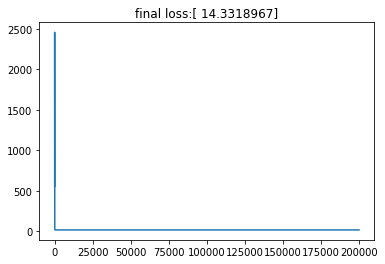

In [3]:
main()